### Aluno: Hygo Sousa de Oliveira 
### Orientador: Eduardo J.P Souto

<h2>
    Link para download do dataset utilizado: <a href= 'https://outbox.eait.uq.edu.au/uqdliu3/uqvitalsignsdataset/download.html'> 
    aqui
    </a>.
</h2>

In [6]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image as pil_image
%matplotlib inline
from IPython.display import Image

import pickle
import pandas as pd
import numpy as np
import pywt
import scipy as sp
import math
import heartpy as hp
import glob
import csv
from scipy import signal
# from pyts.decomposition import SSA

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, \
                                    Dense, \
                                    Flatten, \
                                    Conv1D, \
                                    BatchNormalization, \
                                    Activation, \
                                    GlobalMaxPooling1D, \
                                    Dropout, \
                                    LSTM, \
                                    MaxPooling1D, \
                                    Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend
from sklearn.model_selection import train_test_split

In [3]:
# apresensentar as figuras
def display_img(img, w, h):
    with open(img, 'rb') as g:
        display(Image(g.read(), width = w, height=h))

# plotar o sinal PPG
def plot_df(x, y, title="", xlabel='Data', ylabel='Amplitude', dpi=300):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.grid(True)
    plt.show()

def plot_original_filtro(raw, filtred, star, end):
    plt.figure(figsize=(16,5), dpi=200)
    plt.plot(raw[start:end], color='red',label="Sinal Original")
    plt.plot(filtred[start:end], color='blue',label="Sinal Filtrado")
    plt.title('Comparacao do comprimento')
    plt.xlabel("Amostras")
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

In [4]:
def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def _decimate(x, q):
    """
    Downsample the signal after low-pass filtering to avoid aliasing.
    An order 16 Chebyshev type I filter is used.

    Parameters
    ----------
    x : ndarray
        The signal to be downsampled, as an N-dimensional array.
    q : int
        The downsampling factor.

    Returns
    -------
    y : ndarray
        The down-sampled signal.
    """
    if not isinstance(q, int):
        raise TypeError("q must be an integer")

    b, a = signal.filter_design.cheby1(16, 0.025, 0.98 / q)

    y = signal.filtfilt(b, a, x, axis=-1)

    sl = [slice(None)] * y.ndim
    sl[-1] = slice(None, None, q)
    return y[sl]


In [30]:
# Plot training & validation accuracy values
def plots_loss_validation(hist):
    def plot_train_s1(hist):
        plt.figure(figsize=(12,6), dpi=150)
        plt.plot(hist['s1_mae'])
        plt.plot(hist['val_s1_mae'])
        plt.title("Loss e validation - Sístole")
        plt.ylabel('Precisão')
        plt.xlabel('Época')
        plt.ylim([0,45])
        plt.legend(['s1_mae', 'val_s1_mae'], loc='upper left')
        plt.show()

    def plot_train_s2(hist):
        plt.figure(figsize=(12,6), dpi=150)
        plt.plot(hist['s2_mae'])
        plt.plot(hist['val_s2_mae'])
        plt.title("Loss e validation - Diástole")
        plt.ylabel('Precisão')
        plt.xlabel('Época')
        plt.ylim([0,45])
        plt.legend(['s2_mae','val_s2_mae'], loc='upper left')
        plt.show()

    def plot_geral(hist):
        plt.figure(figsize=(12,6), dpi=150)
        plt.plot(hist['loss'])
        plt.plot(hist['val_loss'])
        plt.title("Perda e Validação Geral")
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.ylim([0,45])
        plt.legend(['loss', 'val_loss'], loc='upper left')
        plt.show()
    plot_train_s1(hist) 
    plot_train_s2(hist)
    plot_geral(hist)

In [6]:
from tensorflow.keras import backend
 
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

## Aluno: Hygo Oliveira

### Tema: Previsão dos valores de Sístole e Diástole para inferência da Pressão sanguínea 

## Contextualização

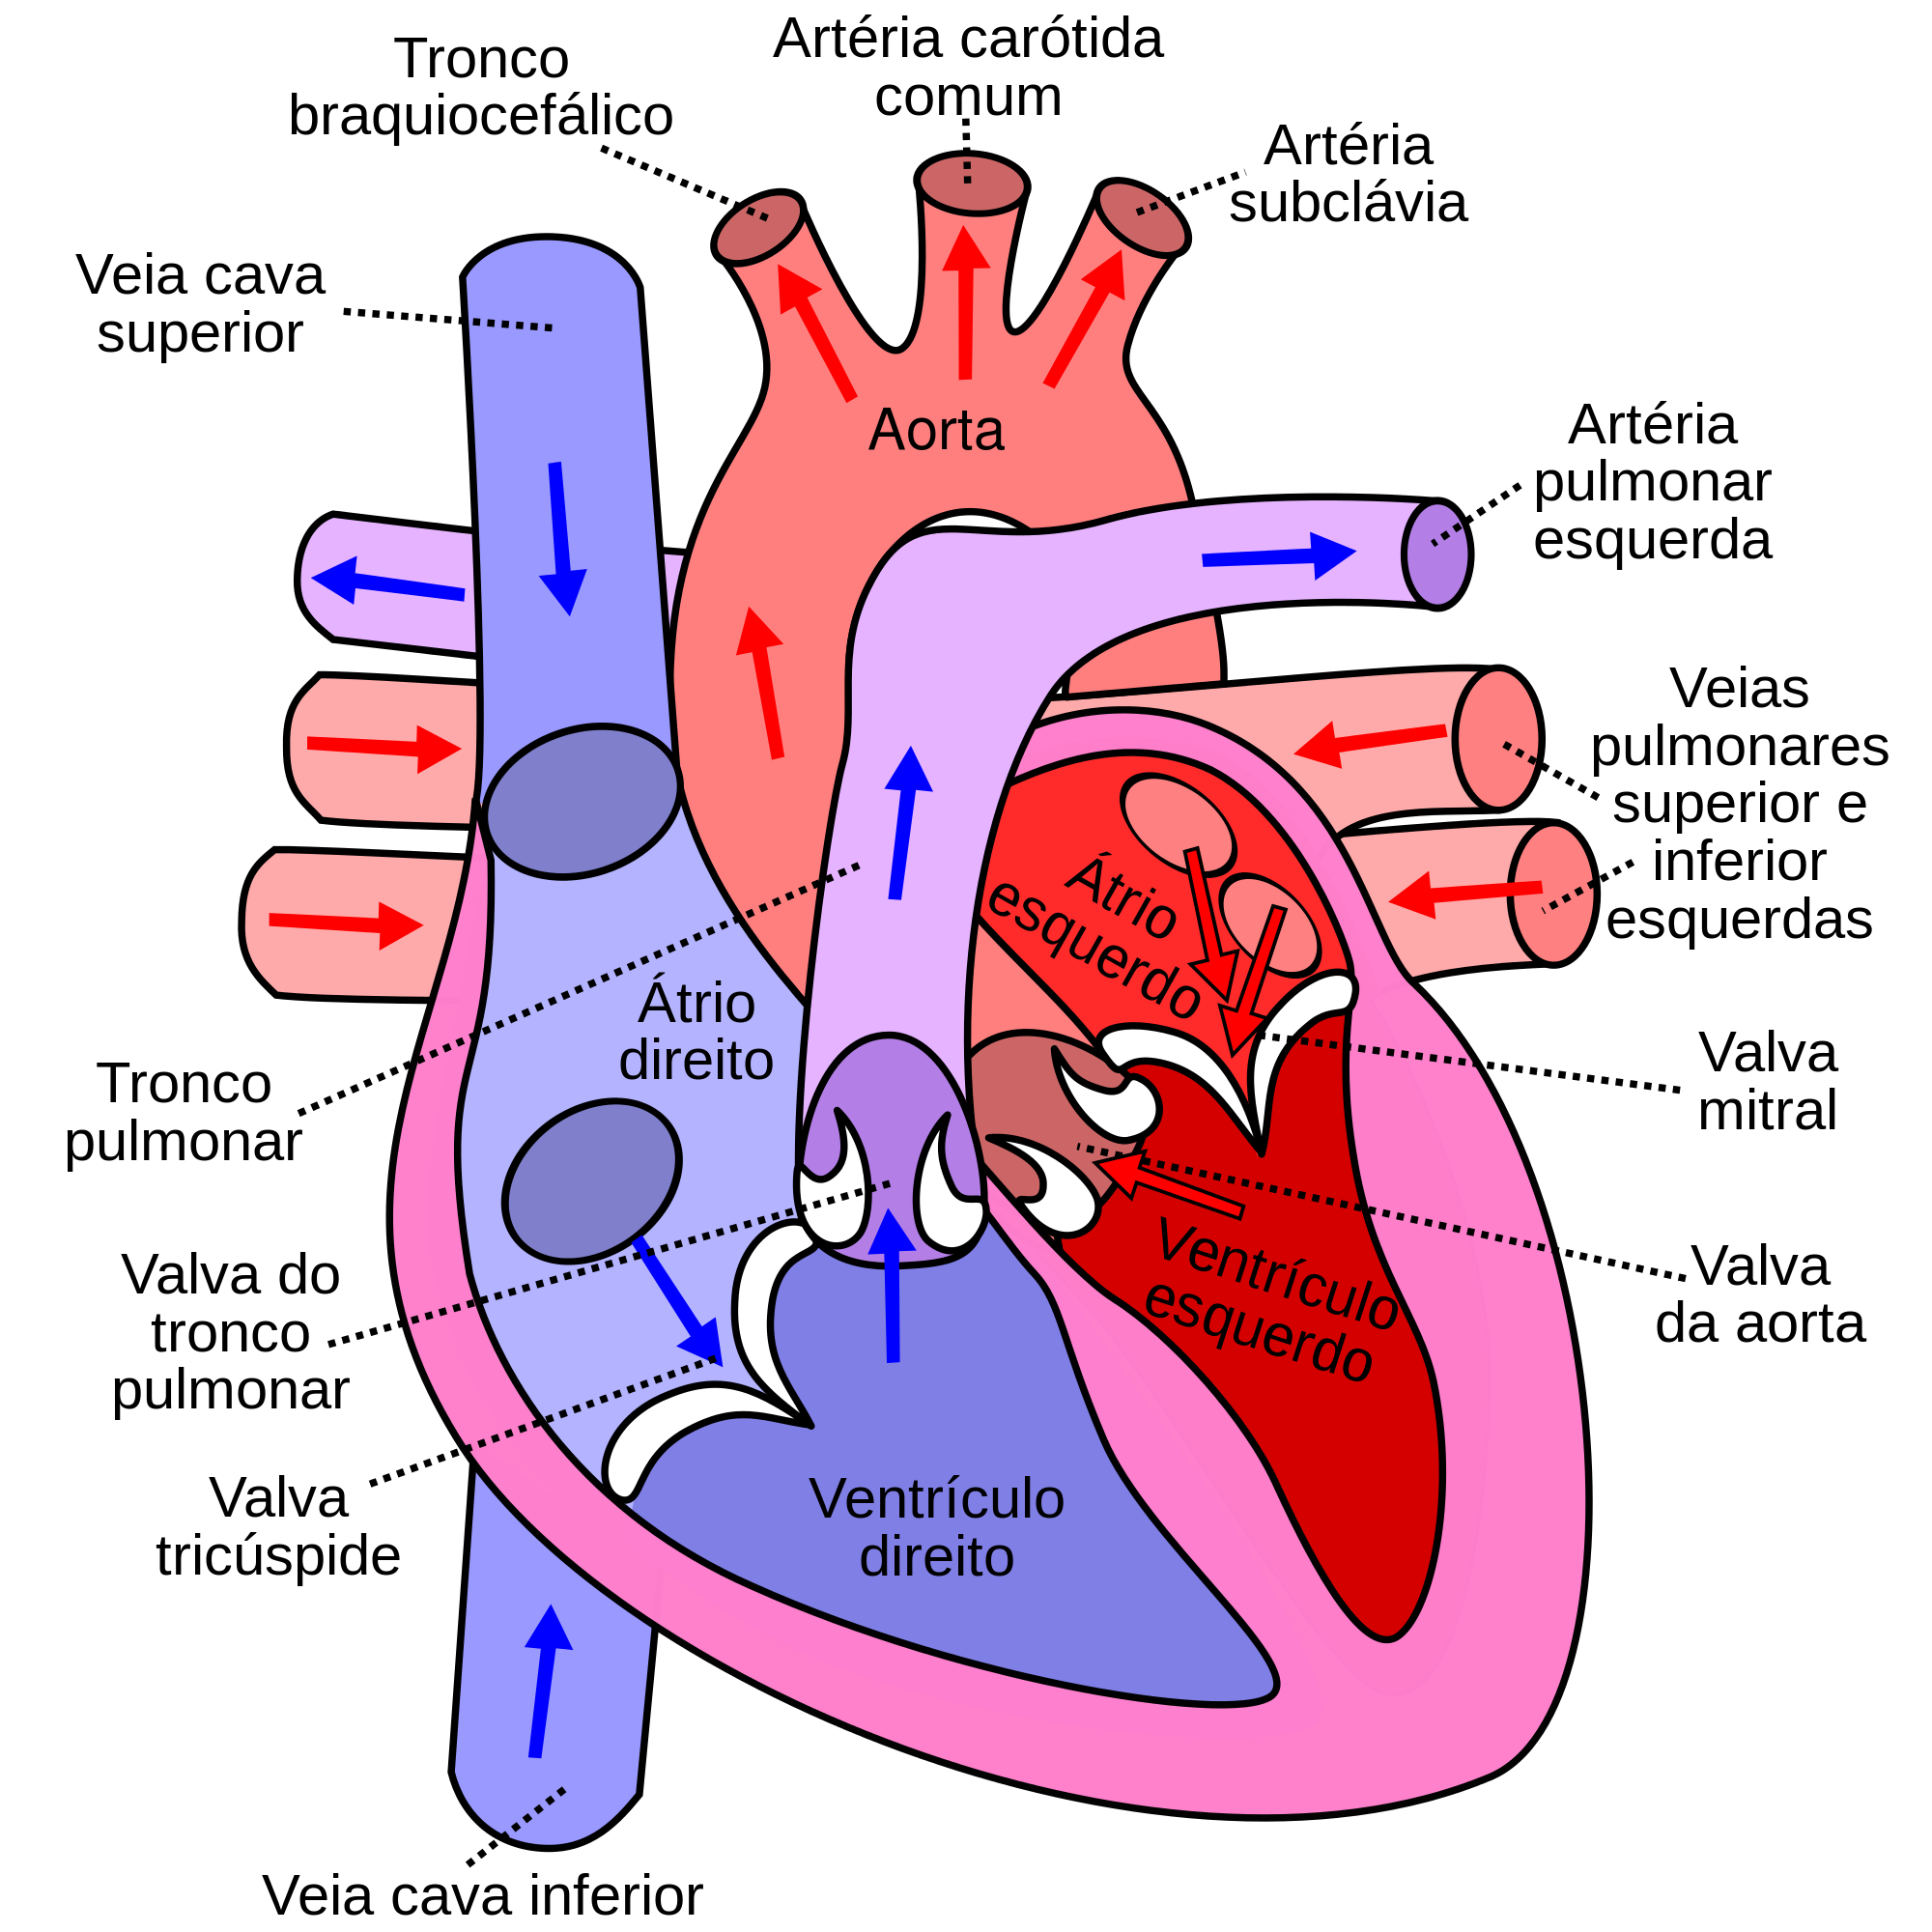

In [7]:
img_path = "Experimentacao/Imagens/ciclo_cardiaco.png"
display_img(img_path, 500, 500)

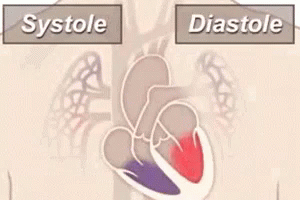

In [8]:
img_path = "Experimentacao/Imagens/tenor.gif"
display_img(img_path, 700, 700)

In [9]:
# path_dataset = "/home/hygo/Desktop/UFAM/Datasets/uqvitalsignsdata/case01/fulldata"
# print(os.chdir(path_dataset))
# print(os.listdir(os.chdir(path_dataset)))

## Sinal PPG e as características relevantes para o projeto

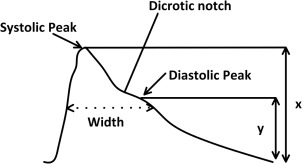

In [10]:
# img_path = "Experimentacao/Imagens/carac_importantes_ppg.jpg"
img_path = "/home/hygo/Desktop/UFAM/DISCIPLINAS/TOPICOS_ESPECIAIS/Experimentacao/Imagens/carac_importantes_ppg.jpg"
display_img(img_path, 700, 700)

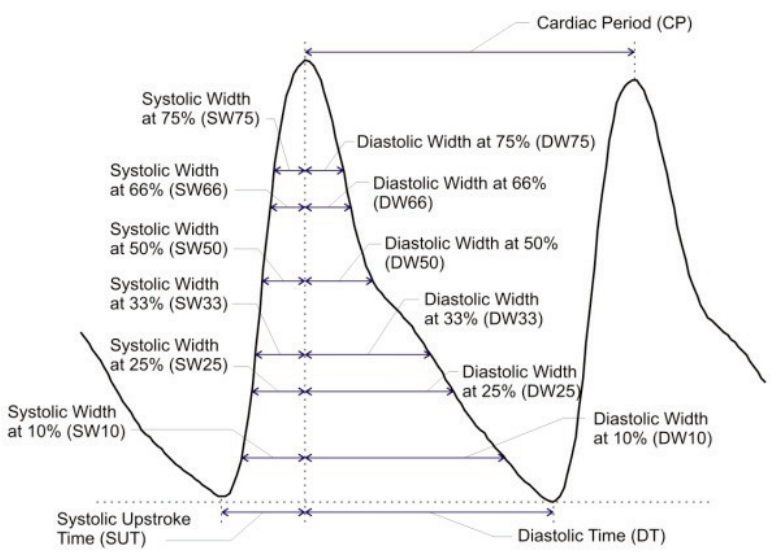

In [11]:
# img_path = "Experimentacao/Imagens/carac_importantes_ppg.jpg"
# referencia da imagem: A Neural Network-based Method for Continuous Blood Pressure Estimation from a PPG Signal - (Yuriy Kurylyak)
img_path = "/home/hygo/Desktop/UFAM/DISCIPLINAS/TOPICOS_ESPECIAIS/Experimentacao/Imagens/outras_carac.png"
display_img(img_path, 700, 700)

## Arquitetura

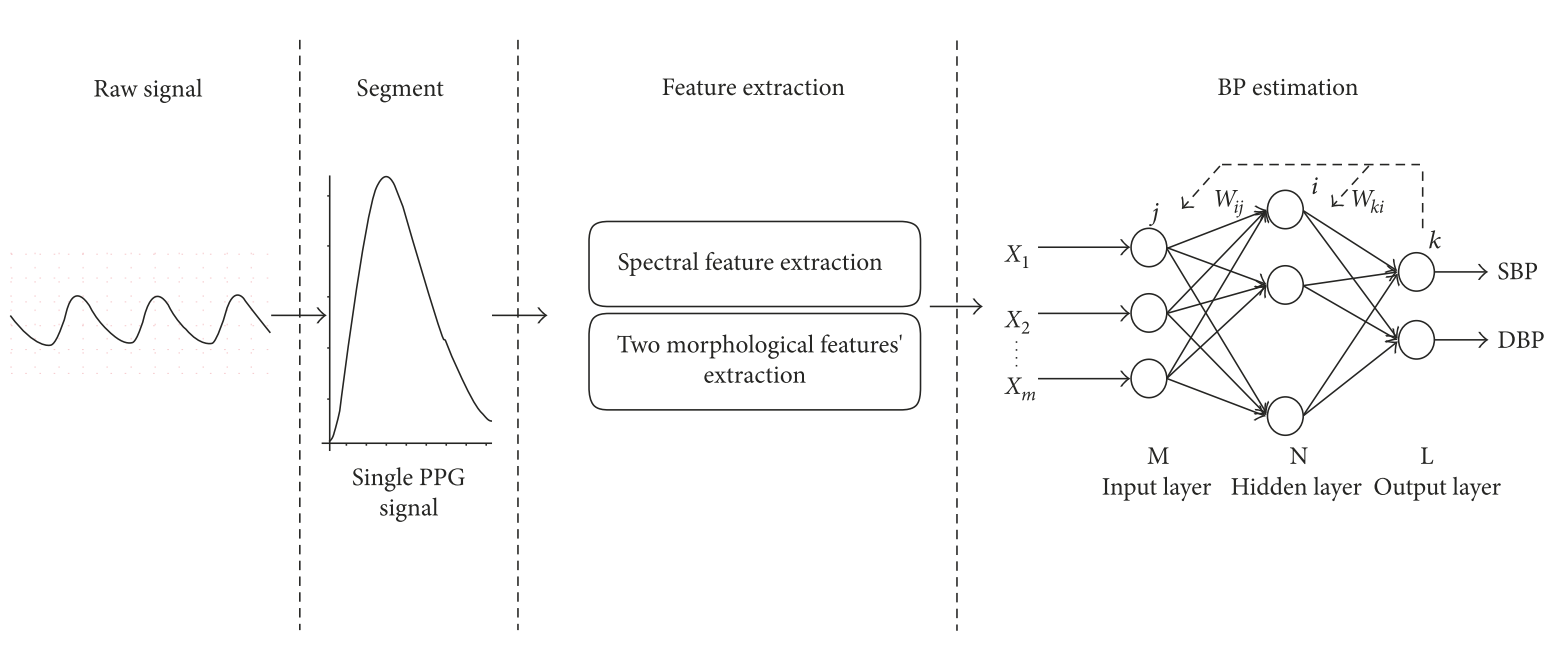

In [12]:
img_path = "/home/hygo/Desktop/UFAM/DISCIPLINAS/TOPICOS_ESPECIAIS/Experimentacao/Imagens/esquema_Ludi Wang_A_Novel_NN_Model_BP.png"
display_img(img_path, 900, 900)

## Descrição do Dataset

### Os dados de sinais vitais foram coletados de pacientes sob anestesia no Royal Adelaide Hospital - Austrália. O software de coletagem desses dados foi desenvolvido para capturar, sincronizar e interpolar dados de sinais vitais dos monitores Philips IntelliVue MP70 e MP30 e das máquinas de anestesia Datex-Ohmeda Aestiva / 5 em amostras de resolução de 10 milissegundos. Os dados gravados foram salvos em uma variedade de formatos de arquivo acessíveis.

### Os dados de monitoramento foram registrados em 32 casos (25 anestésicos gerais, 3 anestésicos espinhais, 4 sedações) com duração variando de 13 minutos a 5 horas (mediana 105 min). A maioria dos casos incluiu dados do eletrocardiógrafo, oxímetro de pulso, capnógrafo, monitor não invasivo de pressão arterial, fluxo das vias aéreas, monitor de pressão e, em alguns casos, espirômetro em peça Y, monitor de eletroencefalograma e monitor de pressão arterial.

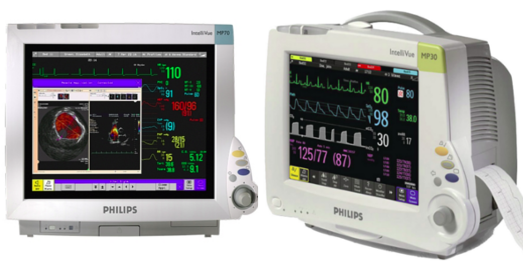

In [13]:
img_path = '/home/hygo/Desktop/UFAM/DISCIPLINAS/TOPICOS_ESPECIAIS/Experimentacao/Imagens/mp70_mp30.png'
display_img(img_path, 700, 700)

### O problema que pode ser resolvido com esses dados?

In [14]:
cols = ['Time','Pleth']
path_dataset = '/home/hygo/Desktop/UFAM/Datasets/uqvitalsignsdata/case01/fulldata/uq_vsd_case01_fulldata_01.csv'
df = pd.read_csv(path_dataset, skip_blank_lines=True)

/home/hygo/anaconda3/envs/ammd2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
df.describe()

RelativeTimeMilliseconds            HR  ST-II         Pulse  \
count              60000.000000  60000.000000    0.0  59386.000000   
mean              299995.000000     61.316183    NaN     59.619136   
std               173206.524127      4.167169    NaN      7.098465   
min                    0.000000     49.000000    NaN     26.000000   
25%               149997.500000     60.000000    NaN     59.000000   
50%               299995.000000     61.000000    NaN     61.000000   
75%               449992.500000     62.000000    NaN     62.000000   
max               599990.000000     73.000000    NaN     75.000000   

               SpO2          Perf         etCO2         imCO2          awRR  \
count  59386.000000  59386.000000  60000.000000  60000.000000  55086.000000   
mean      99.763631      1.403954     30.672517      1.156150      7.821788   
std        1.731935      0.772608     14.300737      2.697132      5.491868   
min       86.000000      0.000000      0.000000      0.000000      0.000000   
25%      100.000000      0.900000     24.000000      1.000000      5.000000   
50%      100.000000      1.200000     38.000000      1.000000      6.000000   
75%      100.000000      1.600000     39.000000      1.000000     10.000000   
max      100.000000      3.300000     42.000000     31.000000     23.000000   

          NBP (Sys)  ...  ART  EEG           AWP           AWF           AWV  \
count  56211.000000  ...  0.0  0.0  60000.000000  60000.000000  60000.000000   
mean     102.997260  ...  NaN  NaN      2.951241      2.482403    557.978198   
std        9.929877  ...  NaN  NaN      2.672296     13.494852   1289.990813   
min       93.000000  ...  NaN  NaN     -5.782720    -45.000860   -277.000000   
25%       93.000000  ...  NaN  NaN      1.600345     -0.031915      1.400000   
50%       97.000000  ...  NaN  NaN      2.265270      0.000000    129.600000   
75%      113.000000  ...  NaN  NaN      3.397128      6.827533    370.425000   
max      113.000000  ...  NaN  NaN     15.468960     57.135490   7036.800000   

       AWP-Spiro  AWF-Spiro  AWV-Spiro  Num Patient Alarms  \
count        0.0        0.0        0.0        60000.000000   
mean         NaN        NaN        NaN            0.305633   
std          NaN        NaN        NaN            0.584803   
min          NaN        NaN        NaN            0.000000   
25%          NaN        NaN        NaN            0.000000   
50%          NaN        NaN        NaN            0.000000   
75%          NaN        NaN        NaN            0.000000   
max          NaN        NaN        NaN            2.000000   

       Num Technical Alarms  
count          60000.000000  
mean               0.308983  
std                0.644194  
min                0.000000  
25%                0.000000  
50%                0.000000  
75%                0.000000  
max                3.000000  

[8 rows x 62 columns]

In [16]:
df.Time

0        00:00:00_000
1        00:00:00_010
2        00:00:00_020
3        00:00:00_030
4        00:00:00_040
             ...     
59995    00:09:59_950
59996    00:09:59_960
59997    00:09:59_970
59998    00:09:59_980
59999    00:09:59_990
Name: Time, Length: 60000, dtype: object

In [17]:
# magicamente comecou a funcionar e nao precisou mais renomear as colunas. Codigo FdP.
#df.rename(columns={'Max Inspiratory Pressure (Spiro)':'ECG', 'ECG':'PPG'})
sample_rate = hp.get_samplerate_datetime(df.Time, timeformat='%H:%M:%S_%f') # separa de acordo com essa freq.
sample_rate

100.0016666944449

## Carregamento das amostras do dataset de Queensland

In [18]:
cols = ['Time', 'NBP (Sys)','NBP (Dia)','Pleth']  # colunas selecionadas
path = r"uqvitalsignsdata/"

In [19]:
# faz a leitura dos arquivos
cases = []
for case in os.listdir(path):
    cases.append(glob.glob(path+case+'/fulldata/*.csv'))

In [20]:
# # pega os n primeiros diretorios e adiciona ao dicionario
# # seleciona os dados para treino
# dataframe = None
# cont = 0
# for d in cases:
#     if cont == 30: # numero de cases selecionadas
#         break
#     for sub in d:
#         if dataframe is None:
#             df = pd.read_csv(sub, usecols = cols, index_col = None)
#             df = df[cols]
#             dataframe = df.dropna()
#         else:
#             df = pd.read_csv(sub, usecols = cols, index_col = None)
#             df = df[cols]
#             df = df.dropna()
#             dataframe = pd.concat([dataframe, df], axis = 0)
#     cont += 1

In [21]:
# pega os n primeiros diretorios e adiciona ao dicionario
# seleciona os dadas para treino
dataframe_teste = None
dataframe = None

cont = 0
for d in cases:
    if cont >= 30: # numero de cases selecionadas para dataframe_teste
        for sub in d:
            if dataframe_teste is None:
                df = pd.read_csv(sub, usecols = cols, index_col = None)
                df = df[cols]
                dataframe_teste = df.dropna()
            else:
                df = pd.read_csv(sub, usecols = cols, index_col = None)
                df = df[cols]
                df = df.dropna()
                dataframe_teste = pd.concat([dataframe_teste, df], axis = 0)
    else: # senao seleciona os dados para treinamento
        for sub in d:
            if dataframe is None:
                df = pd.read_csv(sub, usecols = cols, index_col = None)
                df = df[cols]
                dataframe = df.dropna()
            else:
                df = pd.read_csv(sub, usecols = cols, index_col = None)
                df = df[cols]
                df = df.dropna()
                dataframe = pd.concat([dataframe, df], axis = 0)
    cont += 1

## Apresentação dos dataframes

In [22]:
dataframe

Time  NBP (Sys)  NBP (Dia)    Pleth
0      00:50:00_000      146.0       88.0  0.55946
1      00:50:00_010      146.0       88.0  0.55360
2      00:50:00_020      146.0       88.0  0.54774
3      00:50:00_030      146.0       88.0  0.53700
4      00:50:00_040      146.0       88.0  0.53138
...             ...        ...        ...      ...
59995  00:19:59_950      132.0       74.0  0.32357
59996  00:19:59_960      132.0       74.0  0.31990
59997  00:19:59_970      132.0       74.0  0.31062
59998  00:19:59_980      132.0       74.0  0.30574
59999  00:19:59_990      132.0       74.0  0.30110

[13684826 rows x 4 columns]

In [23]:
dataframe_teste

Time  NBP (Sys)  NBP (Dia)     Pleth
00:30:00_000       1800000       39.0       53.0  44.40000
00:30:00_010       1800010       39.0       53.0  44.40000
00:30:00_020       1800020       39.0       53.0  45.00000
00:30:00_030       1800030       39.0       53.0  45.50000
00:30:00_040       1800040       39.0       53.0  45.50000
...                    ...        ...        ...       ...
59995         03:09:59_950       96.0       55.0   0.65446
59996         03:09:59_960       96.0       55.0   0.63004
59997         03:09:59_970       96.0       55.0   0.61661
59998         03:09:59_980       96.0       55.0   0.60269
59999         03:09:59_990       96.0       55.0   0.58877

[1767979 rows x 4 columns]

In [24]:
dataframe = dataframe[dataframe['Time'].apply(lambda x: type(x) != int)] # remove os casos onde Time recebe val do int
dataframe = dataframe.reset_index() # corrige o indice
dataframe = dataframe.drop(['index'], axis = 1) # remove a  coluna index

In [25]:
dataframe_teste = dataframe_teste[dataframe_teste['Time'].apply(lambda x: type(x) != int)] # remove os casos onde Time recebe val do int
dataframe_teste = dataframe_teste.reset_index() # corrige o indice
dataframe_teste = dataframe_teste.drop(['index'], axis = 1) # remove a  coluna index

## Após a remoção de dados insconsistentes

In [26]:
dataframe

Time  NBP (Sys)  NBP (Dia)    Pleth
0         00:50:00_000      146.0       88.0  0.55946
1         00:50:00_010      146.0       88.0  0.55360
2         00:50:00_020      146.0       88.0  0.54774
3         00:50:00_030      146.0       88.0  0.53700
4         00:50:00_040      146.0       88.0  0.53138
...                ...        ...        ...      ...
11716551  00:19:59_950      132.0       74.0  0.32357
11716552  00:19:59_960      132.0       74.0  0.31990
11716553  00:19:59_970      132.0       74.0  0.31062
11716554  00:19:59_980      132.0       74.0  0.30574
11716555  00:19:59_990      132.0       74.0  0.30110

[11716556 rows x 4 columns]

In [27]:
dataframe_teste

Time  NBP (Sys)  NBP (Dia)    Pleth
0        01:10:00_000      102.0       43.0  0.31770
1        01:10:00_010      102.0       43.0  0.31722
2        01:10:00_020      102.0       43.0  0.31648
3        01:10:00_030      102.0       43.0  0.31575
4        01:10:00_040      102.0       43.0  0.31404
...               ...        ...        ...      ...
1495405  03:09:59_950       96.0       55.0  0.65446
1495406  03:09:59_960       96.0       55.0  0.63004
1495407  03:09:59_970       96.0       55.0  0.61661
1495408  03:09:59_980       96.0       55.0  0.60269
1495409  03:09:59_990       96.0       55.0  0.58877

[1495410 rows x 4 columns]

## Suavização do sinal

In [28]:
# suavizacao com filtro de Butterwoth para remoção dos ruidos gerados pela movimento respiratório
ppg_filtrado = butter_lowpass_filter(dataframe.Pleth.values, 4, 
                                     sample_rate/2)

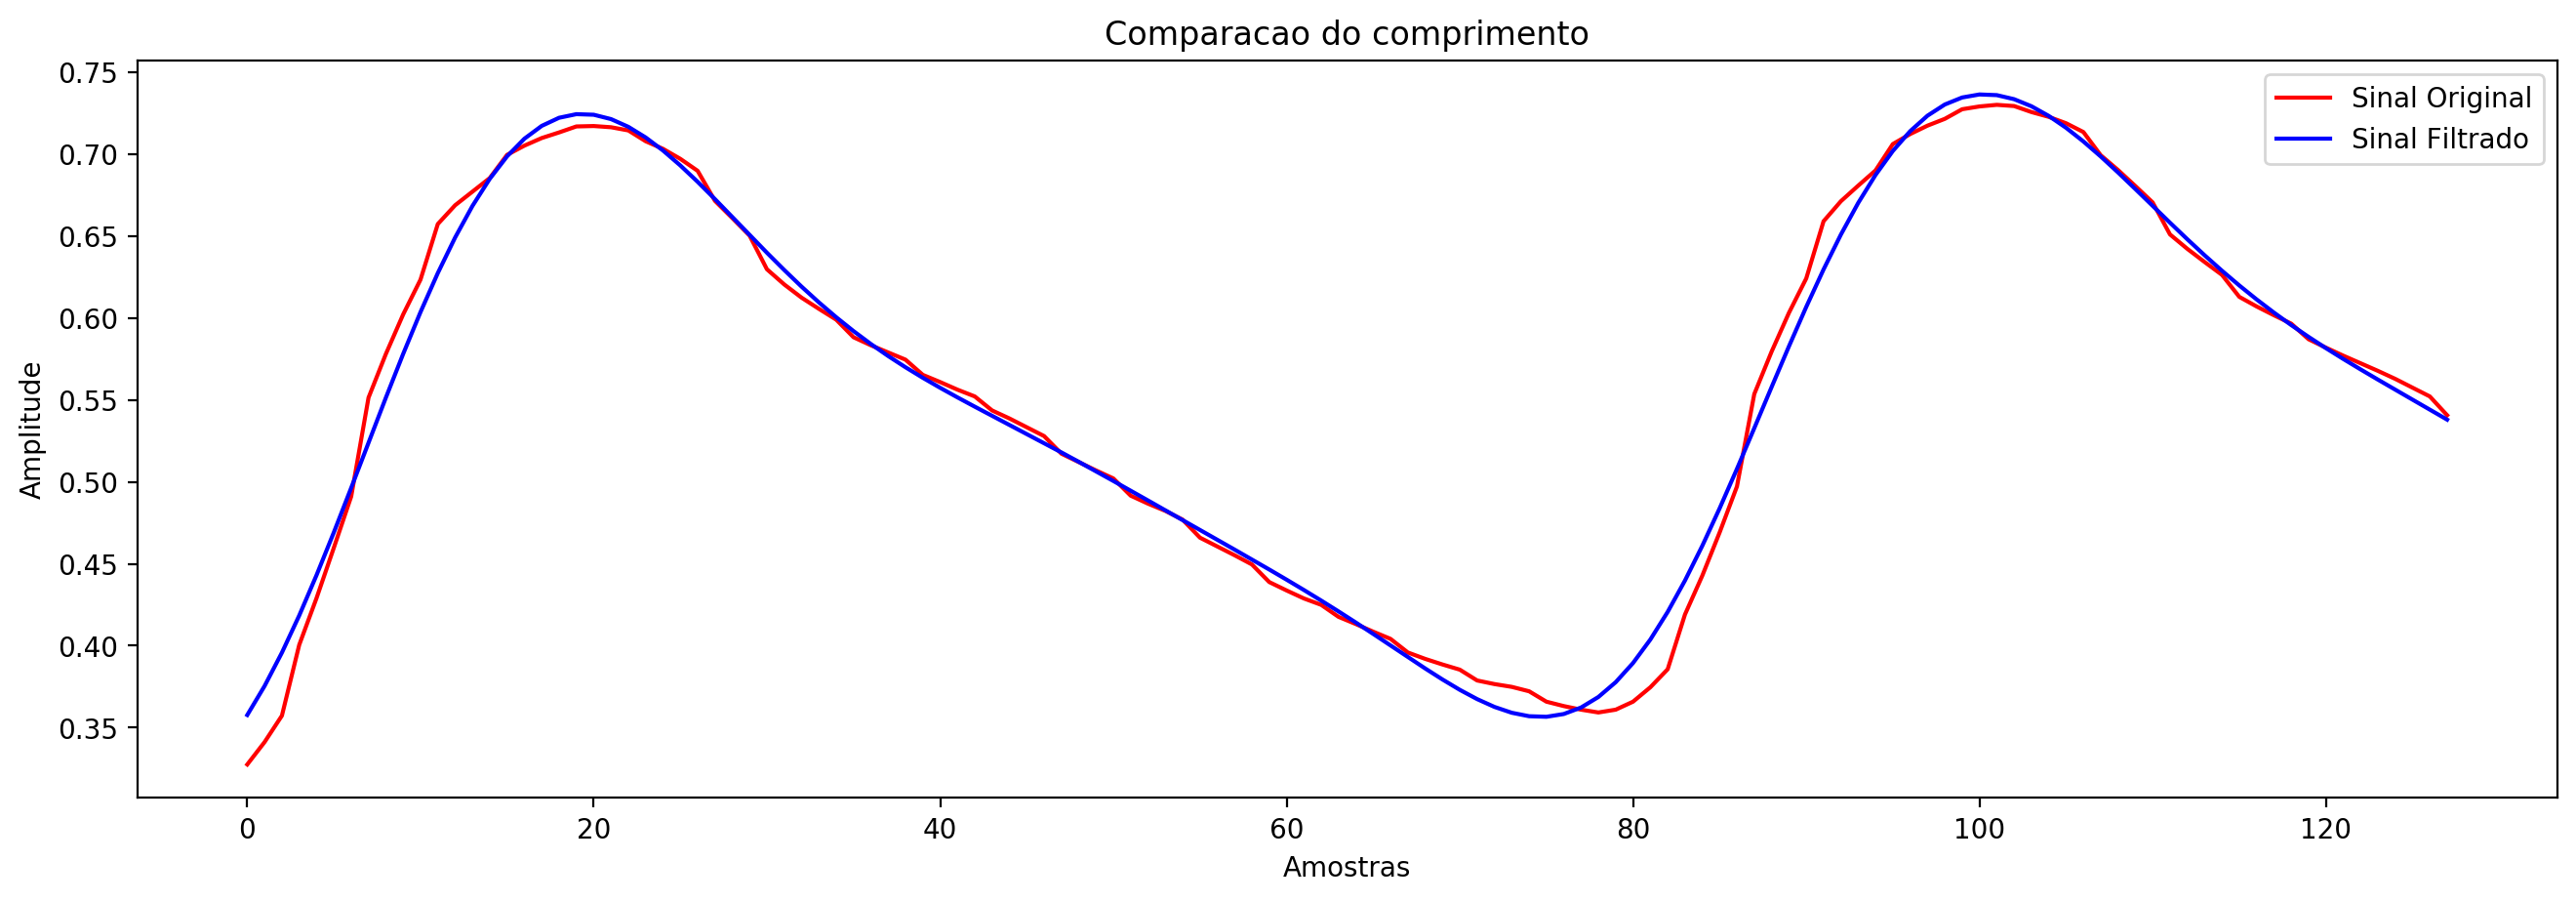

In [29]:
start, end =  100, 228
plot_original_filtro(dataframe.Pleth.values, ppg_filtrado, start, end)

In [30]:
# suavizacao com o filtro de ChebyshevI
ppg_filtro_cheby = _decimate(dataframe.Pleth.values, 8)

/home/hygo/anaconda3/envs/ammd2/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


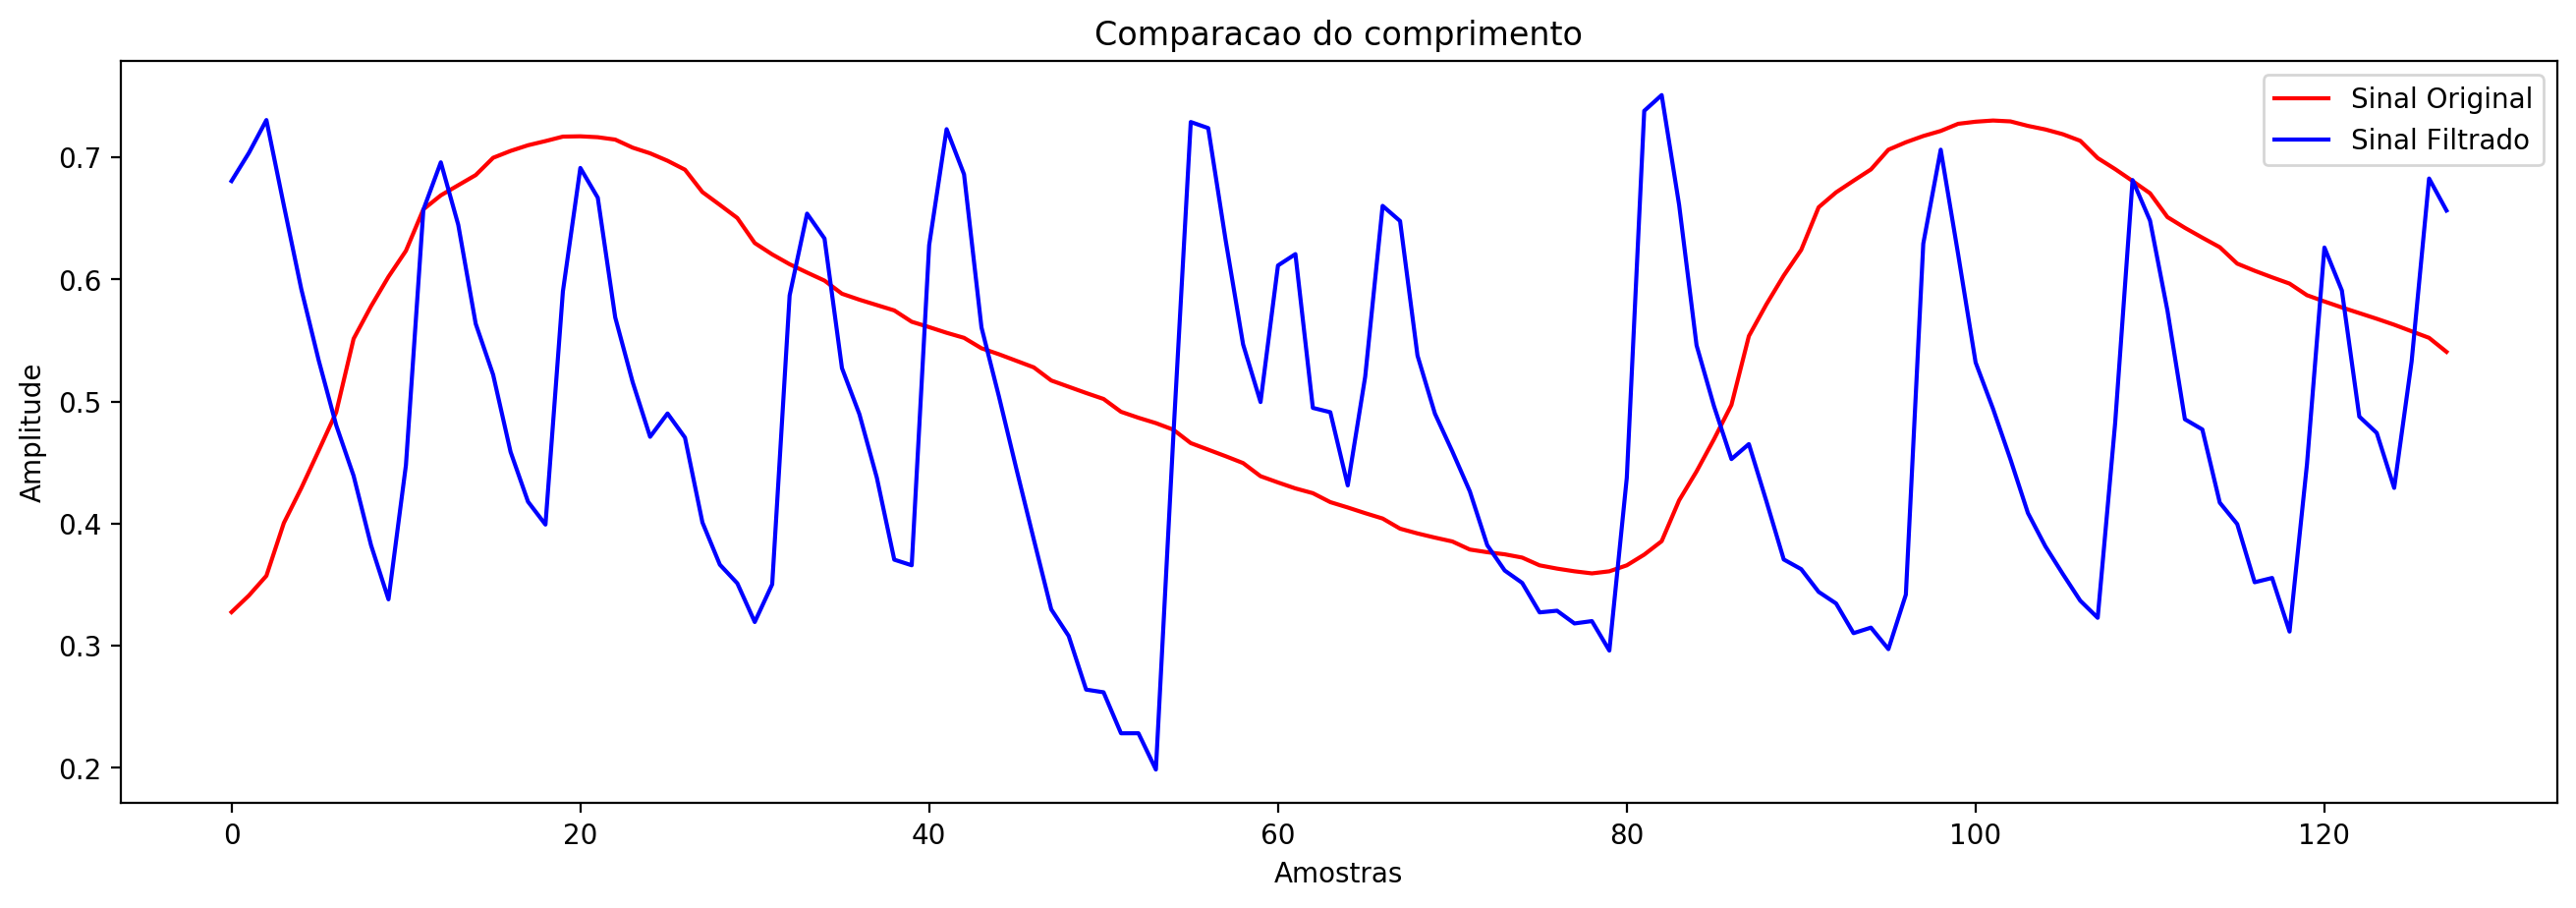

In [31]:
plot_original_filtro(dataframe.Pleth.values, ppg_filtro_cheby, start, end)

In [32]:
# add o sinal filtrado ao dicionario
dataframe['ppg_filtrado'] = ppg_filtrado
dataframe.head()

Time  NBP (Sys)  NBP (Dia)    Pleth  ppg_filtrado
0  00:50:00_000      146.0       88.0  0.55946      0.560795
1  00:50:00_010      146.0       88.0  0.55360      0.551084
2  00:50:00_020      146.0       88.0  0.54774      0.541127
3  00:50:00_030      146.0       88.0  0.53700      0.531032
4  00:50:00_040      146.0       88.0  0.53138      0.520942

## Segmentacao manual do sinal

In [33]:
# vamos segmentar manualmente por enquanto para construir o modelo com convolucao
from scipy.stats import mode # vamos pegar o valor que mais apacere no segmento

In [34]:
seg = 100 #comprimento do seguimento

In [35]:
dataframe.head()

Time  NBP (Sys)  NBP (Dia)    Pleth  ppg_filtrado
0  00:50:00_000      146.0       88.0  0.55946      0.560795
1  00:50:00_010      146.0       88.0  0.55360      0.551084
2  00:50:00_020      146.0       88.0  0.54774      0.541127
3  00:50:00_030      146.0       88.0  0.53700      0.531032
4  00:50:00_040      146.0       88.0  0.53138      0.520942

In [36]:
def separar_base(dataframe, seg = 100):
    """
    Input : dataframe
    Output : segmentos, sistole, diastole
    """
    segmentos = []
    sis = []
    dia = []
    start, end = 0, seg
    while True:
        seg_sis = dataframe.iloc[start:end,1].values
        if len(seg_sis) < seg:
            break
        seg_dia = dataframe.iloc[start:end,2].values
        seg_ppg = dataframe.iloc[start:end,3].values.tolist()

        moda_sis = mode(seg_sis)[0][0]
        moda_dia = mode(seg_dia)[0][0]

        #t = np.array([seg_ppg, moda_dia, moda_sys]).transpose()
        sis.append(moda_sis)
        dia.append(moda_dia)
        segmentos.append(seg_ppg)
        
        start, end = end, end+seg
    
    return segmentos, np.asarray(sis), np.asarray(dia)

## Prepara os dados para treinamento

In [37]:
# trasnforma num array
segmentos, sis, dia = separar_base(dataframe, seg)

In [38]:
input_shape = (seg,)
input_shape, sis.shape, dia.shape

((100,), (117165,), (117165,))

In [39]:
# cols = ['segmentos', 'n_sistole','n_diastole']
d = {'segmentos' : segmentos, 'n_sistole' : sis, 'n_diastole' : dia }
df_experimento = pd.DataFrame(d)

df_experimento.head()

segmentos  n_sistole  n_diastole
0  [0.5594600000000001, 0.5536, 0.54774, 0.537, 0...      146.0        88.0
1  [0.32747, 0.34115, 0.35725999999999997, 0.4004...      146.0        88.0
2  [0.72918, 0.73016, 0.72943, 0.7257600000000001...      146.0        88.0
3  [0.59536, 0.58877, 0.58217, 0.57045, 0.56435, ...      146.0        88.0
4  [0.64444, 0.66276, 0.6783899999999999, 0.69817...      146.0        88.0

## Prepara os dados para teste

In [40]:
segmentos, sis, dia = separar_base(dataframe_teste, seg)

In [41]:
# cols = ['segmentos', 'n_sistole','n_diastole']
d = {'segmentos' : segmentos, 'n_sistole' : sis, 'n_diastole' : dia }
df_teste = pd.DataFrame(d)

df_teste.head()

segmentos  n_sistole  n_diastole
0  [0.3177, 0.31722, 0.31648000000000004, 0.31575...      102.0        43.0
1  [0.4525, 0.49475, 0.53797, 0.57973, 0.64762, 0...      102.0        43.0
2  [0.7023199999999999, 0.68523, 0.66716000000000...      102.0        43.0
3  [0.34481, 0.32966999999999996, 0.31575, 0.3030...      102.0        43.0
4  [0.27668000000000004, 0.28156, 0.28669, 0.2918...      102.0        43.0

## Segmentacao com Algoritmo Elgendi para detecção de pico

In [42]:
## Not yet

## Separacao da base para treino e validacao, com modificacoes

In [43]:
X_train, X_test = train_test_split(df_experimento, 
                                   test_size = .20, 
                                   random_state = 42,
                                   shuffle = True)

# dados de treinamento
y_sis_train, y_dias_train  = X_train.n_sistole.values, X_train.n_diastole.values
X_train = X_train.segmentos

# dados de teste
y_sis_test, y_dias_test  = X_test.n_sistole.values, X_test.n_diastole.values
X_test = X_test.segmentos

In [44]:
# Converte novamento os dados em array
X_train = np.asarray([np.asarray(x) for x in X_train])
X_test = np.asarray([np.asarray(x) for x in X_test])

In [45]:
X_train.shape, X_test.shape, y_sis_train.shape, y_dias_train.shape, y_sis_test.shape, y_dias_test.shape

((93732, 100), (23433, 100), (93732,), (93732,), (23433,), (23433,))

In [46]:
input_shape

(100,)

## Carrega apenas os dados de Teste

In [47]:
# dados de teste
y_sis_test2, y_dias_test2 = df_teste.n_sistole.values, df_teste.n_diastole.values
y_sis_test2, y_dias_test2 = y_sis_test2.reshape(-1,1), y_dias_test2.reshape(-1,1)
X_test2 = df_teste.segmentos
X_test2.shape

In [48]:
# Converte novamento os dados em array
X_test2 = np.asarray([np.asarray(x) for x in X_test2])

In [49]:
# Imprime os dados de Teste
indices = [np.random.randint(0,len(X_test2)) for _ in range(10)]
def print_pred(prev_sis, prev_dia, num_casos = 10):
    """
    inputs = prev_sis, prev_dia, num_casos
    opcional = num_casos
    
    outputs = void
    """
    for i in indices:
        print("Sistole : Pred -> {0}, Real -> {1} \nDiastole : Pred -> {2}, Real -> {3}\n".format(prev_sis[i],y_sis_test2[i],prev_dia[i], y_dias_test2[i]))

In [50]:
# calcula o erro quadractico medio 
def mse(y_true, y_pred):
    return backend.mean(backend.square(y_pred - y_true))

In [3]:
def percent_mean_absolute_error(y_true, y_pred):
    diff = backend.mean(backend.abs((y_pred - y_true)) / backend.mean(backend.clip(backend.abs(y_true),
                                                           backend.epsilon(),
                                                           None)))
    return 100. * backend.mean(diff)

In [60]:
# salva o historico de aprendizagem
def salvar_historico_modelo(file, hist):
    with open('historicos_fit/'+file+'.pickle', 'wb') as file:
            pickle.dump(hist.history, file)
# np.save("a.npy",hist)


In [4]:
# ler o historico de aprendizagem
def ler_historico_modelo(file):
    """ Input: file --- sem extensao
    """
    hist = None
    with open('historicos_fit/'+file+'.pickle', 'rb') as file:
            hist = pickle.load(file)
    return hist

<h2>
    A partir daqui serão testados alguns modelos em arquiteturas com camadas densas, convolutivas e temporaris.
</h2>

### Modelo 1 - Camadas Densas

In [50]:
def model_dense(input_shape):
    inp = Input(shape=input_shape, name = "input")

    h = Dense(units=128, kernel_initializer='he_normal',  name = 'h1')(inp)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Dropout(0.2, name = 'drop1')(h)

    h = Dense(units=64, kernel_initializer='he_normal',  name = 'h2')(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Dropout(0.2, name = 'drop2')(h)
    
    h = Dense(units=32, kernel_initializer='he_normal',  name = 'h3')(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Dropout(0.2, name = 'drop3')(h)

    o1 = Dense(units=1, activation = 'linear', name = 's1')(h)
    o2 = Dense(units=1, activation = 'linear', name = 's2')(h)
    
    model = Model(inputs = inp, outputs = [o1,o2], name='Model_Denso')
    model.compile(optimizer = 'adam', loss = 'mae', metrics= ['mae'])
    model.summary()
    return model

In [51]:
model = model_dense(input_shape)

Model: "Model_Denso"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
h1 (Dense)                      (None, 128)          12928       input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         h1[0][0]                         
__________________________________________________________________________________________________
activation (Activation)         (None, 128)          0           batch_normalization[0][0]        
________________________________________________________________________________________

In [52]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="modelo_dens_drop_2_segmento100.h5",
                                                 save_best_only=True,
                                                 verbose=1)

hist = model.fit(x = X_train, y = [y_sis_train, y_dias_train],
          epochs=2000, 
          batch_size=128,
          validation_data = (X_test, [y_sis_test, y_dias_test]),
          callbacks = [cp_callback],
          verbose = 1)

Train on 93732 samples, validate on 23433 samples
Epoch 1/5000
92800/93732 [============================>.] - ETA: 0s - loss: 12985.7954 - s1_loss: 10370.4805 - s2_loss: 2615.3142 - s1_mae: 98.3100 - s2_mae: 47.5366
Epoch 00001: val_loss improved from inf to 6365.25989, saving model to modelo_dens_drop_2_segmento100.h5
93732/93732 [==============================] - 9s 98us/sample - loss: 12930.3649 - s1_loss: 10328.0029 - s2_loss: 2597.7266 - s1_mae: 98.0895 - s2_mae: 47.3365 - val_loss: 6365.2599 - val_s1_loss: 5631.9170 - val_s2_loss: 721.9833 - val_s1_mae: 70.7850 - val_s2_mae: 22.8785
Epoch 2/5000
93184/93732 [============================>.] - ETA: 0s - loss: 3332.8631 - s1_loss: 2909.0154 - s2_loss: 423.8473 - s1_mae: 44.8873 - s2_mae: 16.2438
Epoch 00002: val_loss improved from 6365.25989 to 1029.60149, saving model to modelo_dens_drop_2_segmento100.h5
93732/93732 [==============================] - 4s 43us/sample - loss: 3320.0696 - s1_loss: 2894.8843 - s2_loss: 422.9217 - s1_mae

Epoch 18/5000
92416/93732 [============================>.] - ETA: 0s - loss: 876.5025 - s1_loss: 625.0277 - s2_loss: 251.4747 - s1_mae: 17.6796 - s2_mae: 12.4138
Epoch 00018: val_loss did not improve from 1005.71080
93732/93732 [==============================] - 4s 38us/sample - loss: 875.6716 - s1_loss: 624.8365 - s2_loss: 251.1243 - s1_mae: 17.6726 - s2_mae: 12.4059 - val_loss: 1377.6248 - val_s1_loss: 970.9183 - val_s2_loss: 406.2784 - val_s1_mae: 27.4073 - val_s2_mae: 16.5386
Epoch 19/5000
93184/93732 [============================>.] - ETA: 0s - loss: 878.9741 - s1_loss: 627.2253 - s2_loss: 251.7488 - s1_mae: 17.7080 - s2_mae: 12.4156
Epoch 00019: val_loss did not improve from 1005.71080
93732/93732 [==============================] - 4s 39us/sample - loss: 878.6210 - s1_loss: 626.9517 - s2_loss: 251.5540 - s1_mae: 17.7039 - s2_mae: 12.4111 - val_loss: 1168.4263 - val_s1_loss: 815.3967 - val_s2_loss: 351.9681 - val_s1_mae: 24.1172 - val_s2_mae: 15.1572
Epoch 20/5000
93696/93732 [===

Epoch 35/5000
92928/93732 [============================>.] - ETA: 0s - loss: 823.6863 - s1_loss: 589.7644 - s2_loss: 233.9219 - s1_mae: 17.0197 - s2_mae: 11.9216
Epoch 00035: val_loss did not improve from 1005.71080
93732/93732 [==============================] - 4s 39us/sample - loss: 823.6443 - s1_loss: 589.3854 - s2_loss: 233.8921 - s1_mae: 17.0188 - s2_mae: 11.9226 - val_loss: 1345.6742 - val_s1_loss: 951.8093 - val_s2_loss: 393.4024 - val_s1_mae: 27.0245 - val_s2_mae: 16.2410
Epoch 36/5000
92544/93732 [============================>.] - ETA: 0s - loss: 827.7672 - s1_loss: 594.0151 - s2_loss: 233.7524 - s1_mae: 17.0485 - s2_mae: 11.9063
Epoch 00036: val_loss did not improve from 1005.71080
93732/93732 [==============================] - 4s 44us/sample - loss: 827.4487 - s1_loss: 594.0898 - s2_loss: 233.7193 - s1_mae: 17.0482 - s2_mae: 11.9057 - val_loss: 1389.1055 - val_s1_loss: 985.5406 - val_s2_loss: 403.1950 - val_s1_mae: 27.6858 - val_s2_mae: 16.4832
Epoch 37/5000
92928/93732 [===

Epoch 52/5000
93312/93732 [============================>.] - ETA: 0s - loss: 791.0442 - s1_loss: 567.9143 - s2_loss: 223.1299 - s1_mae: 16.6273 - s2_mae: 11.6028
Epoch 00052: val_loss did not improve from 1005.71080
93732/93732 [==============================] - 4s 42us/sample - loss: 791.2872 - s1_loss: 568.2129 - s2_loss: 223.0873 - s1_mae: 16.6278 - s2_mae: 11.6040 - val_loss: 1277.3532 - val_s1_loss: 900.0773 - val_s2_loss: 376.5991 - val_s1_mae: 25.9817 - val_s2_mae: 15.8124
Epoch 53/5000
93568/93732 [============================>.] - ETA: 0s - loss: 789.6748 - s1_loss: 566.6819 - s2_loss: 222.9925 - s1_mae: 16.6085 - s2_mae: 11.6171
Epoch 00053: val_loss did not improve from 1005.71080
93732/93732 [==============================] - 3s 36us/sample - loss: 789.5204 - s1_loss: 566.4274 - s2_loss: 223.0143 - s1_mae: 16.6062 - s2_mae: 11.6157 - val_loss: 1270.2519 - val_s1_loss: 896.5441 - val_s2_loss: 372.9874 - val_s1_mae: 25.8895 - val_s2_mae: 15.7366
Epoch 54/5000
92544/93732 [===

Epoch 69/5000
92288/93732 [============================>.] - ETA: 0s - loss: 766.1411 - s1_loss: 551.0214 - s2_loss: 215.1201 - s1_mae: 16.3101 - s2_mae: 11.3999
Epoch 00069: val_loss did not improve from 1005.71080
93732/93732 [==============================] - 3s 34us/sample - loss: 766.1797 - s1_loss: 550.8445 - s2_loss: 215.2425 - s1_mae: 16.3165 - s2_mae: 11.4060 - val_loss: 1147.5259 - val_s1_loss: 801.0573 - val_s2_loss: 345.3655 - val_s1_mae: 23.7705 - val_s2_mae: 14.9885
Epoch 70/5000
92416/93732 [============================>.] - ETA: 0s - loss: 764.0006 - s1_loss: 549.4956 - s2_loss: 214.5049 - s1_mae: 16.2854 - s2_mae: 11.3634
Epoch 00070: val_loss did not improve from 1005.71080
93732/93732 [==============================] - 3s 34us/sample - loss: 763.4334 - s1_loss: 549.7000 - s2_loss: 214.3264 - s1_mae: 16.2760 - s2_mae: 11.3578 - val_loss: 1118.0408 - val_s1_loss: 782.3188 - val_s2_loss: 334.4445 - val_s1_mae: 23.2759 - val_s2_mae: 14.6974
Epoch 71/5000
93312/93732 [===

Epoch 86/5000
92800/93732 [============================>.] - ETA: 0s - loss: 751.0374 - s1_loss: 540.1446 - s2_loss: 210.8927 - s1_mae: 16.1088 - s2_mae: 11.2546
Epoch 00086: val_loss did not improve from 1005.71080
93732/93732 [==============================] - 3s 35us/sample - loss: 751.4773 - s1_loss: 540.4193 - s2_loss: 210.9180 - s1_mae: 16.1172 - s2_mae: 11.2561 - val_loss: 1041.8539 - val_s1_loss: 721.1310 - val_s2_loss: 319.1580 - val_s1_mae: 21.7317 - val_s2_mae: 14.2529
Epoch 87/5000
92672/93732 [============================>.] - ETA: 0s - loss: 749.3983 - s1_loss: 537.9737 - s2_loss: 211.4244 - s1_mae: 16.0746 - s2_mae: 11.2664
Epoch 00087: val_loss did not improve from 1005.71080
93732/93732 [==============================] - 3s 35us/sample - loss: 749.9816 - s1_loss: 539.1952 - s2_loss: 211.4923 - s1_mae: 16.0767 - s2_mae: 11.2657 - val_loss: 1064.8188 - val_s1_loss: 736.9766 - val_s2_loss: 326.3630 - val_s1_mae: 22.1461 - val_s2_mae: 14.4656
Epoch 88/5000
93568/93732 [===

Epoch 103/5000
92928/93732 [============================>.] - ETA: 0s - loss: 735.6913 - s1_loss: 528.7935 - s2_loss: 206.8980 - s1_mae: 15.9186 - s2_mae: 11.1321
Epoch 00103: val_loss did not improve from 1005.71080
93732/93732 [==============================] - 3s 35us/sample - loss: 735.3997 - s1_loss: 528.3485 - s2_loss: 207.0043 - s1_mae: 15.9183 - s2_mae: 11.1349 - val_loss: 1090.5084 - val_s1_loss: 752.9809 - val_s2_loss: 336.2017 - val_s1_mae: 22.5877 - val_s2_mae: 14.7449
Epoch 104/5000
93056/93732 [============================>.] - ETA: 0s - loss: 732.4797 - s1_loss: 526.4489 - s2_loss: 206.0306 - s1_mae: 15.8414 - s2_mae: 11.1026
Epoch 00104: val_loss did not improve from 1005.71080
93732/93732 [==============================] - 3s 35us/sample - loss: 732.0503 - s1_loss: 526.0987 - s2_loss: 205.9762 - s1_mae: 15.8391 - s2_mae: 11.0997 - val_loss: 1076.7363 - val_s1_loss: 739.5840 - val_s2_loss: 335.7540 - val_s1_mae: 22.2508 - val_s2_mae: 14.7350
Epoch 105/5000
92416/93732 [

Epoch 120/5000
92672/93732 [============================>.] - ETA: 0s - loss: 729.5433 - s1_loss: 524.1390 - s2_loss: 205.4044 - s1_mae: 15.8130 - s2_mae: 11.0670
Epoch 00120: val_loss did not improve from 1003.34528
93732/93732 [==============================] - 3s 36us/sample - loss: 730.0655 - s1_loss: 524.3190 - s2_loss: 205.5643 - s1_mae: 15.8174 - s2_mae: 11.0712 - val_loss: 1036.3282 - val_s1_loss: 714.1251 - val_s2_loss: 320.5685 - val_s1_mae: 21.5095 - val_s2_mae: 14.3020
Epoch 121/5000
93312/93732 [============================>.] - ETA: 0s - loss: 721.4763 - s1_loss: 517.7068 - s2_loss: 203.7694 - s1_mae: 15.6922 - s2_mae: 11.0500
Epoch 00121: val_loss did not improve from 1003.34528
93732/93732 [==============================] - 3s 37us/sample - loss: 720.8516 - s1_loss: 517.0847 - s2_loss: 203.6488 - s1_mae: 15.6875 - s2_mae: 11.0455 - val_loss: 1035.2501 - val_s1_loss: 708.7029 - val_s2_loss: 324.8941 - val_s1_mae: 21.3358 - val_s2_mae: 14.4280
Epoch 122/5000
93696/93732 [

Epoch 137/5000
93312/93732 [============================>.] - ETA: 0s - loss: 708.3968 - s1_loss: 507.6720 - s2_loss: 200.7242 - s1_mae: 15.5176 - s2_mae: 10.9395
Epoch 00137: val_loss improved from 998.20404 to 953.58742, saving model to modelo_dens_drop_2_segmento100.h5
93732/93732 [==============================] - 3s 35us/sample - loss: 708.2044 - s1_loss: 507.2559 - s2_loss: 200.6219 - s1_mae: 15.5139 - s2_mae: 10.9398 - val_loss: 953.5874 - val_s1_loss: 652.3273 - val_s2_loss: 299.0754 - val_s1_mae: 19.2419 - val_s2_mae: 13.6574
Epoch 138/5000
93056/93732 [============================>.] - ETA: 0s - loss: 711.6781 - s1_loss: 510.5543 - s2_loss: 201.1242 - s1_mae: 15.5824 - s2_mae: 10.9450
Epoch 00138: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 711.0167 - s1_loss: 509.7124 - s2_loss: 200.9533 - s1_mae: 15.5789 - s2_mae: 10.9427 - val_loss: 1013.7243 - val_s1_loss: 690.3765 - val_s2_loss: 321.5883 - val_s1_mae: 20.7

Epoch 154/5000
92416/93732 [============================>.] - ETA: 0s - loss: 702.6130 - s1_loss: 504.0927 - s2_loss: 198.5202 - s1_mae: 15.4110 - s2_mae: 10.8778
Epoch 00154: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 701.7981 - s1_loss: 503.1925 - s2_loss: 198.4556 - s1_mae: 15.4002 - s2_mae: 10.8761 - val_loss: 990.3133 - val_s1_loss: 673.0424 - val_s2_loss: 315.4284 - val_s1_mae: 20.2404 - val_s2_mae: 14.1417
Epoch 155/5000
93312/93732 [============================>.] - ETA: 0s - loss: 699.6924 - s1_loss: 500.7893 - s2_loss: 198.9031 - s1_mae: 15.4019 - s2_mae: 10.8889
Epoch 00155: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 699.7510 - s1_loss: 501.0937 - s2_loss: 198.8208 - s1_mae: 15.4032 - s2_mae: 10.8868 - val_loss: 1027.8544 - val_s1_loss: 699.7314 - val_s2_loss: 326.4832 - val_s1_mae: 21.1390 - val_s2_mae: 14.4659
Epoch 156/5000
92288/93732 [===

Epoch 171/5000
92800/93732 [============================>.] - ETA: 0s - loss: 690.7875 - s1_loss: 494.8061 - s2_loss: 195.9817 - s1_mae: 15.2358 - s2_mae: 10.7866
Epoch 00171: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 689.2934 - s1_loss: 493.5381 - s2_loss: 195.6689 - s1_mae: 15.2234 - s2_mae: 10.7797 - val_loss: 1020.9576 - val_s1_loss: 695.4274 - val_s2_loss: 323.8732 - val_s1_mae: 20.9932 - val_s2_mae: 14.3763
Epoch 172/5000
93568/93732 [============================>.] - ETA: 0s - loss: 692.9080 - s1_loss: 495.6709 - s2_loss: 197.2372 - s1_mae: 15.2794 - s2_mae: 10.8559
Epoch 00172: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 692.6404 - s1_loss: 495.2794 - s2_loss: 197.0661 - s1_mae: 15.2769 - s2_mae: 10.8534 - val_loss: 1035.8822 - val_s1_loss: 703.9016 - val_s2_loss: 330.3790 - val_s1_mae: 21.2586 - val_s2_mae: 14.5650
Epoch 173/5000
93440/93732 [==

Epoch 188/5000
92928/93732 [============================>.] - ETA: 0s - loss: 687.4935 - s1_loss: 491.4140 - s2_loss: 196.0791 - s1_mae: 15.1663 - s2_mae: 10.7856
Epoch 00188: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 687.7731 - s1_loss: 491.6852 - s2_loss: 195.9081 - s1_mae: 15.1679 - s2_mae: 10.7825 - val_loss: 961.6655 - val_s1_loss: 659.2712 - val_s2_loss: 300.3495 - val_s1_mae: 19.6824 - val_s2_mae: 13.6985
Epoch 189/5000
92800/93732 [============================>.] - ETA: 0s - loss: 684.4055 - s1_loss: 489.9320 - s2_loss: 194.4739 - s1_mae: 15.1413 - s2_mae: 10.7545
Epoch 00189: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 684.6009 - s1_loss: 489.8968 - s2_loss: 194.6098 - s1_mae: 15.1441 - s2_mae: 10.7581 - val_loss: 993.3581 - val_s1_loss: 677.6562 - val_s2_loss: 313.8752 - val_s1_mae: 20.3960 - val_s2_mae: 14.0866
Epoch 190/5000
92672/93732 [====

Epoch 205/5000
93312/93732 [============================>.] - ETA: 0s - loss: 678.5751 - s1_loss: 484.5705 - s2_loss: 194.0049 - s1_mae: 15.0309 - s2_mae: 10.7282
Epoch 00205: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 678.5798 - s1_loss: 484.4484 - s2_loss: 193.9237 - s1_mae: 15.0334 - s2_mae: 10.7278 - val_loss: 1003.1530 - val_s1_loss: 678.5174 - val_s2_loss: 322.8531 - val_s1_mae: 20.4317 - val_s2_mae: 14.3658
Epoch 206/5000
92672/93732 [============================>.] - ETA: 0s - loss: 679.5385 - s1_loss: 485.6158 - s2_loss: 193.9226 - s1_mae: 15.0514 - s2_mae: 10.7133
Epoch 00206: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 679.1647 - s1_loss: 485.4056 - s2_loss: 193.7243 - s1_mae: 15.0473 - s2_mae: 10.7098 - val_loss: 1009.9364 - val_s1_loss: 682.4209 - val_s2_loss: 325.7771 - val_s1_mae: 20.5668 - val_s2_mae: 14.4449
Epoch 207/5000
93312/93732 [==

Epoch 222/5000
93184/93732 [============================>.] - ETA: 0s - loss: 674.9968 - s1_loss: 483.1279 - s2_loss: 191.8690 - s1_mae: 14.9590 - s2_mae: 10.6747
Epoch 00222: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 36us/sample - loss: 674.5013 - s1_loss: 482.6281 - s2_loss: 191.8177 - s1_mae: 14.9509 - s2_mae: 10.6745 - val_loss: 979.9659 - val_s1_loss: 664.2150 - val_s2_loss: 313.8248 - val_s1_mae: 19.8849 - val_s2_mae: 14.1033
Epoch 223/5000
93440/93732 [============================>.] - ETA: 0s - loss: 669.0634 - s1_loss: 478.3555 - s2_loss: 190.7077 - s1_mae: 14.8750 - s2_mae: 10.6428
Epoch 00223: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 668.9549 - s1_loss: 478.1898 - s2_loss: 190.5356 - s1_mae: 14.8777 - s2_mae: 10.6401 - val_loss: 1013.8571 - val_s1_loss: 687.6447 - val_s2_loss: 324.5083 - val_s1_mae: 20.7422 - val_s2_mae: 14.4051
Epoch 224/5000
92800/93732 [===

Epoch 239/5000
92416/93732 [============================>.] - ETA: 0s - loss: 661.1801 - s1_loss: 471.5815 - s2_loss: 189.5984 - s1_mae: 14.7896 - s2_mae: 10.5844
Epoch 00239: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 660.5421 - s1_loss: 470.8253 - s2_loss: 189.6012 - s1_mae: 14.7821 - s2_mae: 10.5862 - val_loss: 1015.3024 - val_s1_loss: 686.5146 - val_s2_loss: 327.0839 - val_s1_mae: 20.6964 - val_s2_mae: 14.4818
Epoch 240/5000
92800/93732 [============================>.] - ETA: 0s - loss: 661.0860 - s1_loss: 470.9257 - s2_loss: 190.1601 - s1_mae: 14.7749 - s2_mae: 10.6086
Epoch 00240: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 37us/sample - loss: 661.4617 - s1_loss: 471.1640 - s2_loss: 190.2535 - s1_mae: 14.7801 - s2_mae: 10.6103 - val_loss: 1051.6693 - val_s1_loss: 709.4023 - val_s2_loss: 340.7512 - val_s1_mae: 21.4182 - val_s2_mae: 14.8723
Epoch 241/5000
92288/93732 [==

Epoch 256/5000
93056/93732 [============================>.] - ETA: 0s - loss: 664.0206 - s1_loss: 474.4678 - s2_loss: 189.5529 - s1_mae: 14.7942 - s2_mae: 10.5738
Epoch 00256: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 663.7727 - s1_loss: 473.9901 - s2_loss: 189.6728 - s1_mae: 14.7894 - s2_mae: 10.5761 - val_loss: 1024.2489 - val_s1_loss: 695.8719 - val_s2_loss: 326.7288 - val_s1_mae: 21.0011 - val_s2_mae: 14.4646
Epoch 257/5000
93440/93732 [============================>.] - ETA: 0s - loss: 652.9034 - s1_loss: 465.6486 - s2_loss: 187.2549 - s1_mae: 14.6533 - s2_mae: 10.5100
Epoch 00257: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 653.0351 - s1_loss: 465.6559 - s2_loss: 187.3056 - s1_mae: 14.6552 - s2_mae: 10.5110 - val_loss: 1016.6066 - val_s1_loss: 690.0086 - val_s2_loss: 324.8958 - val_s1_mae: 20.8100 - val_s2_mae: 14.4154
Epoch 258/5000
93696/93732 [==

Epoch 273/5000
92800/93732 [============================>.] - ETA: 0s - loss: 653.3269 - s1_loss: 465.0007 - s2_loss: 188.3261 - s1_mae: 14.6417 - s2_mae: 10.5219
Epoch 00273: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 36us/sample - loss: 653.6185 - s1_loss: 465.2068 - s2_loss: 188.4299 - s1_mae: 14.6440 - s2_mae: 10.5242 - val_loss: 956.7555 - val_s1_loss: 652.3336 - val_s2_loss: 302.3257 - val_s1_mae: 19.3806 - val_s2_mae: 13.7639
Epoch 274/5000
92800/93732 [============================>.] - ETA: 0s - loss: 656.7004 - s1_loss: 467.7338 - s2_loss: 188.9668 - s1_mae: 14.6712 - s2_mae: 10.5562
Epoch 00274: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 655.5893 - s1_loss: 466.9607 - s2_loss: 188.7150 - s1_mae: 14.6595 - s2_mae: 10.5488 - val_loss: 973.4668 - val_s1_loss: 660.6572 - val_s2_loss: 310.8309 - val_s1_mae: 19.7334 - val_s2_mae: 14.0112
Epoch 275/5000
92416/93732 [====

Epoch 290/5000
92160/93732 [============================>.] - ETA: 0s - loss: 650.3259 - s1_loss: 462.4904 - s2_loss: 187.8354 - s1_mae: 14.5857 - s2_mae: 10.5010
Epoch 00290: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 650.1058 - s1_loss: 462.4143 - s2_loss: 187.5229 - s1_mae: 14.5850 - s2_mae: 10.4949 - val_loss: 987.5912 - val_s1_loss: 670.1949 - val_s2_loss: 315.5206 - val_s1_mae: 20.1049 - val_s2_mae: 14.1457
Epoch 291/5000
92160/93732 [============================>.] - ETA: 0s - loss: 652.6832 - s1_loss: 465.1996 - s2_loss: 187.4831 - s1_mae: 14.5840 - s2_mae: 10.4897
Epoch 00291: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 36us/sample - loss: 652.7465 - s1_loss: 465.2933 - s2_loss: 187.4283 - s1_mae: 14.5833 - s2_mae: 10.4889 - val_loss: 1002.4414 - val_s1_loss: 683.7689 - val_s2_loss: 316.8934 - val_s1_mae: 20.5961 - val_s2_mae: 14.1824
Epoch 292/5000
93184/93732 [===

Epoch 307/5000
93568/93732 [============================>.] - ETA: 0s - loss: 641.7995 - s1_loss: 455.2017 - s2_loss: 186.5979 - s1_mae: 14.4900 - s2_mae: 10.4960
Epoch 00307: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 642.5110 - s1_loss: 455.7600 - s2_loss: 186.8146 - s1_mae: 14.4966 - s2_mae: 10.5020 - val_loss: 978.3510 - val_s1_loss: 669.9856 - val_s2_loss: 306.4361 - val_s1_mae: 20.0960 - val_s2_mae: 13.8778
Epoch 308/5000
92416/93732 [============================>.] - ETA: 0s - loss: 645.6801 - s1_loss: 459.9113 - s2_loss: 185.7689 - s1_mae: 14.4951 - s2_mae: 10.4565
Epoch 00308: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 36us/sample - loss: 646.9135 - s1_loss: 460.8586 - s2_loss: 186.0225 - s1_mae: 14.5099 - s2_mae: 10.4633 - val_loss: 982.8901 - val_s1_loss: 669.6058 - val_s2_loss: 311.3857 - val_s1_mae: 20.0818 - val_s2_mae: 14.0261
Epoch 309/5000
92288/93732 [====

Epoch 324/5000
93568/93732 [============================>.] - ETA: 0s - loss: 637.5747 - s1_loss: 452.9273 - s2_loss: 184.6471 - s1_mae: 14.3834 - s2_mae: 10.4195
Epoch 00324: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 36us/sample - loss: 637.7855 - s1_loss: 453.6342 - s2_loss: 184.6832 - s1_mae: 14.3862 - s2_mae: 10.4193 - val_loss: 982.0306 - val_s1_loss: 668.9324 - val_s2_loss: 311.1910 - val_s1_mae: 20.0499 - val_s2_mae: 14.0250
Epoch 325/5000
92800/93732 [============================>.] - ETA: 0s - loss: 637.0035 - s1_loss: 452.1115 - s2_loss: 184.8923 - s1_mae: 14.3988 - s2_mae: 10.4182
Epoch 00325: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 37us/sample - loss: 636.9533 - s1_loss: 451.9930 - s2_loss: 185.0598 - s1_mae: 14.3961 - s2_mae: 10.4234 - val_loss: 958.1646 - val_s1_loss: 654.6442 - val_s2_loss: 301.4415 - val_s1_mae: 19.4675 - val_s2_mae: 13.7384
Epoch 326/5000
93184/93732 [====

Epoch 341/5000
92672/93732 [============================>.] - ETA: 0s - loss: 630.3934 - s1_loss: 447.5055 - s2_loss: 182.8878 - s1_mae: 14.3040 - s2_mae: 10.3600
Epoch 00341: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 630.5995 - s1_loss: 447.8632 - s2_loss: 182.9181 - s1_mae: 14.3028 - s2_mae: 10.3616 - val_loss: 990.4197 - val_s1_loss: 675.5907 - val_s2_loss: 312.9723 - val_s1_mae: 20.2960 - val_s2_mae: 14.0753
Epoch 342/5000
92544/93732 [============================>.] - ETA: 0s - loss: 631.5205 - s1_loss: 447.2953 - s2_loss: 184.2250 - s1_mae: 14.3078 - s2_mae: 10.3988
Epoch 00342: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 631.6886 - s1_loss: 447.2785 - s2_loss: 184.2214 - s1_mae: 14.3066 - s2_mae: 10.4026 - val_loss: 976.0914 - val_s1_loss: 667.7927 - val_s2_loss: 306.3605 - val_s1_mae: 20.0080 - val_s2_mae: 13.8774
Epoch 343/5000
93184/93732 [====

Epoch 358/5000
93184/93732 [============================>.] - ETA: 0s - loss: 630.6061 - s1_loss: 446.8898 - s2_loss: 183.7164 - s1_mae: 14.2579 - s2_mae: 10.3709
Epoch 00358: val_loss did not improve from 953.58742
93732/93732 [==============================] - 4s 37us/sample - loss: 630.4681 - s1_loss: 446.5638 - s2_loss: 183.6933 - s1_mae: 14.2542 - s2_mae: 10.3692 - val_loss: 982.5544 - val_s1_loss: 670.8279 - val_s2_loss: 309.8212 - val_s1_mae: 20.1207 - val_s2_mae: 13.9813
Epoch 359/5000
93184/93732 [============================>.] - ETA: 0s - loss: 628.3978 - s1_loss: 445.6559 - s2_loss: 182.7420 - s1_mae: 14.2379 - s2_mae: 10.3630
Epoch 00359: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 36us/sample - loss: 628.5027 - s1_loss: 446.7105 - s2_loss: 182.7906 - s1_mae: 14.2391 - s2_mae: 10.3620 - val_loss: 998.0564 - val_s1_loss: 682.8057 - val_s2_loss: 313.4356 - val_s1_mae: 20.5560 - val_s2_mae: 14.0825
Epoch 360/5000
93184/93732 [====

Epoch 375/5000
93184/93732 [============================>.] - ETA: 0s - loss: 627.7807 - s1_loss: 445.6516 - s2_loss: 182.1291 - s1_mae: 14.2203 - s2_mae: 10.3165
Epoch 00375: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 627.5843 - s1_loss: 445.5693 - s2_loss: 182.0939 - s1_mae: 14.2205 - s2_mae: 10.3158 - val_loss: 1001.8002 - val_s1_loss: 686.1238 - val_s2_loss: 313.8902 - val_s1_mae: 20.6595 - val_s2_mae: 14.0952
Epoch 376/5000
93440/93732 [============================>.] - ETA: 0s - loss: 622.2870 - s1_loss: 440.1552 - s2_loss: 182.1322 - s1_mae: 14.1707 - s2_mae: 10.3381
Epoch 00376: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 622.4776 - s1_loss: 440.1947 - s2_loss: 182.3255 - s1_mae: 14.1762 - s2_mae: 10.3435 - val_loss: 978.2911 - val_s1_loss: 670.2584 - val_s2_loss: 306.1006 - val_s1_mae: 20.0936 - val_s2_mae: 13.8620
Epoch 377/5000
92800/93732 [===

Epoch 392/5000
92288/93732 [============================>.] - ETA: 0s - loss: 620.2458 - s1_loss: 438.7921 - s2_loss: 181.4539 - s1_mae: 14.1234 - s2_mae: 10.2948
Epoch 00392: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 620.2905 - s1_loss: 438.6266 - s2_loss: 181.5685 - s1_mae: 14.1213 - s2_mae: 10.2978 - val_loss: 1013.4816 - val_s1_loss: 692.3798 - val_s2_loss: 319.3801 - val_s1_mae: 20.8623 - val_s2_mae: 14.2418
Epoch 393/5000
92672/93732 [============================>.] - ETA: 0s - loss: 618.1972 - s1_loss: 437.8829 - s2_loss: 180.3140 - s1_mae: 14.1048 - s2_mae: 10.2805
Epoch 00393: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 36us/sample - loss: 618.8956 - s1_loss: 438.6002 - s2_loss: 180.4433 - s1_mae: 14.1103 - s2_mae: 10.2817 - val_loss: 1012.4752 - val_s1_loss: 692.1214 - val_s2_loss: 318.6392 - val_s1_mae: 20.8614 - val_s2_mae: 14.2319
Epoch 394/5000
92544/93732 [==

Epoch 409/5000
93184/93732 [============================>.] - ETA: 0s - loss: 613.7119 - s1_loss: 433.8619 - s2_loss: 179.8504 - s1_mae: 14.0301 - s2_mae: 10.2555
Epoch 00409: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 36us/sample - loss: 615.2775 - s1_loss: 435.0100 - s2_loss: 180.1745 - s1_mae: 14.0473 - s2_mae: 10.2668 - val_loss: 1007.2559 - val_s1_loss: 687.7770 - val_s2_loss: 317.7361 - val_s1_mae: 20.7146 - val_s2_mae: 14.2070
Epoch 410/5000
92672/93732 [============================>.] - ETA: 0s - loss: 617.6516 - s1_loss: 435.9741 - s2_loss: 181.6774 - s1_mae: 14.0695 - s2_mae: 10.2940
Epoch 00410: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 617.2474 - s1_loss: 435.7234 - s2_loss: 181.4302 - s1_mae: 14.0660 - s2_mae: 10.2870 - val_loss: 988.2909 - val_s1_loss: 678.5535 - val_s2_loss: 307.8756 - val_s1_mae: 20.4042 - val_s2_mae: 13.9253
Epoch 411/5000
92672/93732 [===

Epoch 426/5000
92416/93732 [============================>.] - ETA: 0s - loss: 620.1155 - s1_loss: 438.5392 - s2_loss: 181.5763 - s1_mae: 14.1077 - s2_mae: 10.3039
Epoch 00426: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 620.2125 - s1_loss: 438.5241 - s2_loss: 181.5443 - s1_mae: 14.1077 - s2_mae: 10.3025 - val_loss: 1008.6801 - val_s1_loss: 691.1622 - val_s2_loss: 315.7732 - val_s1_mae: 20.8251 - val_s2_mae: 14.1479
Epoch 427/5000
92928/93732 [============================>.] - ETA: 0s - loss: 611.1238 - s1_loss: 431.7303 - s2_loss: 179.3935 - s1_mae: 14.0144 - s2_mae: 10.2430
Epoch 00427: val_loss did not improve from 953.58742
93732/93732 [==============================] - 3s 35us/sample - loss: 610.9822 - s1_loss: 431.7673 - s2_loss: 179.4997 - s1_mae: 14.0143 - s2_mae: 10.2458 - val_loss: 984.7791 - val_s1_loss: 672.9188 - val_s2_loss: 309.9721 - val_s1_mae: 20.1867 - val_s2_mae: 13.9804
Epoch 428/5000
92800/93732 [===

Epoch 443/5000
92416/93732 [============================>.] - ETA: 0s - loss: 615.8897 - s1_loss: 435.6541 - s2_loss: 180.2358 - s1_mae: 14.0356 - s2_mae: 10.2634
Epoch 00443: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 617.1718 - s1_loss: 436.7567 - s2_loss: 180.5146 - s1_mae: 14.0519 - s2_mae: 10.2713 - val_loss: 977.6743 - val_s1_loss: 668.5532 - val_s2_loss: 307.1739 - val_s1_mae: 20.0168 - val_s2_mae: 13.8949
Epoch 444/5000
92288/93732 [============================>.] - ETA: 0s - loss: 609.1799 - s1_loss: 430.2325 - s2_loss: 178.9473 - s1_mae: 13.9923 - s2_mae: 10.2461
Epoch 00444: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 37us/sample - loss: 609.2914 - s1_loss: 430.1931 - s2_loss: 179.0586 - s1_mae: 13.9932 - s2_mae: 10.2470 - val_loss: 970.9684 - val_s1_loss: 659.7637 - val_s2_loss: 309.2039 - val_s1_mae: 19.6702 - val_s2_mae: 13.9601
Epoch 445/5000
92928/93732 [====

Epoch 460/5000
93056/93732 [============================>.] - ETA: 0s - loss: 608.4981 - s1_loss: 429.4460 - s2_loss: 179.0521 - s1_mae: 13.9393 - s2_mae: 10.2325
Epoch 00460: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 608.4786 - s1_loss: 430.0615 - s2_loss: 179.2129 - s1_mae: 13.9371 - s2_mae: 10.2339 - val_loss: 987.1402 - val_s1_loss: 674.6514 - val_s2_loss: 310.6082 - val_s1_mae: 20.2525 - val_s2_mae: 13.9984
Epoch 461/5000
92800/93732 [============================>.] - ETA: 0s - loss: 613.9259 - s1_loss: 433.8118 - s2_loss: 180.1143 - s1_mae: 14.0085 - s2_mae: 10.2592
Epoch 00461: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 613.4890 - s1_loss: 433.2678 - s2_loss: 180.0782 - s1_mae: 14.0052 - s2_mae: 10.2600 - val_loss: 1015.3472 - val_s1_loss: 693.3031 - val_s2_loss: 320.3056 - val_s1_mae: 20.8972 - val_s2_mae: 14.2487
Epoch 462/5000
92544/93732 [===

Epoch 477/5000
92544/93732 [============================>.] - ETA: 0s - loss: 604.3876 - s1_loss: 426.3999 - s2_loss: 177.9875 - s1_mae: 13.8791 - s2_mae: 10.1900
Epoch 00477: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 604.6764 - s1_loss: 426.8646 - s2_loss: 177.8939 - s1_mae: 13.8861 - s2_mae: 10.1888 - val_loss: 981.4224 - val_s1_loss: 670.4318 - val_s2_loss: 309.0865 - val_s1_mae: 20.0895 - val_s2_mae: 13.9576
Epoch 478/5000
92288/93732 [============================>.] - ETA: 0s - loss: 608.7225 - s1_loss: 429.6431 - s2_loss: 179.0795 - s1_mae: 13.9217 - s2_mae: 10.2388
Epoch 00478: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 608.5994 - s1_loss: 429.5015 - s2_loss: 178.9704 - s1_mae: 13.9257 - s2_mae: 10.2376 - val_loss: 988.9636 - val_s1_loss: 672.8979 - val_s2_loss: 314.1927 - val_s1_mae: 20.1830 - val_s2_mae: 14.0988
Epoch 479/5000
92928/93732 [====

Epoch 494/5000
92416/93732 [============================>.] - ETA: 0s - loss: 601.4807 - s1_loss: 424.0905 - s2_loss: 177.3902 - s1_mae: 13.8312 - s2_mae: 10.1781
Epoch 00494: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 603.0787 - s1_loss: 425.4689 - s2_loss: 177.7270 - s1_mae: 13.8516 - s2_mae: 10.1895 - val_loss: 1000.8135 - val_s1_loss: 684.0560 - val_s2_loss: 314.9694 - val_s1_mae: 20.5881 - val_s2_mae: 14.1300
Epoch 495/5000
92544/93732 [============================>.] - ETA: 0s - loss: 605.8622 - s1_loss: 427.4986 - s2_loss: 178.3634 - s1_mae: 13.8881 - s2_mae: 10.1981
Epoch 00495: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 605.7829 - s1_loss: 427.5381 - s2_loss: 178.1940 - s1_mae: 13.8885 - s2_mae: 10.1924 - val_loss: 986.5428 - val_s1_loss: 673.8156 - val_s2_loss: 310.8539 - val_s1_mae: 20.2245 - val_s2_mae: 14.0134
Epoch 496/5000
92544/93732 [===

Epoch 511/5000
92672/93732 [============================>.] - ETA: 0s - loss: 611.5167 - s1_loss: 432.2068 - s2_loss: 179.3097 - s1_mae: 13.9576 - s2_mae: 10.2368
Epoch 00511: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 610.8609 - s1_loss: 431.8533 - s2_loss: 179.2159 - s1_mae: 13.9511 - s2_mae: 10.2351 - val_loss: 1000.2233 - val_s1_loss: 681.7668 - val_s2_loss: 316.6297 - val_s1_mae: 20.5071 - val_s2_mae: 14.1493
Epoch 512/5000
92288/93732 [============================>.] - ETA: 0s - loss: 601.4706 - s1_loss: 424.4587 - s2_loss: 177.0121 - s1_mae: 13.8117 - s2_mae: 10.1560
Epoch 00512: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 602.2753 - s1_loss: 425.1687 - s2_loss: 177.1154 - s1_mae: 13.8199 - s2_mae: 10.1618 - val_loss: 1002.5428 - val_s1_loss: 685.8145 - val_s2_loss: 314.9412 - val_s1_mae: 20.6479 - val_s2_mae: 14.1216
Epoch 513/5000
92672/93732 [==

Epoch 528/5000
92288/93732 [============================>.] - ETA: 0s - loss: 602.1207 - s1_loss: 424.4599 - s2_loss: 177.6609 - s1_mae: 13.8436 - s2_mae: 10.1876
Epoch 00528: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 603.6640 - s1_loss: 425.7859 - s2_loss: 177.9733 - s1_mae: 13.8598 - s2_mae: 10.1910 - val_loss: 1004.1088 - val_s1_loss: 686.1161 - val_s2_loss: 316.2144 - val_s1_mae: 20.6535 - val_s2_mae: 14.1615
Epoch 529/5000
92416/93732 [============================>.] - ETA: 0s - loss: 600.4668 - s1_loss: 423.3910 - s2_loss: 177.0759 - s1_mae: 13.8453 - s2_mae: 10.1610
Epoch 00529: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 599.7018 - s1_loss: 422.7907 - s2_loss: 177.0278 - s1_mae: 13.8397 - s2_mae: 10.1615 - val_loss: 1025.6274 - val_s1_loss: 699.6874 - val_s2_loss: 324.2602 - val_s1_mae: 21.1024 - val_s2_mae: 14.3690
Epoch 530/5000
92800/93732 [==

Epoch 545/5000
93440/93732 [============================>.] - ETA: 0s - loss: 600.6825 - s1_loss: 423.9696 - s2_loss: 176.7130 - s1_mae: 13.8013 - s2_mae: 10.1454
Epoch 00545: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 600.4969 - s1_loss: 423.7666 - s2_loss: 176.6158 - s1_mae: 13.7995 - s2_mae: 10.1428 - val_loss: 1003.5820 - val_s1_loss: 688.9738 - val_s2_loss: 312.8275 - val_s1_mae: 20.7501 - val_s2_mae: 14.0628
Epoch 546/5000
93312/93732 [============================>.] - ETA: 0s - loss: 599.5304 - s1_loss: 423.1017 - s2_loss: 176.4287 - s1_mae: 13.7932 - s2_mae: 10.1581
Epoch 00546: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 599.7064 - s1_loss: 423.0919 - s2_loss: 176.3881 - s1_mae: 13.7963 - s2_mae: 10.1594 - val_loss: 985.8937 - val_s1_loss: 676.2163 - val_s2_loss: 307.7924 - val_s1_mae: 20.3075 - val_s2_mae: 13.9141
Epoch 547/5000
93440/93732 [===

Epoch 562/5000
92672/93732 [============================>.] - ETA: 0s - loss: 595.3932 - s1_loss: 419.9330 - s2_loss: 175.4602 - s1_mae: 13.7788 - s2_mae: 10.1430
Epoch 00562: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 37us/sample - loss: 595.8077 - s1_loss: 420.3765 - s2_loss: 175.8667 - s1_mae: 13.7819 - s2_mae: 10.1504 - val_loss: 998.1829 - val_s1_loss: 686.6147 - val_s2_loss: 309.7581 - val_s1_mae: 20.6629 - val_s2_mae: 13.9764
Epoch 563/5000
93312/93732 [============================>.] - ETA: 0s - loss: 604.8355 - s1_loss: 426.8399 - s2_loss: 177.9958 - s1_mae: 13.8423 - s2_mae: 10.1841
Epoch 00563: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 604.4345 - s1_loss: 426.2219 - s2_loss: 177.8884 - s1_mae: 13.8372 - s2_mae: 10.1808 - val_loss: 1016.7446 - val_s1_loss: 695.3226 - val_s2_loss: 319.7230 - val_s1_mae: 20.9590 - val_s2_mae: 14.2581
Epoch 564/5000
93440/93732 [===

Epoch 579/5000
92672/93732 [============================>.] - ETA: 0s - loss: 596.1034 - s1_loss: 420.3322 - s2_loss: 175.7711 - s1_mae: 13.7728 - s2_mae: 10.1275
Epoch 00579: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 597.4636 - s1_loss: 421.1397 - s2_loss: 176.1856 - s1_mae: 13.7832 - s2_mae: 10.1412 - val_loss: 1001.9307 - val_s1_loss: 681.7142 - val_s2_loss: 318.3932 - val_s1_mae: 20.4962 - val_s2_mae: 14.2061
Epoch 580/5000
93440/93732 [============================>.] - ETA: 0s - loss: 597.2979 - s1_loss: 421.2309 - s2_loss: 176.0672 - s1_mae: 13.7826 - s2_mae: 10.1275
Epoch 00580: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 597.6798 - s1_loss: 421.4510 - s2_loss: 175.9969 - s1_mae: 13.7852 - s2_mae: 10.1277 - val_loss: 1008.1806 - val_s1_loss: 692.8376 - val_s2_loss: 313.5742 - val_s1_mae: 20.8776 - val_s2_mae: 14.0805
Epoch 581/5000
93184/93732 [==

Epoch 596/5000
93184/93732 [============================>.] - ETA: 0s - loss: 593.0660 - s1_loss: 417.3737 - s2_loss: 175.6920 - s1_mae: 13.7332 - s2_mae: 10.1288
Epoch 00596: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 37us/sample - loss: 593.2083 - s1_loss: 417.4184 - s2_loss: 175.7171 - s1_mae: 13.7338 - s2_mae: 10.1285 - val_loss: 1002.8917 - val_s1_loss: 685.9857 - val_s2_loss: 315.1199 - val_s1_mae: 20.6513 - val_s2_mae: 14.1324
Epoch 597/5000
93568/93732 [============================>.] - ETA: 0s - loss: 594.5568 - s1_loss: 418.6645 - s2_loss: 175.8923 - s1_mae: 13.7348 - s2_mae: 10.1278
Epoch 00597: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 594.8469 - s1_loss: 418.5936 - s2_loss: 175.9289 - s1_mae: 13.7358 - s2_mae: 10.1300 - val_loss: 995.1762 - val_s1_loss: 682.8088 - val_s2_loss: 310.5342 - val_s1_mae: 20.5461 - val_s2_mae: 13.9981
Epoch 598/5000
92800/93732 [===

Epoch 613/5000
93568/93732 [============================>.] - ETA: 0s - loss: 589.0189 - s1_loss: 414.0179 - s2_loss: 175.0011 - s1_mae: 13.6610 - s2_mae: 10.1030
Epoch 00613: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 588.9007 - s1_loss: 413.7223 - s2_loss: 174.9035 - s1_mae: 13.6602 - s2_mae: 10.1022 - val_loss: 1054.8356 - val_s1_loss: 720.5048 - val_s2_loss: 332.8083 - val_s1_mae: 21.7068 - val_s2_mae: 14.6305
Epoch 614/5000
92544/93732 [============================>.] - ETA: 0s - loss: 604.0582 - s1_loss: 425.9527 - s2_loss: 178.1052 - s1_mae: 13.8176 - s2_mae: 10.2077
Epoch 00614: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 603.1079 - s1_loss: 425.1508 - s2_loss: 177.8609 - s1_mae: 13.8121 - s2_mae: 10.2002 - val_loss: 1042.4711 - val_s1_loss: 712.6467 - val_s2_loss: 328.2598 - val_s1_mae: 21.4835 - val_s2_mae: 14.5125
Epoch 615/5000
92928/93732 [==

Epoch 630/5000
92928/93732 [============================>.] - ETA: 0s - loss: 593.0676 - s1_loss: 417.2484 - s2_loss: 175.8191 - s1_mae: 13.6870 - s2_mae: 10.1238
Epoch 00630: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 593.4782 - s1_loss: 417.5712 - s2_loss: 175.9013 - s1_mae: 13.6914 - s2_mae: 10.1262 - val_loss: 1019.7491 - val_s1_loss: 699.6732 - val_s2_loss: 318.3787 - val_s1_mae: 21.0989 - val_s2_mae: 14.2220
Epoch 631/5000
92672/93732 [============================>.] - ETA: 0s - loss: 598.4480 - s1_loss: 421.5231 - s2_loss: 176.9251 - s1_mae: 13.7493 - s2_mae: 10.1554
Epoch 00631: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 598.6633 - s1_loss: 421.4808 - s2_loss: 176.9723 - s1_mae: 13.7513 - s2_mae: 10.1592 - val_loss: 1040.8844 - val_s1_loss: 711.7642 - val_s2_loss: 327.4848 - val_s1_mae: 21.4428 - val_s2_mae: 14.4558
Epoch 632/5000
92416/93732 [==

Epoch 647/5000
92160/93732 [============================>.] - ETA: 0s - loss: 590.6411 - s1_loss: 415.6491 - s2_loss: 174.9918 - s1_mae: 13.6707 - s2_mae: 10.1070
Epoch 00647: val_loss did not improve from 945.10589
93732/93732 [==============================] - 4s 38us/sample - loss: 591.6581 - s1_loss: 416.3752 - s2_loss: 175.1386 - s1_mae: 13.6833 - s2_mae: 10.1136 - val_loss: 1009.9342 - val_s1_loss: 696.1906 - val_s2_loss: 312.0228 - val_s1_mae: 20.9888 - val_s2_mae: 14.0448
Epoch 648/5000
92288/93732 [============================>.] - ETA: 0s - loss: 592.2060 - s1_loss: 417.1144 - s2_loss: 175.0916 - s1_mae: 13.7182 - s2_mae: 10.1212
Epoch 00648: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 591.4101 - s1_loss: 416.2169 - s2_loss: 175.0276 - s1_mae: 13.7110 - s2_mae: 10.1213 - val_loss: 1023.6960 - val_s1_loss: 703.7661 - val_s2_loss: 318.2556 - val_s1_mae: 21.2222 - val_s2_mae: 14.2161
Epoch 649/5000
92928/93732 [==

Epoch 664/5000
93696/93732 [============================>.] - ETA: 0s - loss: 591.9898 - s1_loss: 416.9313 - s2_loss: 175.0583 - s1_mae: 13.6961 - s2_mae: 10.0932
Epoch 00664: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 592.0733 - s1_loss: 417.2510 - s2_loss: 175.0352 - s1_mae: 13.6974 - s2_mae: 10.0931 - val_loss: 1022.4812 - val_s1_loss: 704.6403 - val_s2_loss: 316.1543 - val_s1_mae: 21.2447 - val_s2_mae: 14.1628
Epoch 665/5000
93568/93732 [============================>.] - ETA: 0s - loss: 587.9002 - s1_loss: 413.4433 - s2_loss: 174.4569 - s1_mae: 13.6437 - s2_mae: 10.0866
Epoch 00665: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 588.3004 - s1_loss: 414.0165 - s2_loss: 174.5890 - s1_mae: 13.6500 - s2_mae: 10.0899 - val_loss: 1044.5948 - val_s1_loss: 719.6947 - val_s2_loss: 323.3297 - val_s1_mae: 21.6887 - val_s2_mae: 14.3640
Epoch 666/5000
93312/93732 [==

Epoch 681/5000
92672/93732 [============================>.] - ETA: 0s - loss: 592.4128 - s1_loss: 416.5475 - s2_loss: 175.8656 - s1_mae: 13.6904 - s2_mae: 10.1307
Epoch 00681: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 592.2911 - s1_loss: 416.4221 - s2_loss: 175.8763 - s1_mae: 13.6889 - s2_mae: 10.1292 - val_loss: 1018.4174 - val_s1_loss: 697.7961 - val_s2_loss: 318.9026 - val_s1_mae: 21.0295 - val_s2_mae: 14.2300
Epoch 682/5000
93440/93732 [============================>.] - ETA: 0s - loss: 588.9657 - s1_loss: 414.4120 - s2_loss: 174.5538 - s1_mae: 13.6483 - s2_mae: 10.0836
Epoch 00682: val_loss did not improve from 945.10589
93732/93732 [==============================] - 4s 38us/sample - loss: 588.6990 - s1_loss: 414.2281 - s2_loss: 174.4676 - s1_mae: 13.6448 - s2_mae: 10.0815 - val_loss: 1047.1521 - val_s1_loss: 715.7598 - val_s2_loss: 329.8371 - val_s1_mae: 21.5671 - val_s2_mae: 14.5519
Epoch 683/5000
92544/93732 [==

Epoch 698/5000
92288/93732 [============================>.] - ETA: 0s - loss: 589.8725 - s1_loss: 415.0312 - s2_loss: 174.8412 - s1_mae: 13.6590 - s2_mae: 10.0911
Epoch 00698: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 590.6615 - s1_loss: 415.6874 - s2_loss: 175.0591 - s1_mae: 13.6653 - s2_mae: 10.0992 - val_loss: 998.7271 - val_s1_loss: 688.8307 - val_s2_loss: 308.0900 - val_s1_mae: 20.7453 - val_s2_mae: 13.9256
Epoch 699/5000
92288/93732 [============================>.] - ETA: 0s - loss: 588.5007 - s1_loss: 414.3538 - s2_loss: 174.1469 - s1_mae: 13.6488 - s2_mae: 10.0644
Epoch 00699: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 589.6037 - s1_loss: 414.9778 - s2_loss: 174.4991 - s1_mae: 13.6651 - s2_mae: 10.0757 - val_loss: 1001.8273 - val_s1_loss: 688.8589 - val_s2_loss: 311.1731 - val_s1_mae: 20.7422 - val_s2_mae: 14.0179
Epoch 700/5000
92288/93732 [===

Epoch 715/5000
92800/93732 [============================>.] - ETA: 0s - loss: 592.5627 - s1_loss: 418.0388 - s2_loss: 174.5239 - s1_mae: 13.6896 - s2_mae: 10.0726
Epoch 00715: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 593.1648 - s1_loss: 418.5436 - s2_loss: 174.6675 - s1_mae: 13.6992 - s2_mae: 10.0788 - val_loss: 983.3099 - val_s1_loss: 678.7094 - val_s2_loss: 302.6978 - val_s1_mae: 20.3886 - val_s2_mae: 13.7741
Epoch 716/5000
92672/93732 [============================>.] - ETA: 0s - loss: 591.6986 - s1_loss: 416.4601 - s2_loss: 175.2387 - s1_mae: 13.6613 - s2_mae: 10.0869
Epoch 00716: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 37us/sample - loss: 591.8750 - s1_loss: 416.3885 - s2_loss: 175.1903 - s1_mae: 13.6622 - s2_mae: 10.0885 - val_loss: 998.4054 - val_s1_loss: 686.9572 - val_s2_loss: 309.6220 - val_s1_mae: 20.6741 - val_s2_mae: 13.9676
Epoch 717/5000
92672/93732 [====

Epoch 732/5000
93696/93732 [============================>.] - ETA: 0s - loss: 591.8509 - s1_loss: 417.0905 - s2_loss: 174.7603 - s1_mae: 13.6687 - s2_mae: 10.0844
Epoch 00732: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 591.7937 - s1_loss: 416.9476 - s2_loss: 174.6998 - s1_mae: 13.6684 - s2_mae: 10.0838 - val_loss: 1044.3810 - val_s1_loss: 718.4888 - val_s2_loss: 324.3106 - val_s1_mae: 21.6449 - val_s2_mae: 14.3822
Epoch 733/5000
93312/93732 [============================>.] - ETA: 0s - loss: 587.0124 - s1_loss: 413.4463 - s2_loss: 173.5663 - s1_mae: 13.6255 - s2_mae: 10.0620
Epoch 00733: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 586.9457 - s1_loss: 413.2265 - s2_loss: 173.5297 - s1_mae: 13.6237 - s2_mae: 10.0616 - val_loss: 1013.3439 - val_s1_loss: 694.9456 - val_s2_loss: 316.6743 - val_s1_mae: 20.9437 - val_s2_mae: 14.1751
Epoch 734/5000
93696/93732 [==

Epoch 749/5000
92928/93732 [============================>.] - ETA: 0s - loss: 590.5931 - s1_loss: 415.6331 - s2_loss: 174.9605 - s1_mae: 13.6641 - s2_mae: 10.0930
Epoch 00749: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 37us/sample - loss: 590.0968 - s1_loss: 415.2096 - s2_loss: 174.7920 - s1_mae: 13.6576 - s2_mae: 10.0876 - val_loss: 973.5303 - val_s1_loss: 668.4986 - val_s2_loss: 303.0746 - val_s1_mae: 20.0183 - val_s2_mae: 13.7889
Epoch 750/5000
92416/93732 [============================>.] - ETA: 0s - loss: 588.5407 - s1_loss: 414.5794 - s2_loss: 173.9612 - s1_mae: 13.6156 - s2_mae: 10.0673
Epoch 00750: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 587.1710 - s1_loss: 413.4778 - s2_loss: 173.6708 - s1_mae: 13.6028 - s2_mae: 10.0556 - val_loss: 999.5751 - val_s1_loss: 687.4152 - val_s2_loss: 310.3675 - val_s1_mae: 20.6912 - val_s2_mae: 14.0003
Epoch 751/5000
93568/93732 [====

Epoch 766/5000
92416/93732 [============================>.] - ETA: 0s - loss: 593.7247 - s1_loss: 419.3701 - s2_loss: 174.3547 - s1_mae: 13.6948 - s2_mae: 10.0717
Epoch 00766: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 592.0954 - s1_loss: 417.9268 - s2_loss: 174.1617 - s1_mae: 13.6774 - s2_mae: 10.0652 - val_loss: 1057.9769 - val_s1_loss: 725.4942 - val_s2_loss: 330.9600 - val_s1_mae: 21.8314 - val_s2_mae: 14.5796
Epoch 767/5000
93056/93732 [============================>.] - ETA: 0s - loss: 592.0358 - s1_loss: 417.2670 - s2_loss: 174.7686 - s1_mae: 13.6945 - s2_mae: 10.0905
Epoch 00767: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 592.4375 - s1_loss: 417.3790 - s2_loss: 175.0555 - s1_mae: 13.6977 - s2_mae: 10.1001 - val_loss: 1001.7049 - val_s1_loss: 687.0327 - val_s2_loss: 312.8819 - val_s1_mae: 20.6738 - val_s2_mae: 14.0719
Epoch 768/5000
93568/93732 [==

Epoch 783/5000
92672/93732 [============================>.] - ETA: 0s - loss: 587.3914 - s1_loss: 413.0308 - s2_loss: 174.3604 - s1_mae: 13.6247 - s2_mae: 10.0783
Epoch 00783: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 587.4041 - s1_loss: 412.8330 - s2_loss: 174.2890 - s1_mae: 13.6230 - s2_mae: 10.0799 - val_loss: 986.9297 - val_s1_loss: 675.1026 - val_s2_loss: 309.9547 - val_s1_mae: 20.2696 - val_s2_mae: 13.9873
Epoch 784/5000
93056/93732 [============================>.] - ETA: 0s - loss: 583.3428 - s1_loss: 409.7848 - s2_loss: 173.5578 - s1_mae: 13.5688 - s2_mae: 10.0464
Epoch 00784: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 582.9679 - s1_loss: 409.5789 - s2_loss: 173.4997 - s1_mae: 13.5612 - s2_mae: 10.0440 - val_loss: 1013.7964 - val_s1_loss: 690.2561 - val_s2_loss: 321.8220 - val_s1_mae: 20.8014 - val_s2_mae: 14.3239
Epoch 785/5000
92288/93732 [===

Epoch 800/5000
92288/93732 [============================>.] - ETA: 0s - loss: 586.7780 - s1_loss: 412.9723 - s2_loss: 173.8056 - s1_mae: 13.5993 - s2_mae: 10.0535
Epoch 00800: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 586.2135 - s1_loss: 412.5813 - s2_loss: 173.6883 - s1_mae: 13.5906 - s2_mae: 10.0486 - val_loss: 1018.3022 - val_s1_loss: 695.2142 - val_s2_loss: 321.3983 - val_s1_mae: 20.9464 - val_s2_mae: 14.3116
Epoch 801/5000
92672/93732 [============================>.] - ETA: 0s - loss: 588.2643 - s1_loss: 413.3237 - s2_loss: 174.9406 - s1_mae: 13.6314 - s2_mae: 10.0788
Epoch 00801: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 588.5346 - s1_loss: 413.5177 - s2_loss: 174.9507 - s1_mae: 13.6332 - s2_mae: 10.0809 - val_loss: 982.3114 - val_s1_loss: 671.1567 - val_s2_loss: 309.2303 - val_s1_mae: 20.0992 - val_s2_mae: 13.9649
Epoch 802/5000
93312/93732 [===

Epoch 817/5000
92288/93732 [============================>.] - ETA: 0s - loss: 588.9029 - s1_loss: 415.3683 - s2_loss: 173.5346 - s1_mae: 13.6604 - s2_mae: 10.0448
Epoch 00817: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 589.3360 - s1_loss: 415.4138 - s2_loss: 173.7216 - s1_mae: 13.6670 - s2_mae: 10.0527 - val_loss: 978.9170 - val_s1_loss: 665.7185 - val_s2_loss: 311.2505 - val_s1_mae: 19.9158 - val_s2_mae: 14.0271
Epoch 818/5000
93056/93732 [============================>.] - ETA: 0s - loss: 589.1197 - s1_loss: 414.8307 - s2_loss: 174.2890 - s1_mae: 13.6934 - s2_mae: 10.0624
Epoch 00818: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 589.2945 - s1_loss: 415.1246 - s2_loss: 174.2167 - s1_mae: 13.6932 - s2_mae: 10.0592 - val_loss: 981.3343 - val_s1_loss: 667.8470 - val_s2_loss: 311.5571 - val_s1_mae: 19.9904 - val_s2_mae: 14.0349
Epoch 819/5000
92672/93732 [====

Epoch 834/5000
93568/93732 [============================>.] - ETA: 0s - loss: 582.5865 - s1_loss: 409.0236 - s2_loss: 173.5628 - s1_mae: 13.5990 - s2_mae: 10.0492
Epoch 00834: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 582.8627 - s1_loss: 409.3533 - s2_loss: 173.6846 - s1_mae: 13.6029 - s2_mae: 10.0537 - val_loss: 963.2428 - val_s1_loss: 658.7275 - val_s2_loss: 302.4720 - val_s1_mae: 19.6256 - val_s2_mae: 13.7708
Epoch 835/5000
93568/93732 [============================>.] - ETA: 0s - loss: 585.3489 - s1_loss: 411.4990 - s2_loss: 173.8501 - s1_mae: 13.5971 - s2_mae: 10.0535
Epoch 00835: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 585.6175 - s1_loss: 411.5419 - s2_loss: 173.8004 - s1_mae: 13.5994 - s2_mae: 10.0544 - val_loss: 971.5664 - val_s1_loss: 662.8315 - val_s2_loss: 306.7511 - val_s1_mae: 19.8024 - val_s2_mae: 13.8947
Epoch 836/5000
92288/93732 [====

Epoch 851/5000
92544/93732 [============================>.] - ETA: 0s - loss: 581.8478 - s1_loss: 409.2014 - s2_loss: 172.6463 - s1_mae: 13.6067 - s2_mae: 10.0051
Epoch 00851: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 581.8518 - s1_loss: 409.0437 - s2_loss: 172.6593 - s1_mae: 13.6046 - s2_mae: 10.0071 - val_loss: 972.8180 - val_s1_loss: 663.7669 - val_s2_loss: 307.0865 - val_s1_mae: 19.8363 - val_s2_mae: 13.9006
Epoch 852/5000
92416/93732 [============================>.] - ETA: 0s - loss: 588.4258 - s1_loss: 413.0978 - s2_loss: 175.3279 - s1_mae: 13.6449 - s2_mae: 10.0980
Epoch 00852: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 587.5260 - s1_loss: 412.3055 - s2_loss: 175.1168 - s1_mae: 13.6349 - s2_mae: 10.0920 - val_loss: 976.5894 - val_s1_loss: 667.7336 - val_s2_loss: 306.9203 - val_s1_mae: 19.9946 - val_s2_mae: 13.8964
Epoch 853/5000
92416/93732 [====

Epoch 868/5000
93696/93732 [============================>.] - ETA: 0s - loss: 584.9047 - s1_loss: 411.5342 - s2_loss: 173.3704 - s1_mae: 13.5980 - s2_mae: 10.0379
Epoch 00868: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 585.0315 - s1_loss: 411.9697 - s2_loss: 173.3854 - s1_mae: 13.5998 - s2_mae: 10.0384 - val_loss: 993.8032 - val_s1_loss: 677.9240 - val_s2_loss: 314.0668 - val_s1_mae: 20.3772 - val_s2_mae: 14.1019
Epoch 869/5000
92416/93732 [============================>.] - ETA: 0s - loss: 579.6718 - s1_loss: 406.8302 - s2_loss: 172.8418 - s1_mae: 13.5608 - s2_mae: 10.0338
Epoch 00869: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 579.2694 - s1_loss: 406.6207 - s2_loss: 172.8290 - s1_mae: 13.5599 - s2_mae: 10.0355 - val_loss: 1023.2786 - val_s1_loss: 689.8981 - val_s2_loss: 331.7228 - val_s1_mae: 20.7838 - val_s2_mae: 14.6058
Epoch 870/5000
92160/93732 [===

Epoch 885/5000
93440/93732 [============================>.] - ETA: 0s - loss: 585.8589 - s1_loss: 412.2119 - s2_loss: 173.6470 - s1_mae: 13.6044 - s2_mae: 10.0608
Epoch 00885: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 585.4306 - s1_loss: 411.8643 - s2_loss: 173.4722 - s1_mae: 13.5994 - s2_mae: 10.0558 - val_loss: 994.3968 - val_s1_loss: 676.1017 - val_s2_loss: 316.4658 - val_s1_mae: 20.3061 - val_s2_mae: 14.1721
Epoch 886/5000
93312/93732 [============================>.] - ETA: 0s - loss: 580.4999 - s1_loss: 408.4614 - s2_loss: 172.0382 - s1_mae: 13.5493 - s2_mae: 10.0004
Epoch 00886: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 37us/sample - loss: 580.3478 - s1_loss: 408.1949 - s2_loss: 172.1370 - s1_mae: 13.5487 - s2_mae: 10.0031 - val_loss: 999.7138 - val_s1_loss: 682.2875 - val_s2_loss: 315.6313 - val_s1_mae: 20.5231 - val_s2_mae: 14.1485
Epoch 887/5000
92288/93732 [====

Epoch 902/5000
93184/93732 [============================>.] - ETA: 0s - loss: 587.5183 - s1_loss: 414.0077 - s2_loss: 173.5104 - s1_mae: 13.6089 - s2_mae: 10.0333
Epoch 00902: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 587.7907 - s1_loss: 414.5273 - s2_loss: 173.6241 - s1_mae: 13.6105 - s2_mae: 10.0350 - val_loss: 988.1022 - val_s1_loss: 677.7741 - val_s2_loss: 308.4709 - val_s1_mae: 20.3635 - val_s2_mae: 13.9366
Epoch 903/5000
93568/93732 [============================>.] - ETA: 0s - loss: 586.3044 - s1_loss: 411.8888 - s2_loss: 174.4155 - s1_mae: 13.6076 - s2_mae: 10.0830
Epoch 00903: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 586.4948 - s1_loss: 411.9892 - s2_loss: 174.6453 - s1_mae: 13.6092 - s2_mae: 10.0865 - val_loss: 998.5951 - val_s1_loss: 681.5790 - val_s2_loss: 315.2274 - val_s1_mae: 20.5069 - val_s2_mae: 14.1314
Epoch 904/5000
92800/93732 [====

Epoch 919/5000
92672/93732 [============================>.] - ETA: 0s - loss: 583.6327 - s1_loss: 410.7968 - s2_loss: 172.8360 - s1_mae: 13.5834 - s2_mae: 10.0275
Epoch 00919: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 583.0847 - s1_loss: 410.3708 - s2_loss: 172.7576 - s1_mae: 13.5787 - s2_mae: 10.0276 - val_loss: 1041.6476 - val_s1_loss: 704.5508 - val_s2_loss: 335.5187 - val_s1_mae: 21.2442 - val_s2_mae: 14.7156
Epoch 920/5000
93696/93732 [============================>.] - ETA: 0s - loss: 580.2562 - s1_loss: 407.6669 - s2_loss: 172.5895 - s1_mae: 13.5794 - s2_mae: 10.0098
Epoch 00920: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 580.1409 - s1_loss: 407.3253 - s2_loss: 172.5214 - s1_mae: 13.5778 - s2_mae: 10.0089 - val_loss: 1026.3961 - val_s1_loss: 695.1356 - val_s2_loss: 329.6232 - val_s1_mae: 20.9577 - val_s2_mae: 14.5479
Epoch 921/5000
93440/93732 [==

Epoch 936/5000
93056/93732 [============================>.] - ETA: 0s - loss: 586.4073 - s1_loss: 413.2136 - s2_loss: 173.1940 - s1_mae: 13.6104 - s2_mae: 10.0300
Epoch 00936: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 586.5392 - s1_loss: 413.2934 - s2_loss: 173.0526 - s1_mae: 13.6123 - s2_mae: 10.0276 - val_loss: 985.5532 - val_s1_loss: 669.4869 - val_s2_loss: 314.1836 - val_s1_mae: 20.0605 - val_s2_mae: 14.1070
Epoch 937/5000
92672/93732 [============================>.] - ETA: 0s - loss: 581.9701 - s1_loss: 409.2471 - s2_loss: 172.7229 - s1_mae: 13.5614 - s2_mae: 10.0214
Epoch 00937: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 582.3447 - s1_loss: 409.6868 - s2_loss: 172.7551 - s1_mae: 13.5664 - s2_mae: 10.0204 - val_loss: 997.4153 - val_s1_loss: 677.1764 - val_s2_loss: 318.4315 - val_s1_mae: 20.3451 - val_s2_mae: 14.2169
Epoch 938/5000
93696/93732 [====

Epoch 953/5000
93312/93732 [============================>.] - ETA: 0s - loss: 576.9388 - s1_loss: 405.3339 - s2_loss: 171.6049 - s1_mae: 13.5241 - s2_mae: 9.9785
Epoch 00953: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 37us/sample - loss: 577.1088 - s1_loss: 405.3995 - s2_loss: 171.5865 - s1_mae: 13.5266 - s2_mae: 9.9792 - val_loss: 1038.1932 - val_s1_loss: 699.3943 - val_s2_loss: 337.1986 - val_s1_mae: 21.0880 - val_s2_mae: 14.7654
Epoch 954/5000
93312/93732 [============================>.] - ETA: 0s - loss: 579.5638 - s1_loss: 407.1789 - s2_loss: 172.3850 - s1_mae: 13.5318 - s2_mae: 10.0191
Epoch 00954: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 579.4436 - s1_loss: 406.8399 - s2_loss: 172.5318 - s1_mae: 13.5304 - s2_mae: 10.0217 - val_loss: 1024.5056 - val_s1_loss: 696.3127 - val_s2_loss: 326.5192 - val_s1_mae: 20.9849 - val_s2_mae: 14.4644
Epoch 955/5000
93696/93732 [====

Epoch 970/5000
92672/93732 [============================>.] - ETA: 0s - loss: 583.2575 - s1_loss: 410.0728 - s2_loss: 173.1849 - s1_mae: 13.5972 - s2_mae: 10.0298
Epoch 00970: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 583.9090 - s1_loss: 410.5488 - s2_loss: 173.2480 - s1_mae: 13.6044 - s2_mae: 10.0332 - val_loss: 1043.0297 - val_s1_loss: 706.5447 - val_s2_loss: 334.9301 - val_s1_mae: 21.3076 - val_s2_mae: 14.6949
Epoch 971/5000
92928/93732 [============================>.] - ETA: 0s - loss: 581.4703 - s1_loss: 409.1173 - s2_loss: 172.3529 - s1_mae: 13.5468 - s2_mae: 10.0025
Epoch 00971: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 581.2292 - s1_loss: 409.1248 - s2_loss: 172.5253 - s1_mae: 13.5453 - s2_mae: 10.0021 - val_loss: 1040.2784 - val_s1_loss: 706.1700 - val_s2_loss: 332.5411 - val_s1_mae: 21.2953 - val_s2_mae: 14.6279
Epoch 972/5000
92544/93732 [==

Epoch 987/5000
93184/93732 [============================>.] - ETA: 0s - loss: 580.3694 - s1_loss: 408.0616 - s2_loss: 172.3078 - s1_mae: 13.5534 - s2_mae: 10.0093
Epoch 00987: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 580.2011 - s1_loss: 407.8574 - s2_loss: 172.2183 - s1_mae: 13.5518 - s2_mae: 10.0072 - val_loss: 1023.3359 - val_s1_loss: 693.2305 - val_s2_loss: 328.4411 - val_s1_mae: 20.8896 - val_s2_mae: 14.5128
Epoch 988/5000
93312/93732 [============================>.] - ETA: 0s - loss: 580.2734 - s1_loss: 407.6279 - s2_loss: 172.6455 - s1_mae: 13.5682 - s2_mae: 10.0040
Epoch 00988: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 37us/sample - loss: 579.6728 - s1_loss: 407.0739 - s2_loss: 172.4626 - s1_mae: 13.5614 - s2_mae: 9.9993 - val_loss: 975.9446 - val_s1_loss: 665.2383 - val_s2_loss: 308.7592 - val_s1_mae: 19.8888 - val_s2_mae: 13.9454
Epoch 989/5000
92160/93732 [====

Epoch 1004/5000
92928/93732 [============================>.] - ETA: 0s - loss: 581.2930 - s1_loss: 408.3801 - s2_loss: 172.9129 - s1_mae: 13.5594 - s2_mae: 10.0271
Epoch 01004: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 580.9665 - s1_loss: 408.0578 - s2_loss: 172.7759 - s1_mae: 13.5544 - s2_mae: 10.0218 - val_loss: 1020.3490 - val_s1_loss: 691.4212 - val_s2_loss: 327.2373 - val_s1_mae: 20.8266 - val_s2_mae: 14.4831
Epoch 1005/5000
93440/93732 [============================>.] - ETA: 0s - loss: 579.0418 - s1_loss: 406.7216 - s2_loss: 172.3203 - s1_mae: 13.5444 - s2_mae: 9.9987 
Epoch 01005: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 578.8207 - s1_loss: 406.6099 - s2_loss: 172.4699 - s1_mae: 13.5418 - s2_mae: 10.0002 - val_loss: 1007.7914 - val_s1_loss: 685.1899 - val_s2_loss: 320.8491 - val_s1_mae: 20.6236 - val_s2_mae: 14.2953
Epoch 1006/5000
93440/93732 

Epoch 1021/5000
92928/93732 [============================>.] - ETA: 0s - loss: 578.4432 - s1_loss: 407.1576 - s2_loss: 171.2858 - s1_mae: 13.5028 - s2_mae: 9.9738
Epoch 01021: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 577.6025 - s1_loss: 406.3117 - s2_loss: 171.1033 - s1_mae: 13.4946 - s2_mae: 9.9690 - val_loss: 1056.2400 - val_s1_loss: 721.0872 - val_s2_loss: 333.6608 - val_s1_mae: 21.7288 - val_s2_mae: 14.6602
Epoch 1022/5000
93312/93732 [============================>.] - ETA: 0s - loss: 582.4180 - s1_loss: 409.8263 - s2_loss: 172.5917 - s1_mae: 13.5852 - s2_mae: 10.0018
Epoch 01022: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 582.2514 - s1_loss: 409.8866 - s2_loss: 172.5167 - s1_mae: 13.5843 - s2_mae: 9.9996 - val_loss: 963.5044 - val_s1_loss: 657.2535 - val_s2_loss: 304.2113 - val_s1_mae: 19.5625 - val_s2_mae: 13.8180
Epoch 1023/5000
93440/93732 [===

Epoch 1038/5000
92160/93732 [============================>.] - ETA: 0s - loss: 577.6658 - s1_loss: 405.4728 - s2_loss: 172.1930 - s1_mae: 13.5618 - s2_mae: 10.0099
Epoch 01038: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 577.7946 - s1_loss: 405.8674 - s2_loss: 172.1284 - s1_mae: 13.5647 - s2_mae: 10.0093 - val_loss: 1038.8321 - val_s1_loss: 705.0779 - val_s2_loss: 332.1516 - val_s1_mae: 21.2578 - val_s2_mae: 14.6216
Epoch 1039/5000
92288/93732 [============================>.] - ETA: 0s - loss: 577.7249 - s1_loss: 405.8840 - s2_loss: 171.8405 - s1_mae: 13.5005 - s2_mae: 9.9815
Epoch 01039: val_loss did not improve from 945.10589
93732/93732 [==============================] - 4s 38us/sample - loss: 578.4935 - s1_loss: 406.9612 - s2_loss: 172.0495 - s1_mae: 13.5078 - s2_mae: 9.9886 - val_loss: 987.7331 - val_s1_loss: 673.3060 - val_s2_loss: 312.5559 - val_s1_mae: 20.1956 - val_s2_mae: 14.0613
Epoch 1040/5000
93696/93732 [==

Epoch 1055/5000
92544/93732 [============================>.] - ETA: 0s - loss: 579.9015 - s1_loss: 407.4934 - s2_loss: 172.4081 - s1_mae: 13.5460 - s2_mae: 10.0102
Epoch 01055: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 579.6268 - s1_loss: 407.0784 - s2_loss: 172.2941 - s1_mae: 13.5429 - s2_mae: 10.0093 - val_loss: 998.9567 - val_s1_loss: 677.6430 - val_s2_loss: 319.5151 - val_s1_mae: 20.3585 - val_s2_mae: 14.2493
Epoch 1056/5000
93696/93732 [============================>.] - ETA: 0s - loss: 574.3561 - s1_loss: 403.3112 - s2_loss: 171.0450 - s1_mae: 13.4777 - s2_mae: 9.9773
Epoch 01056: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 574.2749 - s1_loss: 403.0124 - s2_loss: 171.0552 - s1_mae: 13.4765 - s2_mae: 9.9775 - val_loss: 974.9641 - val_s1_loss: 664.0289 - val_s2_loss: 308.9809 - val_s1_mae: 19.8367 - val_s2_mae: 13.9546
Epoch 1057/5000
93696/93732 [===

Epoch 1072/5000
92672/93732 [============================>.] - ETA: 0s - loss: 575.4702 - s1_loss: 404.2824 - s2_loss: 171.1881 - s1_mae: 13.4785 - s2_mae: 9.9691
Epoch 01072: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 37us/sample - loss: 575.8172 - s1_loss: 404.2803 - s2_loss: 171.4667 - s1_mae: 13.4848 - s2_mae: 9.9777 - val_loss: 1004.6457 - val_s1_loss: 677.8154 - val_s2_loss: 325.0562 - val_s1_mae: 20.3634 - val_s2_mae: 14.4172
Epoch 1073/5000
92160/93732 [============================>.] - ETA: 0s - loss: 575.5836 - s1_loss: 403.6685 - s2_loss: 171.9146 - s1_mae: 13.4882 - s2_mae: 10.0008
Epoch 01073: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 575.1247 - s1_loss: 403.6595 - s2_loss: 171.9938 - s1_mae: 13.4838 - s2_mae: 9.9981 - val_loss: 1019.4613 - val_s1_loss: 690.4376 - val_s2_loss: 327.3401 - val_s1_mae: 20.8009 - val_s2_mae: 14.4760
Epoch 1074/5000
92928/93732 [==

Epoch 1089/5000
92160/93732 [============================>.] - ETA: 0s - loss: 573.0866 - s1_loss: 402.0324 - s2_loss: 171.0542 - s1_mae: 13.4637 - s2_mae: 9.9586
Epoch 01089: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 574.3813 - s1_loss: 402.9805 - s2_loss: 171.1513 - s1_mae: 13.4738 - s2_mae: 9.9639 - val_loss: 995.9491 - val_s1_loss: 676.5203 - val_s2_loss: 317.6080 - val_s1_mae: 20.3119 - val_s2_mae: 14.1969
Epoch 1090/5000
93312/93732 [============================>.] - ETA: 0s - loss: 581.2802 - s1_loss: 408.1664 - s2_loss: 173.1136 - s1_mae: 13.5718 - s2_mae: 10.0192
Epoch 01090: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 580.8844 - s1_loss: 407.7035 - s2_loss: 173.0209 - s1_mae: 13.5693 - s2_mae: 10.0182 - val_loss: 985.7396 - val_s1_loss: 670.1523 - val_s2_loss: 313.7048 - val_s1_mae: 20.0781 - val_s2_mae: 14.0865
Epoch 1091/5000
93312/93732 [===

Epoch 1106/5000
93568/93732 [============================>.] - ETA: 0s - loss: 575.6346 - s1_loss: 404.0546 - s2_loss: 171.5799 - s1_mae: 13.4859 - s2_mae: 9.9533
Epoch 01106: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 575.5961 - s1_loss: 404.1914 - s2_loss: 171.7044 - s1_mae: 13.4845 - s2_mae: 9.9535 - val_loss: 1029.9328 - val_s1_loss: 698.4886 - val_s2_loss: 329.8115 - val_s1_mae: 21.0539 - val_s2_mae: 14.5538
Epoch 1107/5000
93312/93732 [============================>.] - ETA: 0s - loss: 584.4052 - s1_loss: 411.0156 - s2_loss: 173.3896 - s1_mae: 13.5725 - s2_mae: 10.0136
Epoch 01107: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 37us/sample - loss: 584.2214 - s1_loss: 411.2282 - s2_loss: 173.3432 - s1_mae: 13.5717 - s2_mae: 10.0116 - val_loss: 1004.8437 - val_s1_loss: 680.6904 - val_s2_loss: 322.3853 - val_s1_mae: 20.4639 - val_s2_mae: 14.3362
Epoch 1108/5000
92928/93732 [=

Epoch 1123/5000
93184/93732 [============================>.] - ETA: 0s - loss: 579.8232 - s1_loss: 407.3162 - s2_loss: 172.5069 - s1_mae: 13.5533 - s2_mae: 10.0117
Epoch 01123: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 580.2955 - s1_loss: 407.6194 - s2_loss: 172.5206 - s1_mae: 13.5565 - s2_mae: 10.0137 - val_loss: 992.7395 - val_s1_loss: 678.6601 - val_s2_loss: 312.2415 - val_s1_mae: 20.3870 - val_s2_mae: 14.0469
Epoch 1124/5000
93568/93732 [============================>.] - ETA: 0s - loss: 575.4586 - s1_loss: 403.8344 - s2_loss: 171.6241 - s1_mae: 13.5147 - s2_mae: 9.9725
Epoch 01124: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 575.3839 - s1_loss: 403.6778 - s2_loss: 171.6024 - s1_mae: 13.5142 - s2_mae: 9.9725 - val_loss: 996.6455 - val_s1_loss: 677.8085 - val_s2_loss: 317.0237 - val_s1_mae: 20.3603 - val_s2_mae: 14.1783
Epoch 1125/5000
92928/93732 [===

Epoch 1140/5000
93696/93732 [============================>.] - ETA: 0s - loss: 577.2473 - s1_loss: 405.1115 - s2_loss: 172.1359 - s1_mae: 13.5020 - s2_mae: 10.0060
Epoch 01140: val_loss did not improve from 945.10589
93732/93732 [==============================] - 4s 37us/sample - loss: 577.1556 - s1_loss: 404.8910 - s2_loss: 172.0307 - s1_mae: 13.5012 - s2_mae: 10.0051 - val_loss: 992.8247 - val_s1_loss: 674.2859 - val_s2_loss: 316.6971 - val_s1_mae: 20.2315 - val_s2_mae: 14.1713
Epoch 1141/5000
92416/93732 [============================>.] - ETA: 0s - loss: 577.9372 - s1_loss: 405.2569 - s2_loss: 172.6806 - s1_mae: 13.5198 - s2_mae: 10.0082
Epoch 01141: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 579.0970 - s1_loss: 406.6076 - s2_loss: 172.7526 - s1_mae: 13.5328 - s2_mae: 10.0103 - val_loss: 997.0501 - val_s1_loss: 675.5587 - val_s2_loss: 319.6747 - val_s1_mae: 20.2776 - val_s2_mae: 14.2527
Epoch 1142/5000
93440/93732 [=

Epoch 1157/5000
92928/93732 [============================>.] - ETA: 0s - loss: 577.7174 - s1_loss: 405.8457 - s2_loss: 171.8717 - s1_mae: 13.5252 - s2_mae: 10.0020
Epoch 01157: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 37us/sample - loss: 578.0759 - s1_loss: 405.9924 - s2_loss: 171.9276 - s1_mae: 13.5276 - s2_mae: 10.0065 - val_loss: 987.1979 - val_s1_loss: 672.7201 - val_s2_loss: 312.5952 - val_s1_mae: 20.1651 - val_s2_mae: 14.0564
Epoch 1158/5000
93056/93732 [============================>.] - ETA: 0s - loss: 577.3215 - s1_loss: 405.2707 - s2_loss: 172.0506 - s1_mae: 13.4998 - s2_mae: 9.9878
Epoch 01158: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 577.8159 - s1_loss: 406.0221 - s2_loss: 172.1879 - s1_mae: 13.5063 - s2_mae: 9.9895 - val_loss: 1007.9224 - val_s1_loss: 682.8375 - val_s2_loss: 323.3306 - val_s1_mae: 20.5387 - val_s2_mae: 14.3574
Epoch 1159/5000
93056/93732 [==

Epoch 1174/5000
92416/93732 [============================>.] - ETA: 0s - loss: 576.0770 - s1_loss: 404.0750 - s2_loss: 172.0021 - s1_mae: 13.4967 - s2_mae: 9.9920
Epoch 01174: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 575.0800 - s1_loss: 403.4733 - s2_loss: 171.7081 - s1_mae: 13.4829 - s2_mae: 9.9817 - val_loss: 1032.6682 - val_s1_loss: 698.1841 - val_s2_loss: 332.8636 - val_s1_mae: 21.0455 - val_s2_mae: 14.6366
Epoch 1175/5000
92160/93732 [============================>.] - ETA: 0s - loss: 575.6317 - s1_loss: 403.5966 - s2_loss: 172.0348 - s1_mae: 13.4984 - s2_mae: 9.9900
Epoch 01175: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 576.3661 - s1_loss: 404.2111 - s2_loss: 172.2505 - s1_mae: 13.5073 - s2_mae: 9.9955 - val_loss: 975.7507 - val_s1_loss: 661.8231 - val_s2_loss: 311.9692 - val_s1_mae: 19.7495 - val_s2_mae: 14.0408
Epoch 1176/5000
93184/93732 [====

Epoch 1191/5000
92928/93732 [============================>.] - ETA: 0s - loss: 579.9377 - s1_loss: 407.3878 - s2_loss: 172.5499 - s1_mae: 13.5519 - s2_mae: 10.0299
Epoch 01191: val_loss did not improve from 945.10589
93732/93732 [==============================] - 4s 38us/sample - loss: 579.2573 - s1_loss: 406.8373 - s2_loss: 172.3434 - s1_mae: 13.5454 - s2_mae: 10.0236 - val_loss: 1001.7577 - val_s1_loss: 679.4720 - val_s2_loss: 320.4998 - val_s1_mae: 20.4191 - val_s2_mae: 14.2792
Epoch 1192/5000
93568/93732 [============================>.] - ETA: 0s - loss: 578.7073 - s1_loss: 406.2352 - s2_loss: 172.4717 - s1_mae: 13.5214 - s2_mae: 10.0110
Epoch 01192: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 578.7496 - s1_loss: 406.2383 - s2_loss: 172.4853 - s1_mae: 13.5218 - s2_mae: 10.0104 - val_loss: 984.0791 - val_s1_loss: 667.2746 - val_s2_loss: 314.9049 - val_s1_mae: 19.9680 - val_s2_mae: 14.1237
Epoch 1193/5000
93312/93732 [

Epoch 1208/5000
93184/93732 [============================>.] - ETA: 0s - loss: 572.2134 - s1_loss: 401.6786 - s2_loss: 170.5350 - s1_mae: 13.4340 - s2_mae: 9.9456
Epoch 01208: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 571.8501 - s1_loss: 401.8503 - s2_loss: 170.2699 - s1_mae: 13.4299 - s2_mae: 9.9376 - val_loss: 1026.7118 - val_s1_loss: 693.5832 - val_s2_loss: 331.4800 - val_s1_mae: 20.8963 - val_s2_mae: 14.5964
Epoch 1209/5000
92160/93732 [============================>.] - ETA: 0s - loss: 573.9642 - s1_loss: 402.3301 - s2_loss: 171.6338 - s1_mae: 13.4971 - s2_mae: 9.9840
Epoch 01209: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 573.2721 - s1_loss: 401.7738 - s2_loss: 171.2753 - s1_mae: 13.4896 - s2_mae: 9.9733 - val_loss: 1021.2031 - val_s1_loss: 693.1251 - val_s2_loss: 326.4071 - val_s1_mae: 20.8865 - val_s2_mae: 14.4507
Epoch 1210/5000
92928/93732 [===

Epoch 1225/5000
92160/93732 [============================>.] - ETA: 0s - loss: 571.8435 - s1_loss: 400.3931 - s2_loss: 171.4504 - s1_mae: 13.4368 - s2_mae: 9.9598
Epoch 01225: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 572.3631 - s1_loss: 400.5684 - s2_loss: 171.4856 - s1_mae: 13.4401 - s2_mae: 9.9617 - val_loss: 981.8978 - val_s1_loss: 669.3829 - val_s2_loss: 310.6073 - val_s1_mae: 20.0458 - val_s2_mae: 14.0028
Epoch 1226/5000
93312/93732 [============================>.] - ETA: 0s - loss: 569.9725 - s1_loss: 399.7551 - s2_loss: 170.2174 - s1_mae: 13.4047 - s2_mae: 9.9285
Epoch 01226: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 569.9928 - s1_loss: 399.5921 - s2_loss: 170.2989 - s1_mae: 13.4036 - s2_mae: 9.9305 - val_loss: 1042.3609 - val_s1_loss: 704.6675 - val_s2_loss: 336.1324 - val_s1_mae: 21.2480 - val_s2_mae: 14.7297
Epoch 1227/5000
93696/93732 [====

Epoch 1242/5000
93440/93732 [============================>.] - ETA: 0s - loss: 578.8738 - s1_loss: 406.7499 - s2_loss: 172.1238 - s1_mae: 13.5244 - s2_mae: 9.9965 
Epoch 01242: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 578.9860 - s1_loss: 406.7566 - s2_loss: 172.2656 - s1_mae: 13.5260 - s2_mae: 9.9996 - val_loss: 985.9316 - val_s1_loss: 669.6793 - val_s2_loss: 314.3741 - val_s1_mae: 20.0584 - val_s2_mae: 14.1057
Epoch 1243/5000
93184/93732 [============================>.] - ETA: 0s - loss: 574.0316 - s1_loss: 403.1316 - s2_loss: 170.9001 - s1_mae: 13.4700 - s2_mae: 9.9580
Epoch 01243: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 574.2779 - s1_loss: 403.0666 - s2_loss: 170.9069 - s1_mae: 13.4726 - s2_mae: 9.9605 - val_loss: 995.0087 - val_s1_loss: 676.7768 - val_s2_loss: 316.4080 - val_s1_mae: 20.3190 - val_s2_mae: 14.1657
Epoch 1244/5000
92544/93732 [====

Epoch 1259/5000
92160/93732 [============================>.] - ETA: 0s - loss: 570.4149 - s1_loss: 399.7966 - s2_loss: 170.6183 - s1_mae: 13.4528 - s2_mae: 9.9504
Epoch 01259: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 568.9880 - s1_loss: 398.4478 - s2_loss: 170.3490 - s1_mae: 13.4376 - s2_mae: 9.9449 - val_loss: 1024.2929 - val_s1_loss: 696.1920 - val_s2_loss: 326.4531 - val_s1_mae: 20.9833 - val_s2_mae: 14.4513
Epoch 1260/5000
92800/93732 [============================>.] - ETA: 0s - loss: 573.5621 - s1_loss: 403.1603 - s2_loss: 170.4017 - s1_mae: 13.4438 - s2_mae: 9.9418
Epoch 01260: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 574.9805 - s1_loss: 404.0433 - s2_loss: 170.8344 - s1_mae: 13.4603 - s2_mae: 9.9531 - val_loss: 990.2646 - val_s1_loss: 671.2791 - val_s2_loss: 317.1347 - val_s1_mae: 20.1188 - val_s2_mae: 14.1813
Epoch 1261/5000
92160/93732 [====

Epoch 1276/5000
92928/93732 [============================>.] - ETA: 0s - loss: 574.1211 - s1_loss: 402.2748 - s2_loss: 171.8465 - s1_mae: 13.4639 - s2_mae: 9.9810
Epoch 01276: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 35us/sample - loss: 573.8107 - s1_loss: 402.1705 - s2_loss: 171.7113 - s1_mae: 13.4596 - s2_mae: 9.9760 - val_loss: 990.2692 - val_s1_loss: 670.2603 - val_s2_loss: 318.1492 - val_s1_mae: 20.0807 - val_s2_mae: 14.2056
Epoch 1277/5000
92288/93732 [============================>.] - ETA: 0s - loss: 571.9677 - s1_loss: 401.5454 - s2_loss: 170.4220 - s1_mae: 13.4318 - s2_mae: 9.9465
Epoch 01277: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 572.4473 - s1_loss: 401.8622 - s2_loss: 170.4760 - s1_mae: 13.4353 - s2_mae: 9.9473 - val_loss: 1006.0463 - val_s1_loss: 678.9388 - val_s2_loss: 325.3394 - val_s1_mae: 20.3997 - val_s2_mae: 14.4129
Epoch 1278/5000
92544/93732 [====

Epoch 1293/5000
92288/93732 [============================>.] - ETA: 0s - loss: 567.6447 - s1_loss: 398.0338 - s2_loss: 169.6111 - s1_mae: 13.4105 - s2_mae: 9.9255
Epoch 01293: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 568.7996 - s1_loss: 398.9333 - s2_loss: 169.7961 - s1_mae: 13.4244 - s2_mae: 9.9312 - val_loss: 1020.4497 - val_s1_loss: 690.1438 - val_s2_loss: 328.6277 - val_s1_mae: 20.7871 - val_s2_mae: 14.5097
Epoch 1294/5000
92416/93732 [============================>.] - ETA: 0s - loss: 580.3542 - s1_loss: 407.7827 - s2_loss: 172.5716 - s1_mae: 13.5585 - s2_mae: 10.0168
Epoch 01294: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 579.7284 - s1_loss: 407.2701 - s2_loss: 172.3967 - s1_mae: 13.5510 - s2_mae: 10.0109 - val_loss: 1040.8202 - val_s1_loss: 705.4803 - val_s2_loss: 333.7717 - val_s1_mae: 21.2736 - val_s2_mae: 14.6573
Epoch 1295/5000
92416/93732 [=

Epoch 1310/5000
92416/93732 [============================>.] - ETA: 0s - loss: 575.4050 - s1_loss: 404.0691 - s2_loss: 171.3358 - s1_mae: 13.4796 - s2_mae: 9.9561
Epoch 01310: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 576.6940 - s1_loss: 405.1638 - s2_loss: 171.4821 - s1_mae: 13.4951 - s2_mae: 9.9629 - val_loss: 976.7073 - val_s1_loss: 665.4285 - val_s2_loss: 309.3402 - val_s1_mae: 19.8944 - val_s2_mae: 13.9572
Epoch 1311/5000
93184/93732 [============================>.] - ETA: 0s - loss: 573.0155 - s1_loss: 402.9600 - s2_loss: 170.0555 - s1_mae: 13.4556 - s2_mae: 9.9335
Epoch 01311: val_loss did not improve from 945.10589
93732/93732 [==============================] - 3s 36us/sample - loss: 572.6777 - s1_loss: 402.4210 - s2_loss: 170.0121 - s1_mae: 13.4515 - s2_mae: 9.9328 - val_loss: 988.2974 - val_s1_loss: 673.5983 - val_s2_loss: 312.8456 - val_s1_mae: 20.2077 - val_s2_mae: 14.0588
Epoch 1312/5000
93312/93732 [=====

Epoch 1327/5000
93056/93732 [============================>.] - ETA: 0s - loss: 569.4816 - s1_loss: 398.9836 - s2_loss: 170.4984 - s1_mae: 13.4121 - s2_mae: 9.9496
Epoch 01327: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 569.3384 - s1_loss: 398.9673 - s2_loss: 170.4371 - s1_mae: 13.4097 - s2_mae: 9.9491 - val_loss: 1008.3332 - val_s1_loss: 687.2752 - val_s2_loss: 319.3230 - val_s1_mae: 20.6900 - val_s2_mae: 14.2468
Epoch 1328/5000
93312/93732 [============================>.] - ETA: 0s - loss: 572.1932 - s1_loss: 401.3175 - s2_loss: 170.8759 - s1_mae: 13.4307 - s2_mae: 9.9437
Epoch 01328: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 571.7167 - s1_loss: 400.6930 - s2_loss: 170.7431 - s1_mae: 13.4257 - s2_mae: 9.9401 - val_loss: 1007.8922 - val_s1_loss: 685.8282 - val_s2_loss: 320.3268 - val_s1_mae: 20.6372 - val_s2_mae: 14.2723
Epoch 1329/5000
92544/93732 [===

Epoch 1344/5000
92800/93732 [============================>.] - ETA: 0s - loss: 576.0036 - s1_loss: 404.4876 - s2_loss: 171.5164 - s1_mae: 13.4900 - s2_mae: 9.9831
Epoch 01344: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 575.8373 - s1_loss: 405.0193 - s2_loss: 171.4918 - s1_mae: 13.4864 - s2_mae: 9.9787 - val_loss: 1014.4914 - val_s1_loss: 693.5544 - val_s2_loss: 319.2268 - val_s1_mae: 20.8928 - val_s2_mae: 14.2302
Epoch 1345/5000
92928/93732 [============================>.] - ETA: 0s - loss: 569.1690 - s1_loss: 398.8672 - s2_loss: 170.3020 - s1_mae: 13.4118 - s2_mae: 9.9392
Epoch 01345: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 568.9308 - s1_loss: 398.5743 - s2_loss: 170.1543 - s1_mae: 13.4077 - s2_mae: 9.9365 - val_loss: 1005.3560 - val_s1_loss: 686.6866 - val_s2_loss: 316.9102 - val_s1_mae: 20.6635 - val_s2_mae: 14.1700
Epoch 1346/5000
92928/93732 [===

Epoch 1361/5000
93568/93732 [============================>.] - ETA: 0s - loss: 578.4956 - s1_loss: 406.6601 - s2_loss: 171.8353 - s1_mae: 13.5222 - s2_mae: 9.9868
Epoch 01361: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 37us/sample - loss: 578.3339 - s1_loss: 406.7411 - s2_loss: 171.9165 - s1_mae: 13.5200 - s2_mae: 9.9860 - val_loss: 1017.6971 - val_s1_loss: 692.7368 - val_s2_loss: 323.2687 - val_s1_mae: 20.8679 - val_s2_mae: 14.3525
Epoch 1362/5000
92416/93732 [============================>.] - ETA: 0s - loss: 572.2140 - s1_loss: 401.4378 - s2_loss: 170.7762 - s1_mae: 13.4497 - s2_mae: 9.9374
Epoch 01362: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 35us/sample - loss: 571.6049 - s1_loss: 401.5789 - s2_loss: 170.7045 - s1_mae: 13.4403 - s2_mae: 9.9311 - val_loss: 1038.0875 - val_s1_loss: 707.7027 - val_s2_loss: 328.8098 - val_s1_mae: 21.3352 - val_s2_mae: 14.5173
Epoch 1363/5000
93568/93732 [===

Epoch 1378/5000
92672/93732 [============================>.] - ETA: 0s - loss: 570.5930 - s1_loss: 399.9758 - s2_loss: 170.6171 - s1_mae: 13.4325 - s2_mae: 9.9312
Epoch 01378: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 37us/sample - loss: 569.4065 - s1_loss: 399.1906 - s2_loss: 170.2693 - s1_mae: 13.4163 - s2_mae: 9.9222 - val_loss: 1015.4512 - val_s1_loss: 694.9243 - val_s2_loss: 318.8329 - val_s1_mae: 20.9380 - val_s2_mae: 14.2264
Epoch 1379/5000
92288/93732 [============================>.] - ETA: 0s - loss: 570.0164 - s1_loss: 399.7648 - s2_loss: 170.2513 - s1_mae: 13.4264 - s2_mae: 9.9267
Epoch 01379: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 570.6151 - s1_loss: 400.3255 - s2_loss: 170.1897 - s1_mae: 13.4336 - s2_mae: 9.9250 - val_loss: 984.8698 - val_s1_loss: 673.0728 - val_s2_loss: 309.9220 - val_s1_mae: 20.1867 - val_s2_mae: 13.9780
Epoch 1380/5000
93568/93732 [====

Epoch 1395/5000
92160/93732 [============================>.] - ETA: 0s - loss: 570.7538 - s1_loss: 400.0552 - s2_loss: 170.6986 - s1_mae: 13.4456 - s2_mae: 9.9518
Epoch 01395: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 35us/sample - loss: 571.6708 - s1_loss: 401.0356 - s2_loss: 170.6259 - s1_mae: 13.4555 - s2_mae: 9.9504 - val_loss: 976.5459 - val_s1_loss: 661.0541 - val_s2_loss: 313.5381 - val_s1_mae: 19.7104 - val_s2_mae: 14.0751
Epoch 1396/5000
92544/93732 [============================>.] - ETA: 0s - loss: 579.5933 - s1_loss: 407.4633 - s2_loss: 172.1301 - s1_mae: 13.5364 - s2_mae: 10.0022
Epoch 01396: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 35us/sample - loss: 580.1342 - s1_loss: 407.8900 - s2_loss: 172.1338 - s1_mae: 13.5405 - s2_mae: 9.9997 - val_loss: 994.1682 - val_s1_loss: 674.5402 - val_s2_loss: 317.8011 - val_s1_mae: 20.2368 - val_s2_mae: 14.1966
Epoch 1397/5000
93440/93732 [====

Epoch 1412/5000
93312/93732 [============================>.] - ETA: 0s - loss: 574.4332 - s1_loss: 403.2499 - s2_loss: 171.1834 - s1_mae: 13.4592 - s2_mae: 9.9565
Epoch 01412: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 575.0460 - s1_loss: 403.5555 - s2_loss: 171.4751 - s1_mae: 13.4683 - s2_mae: 9.9637 - val_loss: 1016.7114 - val_s1_loss: 692.4036 - val_s2_loss: 322.6146 - val_s1_mae: 20.8586 - val_s2_mae: 14.3320
Epoch 1413/5000
93312/93732 [============================>.] - ETA: 0s - loss: 573.6146 - s1_loss: 402.1943 - s2_loss: 171.4201 - s1_mae: 13.4765 - s2_mae: 9.9835
Epoch 01413: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 574.0212 - s1_loss: 402.8580 - s2_loss: 171.5200 - s1_mae: 13.4795 - s2_mae: 9.9857 - val_loss: 979.6138 - val_s1_loss: 668.0492 - val_s2_loss: 309.6474 - val_s1_mae: 19.9957 - val_s2_mae: 13.9636
Epoch 1414/5000
92800/93732 [====

Epoch 1429/5000
93184/93732 [============================>.] - ETA: 0s - loss: 570.6231 - s1_loss: 400.4209 - s2_loss: 170.2023 - s1_mae: 13.4401 - s2_mae: 9.9239
Epoch 01429: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 37us/sample - loss: 570.4193 - s1_loss: 400.1165 - s2_loss: 170.1075 - s1_mae: 13.4366 - s2_mae: 9.9211 - val_loss: 987.5131 - val_s1_loss: 673.3359 - val_s2_loss: 312.3161 - val_s1_mae: 20.1929 - val_s2_mae: 14.0439
Epoch 1430/5000
92800/93732 [============================>.] - ETA: 0s - loss: 574.9770 - s1_loss: 403.5040 - s2_loss: 171.4731 - s1_mae: 13.4979 - s2_mae: 9.9920
Epoch 01430: val_loss did not improve from 942.74738
93732/93732 [==============================] - 4s 37us/sample - loss: 574.0846 - s1_loss: 402.6661 - s2_loss: 171.2443 - s1_mae: 13.4858 - s2_mae: 9.9850 - val_loss: 1029.8024 - val_s1_loss: 706.8587 - val_s2_loss: 321.3315 - val_s1_mae: 21.3106 - val_s2_mae: 14.2990
Epoch 1431/5000
93184/93732 [====

Epoch 1446/5000
93568/93732 [============================>.] - ETA: 0s - loss: 572.4035 - s1_loss: 401.6688 - s2_loss: 170.7347 - s1_mae: 13.4676 - s2_mae: 9.9386
Epoch 01446: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 573.2213 - s1_loss: 402.3824 - s2_loss: 170.9832 - s1_mae: 13.4751 - s2_mae: 9.9443 - val_loss: 1014.0135 - val_s1_loss: 696.0312 - val_s2_loss: 316.2809 - val_s1_mae: 20.9746 - val_s2_mae: 14.1506
Epoch 1447/5000
93440/93732 [============================>.] - ETA: 0s - loss: 570.5096 - s1_loss: 400.4642 - s2_loss: 170.0451 - s1_mae: 13.4415 - s2_mae: 9.9318
Epoch 01447: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 569.6994 - s1_loss: 399.7121 - s2_loss: 169.8511 - s1_mae: 13.4325 - s2_mae: 9.9254 - val_loss: 1028.1690 - val_s1_loss: 704.1735 - val_s2_loss: 322.3742 - val_s1_mae: 21.2310 - val_s2_mae: 14.3291
Epoch 1448/5000
92928/93732 [===

Epoch 1463/5000
93312/93732 [============================>.] - ETA: 0s - loss: 567.8283 - s1_loss: 397.8995 - s2_loss: 169.9287 - s1_mae: 13.4128 - s2_mae: 9.9303
Epoch 01463: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 37us/sample - loss: 567.0351 - s1_loss: 397.1232 - s2_loss: 169.7198 - s1_mae: 13.4060 - s2_mae: 9.9251 - val_loss: 995.8445 - val_s1_loss: 679.7898 - val_s2_loss: 314.2415 - val_s1_mae: 20.4342 - val_s2_mae: 14.0941
Epoch 1464/5000
92288/93732 [============================>.] - ETA: 0s - loss: 574.7632 - s1_loss: 403.4759 - s2_loss: 171.2874 - s1_mae: 13.4491 - s2_mae: 9.9632
Epoch 01464: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 35us/sample - loss: 575.3178 - s1_loss: 403.9806 - s2_loss: 171.2953 - s1_mae: 13.4600 - s2_mae: 9.9648 - val_loss: 1030.9834 - val_s1_loss: 704.0446 - val_s2_loss: 325.3263 - val_s1_mae: 21.2302 - val_s2_mae: 14.4129
Epoch 1465/5000
93696/93732 [====

Epoch 1480/5000
92288/93732 [============================>.] - ETA: 0s - loss: 565.6578 - s1_loss: 396.1317 - s2_loss: 169.5263 - s1_mae: 13.3833 - s2_mae: 9.9056
Epoch 01480: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 35us/sample - loss: 566.7944 - s1_loss: 397.0873 - s2_loss: 169.8905 - s1_mae: 13.3990 - s2_mae: 9.9163 - val_loss: 982.9042 - val_s1_loss: 670.4814 - val_s2_loss: 310.5180 - val_s1_mae: 20.0849 - val_s2_mae: 13.9849
Epoch 1481/5000
92160/93732 [============================>.] - ETA: 0s - loss: 567.9567 - s1_loss: 397.8078 - s2_loss: 170.1485 - s1_mae: 13.4310 - s2_mae: 9.9563
Epoch 01481: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 567.2132 - s1_loss: 397.1485 - s2_loss: 169.8589 - s1_mae: 13.4222 - s2_mae: 9.9500 - val_loss: 1051.7192 - val_s1_loss: 718.8548 - val_s2_loss: 331.3558 - val_s1_mae: 21.6679 - val_s2_mae: 14.5795
Epoch 1482/5000
93056/93732 [====

Epoch 1497/5000
92928/93732 [============================>.] - ETA: 0s - loss: 569.5093 - s1_loss: 399.6519 - s2_loss: 169.8574 - s1_mae: 13.4350 - s2_mae: 9.9267
Epoch 01497: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 569.6994 - s1_loss: 399.6804 - s2_loss: 169.8355 - s1_mae: 13.4365 - s2_mae: 9.9280 - val_loss: 1013.7782 - val_s1_loss: 697.0329 - val_s2_loss: 315.0514 - val_s1_mae: 21.0129 - val_s2_mae: 14.1169
Epoch 1498/5000
93696/93732 [============================>.] - ETA: 0s - loss: 570.1317 - s1_loss: 399.5523 - s2_loss: 170.5793 - s1_mae: 13.4292 - s2_mae: 9.9482
Epoch 01498: val_loss did not improve from 942.74738
93732/93732 [==============================] - 4s 37us/sample - loss: 570.1873 - s1_loss: 399.7558 - s2_loss: 170.5732 - s1_mae: 13.4297 - s2_mae: 9.9484 - val_loss: 1015.2011 - val_s1_loss: 694.8641 - val_s2_loss: 318.6483 - val_s1_mae: 20.9383 - val_s2_mae: 14.2152
Epoch 1499/5000
92928/93732 [===

Epoch 1514/5000
93440/93732 [============================>.] - ETA: 0s - loss: 573.8982 - s1_loss: 403.0098 - s2_loss: 170.8884 - s1_mae: 13.4576 - s2_mae: 9.9587
Epoch 01514: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 574.0254 - s1_loss: 403.1322 - s2_loss: 171.0032 - s1_mae: 13.4619 - s2_mae: 9.9600 - val_loss: 988.7555 - val_s1_loss: 677.7583 - val_s2_loss: 309.1414 - val_s1_mae: 20.3590 - val_s2_mae: 13.9430
Epoch 1515/5000
93696/93732 [============================>.] - ETA: 0s - loss: 569.9175 - s1_loss: 400.1429 - s2_loss: 169.7746 - s1_mae: 13.4254 - s2_mae: 9.9348
Epoch 01515: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 570.0153 - s1_loss: 400.4139 - s2_loss: 169.8510 - s1_mae: 13.4263 - s2_mae: 9.9353 - val_loss: 1067.6837 - val_s1_loss: 728.8408 - val_s2_loss: 337.4165 - val_s1_mae: 21.9423 - val_s2_mae: 14.7524
Epoch 1516/5000
93696/93732 [====

Epoch 1531/5000
93440/93732 [============================>.] - ETA: 0s - loss: 570.8822 - s1_loss: 401.4034 - s2_loss: 169.4791 - s1_mae: 13.4228 - s2_mae: 9.9170
Epoch 01531: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 570.6434 - s1_loss: 401.1203 - s2_loss: 169.3907 - s1_mae: 13.4195 - s2_mae: 9.9150 - val_loss: 1024.3980 - val_s1_loss: 700.1828 - val_s2_loss: 322.5694 - val_s1_mae: 21.1055 - val_s2_mae: 14.3294
Epoch 1532/5000
93696/93732 [============================>.] - ETA: 0s - loss: 567.1832 - s1_loss: 397.9856 - s2_loss: 169.1974 - s1_mae: 13.3883 - s2_mae: 9.9101
Epoch 01532: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 35us/sample - loss: 567.3211 - s1_loss: 398.3184 - s2_loss: 169.3544 - s1_mae: 13.3894 - s2_mae: 9.9110 - val_loss: 998.0333 - val_s1_loss: 682.8497 - val_s2_loss: 313.3919 - val_s1_mae: 20.5377 - val_s2_mae: 14.0717
Epoch 1533/5000
93056/93732 [====

Epoch 1548/5000
93056/93732 [============================>.] - ETA: 0s - loss: 565.7563 - s1_loss: 396.0785 - s2_loss: 169.6778 - s1_mae: 13.3701 - s2_mae: 9.9168
Epoch 01548: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 565.7265 - s1_loss: 395.8701 - s2_loss: 169.6640 - s1_mae: 13.3695 - s2_mae: 9.9178 - val_loss: 1033.4696 - val_s1_loss: 703.9630 - val_s2_loss: 327.8995 - val_s1_mae: 21.2253 - val_s2_mae: 14.4811
Epoch 1549/5000
92800/93732 [============================>.] - ETA: 0s - loss: 572.2640 - s1_loss: 401.2479 - s2_loss: 171.0160 - s1_mae: 13.4328 - s2_mae: 9.9658
Epoch 01549: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 571.8080 - s1_loss: 400.7804 - s2_loss: 170.9994 - s1_mae: 13.4279 - s2_mae: 9.9651 - val_loss: 1028.1015 - val_s1_loss: 700.5452 - val_s2_loss: 325.9345 - val_s1_mae: 21.1164 - val_s2_mae: 14.4317
Epoch 1550/5000
92928/93732 [===

Epoch 1565/5000
93568/93732 [============================>.] - ETA: 0s - loss: 567.3670 - s1_loss: 397.9479 - s2_loss: 169.4191 - s1_mae: 13.3782 - s2_mae: 9.9024
Epoch 01565: val_loss did not improve from 942.74738
93732/93732 [==============================] - 4s 38us/sample - loss: 567.0578 - s1_loss: 397.6564 - s2_loss: 169.3327 - s1_mae: 13.3742 - s2_mae: 9.8994 - val_loss: 989.3267 - val_s1_loss: 671.8801 - val_s2_loss: 315.5874 - val_s1_mae: 20.1424 - val_s2_mae: 14.1284
Epoch 1566/5000
92672/93732 [============================>.] - ETA: 0s - loss: 569.1441 - s1_loss: 399.1114 - s2_loss: 170.0327 - s1_mae: 13.4417 - s2_mae: 9.9429
Epoch 01566: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 569.1114 - s1_loss: 399.5963 - s2_loss: 169.9479 - s1_mae: 13.4420 - s2_mae: 9.9386 - val_loss: 989.6393 - val_s1_loss: 670.5572 - val_s2_loss: 317.2178 - val_s1_mae: 20.0918 - val_s2_mae: 14.1732
Epoch 1567/5000
93696/93732 [=====

Epoch 1582/5000
92800/93732 [============================>.] - ETA: 0s - loss: 565.0248 - s1_loss: 395.7216 - s2_loss: 169.3030 - s1_mae: 13.3647 - s2_mae: 9.9071
Epoch 01582: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 565.1095 - s1_loss: 395.7376 - s2_loss: 169.3323 - s1_mae: 13.3696 - s2_mae: 9.9107 - val_loss: 1013.1865 - val_s1_loss: 690.8801 - val_s2_loss: 320.5948 - val_s1_mae: 20.8075 - val_s2_mae: 14.2684
Epoch 1583/5000
93312/93732 [============================>.] - ETA: 0s - loss: 569.4458 - s1_loss: 400.2374 - s2_loss: 169.2087 - s1_mae: 13.4166 - s2_mae: 9.9047
Epoch 01583: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 569.9679 - s1_loss: 400.3864 - s2_loss: 169.3844 - s1_mae: 13.4233 - s2_mae: 9.9100 - val_loss: 998.2055 - val_s1_loss: 678.5515 - val_s2_loss: 317.8453 - val_s1_mae: 20.3838 - val_s2_mae: 14.1882
Epoch 1584/5000
92800/93732 [====

Epoch 1599/5000
92800/93732 [============================>.] - ETA: 0s - loss: 568.3736 - s1_loss: 399.2216 - s2_loss: 169.1521 - s1_mae: 13.4058 - s2_mae: 9.9164
Epoch 01599: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 569.3593 - s1_loss: 400.0643 - s2_loss: 169.2404 - s1_mae: 13.4182 - s2_mae: 9.9189 - val_loss: 1058.5547 - val_s1_loss: 724.8458 - val_s2_loss: 332.2387 - val_s1_mae: 21.8292 - val_s2_mae: 14.6047
Epoch 1600/5000
92160/93732 [============================>.] - ETA: 0s - loss: 571.0876 - s1_loss: 400.9514 - s2_loss: 170.1364 - s1_mae: 13.4494 - s2_mae: 9.9438
Epoch 01600: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 35us/sample - loss: 571.7880 - s1_loss: 401.6078 - s2_loss: 170.3167 - s1_mae: 13.4565 - s2_mae: 9.9479 - val_loss: 978.5835 - val_s1_loss: 669.5215 - val_s2_loss: 307.1449 - val_s1_mae: 20.0527 - val_s2_mae: 13.8865
Epoch 1601/5000
92288/93732 [====

Epoch 1616/5000
92928/93732 [============================>.] - ETA: 0s - loss: 567.1427 - s1_loss: 397.0120 - s2_loss: 170.1309 - s1_mae: 13.4169 - s2_mae: 9.9352
Epoch 01616: val_loss did not improve from 942.74738
93732/93732 [==============================] - 4s 38us/sample - loss: 567.5316 - s1_loss: 397.1947 - s2_loss: 170.0009 - s1_mae: 13.4209 - s2_mae: 9.9338 - val_loss: 964.8419 - val_s1_loss: 660.3799 - val_s2_loss: 302.4380 - val_s1_mae: 19.6884 - val_s2_mae: 13.7493
Epoch 1617/5000
93184/93732 [============================>.] - ETA: 0s - loss: 567.4416 - s1_loss: 397.7483 - s2_loss: 169.6931 - s1_mae: 13.3647 - s2_mae: 9.9171
Epoch 01617: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 566.7349 - s1_loss: 396.9800 - s2_loss: 169.5024 - s1_mae: 13.3566 - s2_mae: 9.9151 - val_loss: 1011.4011 - val_s1_loss: 692.0709 - val_s2_loss: 317.6174 - val_s1_mae: 20.8483 - val_s2_mae: 14.1903
Epoch 1618/5000
93184/93732 [====

Epoch 1633/5000
92416/93732 [============================>.] - ETA: 0s - loss: 567.9980 - s1_loss: 398.1157 - s2_loss: 169.8822 - s1_mae: 13.4308 - s2_mae: 9.9247
Epoch 01633: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 567.0862 - s1_loss: 397.3376 - s2_loss: 169.7818 - s1_mae: 13.4210 - s2_mae: 9.9228 - val_loss: 982.8824 - val_s1_loss: 672.3286 - val_s2_loss: 308.6607 - val_s1_mae: 20.1536 - val_s2_mae: 13.9340
Epoch 1634/5000
93568/93732 [============================>.] - ETA: 0s - loss: 566.1059 - s1_loss: 396.9039 - s2_loss: 169.2020 - s1_mae: 13.3797 - s2_mae: 9.8963
Epoch 01634: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 566.1250 - s1_loss: 397.1960 - s2_loss: 169.1921 - s1_mae: 13.3796 - s2_mae: 9.8942 - val_loss: 1006.1328 - val_s1_loss: 686.6188 - val_s2_loss: 317.7646 - val_s1_mae: 20.6693 - val_s2_mae: 14.1877
Epoch 1635/5000
93184/93732 [====

Epoch 1650/5000
93696/93732 [============================>.] - ETA: 0s - loss: 568.3899 - s1_loss: 398.4375 - s2_loss: 169.9523 - s1_mae: 13.4040 - s2_mae: 9.9308
Epoch 01650: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 568.3863 - s1_loss: 398.3584 - s2_loss: 170.0187 - s1_mae: 13.4038 - s2_mae: 9.9315 - val_loss: 986.7774 - val_s1_loss: 673.0483 - val_s2_loss: 311.8598 - val_s1_mae: 20.1900 - val_s2_mae: 14.0234
Epoch 1651/5000
92288/93732 [============================>.] - ETA: 0s - loss: 569.0538 - s1_loss: 398.7773 - s2_loss: 170.2764 - s1_mae: 13.4006 - s2_mae: 9.9429
Epoch 01651: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 568.9635 - s1_loss: 398.7035 - s2_loss: 170.1150 - s1_mae: 13.4004 - s2_mae: 9.9370 - val_loss: 977.1499 - val_s1_loss: 667.4862 - val_s2_loss: 307.7267 - val_s1_mae: 19.9779 - val_s2_mae: 13.9022
Epoch 1652/5000
92672/93732 [=====

Epoch 1667/5000
92160/93732 [============================>.] - ETA: 0s - loss: 569.7268 - s1_loss: 399.5574 - s2_loss: 170.1695 - s1_mae: 13.3946 - s2_mae: 9.9213
Epoch 01667: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 571.2929 - s1_loss: 401.0182 - s2_loss: 170.4648 - s1_mae: 13.4094 - s2_mae: 9.9280 - val_loss: 956.1703 - val_s1_loss: 651.4572 - val_s2_loss: 302.6193 - val_s1_mae: 19.2987 - val_s2_mae: 13.7578
Epoch 1668/5000
93440/93732 [============================>.] - ETA: 0s - loss: 570.3630 - s1_loss: 400.7690 - s2_loss: 169.5939 - s1_mae: 13.4229 - s2_mae: 9.9172
Epoch 01668: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 571.1027 - s1_loss: 401.1943 - s2_loss: 169.6052 - s1_mae: 13.4283 - s2_mae: 9.9187 - val_loss: 977.8624 - val_s1_loss: 665.4810 - val_s2_loss: 310.4344 - val_s1_mae: 19.8806 - val_s2_mae: 13.9804
Epoch 1669/5000
92416/93732 [=====

Epoch 1684/5000
92800/93732 [============================>.] - ETA: 0s - loss: 566.1796 - s1_loss: 396.1812 - s2_loss: 169.9986 - s1_mae: 13.3733 - s2_mae: 9.9258
Epoch 01684: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 565.4769 - s1_loss: 395.5904 - s2_loss: 169.8193 - s1_mae: 13.3666 - s2_mae: 9.9166 - val_loss: 1002.0301 - val_s1_loss: 677.8628 - val_s2_loss: 322.3858 - val_s1_mae: 20.3630 - val_s2_mae: 14.3227
Epoch 1685/5000
92672/93732 [============================>.] - ETA: 0s - loss: 565.4637 - s1_loss: 396.7430 - s2_loss: 168.7204 - s1_mae: 13.3632 - s2_mae: 9.8910
Epoch 01685: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 566.1820 - s1_loss: 397.5208 - s2_loss: 168.8341 - s1_mae: 13.3746 - s2_mae: 9.8952 - val_loss: 974.4811 - val_s1_loss: 665.6370 - val_s2_loss: 306.8876 - val_s1_mae: 19.8964 - val_s2_mae: 13.8756
Epoch 1686/5000
93440/93732 [====

Epoch 1701/5000
93568/93732 [============================>.] - ETA: 0s - loss: 569.3325 - s1_loss: 399.9896 - s2_loss: 169.3429 - s1_mae: 13.3829 - s2_mae: 9.9099
Epoch 01701: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 569.3226 - s1_loss: 399.8967 - s2_loss: 169.2668 - s1_mae: 13.3808 - s2_mae: 9.9092 - val_loss: 961.6354 - val_s1_loss: 654.6113 - val_s2_loss: 304.9556 - val_s1_mae: 19.4232 - val_s2_mae: 13.8205
Epoch 1702/5000
92928/93732 [============================>.] - ETA: 0s - loss: 562.8056 - s1_loss: 394.9815 - s2_loss: 167.8241 - s1_mae: 13.3619 - s2_mae: 9.8723
Epoch 01702: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 562.5952 - s1_loss: 394.8371 - s2_loss: 167.7268 - s1_mae: 13.3578 - s2_mae: 9.8673 - val_loss: 986.9798 - val_s1_loss: 669.9204 - val_s2_loss: 315.1824 - val_s1_mae: 20.0596 - val_s2_mae: 14.1143
Epoch 1703/5000
93440/93732 [=====

Epoch 1718/5000
92544/93732 [============================>.] - ETA: 0s - loss: 564.7457 - s1_loss: 394.7764 - s2_loss: 169.9693 - s1_mae: 13.3649 - s2_mae: 9.9123
Epoch 01718: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 37us/sample - loss: 566.0442 - s1_loss: 396.2844 - s2_loss: 170.1189 - s1_mae: 13.3778 - s2_mae: 9.9152 - val_loss: 973.5511 - val_s1_loss: 662.4930 - val_s2_loss: 309.0937 - val_s1_mae: 19.7774 - val_s2_mae: 13.9419
Epoch 1719/5000
93312/93732 [============================>.] - ETA: 0s - loss: 576.1198 - s1_loss: 404.2147 - s2_loss: 171.9054 - s1_mae: 13.4567 - s2_mae: 9.9673
Epoch 01719: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 575.9773 - s1_loss: 403.8704 - s2_loss: 171.8672 - s1_mae: 13.4553 - s2_mae: 9.9678 - val_loss: 996.2701 - val_s1_loss: 679.1459 - val_s2_loss: 315.3151 - val_s1_mae: 20.4111 - val_s2_mae: 14.1201
Epoch 1720/5000
92928/93732 [=====

Epoch 1735/5000
92544/93732 [============================>.] - ETA: 0s - loss: 569.6559 - s1_loss: 399.7977 - s2_loss: 169.8582 - s1_mae: 13.4206 - s2_mae: 9.9327
Epoch 01735: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 569.7291 - s1_loss: 399.6257 - s2_loss: 169.8229 - s1_mae: 13.4216 - s2_mae: 9.9335 - val_loss: 1020.9110 - val_s1_loss: 693.2274 - val_s2_loss: 326.0202 - val_s1_mae: 20.8919 - val_s2_mae: 14.4306
Epoch 1736/5000
92544/93732 [============================>.] - ETA: 0s - loss: 568.2052 - s1_loss: 398.3444 - s2_loss: 169.8605 - s1_mae: 13.3903 - s2_mae: 9.9277
Epoch 01736: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 568.4578 - s1_loss: 398.8961 - s2_loss: 170.0133 - s1_mae: 13.3976 - s2_mae: 9.9283 - val_loss: 1015.9902 - val_s1_loss: 692.3405 - val_s2_loss: 321.9672 - val_s1_mae: 20.8649 - val_s2_mae: 14.3107
Epoch 1737/5000
92544/93732 [===

Epoch 1752/5000
92288/93732 [============================>.] - ETA: 0s - loss: 570.5006 - s1_loss: 399.9508 - s2_loss: 170.5499 - s1_mae: 13.4184 - s2_mae: 9.9499
Epoch 01752: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 570.8589 - s1_loss: 400.4377 - s2_loss: 170.5044 - s1_mae: 13.4220 - s2_mae: 9.9480 - val_loss: 1030.2302 - val_s1_loss: 700.7647 - val_s2_loss: 327.8584 - val_s1_mae: 21.1325 - val_s2_mae: 14.4836
Epoch 1753/5000
93440/93732 [============================>.] - ETA: 0s - loss: 566.2469 - s1_loss: 397.7442 - s2_loss: 168.5029 - s1_mae: 13.3648 - s2_mae: 9.8768
Epoch 01753: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 566.1936 - s1_loss: 397.5364 - s2_loss: 168.5204 - s1_mae: 13.3621 - s2_mae: 9.8783 - val_loss: 1001.0559 - val_s1_loss: 681.6676 - val_s2_loss: 317.6114 - val_s1_mae: 20.5004 - val_s2_mae: 14.1835
Epoch 1754/5000
93696/93732 [===

Epoch 1769/5000
92672/93732 [============================>.] - ETA: 0s - loss: 567.4902 - s1_loss: 397.6679 - s2_loss: 169.8220 - s1_mae: 13.3929 - s2_mae: 9.9288
Epoch 01769: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 566.8905 - s1_loss: 397.5279 - s2_loss: 169.6080 - s1_mae: 13.3875 - s2_mae: 9.9227 - val_loss: 1036.6589 - val_s1_loss: 702.7241 - val_s2_loss: 332.3513 - val_s1_mae: 21.1919 - val_s2_mae: 14.6051
Epoch 1770/5000
92416/93732 [============================>.] - ETA: 0s - loss: 568.1996 - s1_loss: 400.0187 - s2_loss: 168.1809 - s1_mae: 13.3885 - s2_mae: 9.8693
Epoch 01770: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 568.0845 - s1_loss: 399.7105 - s2_loss: 168.3827 - s1_mae: 13.3883 - s2_mae: 9.8743 - val_loss: 973.5353 - val_s1_loss: 662.7424 - val_s2_loss: 308.8297 - val_s1_mae: 19.7835 - val_s2_mae: 13.9331
Epoch 1771/5000
92928/93732 [====

Epoch 1786/5000
92288/93732 [============================>.] - ETA: 0s - loss: 568.8996 - s1_loss: 399.0046 - s2_loss: 169.8944 - s1_mae: 13.3899 - s2_mae: 9.9210
Epoch 01786: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 567.8562 - s1_loss: 397.9911 - s2_loss: 169.6514 - s1_mae: 13.3777 - s2_mae: 9.9163 - val_loss: 994.8864 - val_s1_loss: 676.5203 - val_s2_loss: 316.5305 - val_s1_mae: 20.3032 - val_s2_mae: 14.1532
Epoch 1787/5000
93312/93732 [============================>.] - ETA: 0s - loss: 573.6132 - s1_loss: 402.9052 - s2_loss: 170.7075 - s1_mae: 13.4525 - s2_mae: 9.9493
Epoch 01787: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 573.1287 - s1_loss: 402.4950 - s2_loss: 170.5386 - s1_mae: 13.4472 - s2_mae: 9.9469 - val_loss: 1060.3501 - val_s1_loss: 723.6305 - val_s2_loss: 335.2458 - val_s1_mae: 21.7972 - val_s2_mae: 14.6872
Epoch 1788/5000
92800/93732 [====

Epoch 1803/5000
92288/93732 [============================>.] - ETA: 0s - loss: 567.8450 - s1_loss: 398.6786 - s2_loss: 169.1663 - s1_mae: 13.4019 - s2_mae: 9.8792
Epoch 01803: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 566.8170 - s1_loss: 397.7319 - s2_loss: 168.9929 - s1_mae: 13.3854 - s2_mae: 9.8742 - val_loss: 1034.9954 - val_s1_loss: 704.0549 - val_s2_loss: 329.3426 - val_s1_mae: 21.2337 - val_s2_mae: 14.5217
Epoch 1804/5000
93056/93732 [============================>.] - ETA: 0s - loss: 566.5915 - s1_loss: 397.3157 - s2_loss: 169.2757 - s1_mae: 13.3843 - s2_mae: 9.8920
Epoch 01804: val_loss did not improve from 942.74738
93732/93732 [==============================] - 4s 38us/sample - loss: 566.6906 - s1_loss: 397.1438 - s2_loss: 169.3870 - s1_mae: 13.3876 - s2_mae: 9.8950 - val_loss: 1012.3864 - val_s1_loss: 689.0656 - val_s2_loss: 321.5917 - val_s1_mae: 20.7383 - val_s2_mae: 14.2977
Epoch 1805/5000
93056/93732 [===

Epoch 1820/5000
92288/93732 [============================>.] - ETA: 0s - loss: 567.2690 - s1_loss: 397.8491 - s2_loss: 169.4198 - s1_mae: 13.3933 - s2_mae: 9.9129
Epoch 01820: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 567.0504 - s1_loss: 397.6588 - s2_loss: 169.2369 - s1_mae: 13.3922 - s2_mae: 9.9101 - val_loss: 992.3416 - val_s1_loss: 678.9836 - val_s2_loss: 311.5142 - val_s1_mae: 20.3903 - val_s2_mae: 14.0151
Epoch 1821/5000
93312/93732 [============================>.] - ETA: 0s - loss: 561.6998 - s1_loss: 393.2365 - s2_loss: 168.4632 - s1_mae: 13.3363 - s2_mae: 9.8869
Epoch 01821: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 562.5181 - s1_loss: 394.3412 - s2_loss: 168.6504 - s1_mae: 13.3443 - s2_mae: 9.8920 - val_loss: 972.4968 - val_s1_loss: 664.8950 - val_s2_loss: 305.6251 - val_s1_mae: 19.8578 - val_s2_mae: 13.8396
Epoch 1822/5000
93056/93732 [=====

Epoch 1837/5000
92160/93732 [============================>.] - ETA: 0s - loss: 561.3872 - s1_loss: 393.5942 - s2_loss: 167.7929 - s1_mae: 13.3298 - s2_mae: 9.8693
Epoch 01837: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 560.9153 - s1_loss: 393.4491 - s2_loss: 167.5602 - s1_mae: 13.3242 - s2_mae: 9.8646 - val_loss: 1007.6422 - val_s1_loss: 686.9135 - val_s2_loss: 318.9915 - val_s1_mae: 20.6826 - val_s2_mae: 14.2200
Epoch 1838/5000
93184/93732 [============================>.] - ETA: 0s - loss: 564.4251 - s1_loss: 395.6680 - s2_loss: 168.7570 - s1_mae: 13.3603 - s2_mae: 9.8906
Epoch 01838: val_loss did not improve from 942.74738
93732/93732 [==============================] - 4s 38us/sample - loss: 564.4196 - s1_loss: 395.7668 - s2_loss: 168.9256 - s1_mae: 13.3594 - s2_mae: 9.8953 - val_loss: 974.8300 - val_s1_loss: 664.4857 - val_s2_loss: 308.3880 - val_s1_mae: 19.8535 - val_s2_mae: 13.9214
Epoch 1839/5000
92800/93732 [====

Epoch 1854/5000
92928/93732 [============================>.] - ETA: 0s - loss: 568.0117 - s1_loss: 398.5117 - s2_loss: 169.5002 - s1_mae: 13.3622 - s2_mae: 9.8952
Epoch 01854: val_loss did not improve from 942.74738
93732/93732 [==============================] - 4s 39us/sample - loss: 567.6617 - s1_loss: 398.2901 - s2_loss: 169.2552 - s1_mae: 13.3592 - s2_mae: 9.8886 - val_loss: 1017.8614 - val_s1_loss: 692.6559 - val_s2_loss: 323.5179 - val_s1_mae: 20.8701 - val_s2_mae: 14.3559
Epoch 1855/5000
93056/93732 [============================>.] - ETA: 0s - loss: 563.6776 - s1_loss: 394.6426 - s2_loss: 169.0353 - s1_mae: 13.3490 - s2_mae: 9.8958
Epoch 01855: val_loss did not improve from 942.74738
93732/93732 [==============================] - 3s 36us/sample - loss: 563.4503 - s1_loss: 394.2458 - s2_loss: 168.9488 - s1_mae: 13.3446 - s2_mae: 9.8936 - val_loss: 1032.5814 - val_s1_loss: 698.4971 - val_s2_loss: 332.4784 - val_s1_mae: 21.0606 - val_s2_mae: 14.6104
Epoch 1856/5000
93312/93732 [===

Epoch 1871/5000
92160/93732 [============================>.] - ETA: 0s - loss: 568.5742 - s1_loss: 398.7430 - s2_loss: 169.8311 - s1_mae: 13.3765 - s2_mae: 9.9093
Epoch 01871: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 568.1162 - s1_loss: 398.3374 - s2_loss: 169.7462 - s1_mae: 13.3681 - s2_mae: 9.9075 - val_loss: 992.4155 - val_s1_loss: 677.5182 - val_s2_loss: 313.0682 - val_s1_mae: 20.3549 - val_s2_mae: 14.0561
Epoch 1872/5000
93312/93732 [============================>.] - ETA: 0s - loss: 560.9903 - s1_loss: 392.3558 - s2_loss: 168.6346 - s1_mae: 13.3166 - s2_mae: 9.8744
Epoch 01872: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 560.4240 - s1_loss: 391.7684 - s2_loss: 168.4346 - s1_mae: 13.3107 - s2_mae: 9.8689 - val_loss: 997.7800 - val_s1_loss: 677.3940 - val_s2_loss: 318.5735 - val_s1_mae: 20.3432 - val_s2_mae: 14.2076
Epoch 1873/5000
92544/93732 [=====

Epoch 1888/5000
93312/93732 [============================>.] - ETA: 0s - loss: 564.7571 - s1_loss: 396.0280 - s2_loss: 168.7292 - s1_mae: 13.3500 - s2_mae: 9.8928
Epoch 01888: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 37us/sample - loss: 564.1472 - s1_loss: 395.3925 - s2_loss: 168.6252 - s1_mae: 13.3435 - s2_mae: 9.8883 - val_loss: 997.5698 - val_s1_loss: 679.2299 - val_s2_loss: 316.5338 - val_s1_mae: 20.4111 - val_s2_mae: 14.1537
Epoch 1889/5000
93568/93732 [============================>.] - ETA: 0s - loss: 566.0515 - s1_loss: 396.8145 - s2_loss: 169.2367 - s1_mae: 13.3628 - s2_mae: 9.9089
Epoch 01889: val_loss did not improve from 939.07776
93732/93732 [==============================] - 4s 38us/sample - loss: 566.2679 - s1_loss: 396.7808 - s2_loss: 169.2331 - s1_mae: 13.3653 - s2_mae: 9.9107 - val_loss: 1032.9256 - val_s1_loss: 703.4606 - val_s2_loss: 327.8620 - val_s1_mae: 21.2120 - val_s2_mae: 14.4782
Epoch 1890/5000
93696/93732 [====

Epoch 1905/5000
93312/93732 [============================>.] - ETA: 0s - loss: 564.7466 - s1_loss: 396.1696 - s2_loss: 168.5769 - s1_mae: 13.3724 - s2_mae: 9.8885
Epoch 01905: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 564.7990 - s1_loss: 396.2544 - s2_loss: 168.5563 - s1_mae: 13.3711 - s2_mae: 9.8898 - val_loss: 1000.2644 - val_s1_loss: 676.5305 - val_s2_loss: 321.9319 - val_s1_mae: 20.3137 - val_s2_mae: 14.3065
Epoch 1906/5000
92672/93732 [============================>.] - ETA: 0s - loss: 562.7558 - s1_loss: 394.1850 - s2_loss: 168.5706 - s1_mae: 13.3531 - s2_mae: 9.8870
Epoch 01906: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 562.3570 - s1_loss: 393.7784 - s2_loss: 168.4185 - s1_mae: 13.3458 - s2_mae: 9.8809 - val_loss: 998.6952 - val_s1_loss: 676.5913 - val_s2_loss: 320.3017 - val_s1_mae: 20.3174 - val_s2_mae: 14.2574
Epoch 1907/5000
93184/93732 [====

Epoch 1922/5000
92032/93732 [============================>.] - ETA: 0s - loss: 561.4320 - s1_loss: 393.3822 - s2_loss: 168.0497 - s1_mae: 13.3242 - s2_mae: 9.8747
Epoch 01922: val_loss did not improve from 939.07776
93732/93732 [==============================] - 4s 37us/sample - loss: 561.2878 - s1_loss: 394.0004 - s2_loss: 168.1457 - s1_mae: 13.3211 - s2_mae: 9.8751 - val_loss: 1026.1243 - val_s1_loss: 701.3552 - val_s2_loss: 323.1290 - val_s1_mae: 21.1451 - val_s2_mae: 14.3436
Epoch 1923/5000
93056/93732 [============================>.] - ETA: 0s - loss: 565.6789 - s1_loss: 396.9897 - s2_loss: 168.6893 - s1_mae: 13.3983 - s2_mae: 9.9077
Epoch 01923: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 37us/sample - loss: 565.9427 - s1_loss: 397.1200 - s2_loss: 168.6486 - s1_mae: 13.4031 - s2_mae: 9.9068 - val_loss: 995.7941 - val_s1_loss: 682.7020 - val_s2_loss: 311.2753 - val_s1_mae: 20.5278 - val_s2_mae: 14.0058
Epoch 1924/5000
93568/93732 [====

Epoch 1939/5000
93696/93732 [============================>.] - ETA: 0s - loss: 562.1465 - s1_loss: 394.4753 - s2_loss: 167.6713 - s1_mae: 13.3313 - s2_mae: 9.8565
Epoch 01939: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 562.2139 - s1_loss: 394.6424 - s2_loss: 167.7435 - s1_mae: 13.3313 - s2_mae: 9.8572 - val_loss: 993.2567 - val_s1_loss: 674.3035 - val_s2_loss: 317.1255 - val_s1_mae: 20.2346 - val_s2_mae: 14.1672
Epoch 1940/5000
92544/93732 [============================>.] - ETA: 0s - loss: 567.4596 - s1_loss: 397.8038 - s2_loss: 169.6558 - s1_mae: 13.4078 - s2_mae: 9.9308
Epoch 01940: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 566.0557 - s1_loss: 397.1495 - s2_loss: 169.1650 - s1_mae: 13.3900 - s2_mae: 9.9159 - val_loss: 1004.2498 - val_s1_loss: 682.2967 - val_s2_loss: 320.1882 - val_s1_mae: 20.5197 - val_s2_mae: 14.2537
Epoch 1941/5000
93056/93732 [====

Epoch 1956/5000
93696/93732 [============================>.] - ETA: 0s - loss: 563.8453 - s1_loss: 395.1945 - s2_loss: 168.6505 - s1_mae: 13.3304 - s2_mae: 9.8959
Epoch 01956: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 563.8734 - s1_loss: 395.2462 - s2_loss: 168.6989 - s1_mae: 13.3307 - s2_mae: 9.8965 - val_loss: 975.5915 - val_s1_loss: 665.6973 - val_s2_loss: 307.9421 - val_s1_mae: 19.8976 - val_s2_mae: 13.9064
Epoch 1957/5000
92416/93732 [============================>.] - ETA: 0s - loss: 565.2892 - s1_loss: 396.0259 - s2_loss: 169.2633 - s1_mae: 13.3623 - s2_mae: 9.9205
Epoch 01957: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 37us/sample - loss: 566.0778 - s1_loss: 396.9629 - s2_loss: 169.5741 - s1_mae: 13.3724 - s2_mae: 9.9259 - val_loss: 965.2107 - val_s1_loss: 658.5012 - val_s2_loss: 304.6746 - val_s1_mae: 19.5904 - val_s2_mae: 13.8141
Epoch 1958/5000
92800/93732 [=====

Epoch 1973/5000
92416/93732 [============================>.] - ETA: 0s - loss: 562.9811 - s1_loss: 394.6267 - s2_loss: 168.3543 - s1_mae: 13.3454 - s2_mae: 9.8992
Epoch 01973: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 564.0873 - s1_loss: 395.5298 - s2_loss: 168.5247 - s1_mae: 13.3584 - s2_mae: 9.9053 - val_loss: 969.3983 - val_s1_loss: 662.9531 - val_s2_loss: 304.4491 - val_s1_mae: 19.7876 - val_s2_mae: 13.8059
Epoch 1974/5000
92928/93732 [============================>.] - ETA: 0s - loss: 565.4931 - s1_loss: 396.5419 - s2_loss: 168.9511 - s1_mae: 13.3846 - s2_mae: 9.8968
Epoch 01974: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 565.7382 - s1_loss: 396.5385 - s2_loss: 168.9742 - s1_mae: 13.3863 - s2_mae: 9.8990 - val_loss: 960.7526 - val_s1_loss: 658.1324 - val_s2_loss: 300.5670 - val_s1_mae: 19.5885 - val_s2_mae: 13.6922
Epoch 1975/5000
92288/93732 [=====

Epoch 1990/5000
92800/93732 [============================>.] - ETA: 0s - loss: 564.8168 - s1_loss: 395.8824 - s2_loss: 168.9345 - s1_mae: 13.3592 - s2_mae: 9.8921
Epoch 01990: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 565.2386 - s1_loss: 396.1252 - s2_loss: 169.0887 - s1_mae: 13.3623 - s2_mae: 9.8943 - val_loss: 990.3121 - val_s1_loss: 673.4522 - val_s2_loss: 315.0016 - val_s1_mae: 20.1940 - val_s2_mae: 14.1102
Epoch 1991/5000
93056/93732 [============================>.] - ETA: 0s - loss: 562.0205 - s1_loss: 393.8124 - s2_loss: 168.2081 - s1_mae: 13.3297 - s2_mae: 9.8789
Epoch 01991: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 561.8070 - s1_loss: 393.7603 - s2_loss: 168.1864 - s1_mae: 13.3273 - s2_mae: 9.8734 - val_loss: 1009.5647 - val_s1_loss: 686.6792 - val_s2_loss: 321.1564 - val_s1_mae: 20.6690 - val_s2_mae: 14.2857
Epoch 1992/5000
92416/93732 [====

Epoch 2007/5000
93312/93732 [============================>.] - ETA: 0s - loss: 558.3527 - s1_loss: 391.1342 - s2_loss: 167.2185 - s1_mae: 13.2706 - s2_mae: 9.8438
Epoch 02007: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 558.2855 - s1_loss: 390.8927 - s2_loss: 167.1631 - s1_mae: 13.2722 - s2_mae: 9.8428 - val_loss: 976.3332 - val_s1_loss: 668.9985 - val_s2_loss: 305.3855 - val_s1_mae: 20.0210 - val_s2_mae: 13.8348
Epoch 2008/5000
92928/93732 [============================>.] - ETA: 0s - loss: 560.4865 - s1_loss: 392.1294 - s2_loss: 168.3571 - s1_mae: 13.2825 - s2_mae: 9.8817
Epoch 02008: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 560.9968 - s1_loss: 392.5683 - s2_loss: 168.4568 - s1_mae: 13.2891 - s2_mae: 9.8842 - val_loss: 964.5208 - val_s1_loss: 659.9028 - val_s2_loss: 302.5817 - val_s1_mae: 19.6485 - val_s2_mae: 13.7554
Epoch 2009/5000
93440/93732 [=====

Epoch 2024/5000
93056/93732 [============================>.] - ETA: 0s - loss: 566.1316 - s1_loss: 397.1617 - s2_loss: 168.9697 - s1_mae: 13.3858 - s2_mae: 9.9069
Epoch 02024: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 566.2999 - s1_loss: 397.3914 - s2_loss: 169.1558 - s1_mae: 13.3883 - s2_mae: 9.9116 - val_loss: 984.1528 - val_s1_loss: 671.1841 - val_s2_loss: 311.0775 - val_s1_mae: 20.1125 - val_s2_mae: 13.9988
Epoch 2025/5000
92416/93732 [============================>.] - ETA: 0s - loss: 563.9819 - s1_loss: 395.1151 - s2_loss: 168.8670 - s1_mae: 13.3304 - s2_mae: 9.8988
Epoch 02025: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 564.1097 - s1_loss: 395.3300 - s2_loss: 168.8800 - s1_mae: 13.3337 - s2_mae: 9.9010 - val_loss: 1015.1216 - val_s1_loss: 694.1451 - val_s2_loss: 319.2893 - val_s1_mae: 20.9194 - val_s2_mae: 14.2290
Epoch 2026/5000
92416/93732 [====

Epoch 2041/5000
92928/93732 [============================>.] - ETA: 0s - loss: 563.8039 - s1_loss: 395.4353 - s2_loss: 168.3683 - s1_mae: 13.3296 - s2_mae: 9.8850
Epoch 02041: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 564.2630 - s1_loss: 395.8152 - s2_loss: 168.5509 - s1_mae: 13.3355 - s2_mae: 9.8872 - val_loss: 984.0155 - val_s1_loss: 675.1271 - val_s2_loss: 307.0038 - val_s1_mae: 20.2612 - val_s2_mae: 13.8788
Epoch 2042/5000
92672/93732 [============================>.] - ETA: 0s - loss: 560.6724 - s1_loss: 392.9366 - s2_loss: 167.7359 - s1_mae: 13.3129 - s2_mae: 9.8530
Epoch 02042: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 560.0124 - s1_loss: 392.4030 - s2_loss: 167.5442 - s1_mae: 13.3041 - s2_mae: 9.8486 - val_loss: 1027.5968 - val_s1_loss: 704.6906 - val_s2_loss: 321.2806 - val_s1_mae: 21.2535 - val_s2_mae: 14.2882
Epoch 2043/5000
92800/93732 [====

Epoch 2058/5000
92928/93732 [============================>.] - ETA: 0s - loss: 563.8907 - s1_loss: 395.1669 - s2_loss: 168.7238 - s1_mae: 13.3330 - s2_mae: 9.8934
Epoch 02058: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 563.9271 - s1_loss: 395.0086 - s2_loss: 168.7737 - s1_mae: 13.3358 - s2_mae: 9.8972 - val_loss: 996.4084 - val_s1_loss: 680.1689 - val_s2_loss: 314.4344 - val_s1_mae: 20.4473 - val_s2_mae: 14.0961
Epoch 2059/5000
93056/93732 [============================>.] - ETA: 0s - loss: 558.2495 - s1_loss: 390.9096 - s2_loss: 167.3398 - s1_mae: 13.2621 - s2_mae: 9.8442
Epoch 02059: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 558.5653 - s1_loss: 391.2005 - s2_loss: 167.4523 - s1_mae: 13.2640 - s2_mae: 9.8454 - val_loss: 1016.6218 - val_s1_loss: 692.6866 - val_s2_loss: 322.2416 - val_s1_mae: 20.8700 - val_s2_mae: 14.3189
Epoch 2060/5000
92288/93732 [====

Epoch 2075/5000
92928/93732 [============================>.] - ETA: 0s - loss: 565.2802 - s1_loss: 397.0287 - s2_loss: 168.2513 - s1_mae: 13.3529 - s2_mae: 9.8699
Epoch 02075: val_loss did not improve from 939.07776
93732/93732 [==============================] - 4s 38us/sample - loss: 565.0068 - s1_loss: 396.8492 - s2_loss: 168.1059 - s1_mae: 13.3487 - s2_mae: 9.8679 - val_loss: 1038.4244 - val_s1_loss: 705.1983 - val_s2_loss: 331.6583 - val_s1_mae: 21.2710 - val_s2_mae: 14.5858
Epoch 2076/5000
93440/93732 [============================>.] - ETA: 0s - loss: 565.4415 - s1_loss: 397.1109 - s2_loss: 168.3307 - s1_mae: 13.3689 - s2_mae: 9.8648
Epoch 02076: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 565.4626 - s1_loss: 397.0096 - s2_loss: 168.3454 - s1_mae: 13.3702 - s2_mae: 9.8647 - val_loss: 1002.5546 - val_s1_loss: 682.1795 - val_s2_loss: 318.6042 - val_s1_mae: 20.5225 - val_s2_mae: 14.2088
Epoch 2077/5000
93568/93732 [===

Epoch 2092/5000
92800/93732 [============================>.] - ETA: 0s - loss: 561.8833 - s1_loss: 393.3603 - s2_loss: 168.5229 - s1_mae: 13.3483 - s2_mae: 9.9093
Epoch 02092: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 562.2781 - s1_loss: 393.8422 - s2_loss: 168.6551 - s1_mae: 13.3513 - s2_mae: 9.9120 - val_loss: 1001.7987 - val_s1_loss: 682.3658 - val_s2_loss: 317.6522 - val_s1_mae: 20.5209 - val_s2_mae: 14.1838
Epoch 2093/5000
93056/93732 [============================>.] - ETA: 0s - loss: 566.8476 - s1_loss: 398.0364 - s2_loss: 168.8108 - s1_mae: 13.3664 - s2_mae: 9.8937
Epoch 02093: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 566.5280 - s1_loss: 397.8078 - s2_loss: 168.7665 - s1_mae: 13.3624 - s2_mae: 9.8916 - val_loss: 1008.6631 - val_s1_loss: 690.1437 - val_s2_loss: 316.7784 - val_s1_mae: 20.7833 - val_s2_mae: 14.1596
Epoch 2094/5000
92416/93732 [===

Epoch 2109/5000
92544/93732 [============================>.] - ETA: 0s - loss: 560.3286 - s1_loss: 393.3981 - s2_loss: 166.9305 - s1_mae: 13.3107 - s2_mae: 9.8387
Epoch 02109: val_loss did not improve from 939.07776
93732/93732 [==============================] - 4s 38us/sample - loss: 560.0423 - s1_loss: 392.8240 - s2_loss: 167.0459 - s1_mae: 13.3089 - s2_mae: 9.8445 - val_loss: 1017.8117 - val_s1_loss: 689.1531 - val_s2_loss: 326.9575 - val_s1_mae: 20.7484 - val_s2_mae: 14.4554
Epoch 2110/5000
92544/93732 [============================>.] - ETA: 0s - loss: 560.9670 - s1_loss: 392.8401 - s2_loss: 168.1270 - s1_mae: 13.3240 - s2_mae: 9.8693
Epoch 02110: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 560.6865 - s1_loss: 392.7131 - s2_loss: 168.0079 - s1_mae: 13.3208 - s2_mae: 9.8650 - val_loss: 1004.6555 - val_s1_loss: 684.3522 - val_s2_loss: 318.5358 - val_s1_mae: 20.5863 - val_s2_mae: 14.2078
Epoch 2111/5000
93184/93732 [===

Epoch 2126/5000
93568/93732 [============================>.] - ETA: 0s - loss: 563.8037 - s1_loss: 394.7895 - s2_loss: 169.0140 - s1_mae: 13.3330 - s2_mae: 9.8936
Epoch 02126: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 563.7247 - s1_loss: 394.6071 - s2_loss: 168.9030 - s1_mae: 13.3325 - s2_mae: 9.8917 - val_loss: 955.0226 - val_s1_loss: 653.8857 - val_s2_loss: 299.0348 - val_s1_mae: 19.3997 - val_s2_mae: 13.6454
Epoch 2127/5000
92800/93732 [============================>.] - ETA: 0s - loss: 561.0512 - s1_loss: 393.4123 - s2_loss: 167.6387 - s1_mae: 13.3055 - s2_mae: 9.8607
Epoch 02127: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 561.0741 - s1_loss: 393.2657 - s2_loss: 167.6539 - s1_mae: 13.3072 - s2_mae: 9.8639 - val_loss: 977.8324 - val_s1_loss: 668.0849 - val_s2_loss: 307.8213 - val_s1_mae: 19.9969 - val_s2_mae: 13.9027
Epoch 2128/5000
92416/93732 [=====

Epoch 2143/5000
92928/93732 [============================>.] - ETA: 0s - loss: 564.5645 - s1_loss: 395.6590 - s2_loss: 168.9057 - s1_mae: 13.3552 - s2_mae: 9.8897
Epoch 02143: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 565.5563 - s1_loss: 396.2213 - s2_loss: 169.2041 - s1_mae: 13.3713 - s2_mae: 9.8984 - val_loss: 980.2931 - val_s1_loss: 669.6500 - val_s2_loss: 308.7289 - val_s1_mae: 20.0588 - val_s2_mae: 13.9304
Epoch 2144/5000
92416/93732 [============================>.] - ETA: 0s - loss: 561.9245 - s1_loss: 394.0797 - s2_loss: 167.8448 - s1_mae: 13.3332 - s2_mae: 9.8547
Epoch 02144: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 562.3252 - s1_loss: 394.3228 - s2_loss: 168.0255 - s1_mae: 13.3412 - s2_mae: 9.8609 - val_loss: 956.3745 - val_s1_loss: 655.0793 - val_s2_loss: 299.2027 - val_s1_mae: 19.4466 - val_s2_mae: 13.6501
Epoch 2145/5000
93568/93732 [=====

Epoch 2160/5000
92928/93732 [============================>.] - ETA: 0s - loss: 558.3486 - s1_loss: 390.1480 - s2_loss: 168.2010 - s1_mae: 13.2904 - s2_mae: 9.8765
Epoch 02160: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 558.8302 - s1_loss: 390.3693 - s2_loss: 168.1843 - s1_mae: 13.2947 - s2_mae: 9.8779 - val_loss: 964.2011 - val_s1_loss: 658.8064 - val_s2_loss: 303.3540 - val_s1_mae: 19.6049 - val_s2_mae: 13.7735
Epoch 2161/5000
92288/93732 [============================>.] - ETA: 0s - loss: 560.9644 - s1_loss: 393.2008 - s2_loss: 167.7636 - s1_mae: 13.2828 - s2_mae: 9.8700
Epoch 02161: val_loss did not improve from 939.07776
93732/93732 [==============================] - 3s 36us/sample - loss: 560.3549 - s1_loss: 392.7829 - s2_loss: 167.4368 - s1_mae: 13.2756 - s2_mae: 9.8612 - val_loss: 965.3791 - val_s1_loss: 659.7759 - val_s2_loss: 303.5717 - val_s1_mae: 19.6420 - val_s2_mae: 13.7796
Epoch 2162/5000
92416/93732 [=====

Epoch 2177/5000
92928/93732 [============================>.] - ETA: 0s - loss: 563.6260 - s1_loss: 394.2629 - s2_loss: 169.3631 - s1_mae: 13.3246 - s2_mae: 9.9005
Epoch 02177: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 563.6773 - s1_loss: 394.2175 - s2_loss: 169.5021 - s1_mae: 13.3268 - s2_mae: 9.9034 - val_loss: 945.7435 - val_s1_loss: 647.9222 - val_s2_loss: 295.6371 - val_s1_mae: 19.1172 - val_s2_mae: 13.5381
Epoch 2178/5000
93568/93732 [============================>.] - ETA: 0s - loss: 572.2435 - s1_loss: 401.4713 - s2_loss: 170.7722 - s1_mae: 13.4155 - s2_mae: 9.9495
Epoch 02178: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 572.3083 - s1_loss: 401.4986 - s2_loss: 170.7690 - s1_mae: 13.4161 - s2_mae: 9.9502 - val_loss: 968.8782 - val_s1_loss: 663.6760 - val_s2_loss: 303.2114 - val_s1_mae: 19.8175 - val_s2_mae: 13.7693
Epoch 2179/5000
92928/93732 [=====

Epoch 2194/5000
93312/93732 [============================>.] - ETA: 0s - loss: 562.2392 - s1_loss: 393.8910 - s2_loss: 168.3477 - s1_mae: 13.3288 - s2_mae: 9.8748
Epoch 02194: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 562.5818 - s1_loss: 394.2754 - s2_loss: 168.5540 - s1_mae: 13.3324 - s2_mae: 9.8810 - val_loss: 973.1363 - val_s1_loss: 662.3015 - val_s2_loss: 308.8499 - val_s1_mae: 19.7422 - val_s2_mae: 13.9352
Epoch 2195/5000
92672/93732 [============================>.] - ETA: 0s - loss: 564.3266 - s1_loss: 395.5544 - s2_loss: 168.7723 - s1_mae: 13.3259 - s2_mae: 9.8924
Epoch 02195: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 564.1897 - s1_loss: 395.5595 - s2_loss: 168.9503 - s1_mae: 13.3215 - s2_mae: 9.8975 - val_loss: 1005.9995 - val_s1_loss: 687.0872 - val_s2_loss: 317.1504 - val_s1_mae: 20.6749 - val_s2_mae: 14.1700
Epoch 2196/5000
93184/93732 [====

Epoch 2211/5000
92544/93732 [============================>.] - ETA: 0s - loss: 564.1664 - s1_loss: 396.3583 - s2_loss: 167.8084 - s1_mae: 13.3376 - s2_mae: 9.8597
Epoch 02211: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 564.1203 - s1_loss: 396.0840 - s2_loss: 167.8229 - s1_mae: 13.3381 - s2_mae: 9.8611 - val_loss: 969.8251 - val_s1_loss: 663.1213 - val_s2_loss: 304.7145 - val_s1_mae: 19.7931 - val_s2_mae: 13.8148
Epoch 2212/5000
93312/93732 [============================>.] - ETA: 0s - loss: 560.2094 - s1_loss: 392.4080 - s2_loss: 167.8013 - s1_mae: 13.3145 - s2_mae: 9.8742
Epoch 02212: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 37us/sample - loss: 560.2349 - s1_loss: 392.2517 - s2_loss: 167.7755 - s1_mae: 13.3154 - s2_mae: 9.8738 - val_loss: 986.7842 - val_s1_loss: 672.6780 - val_s2_loss: 312.2390 - val_s1_mae: 20.1704 - val_s2_mae: 14.0319
Epoch 2213/5000
93696/93732 [=====

Epoch 2228/5000
93056/93732 [============================>.] - ETA: 0s - loss: 565.2288 - s1_loss: 396.3842 - s2_loss: 168.8446 - s1_mae: 13.3447 - s2_mae: 9.8974
Epoch 02228: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 565.5166 - s1_loss: 396.6998 - s2_loss: 168.8194 - s1_mae: 13.3515 - s2_mae: 9.8983 - val_loss: 988.1942 - val_s1_loss: 671.7719 - val_s2_loss: 314.5584 - val_s1_mae: 20.1393 - val_s2_mae: 14.0978
Epoch 2229/5000
93312/93732 [============================>.] - ETA: 0s - loss: 563.4258 - s1_loss: 394.5594 - s2_loss: 168.8668 - s1_mae: 13.3501 - s2_mae: 9.8963
Epoch 02229: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 37us/sample - loss: 563.3327 - s1_loss: 394.7109 - s2_loss: 168.8250 - s1_mae: 13.3488 - s2_mae: 9.8951 - val_loss: 973.0121 - val_s1_loss: 664.0799 - val_s2_loss: 306.9700 - val_s1_mae: 19.8399 - val_s2_mae: 13.8774
Epoch 2230/5000
92288/93732 [=====

Epoch 2245/5000
93056/93732 [============================>.] - ETA: 0s - loss: 558.2104 - s1_loss: 391.3083 - s2_loss: 166.9022 - s1_mae: 13.2861 - s2_mae: 9.8190
Epoch 02245: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 557.1305 - s1_loss: 390.3841 - s2_loss: 166.5858 - s1_mae: 13.2769 - s2_mae: 9.8098 - val_loss: 995.2514 - val_s1_loss: 678.3011 - val_s2_loss: 315.1289 - val_s1_mae: 20.3778 - val_s2_mae: 14.1155
Epoch 2246/5000
92928/93732 [============================>.] - ETA: 0s - loss: 559.8463 - s1_loss: 392.5256 - s2_loss: 167.3206 - s1_mae: 13.3091 - s2_mae: 9.8548
Epoch 02246: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 559.4830 - s1_loss: 392.6689 - s2_loss: 167.3187 - s1_mae: 13.3003 - s2_mae: 9.8511 - val_loss: 971.3953 - val_s1_loss: 661.8073 - val_s2_loss: 307.6113 - val_s1_mae: 19.7430 - val_s2_mae: 13.8970
Epoch 2247/5000
93056/93732 [=====

Epoch 2262/5000
93440/93732 [============================>.] - ETA: 0s - loss: 559.2917 - s1_loss: 391.8257 - s2_loss: 167.4658 - s1_mae: 13.2641 - s2_mae: 9.8522
Epoch 02262: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 560.3064 - s1_loss: 392.9573 - s2_loss: 167.8678 - s1_mae: 13.2752 - s2_mae: 9.8595 - val_loss: 954.7703 - val_s1_loss: 653.4223 - val_s2_loss: 299.2258 - val_s1_mae: 19.3592 - val_s2_mae: 13.6552
Epoch 2263/5000
93312/93732 [============================>.] - ETA: 0s - loss: 559.4943 - s1_loss: 391.6268 - s2_loss: 167.8674 - s1_mae: 13.3028 - s2_mae: 9.8732
Epoch 02263: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 559.4956 - s1_loss: 391.8391 - s2_loss: 167.8197 - s1_mae: 13.3023 - s2_mae: 9.8719 - val_loss: 963.7265 - val_s1_loss: 660.2586 - val_s2_loss: 301.4316 - val_s1_mae: 19.6702 - val_s2_mae: 13.7202
Epoch 2264/5000
93696/93732 [=====

Epoch 2279/5000
92544/93732 [============================>.] - ETA: 0s - loss: 569.6253 - s1_loss: 399.9002 - s2_loss: 169.7251 - s1_mae: 13.4287 - s2_mae: 9.9324
Epoch 02279: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 568.4831 - s1_loss: 399.0246 - s2_loss: 169.3120 - s1_mae: 13.4173 - s2_mae: 9.9206 - val_loss: 963.2219 - val_s1_loss: 659.2795 - val_s2_loss: 301.8951 - val_s1_mae: 19.6238 - val_s2_mae: 13.7357
Epoch 2280/5000
92288/93732 [============================>.] - ETA: 0s - loss: 570.0993 - s1_loss: 400.5646 - s2_loss: 169.5349 - s1_mae: 13.4125 - s2_mae: 9.9087
Epoch 02280: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 570.3902 - s1_loss: 400.9237 - s2_loss: 169.7175 - s1_mae: 13.4157 - s2_mae: 9.9139 - val_loss: 976.3022 - val_s1_loss: 668.3090 - val_s2_loss: 306.0445 - val_s1_mae: 19.9898 - val_s2_mae: 13.8545
Epoch 2281/5000
93440/93732 [=====

Epoch 2296/5000
93568/93732 [============================>.] - ETA: 0s - loss: 568.9054 - s1_loss: 398.9515 - s2_loss: 169.9538 - s1_mae: 13.4111 - s2_mae: 9.9318
Epoch 02296: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 568.5928 - s1_loss: 398.5449 - s2_loss: 169.8125 - s1_mae: 13.4069 - s2_mae: 9.9301 - val_loss: 972.6750 - val_s1_loss: 663.9731 - val_s2_loss: 306.7301 - val_s1_mae: 19.8299 - val_s2_mae: 13.8719
Epoch 2297/5000
93184/93732 [============================>.] - ETA: 0s - loss: 564.5393 - s1_loss: 395.6015 - s2_loss: 168.9377 - s1_mae: 13.3626 - s2_mae: 9.9032
Epoch 02297: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 566.0580 - s1_loss: 397.0398 - s2_loss: 169.3750 - s1_mae: 13.3798 - s2_mae: 9.9129 - val_loss: 940.8815 - val_s1_loss: 645.6498 - val_s2_loss: 292.9799 - val_s1_mae: 18.9571 - val_s2_mae: 13.4731
Epoch 2298/5000
92288/93732 [=====

Epoch 2313/5000
92416/93732 [============================>.] - ETA: 0s - loss: 564.5887 - s1_loss: 395.8899 - s2_loss: 168.6986 - s1_mae: 13.3351 - s2_mae: 9.8731
Epoch 02313: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 564.3598 - s1_loss: 395.9651 - s2_loss: 168.6156 - s1_mae: 13.3337 - s2_mae: 9.8732 - val_loss: 983.6748 - val_s1_loss: 671.6118 - val_s2_loss: 310.1711 - val_s1_mae: 20.1331 - val_s2_mae: 13.9742
Epoch 2314/5000
93056/93732 [============================>.] - ETA: 0s - loss: 564.9708 - s1_loss: 395.8881 - s2_loss: 169.0828 - s1_mae: 13.3438 - s2_mae: 9.9128
Epoch 02314: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 564.7424 - s1_loss: 395.9919 - s2_loss: 168.8910 - s1_mae: 13.3408 - s2_mae: 9.9076 - val_loss: 952.9166 - val_s1_loss: 651.0616 - val_s2_loss: 299.7219 - val_s1_mae: 19.2524 - val_s2_mae: 13.6660
Epoch 2315/5000
93568/93732 [=====

Epoch 2330/5000
93056/93732 [============================>.] - ETA: 0s - loss: 566.9666 - s1_loss: 397.7178 - s2_loss: 169.2489 - s1_mae: 13.3678 - s2_mae: 9.9104
Epoch 02330: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 567.2941 - s1_loss: 398.1149 - s2_loss: 169.3716 - s1_mae: 13.3746 - s2_mae: 9.9127 - val_loss: 949.7437 - val_s1_loss: 650.6309 - val_s2_loss: 296.9554 - val_s1_mae: 19.2232 - val_s2_mae: 13.5806
Epoch 2331/5000
93568/93732 [============================>.] - ETA: 0s - loss: 561.2941 - s1_loss: 392.5173 - s2_loss: 168.7766 - s1_mae: 13.3009 - s2_mae: 9.8732
Epoch 02331: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 561.6053 - s1_loss: 392.9190 - s2_loss: 168.8843 - s1_mae: 13.3037 - s2_mae: 9.8761 - val_loss: 945.1583 - val_s1_loss: 647.2967 - val_s2_loss: 295.6557 - val_s1_mae: 19.0627 - val_s2_mae: 13.5380
Epoch 2332/5000
93568/93732 [=====

Epoch 2347/5000
93568/93732 [============================>.] - ETA: 0s - loss: 560.2085 - s1_loss: 392.4047 - s2_loss: 167.8037 - s1_mae: 13.3056 - s2_mae: 9.8713
Epoch 02347: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 560.1499 - s1_loss: 392.4148 - s2_loss: 167.7386 - s1_mae: 13.3042 - s2_mae: 9.8699 - val_loss: 981.1958 - val_s1_loss: 672.3422 - val_s2_loss: 306.9412 - val_s1_mae: 20.1486 - val_s2_mae: 13.8788
Epoch 2348/5000
93440/93732 [============================>.] - ETA: 0s - loss: 563.3182 - s1_loss: 394.5554 - s2_loss: 168.7628 - s1_mae: 13.3546 - s2_mae: 9.8903
Epoch 02348: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 563.6420 - s1_loss: 394.9861 - s2_loss: 168.7476 - s1_mae: 13.3574 - s2_mae: 9.8934 - val_loss: 952.2640 - val_s1_loss: 655.3091 - val_s2_loss: 294.8223 - val_s1_mae: 19.4386 - val_s2_mae: 13.5220
Epoch 2349/5000
93568/93732 [=====

Epoch 2364/5000
92544/93732 [============================>.] - ETA: 0s - loss: 562.4810 - s1_loss: 393.6192 - s2_loss: 168.8618 - s1_mae: 13.3554 - s2_mae: 9.8964
Epoch 02364: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 562.1474 - s1_loss: 393.2350 - s2_loss: 169.0133 - s1_mae: 13.3506 - s2_mae: 9.8981 - val_loss: 1002.1304 - val_s1_loss: 684.7911 - val_s2_loss: 315.5574 - val_s1_mae: 20.6046 - val_s2_mae: 14.1291
Epoch 2365/5000
92160/93732 [============================>.] - ETA: 0s - loss: 561.5965 - s1_loss: 393.3019 - s2_loss: 168.2949 - s1_mae: 13.3131 - s2_mae: 9.8675
Epoch 02365: val_loss did not improve from 931.52390
93732/93732 [==============================] - 4s 38us/sample - loss: 560.9407 - s1_loss: 392.8395 - s2_loss: 168.4006 - s1_mae: 13.3062 - s2_mae: 9.8686 - val_loss: 1000.9935 - val_s1_loss: 683.7742 - val_s2_loss: 315.4301 - val_s1_mae: 20.5697 - val_s2_mae: 14.1232
Epoch 2366/5000
92416/93732 [===

Epoch 2381/5000
92544/93732 [============================>.] - ETA: 0s - loss: 563.1897 - s1_loss: 394.1544 - s2_loss: 169.0352 - s1_mae: 13.3198 - s2_mae: 9.8996
Epoch 02381: val_loss did not improve from 931.52390
93732/93732 [==============================] - 4s 38us/sample - loss: 562.5756 - s1_loss: 393.8159 - s2_loss: 168.6257 - s1_mae: 13.3174 - s2_mae: 9.8885 - val_loss: 973.5131 - val_s1_loss: 666.3388 - val_s2_loss: 305.2087 - val_s1_mae: 19.9232 - val_s2_mae: 13.8289
Epoch 2382/5000
93440/93732 [============================>.] - ETA: 0s - loss: 556.0523 - s1_loss: 389.1807 - s2_loss: 166.8714 - s1_mae: 13.2390 - s2_mae: 9.8273
Epoch 02382: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 37us/sample - loss: 555.6567 - s1_loss: 388.6563 - s2_loss: 166.7442 - s1_mae: 13.2363 - s2_mae: 9.8257 - val_loss: 1037.0965 - val_s1_loss: 706.8795 - val_s2_loss: 328.6366 - val_s1_mae: 21.3203 - val_s2_mae: 14.5014
Epoch 2383/5000
92800/93732 [====

Epoch 2398/5000
92288/93732 [============================>.] - ETA: 0s - loss: 561.8113 - s1_loss: 393.1415 - s2_loss: 168.6697 - s1_mae: 13.3402 - s2_mae: 9.8913
Epoch 02398: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 36us/sample - loss: 561.1090 - s1_loss: 392.6534 - s2_loss: 168.4563 - s1_mae: 13.3346 - s2_mae: 9.8836 - val_loss: 987.5552 - val_s1_loss: 676.4930 - val_s2_loss: 309.1906 - val_s1_mae: 20.3027 - val_s2_mae: 13.9464
Epoch 2399/5000
93184/93732 [============================>.] - ETA: 0s - loss: 566.4317 - s1_loss: 396.0316 - s2_loss: 170.4003 - s1_mae: 13.3744 - s2_mae: 9.9539
Epoch 02399: val_loss did not improve from 931.52390
93732/93732 [==============================] - 3s 37us/sample - loss: 566.2610 - s1_loss: 395.7043 - s2_loss: 170.3754 - s1_mae: 13.3741 - s2_mae: 9.9521 - val_loss: 980.5480 - val_s1_loss: 673.0275 - val_s2_loss: 305.6105 - val_s1_mae: 20.1794 - val_s2_mae: 13.8418
Epoch 2400/5000
92416/93732 [=====

Epoch 2415/5000
92672/93732 [============================>.] - ETA: 0s - loss: 560.9420 - s1_loss: 392.2787 - s2_loss: 168.6633 - s1_mae: 13.2851 - s2_mae: 9.8694
Epoch 02415: val_loss did not improve from 929.94650
93732/93732 [==============================] - 3s 37us/sample - loss: 561.1300 - s1_loss: 392.3183 - s2_loss: 168.6318 - s1_mae: 13.2884 - s2_mae: 9.8700 - val_loss: 960.1611 - val_s1_loss: 655.8599 - val_s2_loss: 302.2289 - val_s1_mae: 19.4837 - val_s2_mae: 13.7400
Epoch 2416/5000
93568/93732 [============================>.] - ETA: 0s - loss: 560.6564 - s1_loss: 392.3756 - s2_loss: 168.2808 - s1_mae: 13.2983 - s2_mae: 9.8799
Epoch 02416: val_loss did not improve from 929.94650
93732/93732 [==============================] - 4s 38us/sample - loss: 560.6007 - s1_loss: 392.3450 - s2_loss: 168.2903 - s1_mae: 13.2984 - s2_mae: 9.8797 - val_loss: 977.3489 - val_s1_loss: 666.6730 - val_s2_loss: 308.7343 - val_s1_mae: 19.9339 - val_s2_mae: 13.9310
Epoch 2417/5000
93184/93732 [=====

Epoch 2432/5000
92800/93732 [============================>.] - ETA: 0s - loss: 558.1965 - s1_loss: 390.8829 - s2_loss: 167.3136 - s1_mae: 13.2727 - s2_mae: 9.8270
Epoch 02432: val_loss did not improve from 929.94650
93732/93732 [==============================] - 3s 36us/sample - loss: 558.0125 - s1_loss: 390.7356 - s2_loss: 167.3938 - s1_mae: 13.2655 - s2_mae: 9.8279 - val_loss: 954.1778 - val_s1_loss: 652.5585 - val_s2_loss: 299.4827 - val_s1_mae: 19.3015 - val_s2_mae: 13.6621
Epoch 2433/5000
92416/93732 [============================>.] - ETA: 0s - loss: 561.3183 - s1_loss: 392.9065 - s2_loss: 168.4119 - s1_mae: 13.3107 - s2_mae: 9.8717
Epoch 02433: val_loss did not improve from 929.94650
93732/93732 [==============================] - 3s 36us/sample - loss: 559.8229 - s1_loss: 391.4853 - s2_loss: 168.1347 - s1_mae: 13.2920 - s2_mae: 9.8648 - val_loss: 1011.5663 - val_s1_loss: 687.1457 - val_s2_loss: 322.6947 - val_s1_mae: 20.6875 - val_s2_mae: 14.3278
Epoch 2434/5000
93568/93732 [====

Epoch 2449/5000
92672/93732 [============================>.] - ETA: 0s - loss: 551.6639 - s1_loss: 386.0853 - s2_loss: 165.5785 - s1_mae: 13.2029 - s2_mae: 9.7828
Epoch 02449: val_loss did not improve from 921.74553
93732/93732 [==============================] - 4s 38us/sample - loss: 552.8425 - s1_loss: 386.9808 - s2_loss: 165.8775 - s1_mae: 13.2175 - s2_mae: 9.7921 - val_loss: 961.4451 - val_s1_loss: 657.9055 - val_s2_loss: 301.4595 - val_s1_mae: 19.5342 - val_s2_mae: 13.7258
Epoch 2450/5000
93568/93732 [============================>.] - ETA: 0s - loss: 560.3238 - s1_loss: 392.7191 - s2_loss: 167.6044 - s1_mae: 13.2973 - s2_mae: 9.8513
Epoch 02450: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 37us/sample - loss: 560.1920 - s1_loss: 392.4613 - s2_loss: 167.5409 - s1_mae: 13.2951 - s2_mae: 9.8499 - val_loss: 975.8162 - val_s1_loss: 668.7463 - val_s2_loss: 305.1165 - val_s1_mae: 20.0117 - val_s2_mae: 13.8280
Epoch 2451/5000
93056/93732 [=====

Epoch 2466/5000
92928/93732 [============================>.] - ETA: 0s - loss: 558.8601 - s1_loss: 391.0303 - s2_loss: 167.8302 - s1_mae: 13.2701 - s2_mae: 9.8631
Epoch 02466: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 37us/sample - loss: 557.8259 - s1_loss: 390.5454 - s2_loss: 167.6007 - s1_mae: 13.2584 - s2_mae: 9.8562 - val_loss: 942.4774 - val_s1_loss: 645.8353 - val_s2_loss: 294.4061 - val_s1_mae: 18.9752 - val_s2_mae: 13.5157
Epoch 2467/5000
92800/93732 [============================>.] - ETA: 0s - loss: 561.1020 - s1_loss: 393.2536 - s2_loss: 167.8483 - s1_mae: 13.3331 - s2_mae: 9.8802
Epoch 02467: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 562.1655 - s1_loss: 393.7774 - s2_loss: 168.1364 - s1_mae: 13.3449 - s2_mae: 9.8892 - val_loss: 961.3704 - val_s1_loss: 654.9233 - val_s2_loss: 304.3628 - val_s1_mae: 19.4172 - val_s2_mae: 13.8076
Epoch 2468/5000
92544/93732 [=====

Epoch 2483/5000
92928/93732 [============================>.] - ETA: 0s - loss: 564.2265 - s1_loss: 395.1381 - s2_loss: 169.0883 - s1_mae: 13.3413 - s2_mae: 9.8875
Epoch 02483: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 564.4701 - s1_loss: 395.2502 - s2_loss: 168.9680 - s1_mae: 13.3443 - s2_mae: 9.8859 - val_loss: 954.4511 - val_s1_loss: 652.2278 - val_s2_loss: 300.0944 - val_s1_mae: 19.2903 - val_s2_mae: 13.6808
Epoch 2484/5000
93184/93732 [============================>.] - ETA: 0s - loss: 558.6982 - s1_loss: 391.1096 - s2_loss: 167.5887 - s1_mae: 13.3030 - s2_mae: 9.8394
Epoch 02484: val_loss did not improve from 921.74553
93732/93732 [==============================] - 4s 38us/sample - loss: 559.2044 - s1_loss: 391.5456 - s2_loss: 167.6038 - s1_mae: 13.3079 - s2_mae: 9.8419 - val_loss: 960.0296 - val_s1_loss: 654.6680 - val_s2_loss: 303.2714 - val_s1_mae: 19.3982 - val_s2_mae: 13.7753
Epoch 2485/5000
92800/93732 [=====

Epoch 2500/5000
92288/93732 [============================>.] - ETA: 0s - loss: 559.4016 - s1_loss: 391.2272 - s2_loss: 168.1741 - s1_mae: 13.2979 - s2_mae: 9.8649
Epoch 02500: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 559.4830 - s1_loss: 391.2245 - s2_loss: 168.2831 - s1_mae: 13.2950 - s2_mae: 9.8652 - val_loss: 942.7961 - val_s1_loss: 646.4524 - val_s2_loss: 294.1014 - val_s1_mae: 18.9846 - val_s2_mae: 13.5068
Epoch 2501/5000
92544/93732 [============================>.] - ETA: 0s - loss: 555.3617 - s1_loss: 388.8793 - s2_loss: 166.4826 - s1_mae: 13.2398 - s2_mae: 9.8152
Epoch 02501: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 556.6263 - s1_loss: 389.8454 - s2_loss: 166.8747 - s1_mae: 13.2538 - s2_mae: 9.8244 - val_loss: 965.7222 - val_s1_loss: 660.5370 - val_s2_loss: 303.1472 - val_s1_mae: 19.6607 - val_s2_mae: 13.7741
Epoch 2502/5000
92544/93732 [=====

Epoch 2517/5000
92544/93732 [============================>.] - ETA: 0s - loss: 560.1042 - s1_loss: 392.4930 - s2_loss: 167.6115 - s1_mae: 13.2883 - s2_mae: 9.8539
Epoch 02517: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 559.8406 - s1_loss: 392.2262 - s2_loss: 167.4953 - s1_mae: 13.2860 - s2_mae: 9.8507 - val_loss: 953.6299 - val_s1_loss: 653.8364 - val_s2_loss: 297.6330 - val_s1_mae: 19.3162 - val_s2_mae: 13.6103
Epoch 2518/5000
93696/93732 [============================>.] - ETA: 0s - loss: 561.3736 - s1_loss: 392.7072 - s2_loss: 168.6663 - s1_mae: 13.3143 - s2_mae: 9.8912
Epoch 02518: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 561.4100 - s1_loss: 392.9236 - s2_loss: 168.5793 - s1_mae: 13.3152 - s2_mae: 9.8901 - val_loss: 936.2499 - val_s1_loss: 643.1553 - val_s2_loss: 290.7769 - val_s1_mae: 18.7793 - val_s2_mae: 13.4238
Epoch 2519/5000
93184/93732 [=====

Epoch 2534/5000
93568/93732 [============================>.] - ETA: 0s - loss: 560.8548 - s1_loss: 392.8425 - s2_loss: 168.0123 - s1_mae: 13.3080 - s2_mae: 9.8638
Epoch 02534: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 560.6124 - s1_loss: 392.5466 - s2_loss: 167.8798 - s1_mae: 13.3058 - s2_mae: 9.8615 - val_loss: 958.4307 - val_s1_loss: 654.1688 - val_s2_loss: 302.1611 - val_s1_mae: 19.3792 - val_s2_mae: 13.7458
Epoch 2535/5000
92160/93732 [============================>.] - ETA: 0s - loss: 557.1668 - s1_loss: 390.8584 - s2_loss: 166.3083 - s1_mae: 13.2649 - s2_mae: 9.8191
Epoch 02535: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 557.5916 - s1_loss: 390.9305 - s2_loss: 166.4116 - s1_mae: 13.2702 - s2_mae: 9.8207 - val_loss: 992.6385 - val_s1_loss: 677.5374 - val_s2_loss: 313.2575 - val_s1_mae: 20.3350 - val_s2_mae: 14.0668
Epoch 2536/5000
93056/93732 [=====

Epoch 2551/5000
93696/93732 [============================>.] - ETA: 0s - loss: 563.6916 - s1_loss: 394.9398 - s2_loss: 168.7520 - s1_mae: 13.3449 - s2_mae: 9.8831
Epoch 02551: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 563.6173 - s1_loss: 394.7257 - s2_loss: 168.7020 - s1_mae: 13.3444 - s2_mae: 9.8825 - val_loss: 936.1926 - val_s1_loss: 641.7824 - val_s2_loss: 292.0952 - val_s1_mae: 18.7266 - val_s2_mae: 13.4557
Epoch 2552/5000
93696/93732 [============================>.] - ETA: 0s - loss: 560.9378 - s1_loss: 392.2676 - s2_loss: 168.6704 - s1_mae: 13.3106 - s2_mae: 9.8916
Epoch 02552: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 561.0567 - s1_loss: 392.6982 - s2_loss: 168.6622 - s1_mae: 13.3112 - s2_mae: 9.8911 - val_loss: 929.3702 - val_s1_loss: 638.8183 - val_s2_loss: 288.1666 - val_s1_mae: 18.5534 - val_s2_mae: 13.3491
Epoch 2553/5000
93696/93732 [=====

Epoch 2568/5000
92928/93732 [============================>.] - ETA: 0s - loss: 557.2554 - s1_loss: 389.6513 - s2_loss: 167.6042 - s1_mae: 13.2804 - s2_mae: 9.8608
Epoch 02568: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 557.4248 - s1_loss: 389.7819 - s2_loss: 167.6183 - s1_mae: 13.2800 - s2_mae: 9.8615 - val_loss: 1015.4281 - val_s1_loss: 691.3982 - val_s2_loss: 322.3183 - val_s1_mae: 20.8220 - val_s2_mae: 14.3222
Epoch 2569/5000
93440/93732 [============================>.] - ETA: 0s - loss: 557.2228 - s1_loss: 389.7185 - s2_loss: 167.5041 - s1_mae: 13.2405 - s2_mae: 9.8540
Epoch 02569: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 557.2213 - s1_loss: 389.6535 - s2_loss: 167.5183 - s1_mae: 13.2414 - s2_mae: 9.8553 - val_loss: 964.0860 - val_s1_loss: 658.2245 - val_s2_loss: 303.8001 - val_s1_mae: 19.5507 - val_s2_mae: 13.7950
Epoch 2570/5000
92800/93732 [====

Epoch 2585/5000
92800/93732 [============================>.] - ETA: 0s - loss: 557.8733 - s1_loss: 390.5018 - s2_loss: 167.3716 - s1_mae: 13.2873 - s2_mae: 9.8499
Epoch 02585: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 557.9928 - s1_loss: 390.7737 - s2_loss: 167.3934 - s1_mae: 13.2872 - s2_mae: 9.8536 - val_loss: 969.7574 - val_s1_loss: 662.7935 - val_s2_loss: 304.9515 - val_s1_mae: 19.7515 - val_s2_mae: 13.8223
Epoch 2586/5000
93184/93732 [============================>.] - ETA: 0s - loss: 557.9986 - s1_loss: 390.5726 - s2_loss: 167.4259 - s1_mae: 13.2594 - s2_mae: 9.8532
Epoch 02586: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 557.7653 - s1_loss: 390.3314 - s2_loss: 167.2698 - s1_mae: 13.2585 - s2_mae: 9.8495 - val_loss: 939.8282 - val_s1_loss: 644.7463 - val_s2_loss: 292.8091 - val_s1_mae: 18.8902 - val_s2_mae: 13.4754
Epoch 2587/5000
93696/93732 [=====

Epoch 2602/5000
92928/93732 [============================>.] - ETA: 0s - loss: 559.9228 - s1_loss: 392.0728 - s2_loss: 167.8498 - s1_mae: 13.3004 - s2_mae: 9.8651
Epoch 02602: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 559.8268 - s1_loss: 391.9442 - s2_loss: 167.9853 - s1_mae: 13.2992 - s2_mae: 9.8664 - val_loss: 958.5704 - val_s1_loss: 655.6710 - val_s2_loss: 300.8048 - val_s1_mae: 19.4564 - val_s2_mae: 13.7015
Epoch 2603/5000
92288/93732 [============================>.] - ETA: 0s - loss: 557.8399 - s1_loss: 390.5299 - s2_loss: 167.3100 - s1_mae: 13.2502 - s2_mae: 9.8432
Epoch 02603: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 559.0099 - s1_loss: 391.6894 - s2_loss: 167.3859 - s1_mae: 13.2619 - s2_mae: 9.8460 - val_loss: 940.2218 - val_s1_loss: 643.8618 - val_s2_loss: 294.0871 - val_s1_mae: 18.8354 - val_s2_mae: 13.5036
Epoch 2604/5000
93312/93732 [=====

Epoch 2619/5000
92928/93732 [============================>.] - ETA: 0s - loss: 561.1751 - s1_loss: 392.0831 - s2_loss: 169.0919 - s1_mae: 13.3006 - s2_mae: 9.8980
Epoch 02619: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 560.4994 - s1_loss: 391.4823 - s2_loss: 168.8425 - s1_mae: 13.2912 - s2_mae: 9.8911 - val_loss: 950.6939 - val_s1_loss: 650.1913 - val_s2_loss: 298.3329 - val_s1_mae: 19.1789 - val_s2_mae: 13.6278
Epoch 2620/5000
93440/93732 [============================>.] - ETA: 0s - loss: 554.7491 - s1_loss: 387.9149 - s2_loss: 166.8343 - s1_mae: 13.2547 - s2_mae: 9.8278
Epoch 02620: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 554.1686 - s1_loss: 387.4633 - s2_loss: 166.7670 - s1_mae: 13.2470 - s2_mae: 9.8250 - val_loss: 950.7459 - val_s1_loss: 649.6077 - val_s2_loss: 298.9768 - val_s1_mae: 19.1654 - val_s2_mae: 13.6483
Epoch 2621/5000
93696/93732 [=====

Epoch 2636/5000
92288/93732 [============================>.] - ETA: 0s - loss: 559.5214 - s1_loss: 392.1297 - s2_loss: 167.3916 - s1_mae: 13.2716 - s2_mae: 9.8457
Epoch 02636: val_loss did not improve from 921.74553
93732/93732 [==============================] - 4s 38us/sample - loss: 560.7886 - s1_loss: 393.1817 - s2_loss: 167.7896 - s1_mae: 13.2850 - s2_mae: 9.8576 - val_loss: 924.6645 - val_s1_loss: 637.1511 - val_s2_loss: 285.0561 - val_s1_mae: 18.4004 - val_s2_mae: 13.2655
Epoch 2637/5000
93568/93732 [============================>.] - ETA: 0s - loss: 557.0749 - s1_loss: 389.7127 - s2_loss: 167.3621 - s1_mae: 13.2589 - s2_mae: 9.8548
Epoch 02637: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 556.7677 - s1_loss: 389.3527 - s2_loss: 167.2708 - s1_mae: 13.2547 - s2_mae: 9.8531 - val_loss: 933.3564 - val_s1_loss: 640.7919 - val_s2_loss: 290.2269 - val_s1_mae: 18.6786 - val_s2_mae: 13.4063
Epoch 2638/5000
92672/93732 [=====

Epoch 2653/5000
92800/93732 [============================>.] - ETA: 0s - loss: 560.5706 - s1_loss: 392.2880 - s2_loss: 168.2826 - s1_mae: 13.3173 - s2_mae: 9.8865
Epoch 02653: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 560.0606 - s1_loss: 391.7739 - s2_loss: 168.0400 - s1_mae: 13.3095 - s2_mae: 9.8805 - val_loss: 947.0667 - val_s1_loss: 646.4522 - val_s2_loss: 298.4110 - val_s1_mae: 18.9991 - val_s2_mae: 13.6310
Epoch 2654/5000
92800/93732 [============================>.] - ETA: 0s - loss: 555.1099 - s1_loss: 388.1066 - s2_loss: 167.0033 - s1_mae: 13.2209 - s2_mae: 9.8543
Epoch 02654: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 554.7493 - s1_loss: 388.0715 - s2_loss: 167.0349 - s1_mae: 13.2170 - s2_mae: 9.8512 - val_loss: 943.1592 - val_s1_loss: 644.7977 - val_s2_loss: 296.1301 - val_s1_mae: 18.9206 - val_s2_mae: 13.5591
Epoch 2655/5000
93184/93732 [=====

Epoch 2670/5000
92416/93732 [============================>.] - ETA: 0s - loss: 559.5208 - s1_loss: 391.3604 - s2_loss: 168.1605 - s1_mae: 13.2692 - s2_mae: 9.8806
Epoch 02670: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 559.8361 - s1_loss: 392.1180 - s2_loss: 168.3060 - s1_mae: 13.2713 - s2_mae: 9.8792 - val_loss: 929.8147 - val_s1_loss: 638.9827 - val_s2_loss: 288.4539 - val_s1_mae: 18.5711 - val_s2_mae: 13.3551
Epoch 2671/5000
92544/93732 [============================>.] - ETA: 0s - loss: 559.2729 - s1_loss: 391.4279 - s2_loss: 167.8450 - s1_mae: 13.2957 - s2_mae: 9.8597
Epoch 02671: val_loss did not improve from 921.74553
93732/93732 [==============================] - 4s 38us/sample - loss: 560.1689 - s1_loss: 391.7343 - s2_loss: 168.1424 - s1_mae: 13.3086 - s2_mae: 9.8702 - val_loss: 928.7200 - val_s1_loss: 638.3458 - val_s2_loss: 287.9892 - val_s1_mae: 18.5364 - val_s2_mae: 13.3428
Epoch 2672/5000
93696/93732 [=====

Epoch 2687/5000
92288/93732 [============================>.] - ETA: 0s - loss: 560.4355 - s1_loss: 392.3301 - s2_loss: 168.1054 - s1_mae: 13.2870 - s2_mae: 9.8842
Epoch 02687: val_loss did not improve from 921.74553
93732/93732 [==============================] - 4s 37us/sample - loss: 561.0026 - s1_loss: 392.5659 - s2_loss: 168.2406 - s1_mae: 13.2946 - s2_mae: 9.8897 - val_loss: 952.2481 - val_s1_loss: 651.1342 - val_s2_loss: 298.9647 - val_s1_mae: 19.2377 - val_s2_mae: 13.6480
Epoch 2688/5000
92288/93732 [============================>.] - ETA: 0s - loss: 560.0295 - s1_loss: 392.5103 - s2_loss: 167.5192 - s1_mae: 13.2795 - s2_mae: 9.8568
Epoch 02688: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 558.8750 - s1_loss: 391.5551 - s2_loss: 167.4582 - s1_mae: 13.2683 - s2_mae: 9.8546 - val_loss: 935.9240 - val_s1_loss: 642.0646 - val_s2_loss: 291.5356 - val_s1_mae: 18.7164 - val_s2_mae: 13.4430
Epoch 2689/5000
92928/93732 [=====

Epoch 2704/5000
92288/93732 [============================>.] - ETA: 0s - loss: 557.2542 - s1_loss: 389.6958 - s2_loss: 167.5585 - s1_mae: 13.2629 - s2_mae: 9.8433
Epoch 02704: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 557.8366 - s1_loss: 390.5209 - s2_loss: 167.7510 - s1_mae: 13.2674 - s2_mae: 9.8468 - val_loss: 969.0791 - val_s1_loss: 658.7342 - val_s2_loss: 308.3347 - val_s1_mae: 19.6055 - val_s2_mae: 13.9215
Epoch 2705/5000
92544/93732 [============================>.] - ETA: 0s - loss: 557.2021 - s1_loss: 389.7982 - s2_loss: 167.4041 - s1_mae: 13.2510 - s2_mae: 9.8374
Epoch 02705: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 556.2138 - s1_loss: 389.2867 - s2_loss: 167.1120 - s1_mae: 13.2416 - s2_mae: 9.8301 - val_loss: 950.8815 - val_s1_loss: 648.9989 - val_s2_loss: 299.7240 - val_s1_mae: 19.1445 - val_s2_mae: 13.6705
Epoch 2706/5000
92928/93732 [=====

Epoch 2721/5000
92288/93732 [============================>.] - ETA: 0s - loss: 552.1775 - s1_loss: 384.9099 - s2_loss: 167.2677 - s1_mae: 13.2258 - s2_mae: 9.8443
Epoch 02721: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 551.5866 - s1_loss: 384.1627 - s2_loss: 167.1962 - s1_mae: 13.2164 - s2_mae: 9.8469 - val_loss: 957.3285 - val_s1_loss: 655.2674 - val_s2_loss: 299.9618 - val_s1_mae: 19.4317 - val_s2_mae: 13.6789
Epoch 2722/5000
93312/93732 [============================>.] - ETA: 0s - loss: 552.8759 - s1_loss: 386.5117 - s2_loss: 166.3644 - s1_mae: 13.2242 - s2_mae: 9.8327
Epoch 02722: val_loss did not improve from 921.74553
93732/93732 [==============================] - 4s 38us/sample - loss: 552.7619 - s1_loss: 386.5233 - s2_loss: 166.2857 - s1_mae: 13.2236 - s2_mae: 9.8306 - val_loss: 946.2754 - val_s1_loss: 649.0809 - val_s2_loss: 295.0070 - val_s1_mae: 19.1491 - val_s2_mae: 13.5259
Epoch 2723/5000
93056/93732 [=====

Epoch 2738/5000
93568/93732 [============================>.] - ETA: 0s - loss: 559.2994 - s1_loss: 391.9235 - s2_loss: 167.3759 - s1_mae: 13.2832 - s2_mae: 9.8348
Epoch 02738: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 559.1249 - s1_loss: 391.6955 - s2_loss: 167.3583 - s1_mae: 13.2819 - s2_mae: 9.8338 - val_loss: 944.5478 - val_s1_loss: 645.6570 - val_s2_loss: 296.6663 - val_s1_mae: 18.9555 - val_s2_mae: 13.5744
Epoch 2739/5000
92288/93732 [============================>.] - ETA: 0s - loss: 560.5187 - s1_loss: 392.2718 - s2_loss: 168.2469 - s1_mae: 13.3184 - s2_mae: 9.8798
Epoch 02739: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 560.2326 - s1_loss: 391.9451 - s2_loss: 168.2377 - s1_mae: 13.3092 - s2_mae: 9.8811 - val_loss: 950.2655 - val_s1_loss: 650.0445 - val_s2_loss: 298.0600 - val_s1_mae: 19.1883 - val_s2_mae: 13.6197
Epoch 2740/5000
92160/93732 [=====

Epoch 2755/5000
93696/93732 [============================>.] - ETA: 0s - loss: 552.3716 - s1_loss: 386.3416 - s2_loss: 166.0298 - s1_mae: 13.2017 - s2_mae: 9.8084
Epoch 02755: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 552.3135 - s1_loss: 386.1752 - s2_loss: 165.9896 - s1_mae: 13.2015 - s2_mae: 9.8081 - val_loss: 944.4706 - val_s1_loss: 646.3726 - val_s2_loss: 295.8747 - val_s1_mae: 18.9943 - val_s2_mae: 13.5512
Epoch 2756/5000
92800/93732 [============================>.] - ETA: 0s - loss: 552.7418 - s1_loss: 387.0080 - s2_loss: 165.7337 - s1_mae: 13.1831 - s2_mae: 9.8238
Epoch 02756: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 552.7396 - s1_loss: 387.0312 - s2_loss: 165.7951 - s1_mae: 13.1827 - s2_mae: 9.8256 - val_loss: 958.9251 - val_s1_loss: 657.0483 - val_s2_loss: 299.7875 - val_s1_mae: 19.5130 - val_s2_mae: 13.6754
Epoch 2757/5000
93184/93732 [=====

Epoch 2772/5000
92800/93732 [============================>.] - ETA: 0s - loss: 557.5567 - s1_loss: 390.5476 - s2_loss: 167.0092 - s1_mae: 13.2808 - s2_mae: 9.8385
Epoch 02772: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 557.5971 - s1_loss: 390.5704 - s2_loss: 166.9907 - s1_mae: 13.2818 - s2_mae: 9.8369 - val_loss: 950.4335 - val_s1_loss: 649.8152 - val_s2_loss: 298.4561 - val_s1_mae: 19.1718 - val_s2_mae: 13.6340
Epoch 2773/5000
92672/93732 [============================>.] - ETA: 0s - loss: 555.6482 - s1_loss: 388.6124 - s2_loss: 167.0353 - s1_mae: 13.2401 - s2_mae: 9.8415
Epoch 02773: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 37us/sample - loss: 556.6780 - s1_loss: 389.4297 - s2_loss: 167.3479 - s1_mae: 13.2497 - s2_mae: 9.8504 - val_loss: 948.5968 - val_s1_loss: 646.9507 - val_s2_loss: 299.4659 - val_s1_mae: 19.0437 - val_s2_mae: 13.6636
Epoch 2774/5000
93312/93732 [=====

Epoch 2789/5000
93568/93732 [============================>.] - ETA: 0s - loss: 553.2213 - s1_loss: 386.7988 - s2_loss: 166.4225 - s1_mae: 13.2128 - s2_mae: 9.8179
Epoch 02789: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 553.2750 - s1_loss: 386.8260 - s2_loss: 166.3580 - s1_mae: 13.2153 - s2_mae: 9.8180 - val_loss: 959.2780 - val_s1_loss: 656.3744 - val_s2_loss: 300.8189 - val_s1_mae: 19.4852 - val_s2_mae: 13.7078
Epoch 2790/5000
93440/93732 [============================>.] - ETA: 0s - loss: 557.9561 - s1_loss: 389.6597 - s2_loss: 168.2965 - s1_mae: 13.2466 - s2_mae: 9.8915
Epoch 02790: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 558.3737 - s1_loss: 390.1758 - s2_loss: 168.2642 - s1_mae: 13.2531 - s2_mae: 9.8907 - val_loss: 945.6801 - val_s1_loss: 647.3497 - val_s2_loss: 296.1289 - val_s1_mae: 19.0519 - val_s2_mae: 13.5591
Epoch 2791/5000
92288/93732 [=====

Epoch 2806/5000
93440/93732 [============================>.] - ETA: 0s - loss: 556.2866 - s1_loss: 388.4574 - s2_loss: 167.8292 - s1_mae: 13.2567 - s2_mae: 9.8639
Epoch 02806: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 37us/sample - loss: 556.6221 - s1_loss: 389.0743 - s2_loss: 167.9634 - s1_mae: 13.2577 - s2_mae: 9.8670 - val_loss: 932.2825 - val_s1_loss: 641.2072 - val_s2_loss: 288.7338 - val_s1_mae: 18.6949 - val_s2_mae: 13.3648
Epoch 2807/5000
92288/93732 [============================>.] - ETA: 0s - loss: 560.6957 - s1_loss: 392.2120 - s2_loss: 168.4835 - s1_mae: 13.2982 - s2_mae: 9.8721
Epoch 02807: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 561.6263 - s1_loss: 393.0693 - s2_loss: 168.4834 - s1_mae: 13.3102 - s2_mae: 9.8731 - val_loss: 954.1501 - val_s1_loss: 651.4288 - val_s2_loss: 300.5842 - val_s1_mae: 19.2430 - val_s2_mae: 13.6987
Epoch 2808/5000
93056/93732 [=====

Epoch 2823/5000
92544/93732 [============================>.] - ETA: 0s - loss: 553.7809 - s1_loss: 387.0925 - s2_loss: 166.6885 - s1_mae: 13.2177 - s2_mae: 9.8116
Epoch 02823: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 554.1012 - s1_loss: 387.4075 - s2_loss: 166.8479 - s1_mae: 13.2191 - s2_mae: 9.8151 - val_loss: 964.0871 - val_s1_loss: 659.3789 - val_s2_loss: 302.6619 - val_s1_mae: 19.6146 - val_s2_mae: 13.7614
Epoch 2824/5000
92928/93732 [============================>.] - ETA: 0s - loss: 559.1921 - s1_loss: 391.1252 - s2_loss: 168.0668 - s1_mae: 13.2708 - s2_mae: 9.8710
Epoch 02824: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 559.4871 - s1_loss: 391.7449 - s2_loss: 168.0364 - s1_mae: 13.2750 - s2_mae: 9.8703 - val_loss: 965.0243 - val_s1_loss: 660.3458 - val_s2_loss: 302.6273 - val_s1_mae: 19.6350 - val_s2_mae: 13.7626
Epoch 2825/5000
93056/93732 [=====

Epoch 2840/5000
92160/93732 [============================>.] - ETA: 0s - loss: 555.6353 - s1_loss: 388.9637 - s2_loss: 166.6718 - s1_mae: 13.2093 - s2_mae: 9.8191
Epoch 02840: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 557.2940 - s1_loss: 390.4529 - s2_loss: 166.7866 - s1_mae: 13.2300 - s2_mae: 9.8226 - val_loss: 945.8559 - val_s1_loss: 649.6471 - val_s2_loss: 294.0004 - val_s1_mae: 19.1316 - val_s2_mae: 13.5065
Epoch 2841/5000
92672/93732 [============================>.] - ETA: 0s - loss: 557.8768 - s1_loss: 390.4706 - s2_loss: 167.4061 - s1_mae: 13.2655 - s2_mae: 9.8562
Epoch 02841: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 37us/sample - loss: 557.4985 - s1_loss: 390.1267 - s2_loss: 167.3228 - s1_mae: 13.2616 - s2_mae: 9.8536 - val_loss: 930.7837 - val_s1_loss: 640.8881 - val_s2_loss: 287.5429 - val_s1_mae: 18.6858 - val_s2_mae: 13.3292
Epoch 2842/5000
93696/93732 [=====

Epoch 2857/5000
92288/93732 [============================>.] - ETA: 0s - loss: 554.8608 - s1_loss: 387.6197 - s2_loss: 167.2412 - s1_mae: 13.2222 - s2_mae: 9.8387
Epoch 02857: val_loss did not improve from 921.74553
93732/93732 [==============================] - 4s 38us/sample - loss: 554.1860 - s1_loss: 387.8516 - s2_loss: 167.1499 - s1_mae: 13.2136 - s2_mae: 9.8329 - val_loss: 957.2282 - val_s1_loss: 655.4573 - val_s2_loss: 299.6689 - val_s1_mae: 19.4320 - val_s2_mae: 13.6720
Epoch 2858/5000
92416/93732 [============================>.] - ETA: 0s - loss: 556.9659 - s1_loss: 389.2757 - s2_loss: 167.6901 - s1_mae: 13.2345 - s2_mae: 9.8526
Epoch 02858: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 556.4174 - s1_loss: 388.6672 - s2_loss: 167.5605 - s1_mae: 13.2323 - s2_mae: 9.8493 - val_loss: 971.8531 - val_s1_loss: 664.0933 - val_s2_loss: 305.7667 - val_s1_mae: 19.8002 - val_s2_mae: 13.8497
Epoch 2859/5000
92544/93732 [=====

Epoch 2874/5000
93312/93732 [============================>.] - ETA: 0s - loss: 554.6547 - s1_loss: 387.7708 - s2_loss: 166.8839 - s1_mae: 13.2289 - s2_mae: 9.8295
Epoch 02874: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 553.9869 - s1_loss: 387.2655 - s2_loss: 166.6970 - s1_mae: 13.2220 - s2_mae: 9.8242 - val_loss: 957.2949 - val_s1_loss: 655.1232 - val_s2_loss: 300.0732 - val_s1_mae: 19.4224 - val_s2_mae: 13.6844
Epoch 2875/5000
93184/93732 [============================>.] - ETA: 0s - loss: 556.0921 - s1_loss: 389.0756 - s2_loss: 167.0166 - s1_mae: 13.2538 - s2_mae: 9.8346
Epoch 02875: val_loss did not improve from 921.74553
93732/93732 [==============================] - 3s 36us/sample - loss: 555.7492 - s1_loss: 388.8629 - s2_loss: 167.1049 - s1_mae: 13.2501 - s2_mae: 9.8367 - val_loss: 963.8314 - val_s1_loss: 660.2642 - val_s2_loss: 301.5153 - val_s1_mae: 19.6372 - val_s2_mae: 13.7270
Epoch 2876/5000
93312/93732 [=====

Epoch 2891/5000
92288/93732 [============================>.] - ETA: 0s - loss: 552.5515 - s1_loss: 386.7675 - s2_loss: 165.7839 - s1_mae: 13.1937 - s2_mae: 9.8128
Epoch 02891: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 552.8758 - s1_loss: 387.7633 - s2_loss: 165.8255 - s1_mae: 13.1985 - s2_mae: 9.8125 - val_loss: 959.3618 - val_s1_loss: 658.4172 - val_s2_loss: 298.8645 - val_s1_mae: 19.5719 - val_s2_mae: 13.6462
Epoch 2892/5000
93568/93732 [============================>.] - ETA: 0s - loss: 555.4468 - s1_loss: 389.2163 - s2_loss: 166.2305 - s1_mae: 13.2361 - s2_mae: 9.8127
Epoch 02892: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 555.1940 - s1_loss: 388.9525 - s2_loss: 166.1500 - s1_mae: 13.2329 - s2_mae: 9.8113 - val_loss: 1001.8619 - val_s1_loss: 682.4406 - val_s2_loss: 317.6377 - val_s1_mae: 20.5201 - val_s2_mae: 14.1854
Epoch 2893/5000
93056/93732 [====

Epoch 2908/5000
93696/93732 [============================>.] - ETA: 0s - loss: 555.1520 - s1_loss: 388.4878 - s2_loss: 166.6639 - s1_mae: 13.2605 - s2_mae: 9.8205
Epoch 02908: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 555.3180 - s1_loss: 388.9043 - s2_loss: 166.8372 - s1_mae: 13.2627 - s2_mae: 9.8220 - val_loss: 955.0322 - val_s1_loss: 653.0553 - val_s2_loss: 299.8630 - val_s1_mae: 19.3412 - val_s2_mae: 13.6775
Epoch 2909/5000
93312/93732 [============================>.] - ETA: 0s - loss: 552.5314 - s1_loss: 385.8361 - s2_loss: 166.6954 - s1_mae: 13.1815 - s2_mae: 9.8241
Epoch 02909: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 552.7219 - s1_loss: 385.8622 - s2_loss: 166.6486 - s1_mae: 13.1844 - s2_mae: 9.8257 - val_loss: 936.1637 - val_s1_loss: 643.0096 - val_s2_loss: 290.8723 - val_s1_mae: 18.8300 - val_s2_mae: 13.4227
Epoch 2910/5000
93184/93732 [=====

Epoch 2925/5000
93312/93732 [============================>.] - ETA: 0s - loss: 559.2095 - s1_loss: 391.6019 - s2_loss: 167.6077 - s1_mae: 13.2416 - s2_mae: 9.8440
Epoch 02925: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 559.8873 - s1_loss: 392.0291 - s2_loss: 167.7563 - s1_mae: 13.2485 - s2_mae: 9.8473 - val_loss: 958.8367 - val_s1_loss: 657.2864 - val_s2_loss: 299.4709 - val_s1_mae: 19.5328 - val_s2_mae: 13.6661
Epoch 2926/5000
92416/93732 [============================>.] - ETA: 0s - loss: 559.3991 - s1_loss: 391.8382 - s2_loss: 167.5608 - s1_mae: 13.2734 - s2_mae: 9.8627
Epoch 02926: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 559.5011 - s1_loss: 391.9513 - s2_loss: 167.4863 - s1_mae: 13.2755 - s2_mae: 9.8607 - val_loss: 926.0468 - val_s1_loss: 637.7305 - val_s2_loss: 285.8967 - val_s1_mae: 18.4852 - val_s2_mae: 13.2856
Epoch 2927/5000
93184/93732 [=====

Epoch 2942/5000
92672/93732 [============================>.] - ETA: 0s - loss: 554.5052 - s1_loss: 388.4697 - s2_loss: 166.0357 - s1_mae: 13.2391 - s2_mae: 9.8195
Epoch 02942: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 555.1411 - s1_loss: 389.0385 - s2_loss: 166.1791 - s1_mae: 13.2456 - s2_mae: 9.8239 - val_loss: 976.8408 - val_s1_loss: 669.5313 - val_s2_loss: 305.3491 - val_s1_mae: 20.0117 - val_s2_mae: 13.8393
Epoch 2943/5000
93568/93732 [============================>.] - ETA: 0s - loss: 557.4837 - s1_loss: 390.4684 - s2_loss: 167.0152 - s1_mae: 13.2600 - s2_mae: 9.8369
Epoch 02943: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 557.8363 - s1_loss: 390.9189 - s2_loss: 167.0684 - s1_mae: 13.2633 - s2_mae: 9.8392 - val_loss: 976.0277 - val_s1_loss: 666.8137 - val_s2_loss: 307.2607 - val_s1_mae: 19.9274 - val_s2_mae: 13.8948
Epoch 2944/5000
92416/93732 [=====

Epoch 2959/5000
92544/93732 [============================>.] - ETA: 0s - loss: 553.3325 - s1_loss: 387.0578 - s2_loss: 166.2745 - s1_mae: 13.2317 - s2_mae: 9.8068
Epoch 02959: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.1185 - s1_loss: 387.2054 - s2_loss: 166.2093 - s1_mae: 13.2264 - s2_mae: 9.8044 - val_loss: 942.5857 - val_s1_loss: 647.5873 - val_s2_loss: 292.7753 - val_s1_mae: 19.0610 - val_s2_mae: 13.4738
Epoch 2960/5000
93696/93732 [============================>.] - ETA: 0s - loss: 557.3797 - s1_loss: 390.5915 - s2_loss: 166.7882 - s1_mae: 13.2680 - s2_mae: 9.8280
Epoch 02960: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 557.5463 - s1_loss: 391.1282 - s2_loss: 166.8433 - s1_mae: 13.2697 - s2_mae: 9.8282 - val_loss: 963.1958 - val_s1_loss: 658.7089 - val_s2_loss: 302.4278 - val_s1_mae: 19.5689 - val_s2_mae: 13.7545
Epoch 2961/5000
93056/93732 [=====

Epoch 2976/5000
93440/93732 [============================>.] - ETA: 0s - loss: 550.1982 - s1_loss: 384.4927 - s2_loss: 165.7055 - s1_mae: 13.1749 - s2_mae: 9.7949
Epoch 02976: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 550.0369 - s1_loss: 384.2026 - s2_loss: 165.6905 - s1_mae: 13.1727 - s2_mae: 9.7950 - val_loss: 969.2041 - val_s1_loss: 662.1771 - val_s2_loss: 305.0172 - val_s1_mae: 19.7209 - val_s2_mae: 13.8283
Epoch 2977/5000
93696/93732 [============================>.] - ETA: 0s - loss: 557.9230 - s1_loss: 390.0304 - s2_loss: 167.8924 - s1_mae: 13.2581 - s2_mae: 9.8676
Epoch 02977: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 557.9940 - s1_loss: 390.3255 - s2_loss: 167.8495 - s1_mae: 13.2587 - s2_mae: 9.8669 - val_loss: 938.8953 - val_s1_loss: 645.3433 - val_s2_loss: 291.2722 - val_s1_mae: 18.9007 - val_s2_mae: 13.4365
Epoch 2978/5000
92928/93732 [=====

Epoch 2993/5000
93184/93732 [============================>.] - ETA: 0s - loss: 552.7142 - s1_loss: 387.1730 - s2_loss: 165.5414 - s1_mae: 13.2229 - s2_mae: 9.7910
Epoch 02993: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.2932 - s1_loss: 387.7518 - s2_loss: 165.7647 - s1_mae: 13.2281 - s2_mae: 9.7963 - val_loss: 967.2924 - val_s1_loss: 662.9084 - val_s2_loss: 302.3559 - val_s1_mae: 19.7444 - val_s2_mae: 13.7536
Epoch 2994/5000
93696/93732 [============================>.] - ETA: 0s - loss: 558.5746 - s1_loss: 391.0944 - s2_loss: 167.4802 - s1_mae: 13.2737 - s2_mae: 9.8474
Epoch 02994: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 558.5966 - s1_loss: 391.0914 - s2_loss: 167.5617 - s1_mae: 13.2744 - s2_mae: 9.8479 - val_loss: 954.0622 - val_s1_loss: 653.9384 - val_s2_loss: 297.9919 - val_s1_mae: 19.3528 - val_s2_mae: 13.6217
Epoch 2995/5000
93568/93732 [=====

Epoch 3010/5000
93056/93732 [============================>.] - ETA: 0s - loss: 554.0229 - s1_loss: 387.3436 - s2_loss: 166.6794 - s1_mae: 13.2517 - s2_mae: 9.8257
Epoch 03010: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 553.2699 - s1_loss: 386.7665 - s2_loss: 166.3544 - s1_mae: 13.2414 - s2_mae: 9.8169 - val_loss: 943.5710 - val_s1_loss: 649.2960 - val_s2_loss: 292.0464 - val_s1_mae: 19.1145 - val_s2_mae: 13.4565
Epoch 3011/5000
92800/93732 [============================>.] - ETA: 0s - loss: 553.6847 - s1_loss: 386.6398 - s2_loss: 167.0454 - s1_mae: 13.2180 - s2_mae: 9.8320
Epoch 03011: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.4559 - s1_loss: 386.3714 - s2_loss: 167.0636 - s1_mae: 13.2179 - s2_mae: 9.8314 - val_loss: 949.4201 - val_s1_loss: 653.3817 - val_s2_loss: 293.8777 - val_s1_mae: 19.3317 - val_s2_mae: 13.5025
Epoch 3012/5000
93440/93732 [=====

Epoch 3027/5000
92288/93732 [============================>.] - ETA: 0s - loss: 551.7876 - s1_loss: 385.8421 - s2_loss: 165.9456 - s1_mae: 13.1915 - s2_mae: 9.7952
Epoch 03027: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 552.2095 - s1_loss: 386.1251 - s2_loss: 166.0319 - s1_mae: 13.1948 - s2_mae: 9.7983 - val_loss: 955.1167 - val_s1_loss: 652.7294 - val_s2_loss: 300.2614 - val_s1_mae: 19.3024 - val_s2_mae: 13.6917
Epoch 3028/5000
92288/93732 [============================>.] - ETA: 0s - loss: 559.4545 - s1_loss: 392.1462 - s2_loss: 167.3083 - s1_mae: 13.2603 - s2_mae: 9.8378
Epoch 03028: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 559.4488 - s1_loss: 392.2003 - s2_loss: 167.5083 - s1_mae: 13.2583 - s2_mae: 9.8391 - val_loss: 930.3840 - val_s1_loss: 639.7280 - val_s2_loss: 288.2862 - val_s1_mae: 18.6049 - val_s2_mae: 13.3541
Epoch 3029/5000
93312/93732 [=====

Epoch 3044/5000
93696/93732 [============================>.] - ETA: 0s - loss: 556.5376 - s1_loss: 389.3008 - s2_loss: 167.2367 - s1_mae: 13.2607 - s2_mae: 9.8530
Epoch 03044: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 556.4418 - s1_loss: 389.0483 - s2_loss: 167.1490 - s1_mae: 13.2594 - s2_mae: 9.8522 - val_loss: 951.1741 - val_s1_loss: 648.5621 - val_s2_loss: 300.4461 - val_s1_mae: 19.1059 - val_s2_mae: 13.6950
Epoch 3045/5000
92416/93732 [============================>.] - ETA: 0s - loss: 556.5330 - s1_loss: 389.9793 - s2_loss: 166.5538 - s1_mae: 13.2533 - s2_mae: 9.8297
Epoch 03045: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 556.1474 - s1_loss: 389.4740 - s2_loss: 166.5696 - s1_mae: 13.2471 - s2_mae: 9.8326 - val_loss: 949.3528 - val_s1_loss: 648.7325 - val_s2_loss: 298.4432 - val_s1_mae: 19.1107 - val_s2_mae: 13.6349
Epoch 3046/5000
93440/93732 [=====

Epoch 3061/5000
93184/93732 [============================>.] - ETA: 0s - loss: 561.1252 - s1_loss: 392.9735 - s2_loss: 168.1517 - s1_mae: 13.2822 - s2_mae: 9.8603
Epoch 03061: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 561.3421 - s1_loss: 393.2231 - s2_loss: 168.2759 - s1_mae: 13.2835 - s2_mae: 9.8619 - val_loss: 974.8328 - val_s1_loss: 666.1227 - val_s2_loss: 306.7274 - val_s1_mae: 19.8722 - val_s2_mae: 13.8816
Epoch 3062/5000
92928/93732 [============================>.] - ETA: 0s - loss: 555.5463 - s1_loss: 389.5956 - s2_loss: 165.9509 - s1_mae: 13.2389 - s2_mae: 9.8034
Epoch 03062: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 555.9428 - s1_loss: 390.6393 - s2_loss: 166.2340 - s1_mae: 13.2407 - s2_mae: 9.8055 - val_loss: 1015.2800 - val_s1_loss: 692.2003 - val_s2_loss: 321.3598 - val_s1_mae: 20.8274 - val_s2_mae: 14.3012
Epoch 3063/5000
93696/93732 [====

Epoch 3078/5000
93696/93732 [============================>.] - ETA: 0s - loss: 551.4367 - s1_loss: 385.5377 - s2_loss: 165.8992 - s1_mae: 13.1885 - s2_mae: 9.8043
Epoch 03078: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 39us/sample - loss: 551.3570 - s1_loss: 385.2429 - s2_loss: 165.9110 - s1_mae: 13.1874 - s2_mae: 9.8047 - val_loss: 948.2234 - val_s1_loss: 649.5877 - val_s2_loss: 296.4433 - val_s1_mae: 19.1292 - val_s2_mae: 13.5738
Epoch 3079/5000
92416/93732 [============================>.] - ETA: 0s - loss: 559.4219 - s1_loss: 391.5196 - s2_loss: 167.9021 - s1_mae: 13.2687 - s2_mae: 9.8606
Epoch 03079: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 559.3399 - s1_loss: 391.2757 - s2_loss: 167.8768 - s1_mae: 13.2696 - s2_mae: 9.8597 - val_loss: 971.2917 - val_s1_loss: 663.8289 - val_s2_loss: 305.4549 - val_s1_mae: 19.7664 - val_s2_mae: 13.8452
Epoch 3080/5000
92800/93732 [=====

Epoch 3095/5000
92928/93732 [============================>.] - ETA: 0s - loss: 552.9358 - s1_loss: 386.9366 - s2_loss: 165.9989 - s1_mae: 13.2185 - s2_mae: 9.7966
Epoch 03095: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 553.3031 - s1_loss: 387.0405 - s2_loss: 166.1109 - s1_mae: 13.2235 - s2_mae: 9.7989 - val_loss: 933.8794 - val_s1_loss: 643.5568 - val_s2_loss: 287.9984 - val_s1_mae: 18.8119 - val_s2_mae: 13.3457
Epoch 3096/5000
92160/93732 [============================>.] - ETA: 0s - loss: 553.8577 - s1_loss: 386.7502 - s2_loss: 167.1075 - s1_mae: 13.2365 - s2_mae: 9.8375
Epoch 03096: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 553.4552 - s1_loss: 386.3894 - s2_loss: 166.9832 - s1_mae: 13.2332 - s2_mae: 9.8291 - val_loss: 937.1966 - val_s1_loss: 644.0682 - val_s2_loss: 290.8182 - val_s1_mae: 18.8172 - val_s2_mae: 13.4248
Epoch 3097/5000
93184/93732 [=====

Epoch 3112/5000
93696/93732 [============================>.] - ETA: 0s - loss: 556.0827 - s1_loss: 389.0765 - s2_loss: 167.0063 - s1_mae: 13.2174 - s2_mae: 9.8392
Epoch 03112: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 556.0303 - s1_loss: 388.9774 - s2_loss: 166.9190 - s1_mae: 13.2174 - s2_mae: 9.8384 - val_loss: 981.6209 - val_s1_loss: 672.9357 - val_s2_loss: 306.7651 - val_s1_mae: 20.1560 - val_s2_mae: 13.8816
Epoch 3113/5000
92416/93732 [============================>.] - ETA: 0s - loss: 556.3962 - s1_loss: 389.5288 - s2_loss: 166.8673 - s1_mae: 13.2728 - s2_mae: 9.8445
Epoch 03113: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 39us/sample - loss: 556.0799 - s1_loss: 389.4345 - s2_loss: 166.8081 - s1_mae: 13.2701 - s2_mae: 9.8386 - val_loss: 964.7062 - val_s1_loss: 663.5486 - val_s2_loss: 299.1190 - val_s1_mae: 19.7747 - val_s2_mae: 13.6594
Epoch 3114/5000
92288/93732 [=====

Epoch 3129/5000
92928/93732 [============================>.] - ETA: 0s - loss: 554.2736 - s1_loss: 388.1157 - s2_loss: 166.1582 - s1_mae: 13.1980 - s2_mae: 9.8123
Epoch 03129: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 554.2869 - s1_loss: 387.9195 - s2_loss: 166.0968 - s1_mae: 13.1988 - s2_mae: 9.8120 - val_loss: 975.2817 - val_s1_loss: 666.6884 - val_s2_loss: 306.6284 - val_s1_mae: 19.9120 - val_s2_mae: 13.8777
Epoch 3130/5000
93568/93732 [============================>.] - ETA: 0s - loss: 553.6142 - s1_loss: 387.3633 - s2_loss: 166.2509 - s1_mae: 13.2341 - s2_mae: 9.8204
Epoch 03130: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 553.4464 - s1_loss: 387.1145 - s2_loss: 166.1285 - s1_mae: 13.2327 - s2_mae: 9.8193 - val_loss: 951.1470 - val_s1_loss: 652.6639 - val_s2_loss: 296.3266 - val_s1_mae: 19.2974 - val_s2_mae: 13.5667
Epoch 3131/5000
93696/93732 [=====

Epoch 3146/5000
92416/93732 [============================>.] - ETA: 0s - loss: 552.0477 - s1_loss: 384.7840 - s2_loss: 167.2640 - s1_mae: 13.2094 - s2_mae: 9.8392
Epoch 03146: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 552.1810 - s1_loss: 384.6283 - s2_loss: 167.1819 - s1_mae: 13.2088 - s2_mae: 9.8388 - val_loss: 939.0121 - val_s1_loss: 645.1591 - val_s2_loss: 291.5880 - val_s1_mae: 18.9266 - val_s2_mae: 13.4406
Epoch 3147/5000
92928/93732 [============================>.] - ETA: 0s - loss: 555.8677 - s1_loss: 388.3004 - s2_loss: 167.5674 - s1_mae: 13.2437 - s2_mae: 9.8559
Epoch 03147: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 39us/sample - loss: 556.1601 - s1_loss: 388.6901 - s2_loss: 167.5798 - s1_mae: 13.2483 - s2_mae: 9.8569 - val_loss: 958.2510 - val_s1_loss: 656.5605 - val_s2_loss: 299.5977 - val_s1_mae: 19.4860 - val_s2_mae: 13.6680
Epoch 3148/5000
92544/93732 [=====

Epoch 3163/5000
93184/93732 [============================>.] - ETA: 0s - loss: 552.5459 - s1_loss: 386.1551 - s2_loss: 166.3910 - s1_mae: 13.1892 - s2_mae: 9.8140
Epoch 03163: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 552.0797 - s1_loss: 385.6053 - s2_loss: 166.3414 - s1_mae: 13.1852 - s2_mae: 9.8137 - val_loss: 953.8807 - val_s1_loss: 650.4149 - val_s2_loss: 301.3225 - val_s1_mae: 19.1831 - val_s2_mae: 13.7233
Epoch 3164/5000
93056/93732 [============================>.] - ETA: 0s - loss: 550.3852 - s1_loss: 384.4290 - s2_loss: 165.9561 - s1_mae: 13.1796 - s2_mae: 9.8027
Epoch 03164: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 549.6600 - s1_loss: 383.6523 - s2_loss: 165.7308 - s1_mae: 13.1714 - s2_mae: 9.7983 - val_loss: 958.2690 - val_s1_loss: 655.6927 - val_s2_loss: 300.4734 - val_s1_mae: 19.4337 - val_s2_mae: 13.6983
Epoch 3165/5000
93568/93732 [=====

Epoch 3180/5000
93568/93732 [============================>.] - ETA: 0s - loss: 554.9375 - s1_loss: 388.5156 - s2_loss: 166.4216 - s1_mae: 13.1915 - s2_mae: 9.8249
Epoch 03180: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 39us/sample - loss: 555.1906 - s1_loss: 388.6361 - s2_loss: 166.4705 - s1_mae: 13.1941 - s2_mae: 9.8269 - val_loss: 984.9106 - val_s1_loss: 673.7336 - val_s2_loss: 309.2785 - val_s1_mae: 20.1830 - val_s2_mae: 13.9577
Epoch 3181/5000
93056/93732 [============================>.] - ETA: 0s - loss: 550.7601 - s1_loss: 384.9692 - s2_loss: 165.7907 - s1_mae: 13.1916 - s2_mae: 9.7980
Epoch 03181: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.8088 - s1_loss: 384.7457 - s2_loss: 165.8424 - s1_mae: 13.1941 - s2_mae: 9.8025 - val_loss: 969.6665 - val_s1_loss: 664.9915 - val_s2_loss: 302.6727 - val_s1_mae: 19.8412 - val_s2_mae: 13.7647
Epoch 3182/5000
93568/93732 [=====

Epoch 3197/5000
93184/93732 [============================>.] - ETA: 0s - loss: 555.8904 - s1_loss: 388.3621 - s2_loss: 167.5280 - s1_mae: 13.2430 - s2_mae: 9.8615
Epoch 03197: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 555.6568 - s1_loss: 388.8430 - s2_loss: 167.7774 - s1_mae: 13.2414 - s2_mae: 9.8598 - val_loss: 951.4443 - val_s1_loss: 654.4080 - val_s2_loss: 294.8928 - val_s1_mae: 19.3825 - val_s2_mae: 13.5270
Epoch 3198/5000
93184/93732 [============================>.] - ETA: 0s - loss: 550.8773 - s1_loss: 384.0784 - s2_loss: 166.7990 - s1_mae: 13.1971 - s2_mae: 9.8133
Epoch 03198: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 551.3858 - s1_loss: 384.1111 - s2_loss: 167.0655 - s1_mae: 13.2033 - s2_mae: 9.8222 - val_loss: 941.3885 - val_s1_loss: 648.3300 - val_s2_loss: 290.8076 - val_s1_mae: 19.0707 - val_s2_mae: 13.4236
Epoch 3199/5000
93056/93732 [=====

Epoch 3214/5000
92288/93732 [============================>.] - ETA: 0s - loss: 549.6684 - s1_loss: 384.0994 - s2_loss: 165.5689 - s1_mae: 13.1693 - s2_mae: 9.7967
Epoch 03214: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 551.1945 - s1_loss: 385.3524 - s2_loss: 166.1019 - s1_mae: 13.1856 - s2_mae: 9.8092 - val_loss: 957.8734 - val_s1_loss: 657.3048 - val_s2_loss: 298.4709 - val_s1_mae: 19.5085 - val_s2_mae: 13.6372
Epoch 3215/5000
93568/93732 [============================>.] - ETA: 0s - loss: 557.1758 - s1_loss: 389.6558 - s2_loss: 167.5198 - s1_mae: 13.2416 - s2_mae: 9.8398
Epoch 03215: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 556.8491 - s1_loss: 389.1556 - s2_loss: 167.3855 - s1_mae: 13.2371 - s2_mae: 9.8379 - val_loss: 939.1998 - val_s1_loss: 645.8737 - val_s2_loss: 291.0483 - val_s1_mae: 18.9346 - val_s2_mae: 13.4273
Epoch 3216/5000
92416/93732 [=====

Epoch 3231/5000
93440/93732 [============================>.] - ETA: 0s - loss: 554.5222 - s1_loss: 388.2175 - s2_loss: 166.3049 - s1_mae: 13.2302 - s2_mae: 9.8186
Epoch 03231: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 554.2900 - s1_loss: 387.9524 - s2_loss: 166.2379 - s1_mae: 13.2276 - s2_mae: 9.8178 - val_loss: 950.6367 - val_s1_loss: 651.1763 - val_s2_loss: 297.2965 - val_s1_mae: 19.2212 - val_s2_mae: 13.5993
Epoch 3232/5000
92544/93732 [============================>.] - ETA: 0s - loss: 556.5926 - s1_loss: 389.9609 - s2_loss: 166.6317 - s1_mae: 13.2571 - s2_mae: 9.8188
Epoch 03232: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 556.5755 - s1_loss: 389.8179 - s2_loss: 166.6756 - s1_mae: 13.2533 - s2_mae: 9.8205 - val_loss: 946.8613 - val_s1_loss: 650.0216 - val_s2_loss: 294.6303 - val_s1_mae: 19.1457 - val_s2_mae: 13.5194
Epoch 3233/5000
93696/93732 [=====

Epoch 3248/5000
93056/93732 [============================>.] - ETA: 0s - loss: 555.7016 - s1_loss: 388.5742 - s2_loss: 167.1275 - s1_mae: 13.2077 - s2_mae: 9.8385
Epoch 03248: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 555.0219 - s1_loss: 388.0094 - s2_loss: 166.8492 - s1_mae: 13.2022 - s2_mae: 9.8319 - val_loss: 995.1527 - val_s1_loss: 676.8222 - val_s2_loss: 316.5019 - val_s1_mae: 20.3140 - val_s2_mae: 14.1572
Epoch 3249/5000
93696/93732 [============================>.] - ETA: 0s - loss: 552.0190 - s1_loss: 386.0848 - s2_loss: 165.9341 - s1_mae: 13.1740 - s2_mae: 9.7978
Epoch 03249: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 39us/sample - loss: 551.9392 - s1_loss: 385.9402 - s2_loss: 165.7953 - s1_mae: 13.1738 - s2_mae: 9.7966 - val_loss: 985.8298 - val_s1_loss: 672.3132 - val_s2_loss: 311.6229 - val_s1_mae: 20.1386 - val_s2_mae: 14.0253
Epoch 3250/5000
93184/93732 [=====

Epoch 3265/5000
92928/93732 [============================>.] - ETA: 0s - loss: 560.3984 - s1_loss: 392.2367 - s2_loss: 168.1618 - s1_mae: 13.2923 - s2_mae: 9.8739
Epoch 03265: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 561.2432 - s1_loss: 392.9710 - s2_loss: 168.5592 - s1_mae: 13.2995 - s2_mae: 9.8793 - val_loss: 933.9222 - val_s1_loss: 642.8510 - val_s2_loss: 288.7520 - val_s1_mae: 18.7898 - val_s2_mae: 13.3671
Epoch 3266/5000
93696/93732 [============================>.] - ETA: 0s - loss: 551.4524 - s1_loss: 385.8669 - s2_loss: 165.5855 - s1_mae: 13.2089 - s2_mae: 9.7920
Epoch 03266: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 551.5163 - s1_loss: 386.1133 - s2_loss: 165.5660 - s1_mae: 13.2092 - s2_mae: 9.7919 - val_loss: 954.7813 - val_s1_loss: 654.1624 - val_s2_loss: 298.4943 - val_s1_mae: 19.3772 - val_s2_mae: 13.6375
Epoch 3267/5000
92928/93732 [=====

Epoch 3282/5000
92544/93732 [============================>.] - ETA: 0s - loss: 548.6336 - s1_loss: 383.7931 - s2_loss: 164.8405 - s1_mae: 13.1356 - s2_mae: 9.7627
Epoch 03282: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 549.2455 - s1_loss: 384.0291 - s2_loss: 164.9277 - s1_mae: 13.1416 - s2_mae: 9.7683 - val_loss: 922.7306 - val_s1_loss: 635.2764 - val_s2_loss: 284.9547 - val_s1_mae: 18.2523 - val_s2_mae: 13.2658
Epoch 3283/5000
93056/93732 [============================>.] - ETA: 0s - loss: 552.3079 - s1_loss: 385.9471 - s2_loss: 166.3607 - s1_mae: 13.2100 - s2_mae: 9.8272
Epoch 03283: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 552.3409 - s1_loss: 386.1785 - s2_loss: 166.2177 - s1_mae: 13.2124 - s2_mae: 9.8236 - val_loss: 944.4971 - val_s1_loss: 646.7349 - val_s2_loss: 295.5359 - val_s1_mae: 18.9951 - val_s2_mae: 13.5444
Epoch 3284/5000
93696/93732 [=====

Epoch 3299/5000
92544/93732 [============================>.] - ETA: 0s - loss: 553.8116 - s1_loss: 387.5165 - s2_loss: 166.2953 - s1_mae: 13.2095 - s2_mae: 9.8184
Epoch 03299: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 553.5594 - s1_loss: 387.5543 - s2_loss: 166.2128 - s1_mae: 13.2064 - s2_mae: 9.8161 - val_loss: 965.5530 - val_s1_loss: 658.7196 - val_s2_loss: 304.7969 - val_s1_mae: 19.5807 - val_s2_mae: 13.8229
Epoch 3300/5000
93184/93732 [============================>.] - ETA: 0s - loss: 556.4790 - s1_loss: 389.7955 - s2_loss: 166.6836 - s1_mae: 13.2439 - s2_mae: 9.8337
Epoch 03300: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 556.8522 - s1_loss: 390.4167 - s2_loss: 166.6641 - s1_mae: 13.2487 - s2_mae: 9.8347 - val_loss: 969.2772 - val_s1_loss: 662.3503 - val_s2_loss: 304.9146 - val_s1_mae: 19.7332 - val_s2_mae: 13.8277
Epoch 3301/5000
93184/93732 [=====

Epoch 3316/5000
93184/93732 [============================>.] - ETA: 0s - loss: 550.0959 - s1_loss: 383.8596 - s2_loss: 166.2364 - s1_mae: 13.1963 - s2_mae: 9.8090
Epoch 03316: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 549.9253 - s1_loss: 383.9249 - s2_loss: 166.1860 - s1_mae: 13.1939 - s2_mae: 9.8063 - val_loss: 943.2312 - val_s1_loss: 648.1707 - val_s2_loss: 292.8234 - val_s1_mae: 19.0528 - val_s2_mae: 13.4782
Epoch 3317/5000
93440/93732 [============================>.] - ETA: 0s - loss: 554.2954 - s1_loss: 387.0929 - s2_loss: 167.2030 - s1_mae: 13.2122 - s2_mae: 9.8423
Epoch 03317: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 555.0652 - s1_loss: 388.1780 - s2_loss: 167.4424 - s1_mae: 13.2203 - s2_mae: 9.8483 - val_loss: 933.4245 - val_s1_loss: 640.2545 - val_s2_loss: 290.8298 - val_s1_mae: 18.6418 - val_s2_mae: 13.4225
Epoch 3318/5000
92672/93732 [=====

Epoch 3333/5000
93696/93732 [============================>.] - ETA: 0s - loss: 557.4184 - s1_loss: 390.5549 - s2_loss: 166.8634 - s1_mae: 13.2618 - s2_mae: 9.8387
Epoch 03333: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 557.3654 - s1_loss: 390.4357 - s2_loss: 166.7941 - s1_mae: 13.2611 - s2_mae: 9.8385 - val_loss: 957.3113 - val_s1_loss: 653.8670 - val_s2_loss: 301.3400 - val_s1_mae: 19.3667 - val_s2_mae: 13.7237
Epoch 3334/5000
92288/93732 [============================>.] - ETA: 0s - loss: 548.4534 - s1_loss: 382.8627 - s2_loss: 165.5906 - s1_mae: 13.1464 - s2_mae: 9.7912
Epoch 03334: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 548.9439 - s1_loss: 383.5457 - s2_loss: 165.7752 - s1_mae: 13.1551 - s2_mae: 9.7904 - val_loss: 950.6067 - val_s1_loss: 651.0972 - val_s2_loss: 297.3535 - val_s1_mae: 19.2356 - val_s2_mae: 13.6019
Epoch 3335/5000
93440/93732 [=====

Epoch 3350/5000
92288/93732 [============================>.] - ETA: 0s - loss: 554.7822 - s1_loss: 388.5056 - s2_loss: 166.2767 - s1_mae: 13.2091 - s2_mae: 9.8232
Epoch 03350: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 554.7344 - s1_loss: 388.3560 - s2_loss: 166.3760 - s1_mae: 13.2067 - s2_mae: 9.8240 - val_loss: 967.3547 - val_s1_loss: 662.6782 - val_s2_loss: 302.6581 - val_s1_mae: 19.7482 - val_s2_mae: 13.7626
Epoch 3351/5000
93440/93732 [============================>.] - ETA: 0s - loss: 551.6790 - s1_loss: 384.4793 - s2_loss: 167.1999 - s1_mae: 13.1712 - s2_mae: 9.8312
Epoch 03351: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 551.5327 - s1_loss: 384.3762 - s2_loss: 167.1723 - s1_mae: 13.1683 - s2_mae: 9.8306 - val_loss: 936.4996 - val_s1_loss: 644.0169 - val_s2_loss: 290.1888 - val_s1_mae: 18.8580 - val_s2_mae: 13.4072
Epoch 3352/5000
93184/93732 [=====

Epoch 3367/5000
92672/93732 [============================>.] - ETA: 0s - loss: 555.6803 - s1_loss: 388.8549 - s2_loss: 166.8255 - s1_mae: 13.2277 - s2_mae: 9.8336
Epoch 03367: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 555.2371 - s1_loss: 388.3513 - s2_loss: 166.7371 - s1_mae: 13.2229 - s2_mae: 9.8313 - val_loss: 962.8087 - val_s1_loss: 658.9766 - val_s2_loss: 301.7789 - val_s1_mae: 19.5910 - val_s2_mae: 13.7377
Epoch 3368/5000
93184/93732 [============================>.] - ETA: 0s - loss: 553.7688 - s1_loss: 387.3995 - s2_loss: 166.3693 - s1_mae: 13.2060 - s2_mae: 9.8010
Epoch 03368: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.8347 - s1_loss: 387.1108 - s2_loss: 166.5007 - s1_mae: 13.2067 - s2_mae: 9.8065 - val_loss: 939.8745 - val_s1_loss: 645.7388 - val_s2_loss: 291.8589 - val_s1_mae: 18.9214 - val_s2_mae: 13.4520
Epoch 3369/5000
93568/93732 [=====

Epoch 3384/5000
93056/93732 [============================>.] - ETA: 0s - loss: 558.5452 - s1_loss: 391.5075 - s2_loss: 167.0375 - s1_mae: 13.2570 - s2_mae: 9.8584
Epoch 03384: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 557.6370 - s1_loss: 390.7616 - s2_loss: 166.6969 - s1_mae: 13.2464 - s2_mae: 9.8495 - val_loss: 945.0483 - val_s1_loss: 648.1539 - val_s2_loss: 294.6875 - val_s1_mae: 19.0796 - val_s2_mae: 13.5211
Epoch 3385/5000
93312/93732 [============================>.] - ETA: 0s - loss: 550.1611 - s1_loss: 384.4901 - s2_loss: 165.6708 - s1_mae: 13.1926 - s2_mae: 9.7786
Epoch 03385: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.2158 - s1_loss: 385.1662 - s2_loss: 165.7125 - s1_mae: 13.1913 - s2_mae: 9.7789 - val_loss: 969.6477 - val_s1_loss: 662.2505 - val_s2_loss: 305.3858 - val_s1_mae: 19.7217 - val_s2_mae: 13.8405
Epoch 3386/5000
92928/93732 [=====

Epoch 3401/5000
92288/93732 [============================>.] - ETA: 0s - loss: 549.2107 - s1_loss: 383.5996 - s2_loss: 165.6110 - s1_mae: 13.1781 - s2_mae: 9.7934
Epoch 03401: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.0677 - s1_loss: 384.3571 - s2_loss: 165.8866 - s1_mae: 13.1856 - s2_mae: 9.7993 - val_loss: 946.7592 - val_s1_loss: 649.6308 - val_s2_loss: 294.9268 - val_s1_mae: 19.1490 - val_s2_mae: 13.5280
Epoch 3402/5000
92544/93732 [============================>.] - ETA: 0s - loss: 553.3016 - s1_loss: 386.5308 - s2_loss: 166.7708 - s1_mae: 13.2287 - s2_mae: 9.8390
Epoch 03402: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 552.1688 - s1_loss: 385.4923 - s2_loss: 166.4758 - s1_mae: 13.2124 - s2_mae: 9.8307 - val_loss: 945.4682 - val_s1_loss: 649.0111 - val_s2_loss: 294.2422 - val_s1_mae: 19.1120 - val_s2_mae: 13.5118
Epoch 3403/5000
92416/93732 [=====

Epoch 3418/5000
92416/93732 [============================>.] - ETA: 0s - loss: 555.5769 - s1_loss: 388.5655 - s2_loss: 167.0116 - s1_mae: 13.2398 - s2_mae: 9.8479
Epoch 03418: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 554.8590 - s1_loss: 387.9663 - s2_loss: 166.7963 - s1_mae: 13.2314 - s2_mae: 9.8423 - val_loss: 1014.4664 - val_s1_loss: 693.4613 - val_s2_loss: 319.2901 - val_s1_mae: 20.8839 - val_s2_mae: 14.2395
Epoch 3419/5000
92416/93732 [============================>.] - ETA: 0s - loss: 550.0544 - s1_loss: 384.6421 - s2_loss: 165.4122 - s1_mae: 13.1817 - s2_mae: 9.7901
Epoch 03419: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.4674 - s1_loss: 385.2621 - s2_loss: 165.6258 - s1_mae: 13.1813 - s2_mae: 9.7974 - val_loss: 948.0213 - val_s1_loss: 651.1375 - val_s2_loss: 294.6994 - val_s1_mae: 19.2180 - val_s2_mae: 13.5246
Epoch 3420/5000
93312/93732 [====

Epoch 3435/5000
92800/93732 [============================>.] - ETA: 0s - loss: 549.8620 - s1_loss: 383.4630 - s2_loss: 166.3989 - s1_mae: 13.1774 - s2_mae: 9.8310
Epoch 03435: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 549.2796 - s1_loss: 382.7764 - s2_loss: 166.2573 - s1_mae: 13.1687 - s2_mae: 9.8268 - val_loss: 947.7454 - val_s1_loss: 649.6625 - val_s2_loss: 295.8833 - val_s1_mae: 19.1332 - val_s2_mae: 13.5541
Epoch 3436/5000
93312/93732 [============================>.] - ETA: 0s - loss: 555.1799 - s1_loss: 389.0753 - s2_loss: 166.1046 - s1_mae: 13.1920 - s2_mae: 9.7988
Epoch 03436: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 555.3799 - s1_loss: 389.1914 - s2_loss: 166.0085 - s1_mae: 13.1949 - s2_mae: 9.7983 - val_loss: 943.8755 - val_s1_loss: 648.1685 - val_s2_loss: 293.4716 - val_s1_mae: 19.0519 - val_s2_mae: 13.4938
Epoch 3437/5000
93568/93732 [=====

Epoch 3452/5000
92288/93732 [============================>.] - ETA: 0s - loss: 549.9399 - s1_loss: 384.0858 - s2_loss: 165.8541 - s1_mae: 13.1332 - s2_mae: 9.8025
Epoch 03452: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.5244 - s1_loss: 384.4727 - s2_loss: 166.0789 - s1_mae: 13.1426 - s2_mae: 9.8121 - val_loss: 958.1843 - val_s1_loss: 654.3257 - val_s2_loss: 301.7559 - val_s1_mae: 19.3848 - val_s2_mae: 13.7370
Epoch 3453/5000
93696/93732 [============================>.] - ETA: 0s - loss: 556.6715 - s1_loss: 389.1618 - s2_loss: 167.5098 - s1_mae: 13.2543 - s2_mae: 9.8507
Epoch 03453: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 556.5783 - s1_loss: 388.8860 - s2_loss: 167.4545 - s1_mae: 13.2534 - s2_mae: 9.8501 - val_loss: 950.3793 - val_s1_loss: 650.8412 - val_s2_loss: 297.3734 - val_s1_mae: 19.2192 - val_s2_mae: 13.6003
Epoch 3454/5000
93696/93732 [=====

Epoch 3469/5000
92288/93732 [============================>.] - ETA: 0s - loss: 555.8337 - s1_loss: 388.8101 - s2_loss: 167.0235 - s1_mae: 13.2489 - s2_mae: 9.8357
Epoch 03469: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 555.6052 - s1_loss: 388.5498 - s2_loss: 166.8674 - s1_mae: 13.2445 - s2_mae: 9.8335 - val_loss: 945.3908 - val_s1_loss: 647.4881 - val_s2_loss: 295.6889 - val_s1_mae: 19.0470 - val_s2_mae: 13.5497
Epoch 3470/5000
93440/93732 [============================>.] - ETA: 0s - loss: 555.0116 - s1_loss: 388.2517 - s2_loss: 166.7599 - s1_mae: 13.1890 - s2_mae: 9.8195
Epoch 03470: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 554.7508 - s1_loss: 387.9008 - s2_loss: 166.8202 - s1_mae: 13.1857 - s2_mae: 9.8193 - val_loss: 959.6422 - val_s1_loss: 656.3207 - val_s2_loss: 301.2295 - val_s1_mae: 19.4698 - val_s2_mae: 13.7192
Epoch 3471/5000
93312/93732 [=====

Epoch 3486/5000
93696/93732 [============================>.] - ETA: 0s - loss: 553.3427 - s1_loss: 386.4846 - s2_loss: 166.8580 - s1_mae: 13.2045 - s2_mae: 9.8294
Epoch 03486: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.3897 - s1_loss: 386.6284 - s2_loss: 166.8812 - s1_mae: 13.2047 - s2_mae: 9.8298 - val_loss: 961.9583 - val_s1_loss: 657.9680 - val_s2_loss: 301.9364 - val_s1_mae: 19.5660 - val_s2_mae: 13.7414
Epoch 3487/5000
92160/93732 [============================>.] - ETA: 0s - loss: 553.8799 - s1_loss: 387.2246 - s2_loss: 166.6554 - s1_mae: 13.2013 - s2_mae: 9.8189
Epoch 03487: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 554.0968 - s1_loss: 387.3233 - s2_loss: 166.6107 - s1_mae: 13.2079 - s2_mae: 9.8199 - val_loss: 953.6496 - val_s1_loss: 654.9976 - val_s2_loss: 296.5258 - val_s1_mae: 19.4205 - val_s2_mae: 13.5744
Epoch 3488/5000
92672/93732 [=====

Epoch 3503/5000
93568/93732 [============================>.] - ETA: 0s - loss: 551.8061 - s1_loss: 385.4206 - s2_loss: 166.3853 - s1_mae: 13.1789 - s2_mae: 9.8157
Epoch 03503: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 551.7392 - s1_loss: 385.5927 - s2_loss: 166.3886 - s1_mae: 13.1751 - s2_mae: 9.8139 - val_loss: 946.7317 - val_s1_loss: 649.6003 - val_s2_loss: 294.9202 - val_s1_mae: 19.1225 - val_s2_mae: 13.5319
Epoch 3504/5000
92672/93732 [============================>.] - ETA: 0s - loss: 553.1068 - s1_loss: 387.3759 - s2_loss: 165.7310 - s1_mae: 13.1964 - s2_mae: 9.7977
Epoch 03504: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.8136 - s1_loss: 388.0520 - s2_loss: 165.9226 - s1_mae: 13.2008 - s2_mae: 9.8048 - val_loss: 945.6427 - val_s1_loss: 647.4412 - val_s2_loss: 295.9647 - val_s1_mae: 18.9965 - val_s2_mae: 13.5588
Epoch 3505/5000
93696/93732 [=====

Epoch 3520/5000
92672/93732 [============================>.] - ETA: 0s - loss: 548.1517 - s1_loss: 382.1085 - s2_loss: 166.0436 - s1_mae: 13.1479 - s2_mae: 9.8008
Epoch 03520: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 548.1285 - s1_loss: 382.0505 - s2_loss: 166.0045 - s1_mae: 13.1457 - s2_mae: 9.8000 - val_loss: 949.5238 - val_s1_loss: 649.7021 - val_s2_loss: 297.6358 - val_s1_mae: 19.1475 - val_s2_mae: 13.6075
Epoch 3521/5000
92672/93732 [============================>.] - ETA: 0s - loss: 551.9245 - s1_loss: 385.3952 - s2_loss: 166.5292 - s1_mae: 13.2139 - s2_mae: 9.8219
Epoch 03521: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 551.4239 - s1_loss: 384.9595 - s2_loss: 166.2500 - s1_mae: 13.2088 - s2_mae: 9.8134 - val_loss: 953.8333 - val_s1_loss: 652.5866 - val_s2_loss: 299.1052 - val_s1_mae: 19.2905 - val_s2_mae: 13.6557
Epoch 3522/5000
92928/93732 [=====

Epoch 3537/5000
92288/93732 [============================>.] - ETA: 0s - loss: 553.0608 - s1_loss: 386.3445 - s2_loss: 166.7159 - s1_mae: 13.2052 - s2_mae: 9.8249
Epoch 03537: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 552.8964 - s1_loss: 386.0179 - s2_loss: 166.6045 - s1_mae: 13.2035 - s2_mae: 9.8245 - val_loss: 957.3574 - val_s1_loss: 656.4830 - val_s2_loss: 298.7766 - val_s1_mae: 19.4895 - val_s2_mae: 13.6453
Epoch 3538/5000
92928/93732 [============================>.] - ETA: 0s - loss: 555.8461 - s1_loss: 389.4922 - s2_loss: 166.3540 - s1_mae: 13.2074 - s2_mae: 9.8233
Epoch 03538: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 555.9981 - s1_loss: 389.4250 - s2_loss: 166.5301 - s1_mae: 13.2088 - s2_mae: 9.8275 - val_loss: 948.1158 - val_s1_loss: 651.2493 - val_s2_loss: 294.6780 - val_s1_mae: 19.2163 - val_s2_mae: 13.5227
Epoch 3539/5000
92544/93732 [=====

Epoch 3554/5000
92928/93732 [============================>.] - ETA: 0s - loss: 552.1192 - s1_loss: 385.9763 - s2_loss: 166.1429 - s1_mae: 13.1888 - s2_mae: 9.8046
Epoch 03554: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 552.7120 - s1_loss: 386.2834 - s2_loss: 166.2258 - s1_mae: 13.1951 - s2_mae: 9.8085 - val_loss: 952.5451 - val_s1_loss: 654.9885 - val_s2_loss: 295.4208 - val_s1_mae: 19.4117 - val_s2_mae: 13.5409
Epoch 3555/5000
92288/93732 [============================>.] - ETA: 0s - loss: 548.6239 - s1_loss: 384.1057 - s2_loss: 164.5183 - s1_mae: 13.1737 - s2_mae: 9.7444
Epoch 03555: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 548.8951 - s1_loss: 384.3138 - s2_loss: 164.9128 - s1_mae: 13.1760 - s2_mae: 9.7559 - val_loss: 938.8044 - val_s1_loss: 644.9020 - val_s2_loss: 291.6242 - val_s1_mae: 18.9012 - val_s2_mae: 13.4443
Epoch 3556/5000
93440/93732 [=====

Epoch 3571/5000
92288/93732 [============================>.] - ETA: 0s - loss: 553.0834 - s1_loss: 385.9709 - s2_loss: 167.1124 - s1_mae: 13.2279 - s2_mae: 9.8549
Epoch 03571: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 552.4520 - s1_loss: 385.6638 - s2_loss: 166.8434 - s1_mae: 13.2215 - s2_mae: 9.8490 - val_loss: 956.4011 - val_s1_loss: 654.5277 - val_s2_loss: 299.7602 - val_s1_mae: 19.3897 - val_s2_mae: 13.6771
Epoch 3572/5000
93056/93732 [============================>.] - ETA: 0s - loss: 553.2883 - s1_loss: 386.6949 - s2_loss: 166.5932 - s1_mae: 13.2074 - s2_mae: 9.8196
Epoch 03572: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 552.5819 - s1_loss: 386.7346 - s2_loss: 166.3518 - s1_mae: 13.2004 - s2_mae: 9.8114 - val_loss: 974.6840 - val_s1_loss: 664.5562 - val_s2_loss: 308.1471 - val_s1_mae: 19.8216 - val_s2_mae: 13.9218
Epoch 3573/5000
93568/93732 [=====

Epoch 3588/5000
92800/93732 [============================>.] - ETA: 0s - loss: 546.7693 - s1_loss: 381.9900 - s2_loss: 164.7793 - s1_mae: 13.1543 - s2_mae: 9.7635
Epoch 03588: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 546.3882 - s1_loss: 381.7153 - s2_loss: 164.5405 - s1_mae: 13.1480 - s2_mae: 9.7564 - val_loss: 955.8173 - val_s1_loss: 655.1243 - val_s2_loss: 298.5662 - val_s1_mae: 19.3962 - val_s2_mae: 13.6399
Epoch 3589/5000
93312/93732 [============================>.] - ETA: 0s - loss: 547.9766 - s1_loss: 382.0348 - s2_loss: 165.9419 - s1_mae: 13.1516 - s2_mae: 9.8046
Epoch 03589: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 548.0532 - s1_loss: 382.0536 - s2_loss: 165.9503 - s1_mae: 13.1525 - s2_mae: 9.8044 - val_loss: 973.7715 - val_s1_loss: 665.7885 - val_s2_loss: 306.0016 - val_s1_mae: 19.8674 - val_s2_mae: 13.8592
Epoch 3590/5000
93184/93732 [=====

Epoch 3605/5000
92288/93732 [============================>.] - ETA: 0s - loss: 553.4885 - s1_loss: 386.4535 - s2_loss: 167.0351 - s1_mae: 13.2096 - s2_mae: 9.8368
Epoch 03605: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 553.0266 - s1_loss: 386.2309 - s2_loss: 166.9825 - s1_mae: 13.2007 - s2_mae: 9.8310 - val_loss: 948.5140 - val_s1_loss: 649.0688 - val_s2_loss: 297.2468 - val_s1_mae: 19.0943 - val_s2_mae: 13.5993
Epoch 3606/5000
93056/93732 [============================>.] - ETA: 0s - loss: 551.0138 - s1_loss: 384.3047 - s2_loss: 166.7092 - s1_mae: 13.1865 - s2_mae: 9.8253
Epoch 03606: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.9621 - s1_loss: 384.4431 - s2_loss: 166.5742 - s1_mae: 13.1838 - s2_mae: 9.8223 - val_loss: 949.7835 - val_s1_loss: 651.9330 - val_s2_loss: 295.6774 - val_s1_mae: 19.2488 - val_s2_mae: 13.5483
Epoch 3607/5000
92800/93732 [=====

Epoch 3622/5000
93696/93732 [============================>.] - ETA: 0s - loss: 549.2853 - s1_loss: 383.7468 - s2_loss: 165.5383 - s1_mae: 13.1530 - s2_mae: 9.7901
Epoch 03622: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 549.2242 - s1_loss: 383.5693 - s2_loss: 165.4988 - s1_mae: 13.1521 - s2_mae: 9.7900 - val_loss: 941.3026 - val_s1_loss: 645.8332 - val_s2_loss: 293.2144 - val_s1_mae: 18.9406 - val_s2_mae: 13.4841
Epoch 3623/5000
92160/93732 [============================>.] - ETA: 0s - loss: 549.1617 - s1_loss: 383.7675 - s2_loss: 165.3942 - s1_mae: 13.1480 - s2_mae: 9.7868
Epoch 03623: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 548.2449 - s1_loss: 382.7756 - s2_loss: 165.1460 - s1_mae: 13.1368 - s2_mae: 9.7804 - val_loss: 960.6571 - val_s1_loss: 656.3691 - val_s2_loss: 302.2101 - val_s1_mae: 19.4741 - val_s2_mae: 13.7502
Epoch 3624/5000
93312/93732 [=====

Epoch 3639/5000
92544/93732 [============================>.] - ETA: 0s - loss: 547.7407 - s1_loss: 382.7847 - s2_loss: 164.9559 - s1_mae: 13.1156 - s2_mae: 9.7695
Epoch 03639: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 546.9651 - s1_loss: 382.1952 - s2_loss: 164.6726 - s1_mae: 13.1105 - s2_mae: 9.7626 - val_loss: 972.2944 - val_s1_loss: 666.6339 - val_s2_loss: 303.6751 - val_s1_mae: 19.9067 - val_s2_mae: 13.7939
Epoch 3640/5000
93184/93732 [============================>.] - ETA: 0s - loss: 554.4371 - s1_loss: 386.9861 - s2_loss: 167.4509 - s1_mae: 13.2069 - s2_mae: 9.8442
Epoch 03640: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 555.6537 - s1_loss: 388.0049 - s2_loss: 167.4610 - s1_mae: 13.2219 - s2_mae: 9.8481 - val_loss: 947.6145 - val_s1_loss: 650.5797 - val_s2_loss: 294.8450 - val_s1_mae: 19.1913 - val_s2_mae: 13.5271
Epoch 3641/5000
93568/93732 [=====

Epoch 3656/5000
92672/93732 [============================>.] - ETA: 0s - loss: 548.5432 - s1_loss: 382.8279 - s2_loss: 165.7154 - s1_mae: 13.1676 - s2_mae: 9.7847
Epoch 03656: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 548.8667 - s1_loss: 383.0695 - s2_loss: 166.0038 - s1_mae: 13.1654 - s2_mae: 9.7883 - val_loss: 949.7356 - val_s1_loss: 650.2940 - val_s2_loss: 297.2681 - val_s1_mae: 19.1883 - val_s2_mae: 13.5999
Epoch 3657/5000
92672/93732 [============================>.] - ETA: 0s - loss: 550.5527 - s1_loss: 385.3431 - s2_loss: 165.2091 - s1_mae: 13.1705 - s2_mae: 9.7923
Epoch 03657: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 551.3002 - s1_loss: 385.8618 - s2_loss: 165.2772 - s1_mae: 13.1792 - s2_mae: 9.7959 - val_loss: 965.7748 - val_s1_loss: 662.6329 - val_s2_loss: 301.1128 - val_s1_mae: 19.7497 - val_s2_mae: 13.7183
Epoch 3658/5000
93440/93732 [=====

Epoch 3673/5000
92544/93732 [============================>.] - ETA: 0s - loss: 553.7372 - s1_loss: 386.5892 - s2_loss: 167.1480 - s1_mae: 13.2084 - s2_mae: 9.8299
Epoch 03673: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 552.5729 - s1_loss: 385.4393 - s2_loss: 166.8350 - s1_mae: 13.1961 - s2_mae: 9.8235 - val_loss: 983.7308 - val_s1_loss: 671.5634 - val_s2_loss: 310.2546 - val_s1_mae: 20.0882 - val_s2_mae: 13.9837
Epoch 3674/5000
93696/93732 [============================>.] - ETA: 0s - loss: 551.8260 - s1_loss: 385.3735 - s2_loss: 166.4525 - s1_mae: 13.1971 - s2_mae: 9.7933
Epoch 03674: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 39us/sample - loss: 551.8291 - s1_loss: 385.3953 - s2_loss: 166.4418 - s1_mae: 13.1963 - s2_mae: 9.7933 - val_loss: 963.8255 - val_s1_loss: 659.5432 - val_s2_loss: 302.2141 - val_s1_mae: 19.5755 - val_s2_mae: 13.7521
Epoch 3675/5000
92928/93732 [=====

Epoch 3690/5000
93184/93732 [============================>.] - ETA: 0s - loss: 549.3547 - s1_loss: 382.7682 - s2_loss: 166.5865 - s1_mae: 13.1610 - s2_mae: 9.8266
Epoch 03690: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 549.7916 - s1_loss: 382.9647 - s2_loss: 166.6763 - s1_mae: 13.1672 - s2_mae: 9.8294 - val_loss: 960.4871 - val_s1_loss: 657.9968 - val_s2_loss: 300.4020 - val_s1_mae: 19.5283 - val_s2_mae: 13.6978
Epoch 3691/5000
92288/93732 [============================>.] - ETA: 0s - loss: 552.3832 - s1_loss: 385.9566 - s2_loss: 166.4266 - s1_mae: 13.1868 - s2_mae: 9.8042
Epoch 03691: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 552.3947 - s1_loss: 386.1835 - s2_loss: 166.4313 - s1_mae: 13.1861 - s2_mae: 9.8042 - val_loss: 948.9816 - val_s1_loss: 651.0886 - val_s2_loss: 295.7086 - val_s1_mae: 19.2106 - val_s2_mae: 13.5504
Epoch 3692/5000
93312/93732 [=====

Epoch 3707/5000
92416/93732 [============================>.] - ETA: 0s - loss: 556.8319 - s1_loss: 389.7695 - s2_loss: 167.0627 - s1_mae: 13.2286 - s2_mae: 9.8330
Epoch 03707: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 556.3689 - s1_loss: 389.4154 - s2_loss: 166.9512 - s1_mae: 13.2237 - s2_mae: 9.8314 - val_loss: 943.3256 - val_s1_loss: 647.5822 - val_s2_loss: 293.5115 - val_s1_mae: 19.0446 - val_s2_mae: 13.4923
Epoch 3708/5000
92416/93732 [============================>.] - ETA: 0s - loss: 550.8719 - s1_loss: 384.1443 - s2_loss: 166.7276 - s1_mae: 13.1675 - s2_mae: 9.8243
Epoch 03708: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 551.0163 - s1_loss: 384.2759 - s2_loss: 166.7737 - s1_mae: 13.1687 - s2_mae: 9.8260 - val_loss: 947.0251 - val_s1_loss: 648.3657 - val_s2_loss: 296.4594 - val_s1_mae: 19.0891 - val_s2_mae: 13.5729
Epoch 3709/5000
93184/93732 [=====

Epoch 3724/5000
93696/93732 [============================>.] - ETA: 0s - loss: 551.9680 - s1_loss: 386.1316 - s2_loss: 165.8365 - s1_mae: 13.1853 - s2_mae: 9.7999
Epoch 03724: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 551.9819 - s1_loss: 386.0843 - s2_loss: 165.9330 - s1_mae: 13.1857 - s2_mae: 9.8005 - val_loss: 936.2184 - val_s1_loss: 644.3226 - val_s2_loss: 289.5747 - val_s1_mae: 18.8177 - val_s2_mae: 13.3913
Epoch 3725/5000
92416/93732 [============================>.] - ETA: 0s - loss: 550.9697 - s1_loss: 384.8564 - s2_loss: 166.1132 - s1_mae: 13.1861 - s2_mae: 9.8186
Epoch 03725: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 549.8255 - s1_loss: 383.6896 - s2_loss: 165.8190 - s1_mae: 13.1681 - s2_mae: 9.8102 - val_loss: 953.1320 - val_s1_loss: 652.7806 - val_s2_loss: 298.1990 - val_s1_mae: 19.2804 - val_s2_mae: 13.6285
Epoch 3726/5000
92416/93732 [=====

Epoch 3741/5000
93312/93732 [============================>.] - ETA: 0s - loss: 549.6003 - s1_loss: 384.0470 - s2_loss: 165.5536 - s1_mae: 13.1490 - s2_mae: 9.7959
Epoch 03741: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.2480 - s1_loss: 384.7710 - s2_loss: 165.7100 - s1_mae: 13.1562 - s2_mae: 9.7989 - val_loss: 938.3016 - val_s1_loss: 643.8741 - val_s2_loss: 292.1166 - val_s1_mae: 18.7895 - val_s2_mae: 13.4612
Epoch 3742/5000
93312/93732 [============================>.] - ETA: 0s - loss: 550.1392 - s1_loss: 383.7325 - s2_loss: 166.4071 - s1_mae: 13.1813 - s2_mae: 9.8092
Epoch 03742: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 549.9831 - s1_loss: 383.4722 - s2_loss: 166.2527 - s1_mae: 13.1775 - s2_mae: 9.8053 - val_loss: 944.3437 - val_s1_loss: 647.5693 - val_s2_loss: 294.5378 - val_s1_mae: 19.0112 - val_s2_mae: 13.5206
Epoch 3743/5000
92416/93732 [=====

Epoch 3758/5000
93056/93732 [============================>.] - ETA: 0s - loss: 553.1125 - s1_loss: 386.0403 - s2_loss: 167.0721 - s1_mae: 13.2285 - s2_mae: 9.8252
Epoch 03758: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 552.5075 - s1_loss: 385.7756 - s2_loss: 166.9358 - s1_mae: 13.2237 - s2_mae: 9.8228 - val_loss: 950.2969 - val_s1_loss: 651.5926 - val_s2_loss: 296.5293 - val_s1_mae: 19.2280 - val_s2_mae: 13.5775
Epoch 3759/5000
92544/93732 [============================>.] - ETA: 0s - loss: 550.7758 - s1_loss: 384.7620 - s2_loss: 166.0139 - s1_mae: 13.1609 - s2_mae: 9.8054
Epoch 03759: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.4572 - s1_loss: 384.3161 - s2_loss: 165.9669 - s1_mae: 13.1601 - s2_mae: 9.8053 - val_loss: 957.2580 - val_s1_loss: 654.9479 - val_s2_loss: 300.1924 - val_s1_mae: 19.3908 - val_s2_mae: 13.6900
Epoch 3760/5000
93184/93732 [=====

Epoch 3775/5000
93440/93732 [============================>.] - ETA: 0s - loss: 550.0840 - s1_loss: 384.0343 - s2_loss: 166.0496 - s1_mae: 13.1615 - s2_mae: 9.7941
Epoch 03775: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 549.6354 - s1_loss: 383.5930 - s2_loss: 165.9456 - s1_mae: 13.1567 - s2_mae: 9.7918 - val_loss: 950.8977 - val_s1_loss: 653.7724 - val_s2_loss: 294.9578 - val_s1_mae: 19.3268 - val_s2_mae: 13.5319
Epoch 3776/5000
92288/93732 [============================>.] - ETA: 0s - loss: 555.5443 - s1_loss: 389.0233 - s2_loss: 166.5211 - s1_mae: 13.2389 - s2_mae: 9.8270
Epoch 03776: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 555.3820 - s1_loss: 388.5426 - s2_loss: 166.5905 - s1_mae: 13.2400 - s2_mae: 9.8318 - val_loss: 944.3559 - val_s1_loss: 648.4014 - val_s2_loss: 293.7251 - val_s1_mae: 19.0739 - val_s2_mae: 13.5004
Epoch 3777/5000
92672/93732 [=====

Epoch 3792/5000
93696/93732 [============================>.] - ETA: 0s - loss: 552.9521 - s1_loss: 386.3725 - s2_loss: 166.5796 - s1_mae: 13.2188 - s2_mae: 9.8255
Epoch 03792: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.2121 - s1_loss: 387.2145 - s2_loss: 166.6613 - s1_mae: 13.2211 - s2_mae: 9.8261 - val_loss: 951.5726 - val_s1_loss: 651.8137 - val_s2_loss: 297.5948 - val_s1_mae: 19.2367 - val_s2_mae: 13.6103
Epoch 3793/5000
92544/93732 [============================>.] - ETA: 0s - loss: 549.7670 - s1_loss: 384.3436 - s2_loss: 165.4233 - s1_mae: 13.1693 - s2_mae: 9.8013
Epoch 03793: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 551.7903 - s1_loss: 386.0358 - s2_loss: 165.9418 - s1_mae: 13.1911 - s2_mae: 9.8139 - val_loss: 945.1829 - val_s1_loss: 648.7265 - val_s2_loss: 294.2246 - val_s1_mae: 19.0598 - val_s2_mae: 13.5136
Epoch 3794/5000
93568/93732 [=====

Epoch 3809/5000
92416/93732 [============================>.] - ETA: 0s - loss: 555.6949 - s1_loss: 388.1379 - s2_loss: 167.5571 - s1_mae: 13.2711 - s2_mae: 9.8339
Epoch 03809: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 555.4123 - s1_loss: 387.6617 - s2_loss: 167.6625 - s1_mae: 13.2686 - s2_mae: 9.8390 - val_loss: 963.2773 - val_s1_loss: 659.3726 - val_s2_loss: 301.8477 - val_s1_mae: 19.5982 - val_s2_mae: 13.7416
Epoch 3810/5000
93184/93732 [============================>.] - ETA: 0s - loss: 552.0968 - s1_loss: 385.1877 - s2_loss: 166.9092 - s1_mae: 13.1900 - s2_mae: 9.8351
Epoch 03810: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 551.3434 - s1_loss: 384.8750 - s2_loss: 166.7156 - s1_mae: 13.1809 - s2_mae: 9.8289 - val_loss: 974.3196 - val_s1_loss: 665.4373 - val_s2_loss: 306.8983 - val_s1_mae: 19.8457 - val_s2_mae: 13.8871
Epoch 3811/5000
93312/93732 [=====

Epoch 3826/5000
93312/93732 [============================>.] - ETA: 0s - loss: 549.5811 - s1_loss: 383.9347 - s2_loss: 165.6468 - s1_mae: 13.1621 - s2_mae: 9.7939
Epoch 03826: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 549.4650 - s1_loss: 383.6357 - s2_loss: 165.6790 - s1_mae: 13.1596 - s2_mae: 9.7948 - val_loss: 946.9136 - val_s1_loss: 649.4220 - val_s2_loss: 295.2769 - val_s1_mae: 19.0959 - val_s2_mae: 13.5394
Epoch 3827/5000
93312/93732 [============================>.] - ETA: 0s - loss: 553.8972 - s1_loss: 387.6442 - s2_loss: 166.2533 - s1_mae: 13.1980 - s2_mae: 9.8146
Epoch 03827: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.9517 - s1_loss: 387.7109 - s2_loss: 166.2917 - s1_mae: 13.1993 - s2_mae: 9.8143 - val_loss: 941.5968 - val_s1_loss: 645.5430 - val_s2_loss: 293.7827 - val_s1_mae: 18.8970 - val_s2_mae: 13.5017
Epoch 3828/5000
93440/93732 [=====

Epoch 3843/5000
93312/93732 [============================>.] - ETA: 0s - loss: 552.5502 - s1_loss: 385.9762 - s2_loss: 166.5739 - s1_mae: 13.1930 - s2_mae: 9.8288
Epoch 03843: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 552.4128 - s1_loss: 385.6867 - s2_loss: 166.4678 - s1_mae: 13.1915 - s2_mae: 9.8274 - val_loss: 936.9053 - val_s1_loss: 643.1155 - val_s2_loss: 291.4714 - val_s1_mae: 18.7535 - val_s2_mae: 13.4435
Epoch 3844/5000
92672/93732 [============================>.] - ETA: 0s - loss: 546.5875 - s1_loss: 380.4379 - s2_loss: 166.1495 - s1_mae: 13.1165 - s2_mae: 9.7942
Epoch 03844: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 36us/sample - loss: 546.4342 - s1_loss: 380.3495 - s2_loss: 166.1818 - s1_mae: 13.1120 - s2_mae: 9.7930 - val_loss: 948.7747 - val_s1_loss: 650.9670 - val_s2_loss: 295.6093 - val_s1_mae: 19.1780 - val_s2_mae: 13.5465
Epoch 3845/5000
93312/93732 [=====

Epoch 3860/5000
93312/93732 [============================>.] - ETA: 0s - loss: 550.3942 - s1_loss: 384.0426 - s2_loss: 166.3517 - s1_mae: 13.1553 - s2_mae: 9.8225
Epoch 03860: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.2611 - s1_loss: 383.8109 - s2_loss: 166.2789 - s1_mae: 13.1519 - s2_mae: 9.8205 - val_loss: 962.0665 - val_s1_loss: 659.7211 - val_s2_loss: 300.2708 - val_s1_mae: 19.6038 - val_s2_mae: 13.6944
Epoch 3861/5000
92288/93732 [============================>.] - ETA: 0s - loss: 550.8349 - s1_loss: 384.7420 - s2_loss: 166.0927 - s1_mae: 13.1630 - s2_mae: 9.7929
Epoch 03861: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 39us/sample - loss: 550.1906 - s1_loss: 384.2314 - s2_loss: 166.0213 - s1_mae: 13.1585 - s2_mae: 9.7903 - val_loss: 972.1917 - val_s1_loss: 665.5179 - val_s2_loss: 304.6743 - val_s1_mae: 19.8392 - val_s2_mae: 13.8228
Epoch 3862/5000
93568/93732 [=====

Epoch 3877/5000
92416/93732 [============================>.] - ETA: 0s - loss: 552.3781 - s1_loss: 386.2033 - s2_loss: 166.1750 - s1_mae: 13.1879 - s2_mae: 9.8055
Epoch 03877: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 552.5874 - s1_loss: 386.0980 - s2_loss: 166.2481 - s1_mae: 13.1956 - s2_mae: 9.8098 - val_loss: 960.4971 - val_s1_loss: 657.0930 - val_s2_loss: 301.3132 - val_s1_mae: 19.4850 - val_s2_mae: 13.7258
Epoch 3878/5000
93696/93732 [============================>.] - ETA: 0s - loss: 552.6361 - s1_loss: 386.0185 - s2_loss: 166.6175 - s1_mae: 13.1988 - s2_mae: 9.8238
Epoch 03878: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 552.5637 - s1_loss: 385.8394 - s2_loss: 166.5395 - s1_mae: 13.1983 - s2_mae: 9.8232 - val_loss: 984.7547 - val_s1_loss: 672.0581 - val_s2_loss: 310.7896 - val_s1_mae: 20.1152 - val_s2_mae: 14.0063
Epoch 3879/5000
93056/93732 [=====

Epoch 3894/5000
92672/93732 [============================>.] - ETA: 0s - loss: 551.5190 - s1_loss: 385.8631 - s2_loss: 165.6557 - s1_mae: 13.1672 - s2_mae: 9.8054
Epoch 03894: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 551.8406 - s1_loss: 386.4018 - s2_loss: 166.0672 - s1_mae: 13.1728 - s2_mae: 9.8072 - val_loss: 956.2970 - val_s1_loss: 653.5565 - val_s2_loss: 300.6079 - val_s1_mae: 19.3112 - val_s2_mae: 13.7050
Epoch 3895/5000
93696/93732 [============================>.] - ETA: 0s - loss: 547.5570 - s1_loss: 382.1829 - s2_loss: 165.3740 - s1_mae: 13.1305 - s2_mae: 9.7829
Epoch 03895: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 547.6012 - s1_loss: 382.4099 - s2_loss: 165.3042 - s1_mae: 13.1303 - s2_mae: 9.7822 - val_loss: 954.1791 - val_s1_loss: 652.7228 - val_s2_loss: 299.3072 - val_s1_mae: 19.2766 - val_s2_mae: 13.6647
Epoch 3896/5000
93440/93732 [=====

Epoch 3911/5000
93568/93732 [============================>.] - ETA: 0s - loss: 553.6537 - s1_loss: 386.0793 - s2_loss: 167.5745 - s1_mae: 13.2040 - s2_mae: 9.8580
Epoch 03911: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.6406 - s1_loss: 385.9953 - s2_loss: 167.5768 - s1_mae: 13.2038 - s2_mae: 9.8587 - val_loss: 930.9896 - val_s1_loss: 641.6624 - val_s2_loss: 286.9477 - val_s1_mae: 18.6652 - val_s2_mae: 13.3174
Epoch 3912/5000
93056/93732 [============================>.] - ETA: 0s - loss: 552.6493 - s1_loss: 385.9789 - s2_loss: 166.6704 - s1_mae: 13.2035 - s2_mae: 9.8267
Epoch 03912: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.0280 - s1_loss: 386.7030 - s2_loss: 166.7252 - s1_mae: 13.2065 - s2_mae: 9.8286 - val_loss: 952.4875 - val_s1_loss: 654.2290 - val_s2_loss: 296.1028 - val_s1_mae: 19.3455 - val_s2_mae: 13.5629
Epoch 3913/5000
93312/93732 [=====

Epoch 3928/5000
93440/93732 [============================>.] - ETA: 0s - loss: 549.9485 - s1_loss: 384.1547 - s2_loss: 165.7936 - s1_mae: 13.1811 - s2_mae: 9.8098
Epoch 03928: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 549.5658 - s1_loss: 384.0126 - s2_loss: 165.6725 - s1_mae: 13.1768 - s2_mae: 9.8057 - val_loss: 941.5477 - val_s1_loss: 647.0582 - val_s2_loss: 292.2229 - val_s1_mae: 18.9716 - val_s2_mae: 13.4639
Epoch 3929/5000
93440/93732 [============================>.] - ETA: 0s - loss: 553.4492 - s1_loss: 386.9040 - s2_loss: 166.5454 - s1_mae: 13.1880 - s2_mae: 9.8179
Epoch 03929: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.3054 - s1_loss: 386.6078 - s2_loss: 166.5122 - s1_mae: 13.1881 - s2_mae: 9.8186 - val_loss: 946.0923 - val_s1_loss: 648.4300 - val_s2_loss: 295.4457 - val_s1_mae: 19.0661 - val_s2_mae: 13.5427
Epoch 3930/5000
93696/93732 [=====

Epoch 3945/5000
93056/93732 [============================>.] - ETA: 0s - loss: 548.8785 - s1_loss: 383.4356 - s2_loss: 165.4429 - s1_mae: 13.1541 - s2_mae: 9.7971
Epoch 03945: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 549.8596 - s1_loss: 383.9973 - s2_loss: 165.7834 - s1_mae: 13.1656 - s2_mae: 9.8093 - val_loss: 937.5982 - val_s1_loss: 644.4927 - val_s2_loss: 290.8090 - val_s1_mae: 18.8527 - val_s2_mae: 13.4238
Epoch 3946/5000
93696/93732 [============================>.] - ETA: 0s - loss: 549.4812 - s1_loss: 383.7552 - s2_loss: 165.7261 - s1_mae: 13.1510 - s2_mae: 9.7935
Epoch 03946: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 549.6649 - s1_loss: 384.2341 - s2_loss: 165.8998 - s1_mae: 13.1531 - s2_mae: 9.7948 - val_loss: 948.3957 - val_s1_loss: 651.1805 - val_s2_loss: 295.0210 - val_s1_mae: 19.1982 - val_s2_mae: 13.5325
Epoch 3947/5000
93312/93732 [=====

Epoch 3962/5000
92416/93732 [============================>.] - ETA: 0s - loss: 550.2717 - s1_loss: 384.2863 - s2_loss: 165.9855 - s1_mae: 13.1472 - s2_mae: 9.8026
Epoch 03962: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 551.0071 - s1_loss: 384.8262 - s2_loss: 165.9586 - s1_mae: 13.1571 - s2_mae: 9.8026 - val_loss: 956.0408 - val_s1_loss: 655.4622 - val_s2_loss: 298.4546 - val_s1_mae: 19.4120 - val_s2_mae: 13.6378
Epoch 3963/5000
92928/93732 [============================>.] - ETA: 0s - loss: 553.2355 - s1_loss: 386.9738 - s2_loss: 166.2616 - s1_mae: 13.1985 - s2_mae: 9.8186
Epoch 03963: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 552.8264 - s1_loss: 386.4453 - s2_loss: 166.0741 - s1_mae: 13.1926 - s2_mae: 9.8166 - val_loss: 955.2960 - val_s1_loss: 654.1664 - val_s2_loss: 298.9922 - val_s1_mae: 19.3457 - val_s2_mae: 13.6550
Epoch 3964/5000
93184/93732 [=====

Epoch 3979/5000
93440/93732 [============================>.] - ETA: 0s - loss: 547.9517 - s1_loss: 382.1057 - s2_loss: 165.8460 - s1_mae: 13.1357 - s2_mae: 9.7976
Epoch 03979: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 548.5929 - s1_loss: 382.6936 - s2_loss: 166.0197 - s1_mae: 13.1426 - s2_mae: 9.8031 - val_loss: 945.0310 - val_s1_loss: 647.8608 - val_s2_loss: 294.9319 - val_s1_mae: 19.0158 - val_s2_mae: 13.5313
Epoch 3980/5000
93312/93732 [============================>.] - ETA: 0s - loss: 547.0668 - s1_loss: 382.2306 - s2_loss: 164.8362 - s1_mae: 13.1455 - s2_mae: 9.7722
Epoch 03980: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 547.4459 - s1_loss: 382.6514 - s2_loss: 164.8713 - s1_mae: 13.1522 - s2_mae: 9.7730 - val_loss: 947.6694 - val_s1_loss: 650.4316 - val_s2_loss: 295.0287 - val_s1_mae: 19.1479 - val_s2_mae: 13.5339
Epoch 3981/5000
92288/93732 [=====

Epoch 3996/5000
93696/93732 [============================>.] - ETA: 0s - loss: 549.5021 - s1_loss: 383.7699 - s2_loss: 165.7320 - s1_mae: 13.1361 - s2_mae: 9.7993
Epoch 03996: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 549.4750 - s1_loss: 383.7057 - s2_loss: 165.7002 - s1_mae: 13.1358 - s2_mae: 9.7991 - val_loss: 958.1043 - val_s1_loss: 655.8262 - val_s2_loss: 300.1568 - val_s1_mae: 19.4066 - val_s2_mae: 13.6923
Epoch 3997/5000
92800/93732 [============================>.] - ETA: 0s - loss: 545.0412 - s1_loss: 380.5367 - s2_loss: 164.5046 - s1_mae: 13.0986 - s2_mae: 9.7564
Epoch 03997: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 544.9555 - s1_loss: 380.3061 - s2_loss: 164.5264 - s1_mae: 13.0991 - s2_mae: 9.7575 - val_loss: 969.4827 - val_s1_loss: 664.1507 - val_s2_loss: 303.2938 - val_s1_mae: 19.7544 - val_s2_mae: 13.7839
Epoch 3998/5000
93184/93732 [=====

Epoch 4013/5000
93440/93732 [============================>.] - ETA: 0s - loss: 554.1043 - s1_loss: 387.7379 - s2_loss: 166.3665 - s1_mae: 13.1611 - s2_mae: 9.8078
Epoch 04013: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.6914 - s1_loss: 387.3920 - s2_loss: 166.1721 - s1_mae: 13.1576 - s2_mae: 9.8025 - val_loss: 949.5818 - val_s1_loss: 654.3500 - val_s2_loss: 293.0454 - val_s1_mae: 19.3352 - val_s2_mae: 13.4858
Epoch 4014/5000
93568/93732 [============================>.] - ETA: 0s - loss: 547.1303 - s1_loss: 381.5381 - s2_loss: 165.5924 - s1_mae: 13.1293 - s2_mae: 9.7973
Epoch 04014: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 546.8630 - s1_loss: 381.2122 - s2_loss: 165.4286 - s1_mae: 13.1272 - s2_mae: 9.7948 - val_loss: 960.4675 - val_s1_loss: 660.3076 - val_s2_loss: 298.0719 - val_s1_mae: 19.6241 - val_s2_mae: 13.6260
Epoch 4015/5000
92288/93732 [=====

Epoch 4030/5000
93056/93732 [============================>.] - ETA: 0s - loss: 554.0915 - s1_loss: 387.6943 - s2_loss: 166.3971 - s1_mae: 13.2084 - s2_mae: 9.8159
Epoch 04030: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 554.3057 - s1_loss: 387.8565 - s2_loss: 166.3678 - s1_mae: 13.2117 - s2_mae: 9.8152 - val_loss: 956.9686 - val_s1_loss: 655.3981 - val_s2_loss: 299.4481 - val_s1_mae: 19.3993 - val_s2_mae: 13.6701
Epoch 4031/5000
93568/93732 [============================>.] - ETA: 0s - loss: 548.8251 - s1_loss: 384.0174 - s2_loss: 164.8077 - s1_mae: 13.1471 - s2_mae: 9.7709
Epoch 04031: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 548.6293 - s1_loss: 384.0009 - s2_loss: 164.7021 - s1_mae: 13.1438 - s2_mae: 9.7688 - val_loss: 965.6264 - val_s1_loss: 660.3622 - val_s2_loss: 303.2093 - val_s1_mae: 19.6192 - val_s2_mae: 13.7815
Epoch 4032/5000
93312/93732 [=====

Epoch 4047/5000
93312/93732 [============================>.] - ETA: 0s - loss: 552.6098 - s1_loss: 386.1576 - s2_loss: 166.4527 - s1_mae: 13.1953 - s2_mae: 9.8186
Epoch 04047: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 552.3876 - s1_loss: 385.7780 - s2_loss: 166.3169 - s1_mae: 13.1954 - s2_mae: 9.8177 - val_loss: 961.2617 - val_s1_loss: 657.4357 - val_s2_loss: 301.7230 - val_s1_mae: 19.4683 - val_s2_mae: 13.7383
Epoch 4048/5000
93696/93732 [============================>.] - ETA: 0s - loss: 548.8676 - s1_loss: 383.9593 - s2_loss: 164.9085 - s1_mae: 13.1556 - s2_mae: 9.7824
Epoch 04048: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 548.8062 - s1_loss: 383.7824 - s2_loss: 164.8673 - s1_mae: 13.1552 - s2_mae: 9.7820 - val_loss: 969.8280 - val_s1_loss: 662.9892 - val_s2_loss: 304.8035 - val_s1_mae: 19.7102 - val_s2_mae: 13.8268
Epoch 4049/5000
93440/93732 [=====

Epoch 4064/5000
93568/93732 [============================>.] - ETA: 0s - loss: 553.8788 - s1_loss: 387.1448 - s2_loss: 166.7339 - s1_mae: 13.2117 - s2_mae: 9.8342
Epoch 04064: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 554.4813 - s1_loss: 387.5017 - s2_loss: 166.8568 - s1_mae: 13.2194 - s2_mae: 9.8386 - val_loss: 930.7594 - val_s1_loss: 641.7820 - val_s2_loss: 286.5916 - val_s1_mae: 18.6630 - val_s2_mae: 13.3098
Epoch 4065/5000
92672/93732 [============================>.] - ETA: 0s - loss: 551.1992 - s1_loss: 385.7748 - s2_loss: 165.4243 - s1_mae: 13.1868 - s2_mae: 9.7913
Epoch 04065: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.3685 - s1_loss: 385.2453 - s2_loss: 165.3132 - s1_mae: 13.1752 - s2_mae: 9.7877 - val_loss: 956.5571 - val_s1_loss: 655.6431 - val_s2_loss: 298.7819 - val_s1_mae: 19.3984 - val_s2_mae: 13.6489
Epoch 4066/5000
92288/93732 [=====

Epoch 4081/5000
93184/93732 [============================>.] - ETA: 0s - loss: 552.0534 - s1_loss: 385.3665 - s2_loss: 166.6870 - s1_mae: 13.1902 - s2_mae: 9.8352
Epoch 04081: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 551.3671 - s1_loss: 384.9005 - s2_loss: 166.4495 - s1_mae: 13.1795 - s2_mae: 9.8267 - val_loss: 949.0052 - val_s1_loss: 651.1675 - val_s2_loss: 295.6401 - val_s1_mae: 19.1812 - val_s2_mae: 13.5505
Epoch 4082/5000
93312/93732 [============================>.] - ETA: 0s - loss: 548.5588 - s1_loss: 383.1518 - s2_loss: 165.4072 - s1_mae: 13.1308 - s2_mae: 9.8018
Epoch 04082: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 548.0752 - s1_loss: 382.8290 - s2_loss: 165.2764 - s1_mae: 13.1258 - s2_mae: 9.7981 - val_loss: 948.1560 - val_s1_loss: 651.6447 - val_s2_loss: 294.3038 - val_s1_mae: 19.2049 - val_s2_mae: 13.5167
Epoch 4083/5000
93696/93732 [=====

Epoch 4098/5000
92544/93732 [============================>.] - ETA: 0s - loss: 548.4352 - s1_loss: 382.4590 - s2_loss: 165.9763 - s1_mae: 13.1471 - s2_mae: 9.8023
Epoch 04098: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 548.3034 - s1_loss: 382.6391 - s2_loss: 166.0480 - s1_mae: 13.1489 - s2_mae: 9.8053 - val_loss: 956.5596 - val_s1_loss: 655.6639 - val_s2_loss: 298.7582 - val_s1_mae: 19.3915 - val_s2_mae: 13.6482
Epoch 4099/5000
93696/93732 [============================>.] - ETA: 0s - loss: 550.0328 - s1_loss: 384.2123 - s2_loss: 165.8202 - s1_mae: 13.1556 - s2_mae: 9.8054
Epoch 04099: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.1979 - s1_loss: 384.8206 - s2_loss: 165.7985 - s1_mae: 13.1569 - s2_mae: 9.8052 - val_loss: 950.4289 - val_s1_loss: 653.1161 - val_s2_loss: 295.1281 - val_s1_mae: 19.2733 - val_s2_mae: 13.5375
Epoch 4100/5000
93056/93732 [=====

Epoch 4115/5000
92672/93732 [============================>.] - ETA: 0s - loss: 551.2550 - s1_loss: 385.5597 - s2_loss: 165.6949 - s1_mae: 13.1668 - s2_mae: 9.8006
Epoch 04115: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.8580 - s1_loss: 385.1309 - s2_loss: 165.7786 - s1_mae: 13.1594 - s2_mae: 9.7998 - val_loss: 971.6036 - val_s1_loss: 666.9310 - val_s2_loss: 302.6533 - val_s1_mae: 19.8780 - val_s2_mae: 13.7648
Epoch 4116/5000
93184/93732 [============================>.] - ETA: 0s - loss: 554.4421 - s1_loss: 387.5076 - s2_loss: 166.9346 - s1_mae: 13.2278 - s2_mae: 9.8409
Epoch 04116: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 554.5519 - s1_loss: 387.7286 - s2_loss: 166.8909 - s1_mae: 13.2323 - s2_mae: 9.8403 - val_loss: 943.7744 - val_s1_loss: 648.0721 - val_s2_loss: 293.4554 - val_s1_mae: 19.0211 - val_s2_mae: 13.4946
Epoch 4117/5000
92800/93732 [=====

Epoch 4132/5000
92416/93732 [============================>.] - ETA: 0s - loss: 543.9640 - s1_loss: 379.7204 - s2_loss: 164.2434 - s1_mae: 13.1276 - s2_mae: 9.7624
Epoch 04132: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 543.7759 - s1_loss: 379.5912 - s2_loss: 164.4167 - s1_mae: 13.1255 - s2_mae: 9.7656 - val_loss: 949.7593 - val_s1_loss: 652.1262 - val_s2_loss: 295.4485 - val_s1_mae: 19.2456 - val_s2_mae: 13.5455
Epoch 4133/5000
92672/93732 [============================>.] - ETA: 0s - loss: 550.9654 - s1_loss: 385.2746 - s2_loss: 165.6909 - s1_mae: 13.1869 - s2_mae: 9.7876
Epoch 04133: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 39us/sample - loss: 549.8395 - s1_loss: 384.4373 - s2_loss: 165.5602 - s1_mae: 13.1757 - s2_mae: 9.7801 - val_loss: 948.9767 - val_s1_loss: 651.3837 - val_s2_loss: 295.3900 - val_s1_mae: 19.1936 - val_s2_mae: 13.5423
Epoch 4134/5000
93568/93732 [=====

Epoch 4149/5000
93696/93732 [============================>.] - ETA: 0s - loss: 550.1709 - s1_loss: 384.1440 - s2_loss: 166.0268 - s1_mae: 13.1544 - s2_mae: 9.7980
Epoch 04149: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.1519 - s1_loss: 384.0239 - s2_loss: 166.0795 - s1_mae: 13.1542 - s2_mae: 9.7982 - val_loss: 958.5854 - val_s1_loss: 656.4508 - val_s2_loss: 300.0190 - val_s1_mae: 19.4446 - val_s2_mae: 13.6877
Epoch 4150/5000
92928/93732 [============================>.] - ETA: 0s - loss: 545.6475 - s1_loss: 380.8103 - s2_loss: 164.8371 - s1_mae: 13.0989 - s2_mae: 9.7822
Epoch 04150: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 546.3794 - s1_loss: 381.6033 - s2_loss: 164.8391 - s1_mae: 13.1137 - s2_mae: 9.7839 - val_loss: 958.9380 - val_s1_loss: 657.4292 - val_s2_loss: 299.4006 - val_s1_mae: 19.4916 - val_s2_mae: 13.6673
Epoch 4151/5000
93440/93732 [=====

Epoch 4166/5000
92800/93732 [============================>.] - ETA: 0s - loss: 550.5458 - s1_loss: 384.2366 - s2_loss: 166.3090 - s1_mae: 13.1788 - s2_mae: 9.8056
Epoch 04166: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 551.1770 - s1_loss: 385.1578 - s2_loss: 166.3827 - s1_mae: 13.1840 - s2_mae: 9.8064 - val_loss: 988.8314 - val_s1_loss: 675.3751 - val_s2_loss: 311.5672 - val_s1_mae: 20.2285 - val_s2_mae: 14.0258
Epoch 4167/5000
92672/93732 [============================>.] - ETA: 0s - loss: 545.8044 - s1_loss: 379.9046 - s2_loss: 165.9003 - s1_mae: 13.1179 - s2_mae: 9.8002
Epoch 04167: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 544.9435 - s1_loss: 379.2492 - s2_loss: 165.5920 - s1_mae: 13.1072 - s2_mae: 9.7933 - val_loss: 983.7924 - val_s1_loss: 670.6935 - val_s2_loss: 311.1768 - val_s1_mae: 20.0540 - val_s2_mae: 14.0146
Epoch 4168/5000
93440/93732 [=====

Epoch 4183/5000
93696/93732 [============================>.] - ETA: 0s - loss: 551.9393 - s1_loss: 385.7065 - s2_loss: 166.2328 - s1_mae: 13.1942 - s2_mae: 9.8180
Epoch 04183: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 551.9396 - s1_loss: 385.6541 - s2_loss: 166.2863 - s1_mae: 13.1939 - s2_mae: 9.8178 - val_loss: 957.2562 - val_s1_loss: 655.7994 - val_s2_loss: 299.3295 - val_s1_mae: 19.3979 - val_s2_mae: 13.6663
Epoch 4184/5000
92544/93732 [============================>.] - ETA: 0s - loss: 553.0422 - s1_loss: 386.3441 - s2_loss: 166.6980 - s1_mae: 13.2309 - s2_mae: 9.8382
Epoch 04184: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 553.0423 - s1_loss: 386.0777 - s2_loss: 166.9134 - s1_mae: 13.2289 - s2_mae: 9.8441 - val_loss: 945.8818 - val_s1_loss: 650.1453 - val_s2_loss: 293.5110 - val_s1_mae: 19.1328 - val_s2_mae: 13.4960
Epoch 4185/5000
92544/93732 [=====

Epoch 4200/5000
92672/93732 [============================>.] - ETA: 0s - loss: 552.5147 - s1_loss: 385.7522 - s2_loss: 166.7628 - s1_mae: 13.1864 - s2_mae: 9.8334
Epoch 04200: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 552.2168 - s1_loss: 385.5088 - s2_loss: 166.6506 - s1_mae: 13.1805 - s2_mae: 9.8288 - val_loss: 973.5459 - val_s1_loss: 664.6141 - val_s2_loss: 306.9293 - val_s1_mae: 19.7976 - val_s2_mae: 13.8867
Epoch 4201/5000
92416/93732 [============================>.] - ETA: 0s - loss: 552.2922 - s1_loss: 386.0705 - s2_loss: 166.2215 - s1_mae: 13.2006 - s2_mae: 9.8085
Epoch 04201: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.4609 - s1_loss: 386.9134 - s2_loss: 166.4485 - s1_mae: 13.2104 - s2_mae: 9.8134 - val_loss: 938.2306 - val_s1_loss: 644.1970 - val_s2_loss: 291.7278 - val_s1_mae: 18.8132 - val_s2_mae: 13.4502
Epoch 4202/5000
93312/93732 [=====

Epoch 4217/5000
93056/93732 [============================>.] - ETA: 0s - loss: 547.4595 - s1_loss: 382.6573 - s2_loss: 164.8019 - s1_mae: 13.1121 - s2_mae: 9.7546
Epoch 04217: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 548.2609 - s1_loss: 383.8616 - s2_loss: 164.9067 - s1_mae: 13.1218 - s2_mae: 9.7583 - val_loss: 965.2511 - val_s1_loss: 660.8399 - val_s2_loss: 302.3503 - val_s1_mae: 19.6409 - val_s2_mae: 13.7548
Epoch 4218/5000
92672/93732 [============================>.] - ETA: 0s - loss: 545.4365 - s1_loss: 381.1071 - s2_loss: 164.3297 - s1_mae: 13.1015 - s2_mae: 9.7706
Epoch 04218: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 546.9253 - s1_loss: 382.6571 - s2_loss: 164.8202 - s1_mae: 13.1194 - s2_mae: 9.7831 - val_loss: 967.6843 - val_s1_loss: 663.5542 - val_s2_loss: 302.0869 - val_s1_mae: 19.7487 - val_s2_mae: 13.7487
Epoch 4219/5000
92928/93732 [=====

Epoch 4234/5000
92160/93732 [============================>.] - ETA: 0s - loss: 547.6069 - s1_loss: 382.4671 - s2_loss: 165.1398 - s1_mae: 13.1466 - s2_mae: 9.7757
Epoch 04234: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 548.9157 - s1_loss: 383.3794 - s2_loss: 165.6033 - s1_mae: 13.1671 - s2_mae: 9.7892 - val_loss: 954.3424 - val_s1_loss: 652.5424 - val_s2_loss: 299.6414 - val_s1_mae: 19.2503 - val_s2_mae: 13.6749
Epoch 4235/5000
92544/93732 [============================>.] - ETA: 0s - loss: 550.1417 - s1_loss: 384.1647 - s2_loss: 165.9770 - s1_mae: 13.1749 - s2_mae: 9.8026
Epoch 04235: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 549.4336 - s1_loss: 383.6473 - s2_loss: 165.9712 - s1_mae: 13.1675 - s2_mae: 9.7984 - val_loss: 975.7638 - val_s1_loss: 667.0678 - val_s2_loss: 306.7104 - val_s1_mae: 19.8925 - val_s2_mae: 13.8818
Epoch 4236/5000
92928/93732 [=====

Epoch 4251/5000
93184/93732 [============================>.] - ETA: 0s - loss: 554.1755 - s1_loss: 386.9719 - s2_loss: 167.2038 - s1_mae: 13.2042 - s2_mae: 9.8406
Epoch 04251: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 554.6077 - s1_loss: 387.6884 - s2_loss: 167.2466 - s1_mae: 13.2086 - s2_mae: 9.8412 - val_loss: 952.8194 - val_s1_loss: 653.4720 - val_s2_loss: 297.1893 - val_s1_mae: 19.3102 - val_s2_mae: 13.5987
Epoch 4252/5000
92416/93732 [============================>.] - ETA: 0s - loss: 553.6750 - s1_loss: 386.6933 - s2_loss: 166.9818 - s1_mae: 13.1747 - s2_mae: 9.8314
Epoch 04252: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 554.2662 - s1_loss: 387.7704 - s2_loss: 166.9725 - s1_mae: 13.1841 - s2_mae: 9.8307 - val_loss: 961.4884 - val_s1_loss: 655.9162 - val_s2_loss: 303.4786 - val_s1_mae: 19.4246 - val_s2_mae: 13.7885
Epoch 4253/5000
92288/93732 [=====

Epoch 4268/5000
92160/93732 [============================>.] - ETA: 0s - loss: 554.1454 - s1_loss: 387.0434 - s2_loss: 167.1022 - s1_mae: 13.1915 - s2_mae: 9.8330
Epoch 04268: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.9214 - s1_loss: 386.7360 - s2_loss: 167.0824 - s1_mae: 13.1907 - s2_mae: 9.8378 - val_loss: 961.6263 - val_s1_loss: 655.9478 - val_s2_loss: 303.5742 - val_s1_mae: 19.4074 - val_s2_mae: 13.7930
Epoch 4269/5000
93568/93732 [============================>.] - ETA: 0s - loss: 549.0736 - s1_loss: 383.2746 - s2_loss: 165.7991 - s1_mae: 13.1771 - s2_mae: 9.8009
Epoch 04269: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 549.5492 - s1_loss: 383.9351 - s2_loss: 165.9642 - s1_mae: 13.1817 - s2_mae: 9.8054 - val_loss: 951.3883 - val_s1_loss: 651.6749 - val_s2_loss: 297.5324 - val_s1_mae: 19.2020 - val_s2_mae: 13.6111
Epoch 4270/5000
92928/93732 [=====

Epoch 4285/5000
92288/93732 [============================>.] - ETA: 0s - loss: 545.7086 - s1_loss: 380.6412 - s2_loss: 165.0674 - s1_mae: 13.1250 - s2_mae: 9.7743
Epoch 04285: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 544.9947 - s1_loss: 380.3457 - s2_loss: 164.8384 - s1_mae: 13.1178 - s2_mae: 9.7639 - val_loss: 958.5019 - val_s1_loss: 654.5250 - val_s2_loss: 301.8502 - val_s1_mae: 19.3351 - val_s2_mae: 13.7437
Epoch 4286/5000
93056/93732 [============================>.] - ETA: 0s - loss: 548.5129 - s1_loss: 383.4522 - s2_loss: 165.0608 - s1_mae: 13.1232 - s2_mae: 9.7745
Epoch 04286: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 549.0521 - s1_loss: 384.2910 - s2_loss: 165.3292 - s1_mae: 13.1268 - s2_mae: 9.7774 - val_loss: 939.3680 - val_s1_loss: 643.8276 - val_s2_loss: 293.2338 - val_s1_mae: 18.7754 - val_s2_mae: 13.4899
Epoch 4287/5000
93184/93732 [=====

Epoch 4302/5000
92288/93732 [============================>.] - ETA: 0s - loss: 549.2444 - s1_loss: 384.2330 - s2_loss: 165.0115 - s1_mae: 13.1541 - s2_mae: 9.7591
Epoch 04302: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 549.1769 - s1_loss: 383.9475 - s2_loss: 165.0989 - s1_mae: 13.1547 - s2_mae: 9.7642 - val_loss: 949.9636 - val_s1_loss: 653.7597 - val_s2_loss: 294.0146 - val_s1_mae: 19.3017 - val_s2_mae: 13.5093
Epoch 4303/5000
93568/93732 [============================>.] - ETA: 0s - loss: 540.3014 - s1_loss: 376.4197 - s2_loss: 163.8820 - s1_mae: 13.0533 - s2_mae: 9.7355
Epoch 04303: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 540.6240 - s1_loss: 376.7777 - s2_loss: 163.9791 - s1_mae: 13.0572 - s2_mae: 9.7385 - val_loss: 958.7737 - val_s1_loss: 658.1223 - val_s2_loss: 298.5362 - val_s1_mae: 19.5007 - val_s2_mae: 13.6421
Epoch 4304/5000
92928/93732 [=====

Epoch 4319/5000
93312/93732 [============================>.] - ETA: 0s - loss: 546.9007 - s1_loss: 381.8836 - s2_loss: 165.0172 - s1_mae: 13.1612 - s2_mae: 9.7754
Epoch 04319: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 546.5973 - s1_loss: 382.0594 - s2_loss: 164.9763 - s1_mae: 13.1562 - s2_mae: 9.7725 - val_loss: 960.6343 - val_s1_loss: 659.6010 - val_s2_loss: 298.9376 - val_s1_mae: 19.5722 - val_s2_mae: 13.6547
Epoch 4320/5000
92800/93732 [============================>.] - ETA: 0s - loss: 544.1600 - s1_loss: 380.2839 - s2_loss: 163.8760 - s1_mae: 13.0898 - s2_mae: 9.7507
Epoch 04320: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 544.5206 - s1_loss: 380.4719 - s2_loss: 163.8838 - s1_mae: 13.0937 - s2_mae: 9.7504 - val_loss: 955.2405 - val_s1_loss: 654.3212 - val_s2_loss: 298.7719 - val_s1_mae: 19.3296 - val_s2_mae: 13.6499
Epoch 4321/5000
92800/93732 [=====

Epoch 4336/5000
92800/93732 [============================>.] - ETA: 0s - loss: 550.0592 - s1_loss: 384.3499 - s2_loss: 165.7093 - s1_mae: 13.1664 - s2_mae: 9.7832
Epoch 04336: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 549.6782 - s1_loss: 384.0632 - s2_loss: 165.7012 - s1_mae: 13.1666 - s2_mae: 9.7832 - val_loss: 959.4093 - val_s1_loss: 657.5245 - val_s2_loss: 299.7702 - val_s1_mae: 19.4729 - val_s2_mae: 13.6799
Epoch 4337/5000
92416/93732 [============================>.] - ETA: 0s - loss: 548.6499 - s1_loss: 382.4341 - s2_loss: 166.2156 - s1_mae: 13.1398 - s2_mae: 9.7954
Epoch 04337: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 548.2400 - s1_loss: 381.9290 - s2_loss: 166.1520 - s1_mae: 13.1348 - s2_mae: 9.7950 - val_loss: 948.5596 - val_s1_loss: 652.7409 - val_s2_loss: 293.6251 - val_s1_mae: 19.2612 - val_s2_mae: 13.5004
Epoch 4338/5000
93440/93732 [=====

Epoch 4353/5000
93184/93732 [============================>.] - ETA: 0s - loss: 546.8159 - s1_loss: 381.3774 - s2_loss: 165.4384 - s1_mae: 13.1086 - s2_mae: 9.7779
Epoch 04353: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 547.1324 - s1_loss: 381.5303 - s2_loss: 165.4757 - s1_mae: 13.1124 - s2_mae: 9.7816 - val_loss: 968.2321 - val_s1_loss: 663.7034 - val_s2_loss: 302.4985 - val_s1_mae: 19.7653 - val_s2_mae: 13.7622
Epoch 4354/5000
93440/93732 [============================>.] - ETA: 0s - loss: 550.3170 - s1_loss: 384.7422 - s2_loss: 165.5747 - s1_mae: 13.1300 - s2_mae: 9.7829
Epoch 04354: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 550.3749 - s1_loss: 384.7481 - s2_loss: 165.6415 - s1_mae: 13.1321 - s2_mae: 9.7850 - val_loss: 933.0547 - val_s1_loss: 642.0835 - val_s2_loss: 288.5880 - val_s1_mae: 18.6433 - val_s2_mae: 13.3667
Epoch 4355/5000
93696/93732 [=====

Epoch 4370/5000
93696/93732 [============================>.] - ETA: 0s - loss: 552.9533 - s1_loss: 387.3197 - s2_loss: 165.6338 - s1_mae: 13.1845 - s2_mae: 9.7815
Epoch 04370: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 553.0492 - s1_loss: 387.6577 - s2_loss: 165.6364 - s1_mae: 13.1851 - s2_mae: 9.7817 - val_loss: 942.6395 - val_s1_loss: 647.4493 - val_s2_loss: 292.9248 - val_s1_mae: 18.9757 - val_s2_mae: 13.4820
Epoch 4371/5000
93440/93732 [============================>.] - ETA: 0s - loss: 547.5899 - s1_loss: 383.0701 - s2_loss: 164.5199 - s1_mae: 13.1305 - s2_mae: 9.7493
Epoch 04371: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 548.0473 - s1_loss: 383.8656 - s2_loss: 164.5647 - s1_mae: 13.1363 - s2_mae: 9.7507 - val_loss: 981.1864 - val_s1_loss: 672.0467 - val_s2_loss: 307.1931 - val_s1_mae: 20.0853 - val_s2_mae: 13.8970
Epoch 4372/5000
92928/93732 [=====

Epoch 4387/5000
93440/93732 [============================>.] - ETA: 0s - loss: 551.0265 - s1_loss: 385.4830 - s2_loss: 165.5437 - s1_mae: 13.1658 - s2_mae: 9.7805
Epoch 04387: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 551.4317 - s1_loss: 385.9042 - s2_loss: 165.6815 - s1_mae: 13.1710 - s2_mae: 9.7828 - val_loss: 948.1607 - val_s1_loss: 650.6277 - val_s2_loss: 295.3207 - val_s1_mae: 19.1382 - val_s2_mae: 13.5419
Epoch 4388/5000
92416/93732 [============================>.] - ETA: 0s - loss: 545.6328 - s1_loss: 380.3534 - s2_loss: 165.2794 - s1_mae: 13.1143 - s2_mae: 9.7733
Epoch 04388: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 545.0820 - s1_loss: 379.8595 - s2_loss: 165.1299 - s1_mae: 13.1103 - s2_mae: 9.7678 - val_loss: 951.5780 - val_s1_loss: 651.6089 - val_s2_loss: 297.7809 - val_s1_mae: 19.1855 - val_s2_mae: 13.6181
Epoch 4389/5000
92544/93732 [=====

Epoch 4404/5000
92544/93732 [============================>.] - ETA: 0s - loss: 543.1128 - s1_loss: 379.2480 - s2_loss: 163.8648 - s1_mae: 13.0775 - s2_mae: 9.7534
Epoch 04404: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 544.3458 - s1_loss: 379.8116 - s2_loss: 164.2828 - s1_mae: 13.0929 - s2_mae: 9.7643 - val_loss: 951.2695 - val_s1_loss: 652.5569 - val_s2_loss: 296.5225 - val_s1_mae: 19.2211 - val_s2_mae: 13.5764
Epoch 4405/5000
93312/93732 [============================>.] - ETA: 0s - loss: 547.8597 - s1_loss: 383.5149 - s2_loss: 164.3448 - s1_mae: 13.1457 - s2_mae: 9.7499
Epoch 04405: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 547.7667 - s1_loss: 383.7933 - s2_loss: 164.4229 - s1_mae: 13.1447 - s2_mae: 9.7483 - val_loss: 939.2674 - val_s1_loss: 646.0322 - val_s2_loss: 290.9257 - val_s1_mae: 18.8696 - val_s2_mae: 13.4310
Epoch 4406/5000
93312/93732 [=====

Epoch 4421/5000
93440/93732 [============================>.] - ETA: 0s - loss: 545.0186 - s1_loss: 380.1519 - s2_loss: 164.8667 - s1_mae: 13.0951 - s2_mae: 9.7573
Epoch 04421: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 545.1964 - s1_loss: 380.6670 - s2_loss: 164.9530 - s1_mae: 13.0970 - s2_mae: 9.7569 - val_loss: 943.2551 - val_s1_loss: 648.5627 - val_s2_loss: 292.4380 - val_s1_mae: 19.0317 - val_s2_mae: 13.4691
Epoch 4422/5000
93696/93732 [============================>.] - ETA: 0s - loss: 549.0635 - s1_loss: 383.8291 - s2_loss: 165.2344 - s1_mae: 13.1603 - s2_mae: 9.7774
Epoch 04422: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 549.0605 - s1_loss: 383.7573 - s2_loss: 165.2954 - s1_mae: 13.1599 - s2_mae: 9.7778 - val_loss: 944.1866 - val_s1_loss: 648.9828 - val_s2_loss: 292.9568 - val_s1_mae: 19.0509 - val_s2_mae: 13.4829
Epoch 4423/5000
92928/93732 [=====

Epoch 4438/5000
93056/93732 [============================>.] - ETA: 0s - loss: 545.6896 - s1_loss: 380.6403 - s2_loss: 165.0491 - s1_mae: 13.1280 - s2_mae: 9.7796
Epoch 04438: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 545.9237 - s1_loss: 381.0655 - s2_loss: 165.1643 - s1_mae: 13.1255 - s2_mae: 9.7834 - val_loss: 937.0225 - val_s1_loss: 643.5674 - val_s2_loss: 291.1306 - val_s1_mae: 18.7633 - val_s2_mae: 13.4356
Epoch 4439/5000
93056/93732 [============================>.] - ETA: 0s - loss: 547.3524 - s1_loss: 382.0201 - s2_loss: 165.3324 - s1_mae: 13.1483 - s2_mae: 9.7758
Epoch 04439: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 39us/sample - loss: 546.1430 - s1_loss: 381.1927 - s2_loss: 165.0048 - s1_mae: 13.1315 - s2_mae: 9.7666 - val_loss: 948.0928 - val_s1_loss: 651.2946 - val_s2_loss: 294.5934 - val_s1_mae: 19.1902 - val_s2_mae: 13.5243
Epoch 4440/5000
92928/93732 [=====

Epoch 4455/5000
92672/93732 [============================>.] - ETA: 0s - loss: 550.7541 - s1_loss: 384.3702 - s2_loss: 166.3837 - s1_mae: 13.1801 - s2_mae: 9.8057
Epoch 04455: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.3140 - s1_loss: 383.8983 - s2_loss: 166.3380 - s1_mae: 13.1753 - s2_mae: 9.8051 - val_loss: 963.8436 - val_s1_loss: 661.8019 - val_s2_loss: 299.9625 - val_s1_mae: 19.6510 - val_s2_mae: 13.6845
Epoch 4456/5000
93696/93732 [============================>.] - ETA: 0s - loss: 551.8946 - s1_loss: 384.5056 - s2_loss: 167.3891 - s1_mae: 13.1827 - s2_mae: 9.8415
Epoch 04456: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 551.8841 - s1_loss: 384.5548 - s2_loss: 167.3026 - s1_mae: 13.1830 - s2_mae: 9.8409 - val_loss: 970.4608 - val_s1_loss: 663.8292 - val_s2_loss: 304.6019 - val_s1_mae: 19.7463 - val_s2_mae: 13.8203
Epoch 4457/5000
93184/93732 [=====

Epoch 4472/5000
92800/93732 [============================>.] - ETA: 0s - loss: 544.6348 - s1_loss: 380.2010 - s2_loss: 164.4339 - s1_mae: 13.0806 - s2_mae: 9.7461
Epoch 04472: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 544.7133 - s1_loss: 380.5889 - s2_loss: 164.5326 - s1_mae: 13.0840 - s2_mae: 9.7457 - val_loss: 941.1718 - val_s1_loss: 646.4334 - val_s2_loss: 292.4656 - val_s1_mae: 18.9198 - val_s2_mae: 13.4709
Epoch 4473/5000
93312/93732 [============================>.] - ETA: 0s - loss: 549.2438 - s1_loss: 384.2074 - s2_loss: 165.0365 - s1_mae: 13.1171 - s2_mae: 9.7822
Epoch 04473: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 548.8471 - s1_loss: 383.8470 - s2_loss: 165.0141 - s1_mae: 13.1140 - s2_mae: 9.7803 - val_loss: 965.4974 - val_s1_loss: 660.6273 - val_s2_loss: 302.8022 - val_s1_mae: 19.6122 - val_s2_mae: 13.7721
Epoch 4474/5000
93568/93732 [=====

Epoch 4489/5000
93184/93732 [============================>.] - ETA: 0s - loss: 549.6977 - s1_loss: 384.0178 - s2_loss: 165.6799 - s1_mae: 13.1704 - s2_mae: 9.7955
Epoch 04489: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 549.4931 - s1_loss: 383.8144 - s2_loss: 165.6036 - s1_mae: 13.1708 - s2_mae: 9.7942 - val_loss: 957.0869 - val_s1_loss: 654.9113 - val_s2_loss: 300.0453 - val_s1_mae: 19.3642 - val_s2_mae: 13.6884
Epoch 4490/5000
93696/93732 [============================>.] - ETA: 0s - loss: 545.3509 - s1_loss: 379.8055 - s2_loss: 165.5454 - s1_mae: 13.1089 - s2_mae: 9.7993
Epoch 04490: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 545.4243 - s1_loss: 379.9009 - s2_loss: 165.7110 - s1_mae: 13.1095 - s2_mae: 9.8003 - val_loss: 946.3612 - val_s1_loss: 650.8115 - val_s2_loss: 293.3295 - val_s1_mae: 19.1572 - val_s2_mae: 13.4916
Epoch 4491/5000
92288/93732 [=====

Epoch 4506/5000
92928/93732 [============================>.] - ETA: 0s - loss: 542.3927 - s1_loss: 378.5283 - s2_loss: 163.8642 - s1_mae: 13.0788 - s2_mae: 9.7320
Epoch 04506: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 543.2373 - s1_loss: 379.1238 - s2_loss: 164.0110 - s1_mae: 13.0853 - s2_mae: 9.7358 - val_loss: 970.1632 - val_s1_loss: 662.6318 - val_s2_loss: 305.5051 - val_s1_mae: 19.7164 - val_s2_mae: 13.8471
Epoch 4507/5000
93056/93732 [============================>.] - ETA: 0s - loss: 546.4372 - s1_loss: 381.1103 - s2_loss: 165.3269 - s1_mae: 13.1118 - s2_mae: 9.7919
Epoch 04507: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 546.4691 - s1_loss: 381.0687 - s2_loss: 165.3702 - s1_mae: 13.1128 - s2_mae: 9.7910 - val_loss: 964.7958 - val_s1_loss: 660.0388 - val_s2_loss: 302.6876 - val_s1_mae: 19.5916 - val_s2_mae: 13.7676
Epoch 4508/5000
93440/93732 [=====

Epoch 4523/5000
93184/93732 [============================>.] - ETA: 0s - loss: 546.2444 - s1_loss: 381.0926 - s2_loss: 165.1517 - s1_mae: 13.1179 - s2_mae: 9.7751
Epoch 04523: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 546.0282 - s1_loss: 381.0463 - s2_loss: 165.0438 - s1_mae: 13.1157 - s2_mae: 9.7722 - val_loss: 944.3148 - val_s1_loss: 649.3164 - val_s2_loss: 292.7549 - val_s1_mae: 19.0806 - val_s2_mae: 13.4777
Epoch 4524/5000
92288/93732 [============================>.] - ETA: 0s - loss: 546.6857 - s1_loss: 381.4046 - s2_loss: 165.2812 - s1_mae: 13.1239 - s2_mae: 9.7959
Epoch 04524: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 546.5576 - s1_loss: 381.2348 - s2_loss: 165.2710 - s1_mae: 13.1200 - s2_mae: 9.7944 - val_loss: 965.4709 - val_s1_loss: 662.3090 - val_s2_loss: 301.0950 - val_s1_mae: 19.6826 - val_s2_mae: 13.7202
Epoch 4525/5000
93696/93732 [=====

Epoch 4540/5000
93568/93732 [============================>.] - ETA: 0s - loss: 546.2636 - s1_loss: 381.5150 - s2_loss: 164.7485 - s1_mae: 13.1192 - s2_mae: 9.7806
Epoch 04540: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 546.6592 - s1_loss: 381.9572 - s2_loss: 164.8998 - s1_mae: 13.1226 - s2_mae: 9.7848 - val_loss: 942.0788 - val_s1_loss: 647.5260 - val_s2_loss: 292.2816 - val_s1_mae: 18.9787 - val_s2_mae: 13.4665
Epoch 4541/5000
92288/93732 [============================>.] - ETA: 0s - loss: 548.2602 - s1_loss: 383.0114 - s2_loss: 165.2487 - s1_mae: 13.1167 - s2_mae: 9.7719
Epoch 04541: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 547.3072 - s1_loss: 382.2108 - s2_loss: 164.9410 - s1_mae: 13.1058 - s2_mae: 9.7656 - val_loss: 960.5719 - val_s1_loss: 656.8696 - val_s2_loss: 301.5948 - val_s1_mae: 19.4482 - val_s2_mae: 13.7356
Epoch 4542/5000
92160/93732 [=====

Epoch 4557/5000
93568/93732 [============================>.] - ETA: 0s - loss: 543.9766 - s1_loss: 379.2788 - s2_loss: 164.6976 - s1_mae: 13.0872 - s2_mae: 9.7696
Epoch 04557: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 544.1615 - s1_loss: 379.4728 - s2_loss: 164.8260 - s1_mae: 13.0896 - s2_mae: 9.7724 - val_loss: 971.8489 - val_s1_loss: 665.2504 - val_s2_loss: 304.5764 - val_s1_mae: 19.8017 - val_s2_mae: 13.8221
Epoch 4558/5000
93440/93732 [============================>.] - ETA: 0s - loss: 545.2654 - s1_loss: 380.7346 - s2_loss: 164.5307 - s1_mae: 13.1041 - s2_mae: 9.7668
Epoch 04558: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 544.8513 - s1_loss: 380.3116 - s2_loss: 164.4728 - s1_mae: 13.0983 - s2_mae: 9.7637 - val_loss: 951.9474 - val_s1_loss: 654.1939 - val_s2_loss: 295.5773 - val_s1_mae: 19.3094 - val_s2_mae: 13.5494
Epoch 4559/5000
93568/93732 [=====

Epoch 4574/5000
93056/93732 [============================>.] - ETA: 0s - loss: 545.7363 - s1_loss: 380.8537 - s2_loss: 164.8826 - s1_mae: 13.1183 - s2_mae: 9.7787
Epoch 04574: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 545.5350 - s1_loss: 380.6373 - s2_loss: 164.8441 - s1_mae: 13.1161 - s2_mae: 9.7771 - val_loss: 961.1596 - val_s1_loss: 658.4408 - val_s2_loss: 300.6216 - val_s1_mae: 19.5228 - val_s2_mae: 13.7075
Epoch 4575/5000
92928/93732 [============================>.] - ETA: 0s - loss: 548.0872 - s1_loss: 382.4297 - s2_loss: 165.6573 - s1_mae: 13.1445 - s2_mae: 9.7918
Epoch 04575: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 39us/sample - loss: 547.3211 - s1_loss: 381.8019 - s2_loss: 165.4870 - s1_mae: 13.1379 - s2_mae: 9.7862 - val_loss: 955.8698 - val_s1_loss: 655.3540 - val_s2_loss: 298.3855 - val_s1_mae: 19.3955 - val_s2_mae: 13.6384
Epoch 4576/5000
93568/93732 [=====

Epoch 4591/5000
93312/93732 [============================>.] - ETA: 0s - loss: 544.5262 - s1_loss: 379.9088 - s2_loss: 164.6175 - s1_mae: 13.0929 - s2_mae: 9.7761
Epoch 04591: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 544.2269 - s1_loss: 379.7060 - s2_loss: 164.4848 - s1_mae: 13.0914 - s2_mae: 9.7731 - val_loss: 959.8246 - val_s1_loss: 660.4671 - val_s2_loss: 297.2476 - val_s1_mae: 19.5973 - val_s2_mae: 13.6016
Epoch 4592/5000
93568/93732 [============================>.] - ETA: 0s - loss: 540.6727 - s1_loss: 377.5831 - s2_loss: 163.0898 - s1_mae: 13.0475 - s2_mae: 9.7138
Epoch 04592: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 540.8630 - s1_loss: 377.7737 - s2_loss: 163.2753 - s1_mae: 13.0502 - s2_mae: 9.7180 - val_loss: 943.2643 - val_s1_loss: 648.8942 - val_s2_loss: 292.1084 - val_s1_mae: 19.0383 - val_s2_mae: 13.4615
Epoch 4593/5000
93184/93732 [=====

Epoch 4608/5000
93184/93732 [============================>.] - ETA: 0s - loss: 547.2411 - s1_loss: 381.6170 - s2_loss: 165.6240 - s1_mae: 13.1407 - s2_mae: 9.7979
Epoch 04608: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 547.6570 - s1_loss: 382.3391 - s2_loss: 165.6735 - s1_mae: 13.1452 - s2_mae: 9.7969 - val_loss: 945.6039 - val_s1_loss: 650.7841 - val_s2_loss: 292.5922 - val_s1_mae: 19.1521 - val_s2_mae: 13.4741
Epoch 4609/5000
93568/93732 [============================>.] - ETA: 0s - loss: 546.2022 - s1_loss: 381.4803 - s2_loss: 164.7218 - s1_mae: 13.1256 - s2_mae: 9.7735
Epoch 04609: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 39us/sample - loss: 546.2412 - s1_loss: 381.7624 - s2_loss: 164.7715 - s1_mae: 13.1253 - s2_mae: 9.7740 - val_loss: 982.4300 - val_s1_loss: 671.9345 - val_s2_loss: 308.5597 - val_s1_mae: 20.0803 - val_s2_mae: 13.9377
Epoch 4610/5000
93440/93732 [=====

Epoch 4625/5000
93568/93732 [============================>.] - ETA: 0s - loss: 551.1539 - s1_loss: 385.2732 - s2_loss: 165.8809 - s1_mae: 13.1749 - s2_mae: 9.8010
Epoch 04625: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 550.9368 - s1_loss: 385.0453 - s2_loss: 165.7286 - s1_mae: 13.1727 - s2_mae: 9.7980 - val_loss: 956.7841 - val_s1_loss: 657.2307 - val_s2_loss: 297.4264 - val_s1_mae: 19.4632 - val_s2_mae: 13.6069
Epoch 4626/5000
93568/93732 [============================>.] - ETA: 0s - loss: 544.7626 - s1_loss: 379.9535 - s2_loss: 164.8091 - s1_mae: 13.0812 - s2_mae: 9.7560
Epoch 04626: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 544.7936 - s1_loss: 379.8816 - s2_loss: 164.7733 - s1_mae: 13.0807 - s2_mae: 9.7552 - val_loss: 952.5943 - val_s1_loss: 653.9817 - val_s2_loss: 296.4471 - val_s1_mae: 19.3096 - val_s2_mae: 13.5757
Epoch 4627/5000
93696/93732 [=====

Epoch 4642/5000
92288/93732 [============================>.] - ETA: 0s - loss: 541.4217 - s1_loss: 376.9880 - s2_loss: 164.4336 - s1_mae: 13.0626 - s2_mae: 9.7543
Epoch 04642: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 540.9245 - s1_loss: 376.6427 - s2_loss: 164.3108 - s1_mae: 13.0545 - s2_mae: 9.7491 - val_loss: 948.0369 - val_s1_loss: 650.3081 - val_s2_loss: 295.5113 - val_s1_mae: 19.1203 - val_s2_mae: 13.5477
Epoch 4643/5000
92416/93732 [============================>.] - ETA: 0s - loss: 547.2780 - s1_loss: 381.6689 - s2_loss: 165.6096 - s1_mae: 13.1370 - s2_mae: 9.7947
Epoch 04643: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 546.5667 - s1_loss: 381.3147 - s2_loss: 165.2459 - s1_mae: 13.1286 - s2_mae: 9.7852 - val_loss: 954.9508 - val_s1_loss: 655.4476 - val_s2_loss: 297.3558 - val_s1_mae: 19.3688 - val_s2_mae: 13.6064
Epoch 4644/5000
93056/93732 [=====

Epoch 4659/5000
93312/93732 [============================>.] - ETA: 0s - loss: 550.7990 - s1_loss: 384.0516 - s2_loss: 166.7475 - s1_mae: 13.1583 - s2_mae: 9.8243
Epoch 04659: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 550.1475 - s1_loss: 383.4114 - s2_loss: 166.4991 - s1_mae: 13.1510 - s2_mae: 9.8185 - val_loss: 962.8740 - val_s1_loss: 659.0739 - val_s2_loss: 301.7157 - val_s1_mae: 19.5488 - val_s2_mae: 13.7396
Epoch 4660/5000
93440/93732 [============================>.] - ETA: 0s - loss: 549.1115 - s1_loss: 383.9267 - s2_loss: 165.1844 - s1_mae: 13.1561 - s2_mae: 9.7864
Epoch 04660: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 548.9565 - s1_loss: 383.8428 - s2_loss: 165.1002 - s1_mae: 13.1552 - s2_mae: 9.7857 - val_loss: 957.5194 - val_s1_loss: 655.6733 - val_s2_loss: 299.7134 - val_s1_mae: 19.3874 - val_s2_mae: 13.6800
Epoch 4661/5000
93312/93732 [=====

Epoch 4676/5000
92416/93732 [============================>.] - ETA: 0s - loss: 543.6601 - s1_loss: 378.6924 - s2_loss: 164.9675 - s1_mae: 13.0898 - s2_mae: 9.7768
Epoch 04676: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 544.5053 - s1_loss: 379.3361 - s2_loss: 164.9752 - s1_mae: 13.0970 - s2_mae: 9.7796 - val_loss: 954.3156 - val_s1_loss: 655.4292 - val_s2_loss: 296.7274 - val_s1_mae: 19.3639 - val_s2_mae: 13.5838
Epoch 4677/5000
93184/93732 [============================>.] - ETA: 0s - loss: 544.4876 - s1_loss: 380.0702 - s2_loss: 164.4174 - s1_mae: 13.1141 - s2_mae: 9.7612
Epoch 04677: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 545.0419 - s1_loss: 380.3051 - s2_loss: 164.6109 - s1_mae: 13.1190 - s2_mae: 9.7673 - val_loss: 946.9821 - val_s1_loss: 650.4180 - val_s2_loss: 294.3455 - val_s1_mae: 19.1382 - val_s2_mae: 13.5169
Epoch 4678/5000
92416/93732 [=====

Epoch 4693/5000
93184/93732 [============================>.] - ETA: 0s - loss: 549.4158 - s1_loss: 383.7414 - s2_loss: 165.6744 - s1_mae: 13.1515 - s2_mae: 9.7891
Epoch 04693: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 549.3963 - s1_loss: 383.5022 - s2_loss: 165.5931 - s1_mae: 13.1539 - s2_mae: 9.7888 - val_loss: 957.2324 - val_s1_loss: 655.9747 - val_s2_loss: 299.1230 - val_s1_mae: 19.4063 - val_s2_mae: 13.6605
Epoch 4694/5000
92544/93732 [============================>.] - ETA: 0s - loss: 545.8852 - s1_loss: 381.0068 - s2_loss: 164.8783 - s1_mae: 13.1120 - s2_mae: 9.7801
Epoch 04694: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 545.0046 - s1_loss: 380.2021 - s2_loss: 164.7164 - s1_mae: 13.1060 - s2_mae: 9.7727 - val_loss: 956.9863 - val_s1_loss: 657.7828 - val_s2_loss: 297.0815 - val_s1_mae: 19.4978 - val_s2_mae: 13.5960
Epoch 4695/5000
92800/93732 [=====

Epoch 4710/5000
93696/93732 [============================>.] - ETA: 0s - loss: 548.6790 - s1_loss: 383.3477 - s2_loss: 165.3312 - s1_mae: 13.1422 - s2_mae: 9.7980
Epoch 04710: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 548.5744 - s1_loss: 383.0229 - s2_loss: 165.2845 - s1_mae: 13.1409 - s2_mae: 9.7976 - val_loss: 962.9231 - val_s1_loss: 659.2123 - val_s2_loss: 301.6301 - val_s1_mae: 19.5604 - val_s2_mae: 13.7360
Epoch 4711/5000
93184/93732 [============================>.] - ETA: 0s - loss: 548.9677 - s1_loss: 383.3913 - s2_loss: 165.5765 - s1_mae: 13.1541 - s2_mae: 9.7939
Epoch 04711: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 548.7604 - s1_loss: 383.2287 - s2_loss: 165.3858 - s1_mae: 13.1532 - s2_mae: 9.7898 - val_loss: 963.8986 - val_s1_loss: 659.7484 - val_s2_loss: 302.0762 - val_s1_mae: 19.5870 - val_s2_mae: 13.7506
Epoch 4712/5000
92416/93732 [=====

Epoch 4727/5000
93696/93732 [============================>.] - ETA: 0s - loss: 546.6941 - s1_loss: 381.5948 - s2_loss: 165.0993 - s1_mae: 13.1180 - s2_mae: 9.7643
Epoch 04727: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 546.6430 - s1_loss: 381.4677 - s2_loss: 165.0450 - s1_mae: 13.1177 - s2_mae: 9.7639 - val_loss: 948.4749 - val_s1_loss: 652.2813 - val_s2_loss: 293.9887 - val_s1_mae: 19.2254 - val_s2_mae: 13.5081
Epoch 4728/5000
92672/93732 [============================>.] - ETA: 0s - loss: 542.6956 - s1_loss: 378.6605 - s2_loss: 164.0349 - s1_mae: 13.0760 - s2_mae: 9.7400
Epoch 04728: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 542.7165 - s1_loss: 379.0596 - s2_loss: 164.0345 - s1_mae: 13.0758 - s2_mae: 9.7406 - val_loss: 938.1413 - val_s1_loss: 645.5170 - val_s2_loss: 290.3078 - val_s1_mae: 18.8494 - val_s2_mae: 13.4137
Epoch 4729/5000
93696/93732 [=====

Epoch 4744/5000
93568/93732 [============================>.] - ETA: 0s - loss: 540.4078 - s1_loss: 376.4472 - s2_loss: 163.9606 - s1_mae: 13.0334 - s2_mae: 9.7449
Epoch 04744: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 540.7280 - s1_loss: 376.5518 - s2_loss: 164.0607 - s1_mae: 13.0362 - s2_mae: 9.7478 - val_loss: 950.2395 - val_s1_loss: 650.2713 - val_s2_loss: 297.7602 - val_s1_mae: 19.1100 - val_s2_mae: 13.6183
Epoch 4745/5000
92800/93732 [============================>.] - ETA: 0s - loss: 552.0719 - s1_loss: 384.8066 - s2_loss: 167.2653 - s1_mae: 13.1483 - s2_mae: 9.8394
Epoch 04745: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 551.6538 - s1_loss: 384.8847 - s2_loss: 167.2606 - s1_mae: 13.1444 - s2_mae: 9.8345 - val_loss: 942.3723 - val_s1_loss: 647.2763 - val_s2_loss: 292.8296 - val_s1_mae: 18.9665 - val_s2_mae: 13.4804
Epoch 4746/5000
93440/93732 [=====

Epoch 4761/5000
92544/93732 [============================>.] - ETA: 0s - loss: 554.6193 - s1_loss: 388.4387 - s2_loss: 166.1805 - s1_mae: 13.1947 - s2_mae: 9.8057
Epoch 04761: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 554.4993 - s1_loss: 388.5415 - s2_loss: 166.1695 - s1_mae: 13.1933 - s2_mae: 9.8041 - val_loss: 966.6739 - val_s1_loss: 660.3830 - val_s2_loss: 304.2243 - val_s1_mae: 19.5891 - val_s2_mae: 13.8105
Epoch 4762/5000
92160/93732 [============================>.] - ETA: 0s - loss: 549.9957 - s1_loss: 384.5414 - s2_loss: 165.4545 - s1_mae: 13.1896 - s2_mae: 9.7843
Epoch 04762: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 549.0017 - s1_loss: 383.6390 - s2_loss: 165.2753 - s1_mae: 13.1768 - s2_mae: 9.7799 - val_loss: 951.2543 - val_s1_loss: 652.8826 - val_s2_loss: 296.1803 - val_s1_mae: 19.2339 - val_s2_mae: 13.5665
Epoch 4763/5000
93312/93732 [=====

Epoch 4778/5000
93056/93732 [============================>.] - ETA: 0s - loss: 544.6783 - s1_loss: 380.2200 - s2_loss: 164.4582 - s1_mae: 13.1090 - s2_mae: 9.7628
Epoch 04778: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 544.2190 - s1_loss: 379.8076 - s2_loss: 164.3248 - s1_mae: 13.1032 - s2_mae: 9.7581 - val_loss: 942.6160 - val_s1_loss: 647.1818 - val_s2_loss: 293.1697 - val_s1_mae: 18.9603 - val_s2_mae: 13.4894
Epoch 4779/5000
92288/93732 [============================>.] - ETA: 0s - loss: 540.5504 - s1_loss: 377.2347 - s2_loss: 163.3158 - s1_mae: 13.0485 - s2_mae: 9.7250
Epoch 04779: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 540.0967 - s1_loss: 376.5197 - s2_loss: 163.3508 - s1_mae: 13.0436 - s2_mae: 9.7279 - val_loss: 940.1794 - val_s1_loss: 647.1600 - val_s2_loss: 290.7363 - val_s1_mae: 18.9699 - val_s2_mae: 13.4258
Epoch 4780/5000
92928/93732 [=====

Epoch 4795/5000
93184/93732 [============================>.] - ETA: 0s - loss: 545.9526 - s1_loss: 380.7811 - s2_loss: 165.1716 - s1_mae: 13.1290 - s2_mae: 9.7730
Epoch 04795: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 545.8542 - s1_loss: 380.5202 - s2_loss: 165.1234 - s1_mae: 13.1278 - s2_mae: 9.7717 - val_loss: 956.4406 - val_s1_loss: 655.8417 - val_s2_loss: 298.4550 - val_s1_mae: 19.3746 - val_s2_mae: 13.6376
Epoch 4796/5000
93568/93732 [============================>.] - ETA: 0s - loss: 542.0400 - s1_loss: 378.2762 - s2_loss: 163.7640 - s1_mae: 13.0689 - s2_mae: 9.7392
Epoch 04796: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 542.2032 - s1_loss: 378.2860 - s2_loss: 163.9923 - s1_mae: 13.0717 - s2_mae: 9.7435 - val_loss: 938.2229 - val_s1_loss: 645.0654 - val_s2_loss: 290.8467 - val_s1_mae: 18.8362 - val_s2_mae: 13.4287
Epoch 4797/5000
92416/93732 [=====

Epoch 4812/5000
93056/93732 [============================>.] - ETA: 0s - loss: 545.2910 - s1_loss: 381.0993 - s2_loss: 164.1919 - s1_mae: 13.0859 - s2_mae: 9.7440
Epoch 04812: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 39us/sample - loss: 545.9278 - s1_loss: 381.5327 - s2_loss: 164.2261 - s1_mae: 13.0939 - s2_mae: 9.7478 - val_loss: 958.8196 - val_s1_loss: 658.0476 - val_s2_loss: 298.6548 - val_s1_mae: 19.4951 - val_s2_mae: 13.6463
Epoch 4813/5000
93568/93732 [============================>.] - ETA: 0s - loss: 545.6223 - s1_loss: 380.9073 - s2_loss: 164.7151 - s1_mae: 13.1308 - s2_mae: 9.7607
Epoch 04813: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 545.5596 - s1_loss: 380.9904 - s2_loss: 164.7591 - s1_mae: 13.1292 - s2_mae: 9.7599 - val_loss: 973.0703 - val_s1_loss: 667.2979 - val_s2_loss: 303.7648 - val_s1_mae: 19.8906 - val_s2_mae: 13.7991
Epoch 4814/5000
92800/93732 [=====

Epoch 4829/5000
92800/93732 [============================>.] - ETA: 0s - loss: 546.2236 - s1_loss: 381.7682 - s2_loss: 164.4552 - s1_mae: 13.1193 - s2_mae: 9.7605
Epoch 04829: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 545.1178 - s1_loss: 380.8632 - s2_loss: 164.2248 - s1_mae: 13.1042 - s2_mae: 9.7531 - val_loss: 952.6203 - val_s1_loss: 654.0266 - val_s2_loss: 296.4225 - val_s1_mae: 19.3010 - val_s2_mae: 13.5751
Epoch 4830/5000
93312/93732 [============================>.] - ETA: 0s - loss: 538.0125 - s1_loss: 374.7689 - s2_loss: 163.2436 - s1_mae: 13.0021 - s2_mae: 9.7047
Epoch 04830: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 538.2646 - s1_loss: 374.9752 - s2_loss: 163.3360 - s1_mae: 13.0046 - s2_mae: 9.7071 - val_loss: 986.3465 - val_s1_loss: 675.7467 - val_s2_loss: 308.6827 - val_s1_mae: 20.2070 - val_s2_mae: 13.9396
Epoch 4831/5000
93568/93732 [=====

Epoch 4846/5000
93568/93732 [============================>.] - ETA: 0s - loss: 546.2736 - s1_loss: 381.4596 - s2_loss: 164.8138 - s1_mae: 13.1346 - s2_mae: 9.7844
Epoch 04846: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 546.1782 - s1_loss: 381.4203 - s2_loss: 164.8555 - s1_mae: 13.1336 - s2_mae: 9.7838 - val_loss: 948.2228 - val_s1_loss: 651.6451 - val_s2_loss: 294.3628 - val_s1_mae: 19.1839 - val_s2_mae: 13.5198
Epoch 4847/5000
92928/93732 [============================>.] - ETA: 0s - loss: 549.3426 - s1_loss: 384.5393 - s2_loss: 164.8030 - s1_mae: 13.1705 - s2_mae: 9.7784
Epoch 04847: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 548.8695 - s1_loss: 384.0330 - s2_loss: 164.7726 - s1_mae: 13.1664 - s2_mae: 9.7759 - val_loss: 945.2718 - val_s1_loss: 649.4918 - val_s2_loss: 293.5310 - val_s1_mae: 19.0678 - val_s2_mae: 13.4995
Epoch 4848/5000
92928/93732 [=====

Epoch 4863/5000
93056/93732 [============================>.] - ETA: 0s - loss: 545.8729 - s1_loss: 381.1508 - s2_loss: 164.7221 - s1_mae: 13.0980 - s2_mae: 9.7596
Epoch 04863: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 546.0805 - s1_loss: 381.2031 - s2_loss: 164.7108 - s1_mae: 13.0981 - s2_mae: 9.7605 - val_loss: 940.5643 - val_s1_loss: 644.5479 - val_s2_loss: 293.7149 - val_s1_mae: 18.8002 - val_s2_mae: 13.5022
Epoch 4864/5000
92672/93732 [============================>.] - ETA: 0s - loss: 548.6331 - s1_loss: 383.5382 - s2_loss: 165.0949 - s1_mae: 13.1200 - s2_mae: 9.7802
Epoch 04864: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 548.2674 - s1_loss: 383.2493 - s2_loss: 164.9975 - s1_mae: 13.1181 - s2_mae: 9.7795 - val_loss: 958.6818 - val_s1_loss: 655.8291 - val_s2_loss: 300.7238 - val_s1_mae: 19.3788 - val_s2_mae: 13.7094
Epoch 4865/5000
93312/93732 [=====

Epoch 4880/5000
92928/93732 [============================>.] - ETA: 0s - loss: 546.4739 - s1_loss: 381.5626 - s2_loss: 164.9114 - s1_mae: 13.1367 - s2_mae: 9.7670
Epoch 04880: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 39us/sample - loss: 546.2172 - s1_loss: 381.6172 - s2_loss: 164.8982 - s1_mae: 13.1326 - s2_mae: 9.7617 - val_loss: 964.0771 - val_s1_loss: 659.3619 - val_s2_loss: 302.6404 - val_s1_mae: 19.5649 - val_s2_mae: 13.7674
Epoch 4881/5000
93568/93732 [============================>.] - ETA: 0s - loss: 544.1337 - s1_loss: 379.2204 - s2_loss: 164.9132 - s1_mae: 13.1000 - s2_mae: 9.7792
Epoch 04881: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 544.0009 - s1_loss: 379.1755 - s2_loss: 164.9023 - s1_mae: 13.0989 - s2_mae: 9.7793 - val_loss: 943.8165 - val_s1_loss: 649.0430 - val_s2_loss: 292.5242 - val_s1_mae: 19.0617 - val_s2_mae: 13.4730
Epoch 4882/5000
92416/93732 [=====

Epoch 4897/5000
92672/93732 [============================>.] - ETA: 0s - loss: 542.7864 - s1_loss: 378.0479 - s2_loss: 164.7384 - s1_mae: 13.0578 - s2_mae: 9.7638
Epoch 04897: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 544.0325 - s1_loss: 378.8146 - s2_loss: 165.2103 - s1_mae: 13.0722 - s2_mae: 9.7755 - val_loss: 936.1930 - val_s1_loss: 642.5255 - val_s2_loss: 291.3185 - val_s1_mae: 18.6877 - val_s2_mae: 13.4411
Epoch 4898/5000
93440/93732 [============================>.] - ETA: 0s - loss: 544.6814 - s1_loss: 380.3230 - s2_loss: 164.3585 - s1_mae: 13.0747 - s2_mae: 9.7399
Epoch 04898: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 545.2007 - s1_loss: 381.0229 - s2_loss: 164.6199 - s1_mae: 13.0807 - s2_mae: 9.7468 - val_loss: 935.5127 - val_s1_loss: 642.9910 - val_s2_loss: 290.1717 - val_s1_mae: 18.7144 - val_s2_mae: 13.4114
Epoch 4899/5000
92416/93732 [=====

Epoch 4914/5000
93184/93732 [============================>.] - ETA: 0s - loss: 548.9441 - s1_loss: 383.0045 - s2_loss: 165.9397 - s1_mae: 13.1468 - s2_mae: 9.7930
Epoch 04914: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 549.0811 - s1_loss: 383.2015 - s2_loss: 166.0121 - s1_mae: 13.1498 - s2_mae: 9.7952 - val_loss: 959.5326 - val_s1_loss: 656.6520 - val_s2_loss: 300.7623 - val_s1_mae: 19.4216 - val_s2_mae: 13.7114
Epoch 4915/5000
92672/93732 [============================>.] - ETA: 0s - loss: 544.6629 - s1_loss: 380.4113 - s2_loss: 164.2516 - s1_mae: 13.0829 - s2_mae: 9.7488
Epoch 04915: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 544.4850 - s1_loss: 380.2265 - s2_loss: 164.1480 - s1_mae: 13.0810 - s2_mae: 9.7461 - val_loss: 959.7660 - val_s1_loss: 657.4189 - val_s2_loss: 300.2353 - val_s1_mae: 19.4652 - val_s2_mae: 13.6960
Epoch 4916/5000
92544/93732 [=====

Epoch 4931/5000
92288/93732 [============================>.] - ETA: 0s - loss: 544.4571 - s1_loss: 380.0219 - s2_loss: 164.4350 - s1_mae: 13.0525 - s2_mae: 9.7505
Epoch 04931: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 543.8549 - s1_loss: 379.4413 - s2_loss: 164.1198 - s1_mae: 13.0461 - s2_mae: 9.7416 - val_loss: 977.7528 - val_s1_loss: 666.5526 - val_s2_loss: 309.2235 - val_s1_mae: 19.8628 - val_s2_mae: 13.9597
Epoch 4932/5000
93056/93732 [============================>.] - ETA: 0s - loss: 546.6580 - s1_loss: 381.5565 - s2_loss: 165.1016 - s1_mae: 13.0900 - s2_mae: 9.7767
Epoch 04932: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 547.5254 - s1_loss: 382.3082 - s2_loss: 165.1862 - s1_mae: 13.0998 - s2_mae: 9.7797 - val_loss: 947.0981 - val_s1_loss: 650.2933 - val_s2_loss: 294.5739 - val_s1_mae: 19.1062 - val_s2_mae: 13.5249
Epoch 4933/5000
93312/93732 [=====

Epoch 4948/5000
92288/93732 [============================>.] - ETA: 0s - loss: 543.9777 - s1_loss: 379.2465 - s2_loss: 164.7311 - s1_mae: 13.0933 - s2_mae: 9.7649
Epoch 04948: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 543.4654 - s1_loss: 379.6094 - s2_loss: 164.6010 - s1_mae: 13.0855 - s2_mae: 9.7585 - val_loss: 958.4451 - val_s1_loss: 657.1053 - val_s2_loss: 299.2072 - val_s1_mae: 19.4324 - val_s2_mae: 13.6603
Epoch 4949/5000
93440/93732 [============================>.] - ETA: 0s - loss: 547.3623 - s1_loss: 383.0734 - s2_loss: 164.2886 - s1_mae: 13.1447 - s2_mae: 9.7445
Epoch 04949: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 547.7091 - s1_loss: 383.3278 - s2_loss: 164.3446 - s1_mae: 13.1485 - s2_mae: 9.7451 - val_loss: 935.3900 - val_s1_loss: 642.4257 - val_s2_loss: 290.6054 - val_s1_mae: 18.6722 - val_s2_mae: 13.4223
Epoch 4950/5000
93312/93732 [=====

Epoch 4965/5000
93568/93732 [============================>.] - ETA: 0s - loss: 539.9025 - s1_loss: 376.0069 - s2_loss: 163.8959 - s1_mae: 13.0245 - s2_mae: 9.7341
Epoch 04965: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 37us/sample - loss: 540.0174 - s1_loss: 376.1924 - s2_loss: 163.9233 - s1_mae: 13.0270 - s2_mae: 9.7331 - val_loss: 959.3319 - val_s1_loss: 657.1783 - val_s2_loss: 300.0367 - val_s1_mae: 19.4537 - val_s2_mae: 13.6900
Epoch 4966/5000
93568/93732 [============================>.] - ETA: 0s - loss: 541.4084 - s1_loss: 377.1908 - s2_loss: 164.2178 - s1_mae: 13.0494 - s2_mae: 9.7611
Epoch 04966: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 541.3756 - s1_loss: 377.2212 - s2_loss: 164.3013 - s1_mae: 13.0500 - s2_mae: 9.7633 - val_loss: 954.0622 - val_s1_loss: 654.0443 - val_s2_loss: 297.8521 - val_s1_mae: 19.3021 - val_s2_mae: 13.6202
Epoch 4967/5000
92544/93732 [=====

Epoch 4982/5000
92672/93732 [============================>.] - ETA: 0s - loss: 546.2825 - s1_loss: 380.7861 - s2_loss: 165.4969 - s1_mae: 13.1515 - s2_mae: 9.7963
Epoch 04982: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 545.5256 - s1_loss: 380.0939 - s2_loss: 165.3721 - s1_mae: 13.1388 - s2_mae: 9.7932 - val_loss: 958.1426 - val_s1_loss: 656.0860 - val_s2_loss: 299.9173 - val_s1_mae: 19.3854 - val_s2_mae: 13.6839
Epoch 4983/5000
93696/93732 [============================>.] - ETA: 0s - loss: 545.9052 - s1_loss: 381.6455 - s2_loss: 164.2596 - s1_mae: 13.0956 - s2_mae: 9.7449
Epoch 04983: val_loss did not improve from 921.27713
93732/93732 [==============================] - 3s 37us/sample - loss: 545.8693 - s1_loss: 381.5169 - s2_loss: 164.2607 - s1_mae: 13.0952 - s2_mae: 9.7451 - val_loss: 969.9064 - val_s1_loss: 663.7147 - val_s2_loss: 304.1614 - val_s1_mae: 19.7445 - val_s2_mae: 13.8076
Epoch 4984/5000
92672/93732 [=====

Epoch 4999/5000
93184/93732 [============================>.] - ETA: 0s - loss: 546.0122 - s1_loss: 381.3840 - s2_loss: 164.6281 - s1_mae: 13.1122 - s2_mae: 9.7657
Epoch 04999: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 546.0528 - s1_loss: 381.5719 - s2_loss: 164.7099 - s1_mae: 13.1119 - s2_mae: 9.7685 - val_loss: 955.9977 - val_s1_loss: 654.5165 - val_s2_loss: 299.3268 - val_s1_mae: 19.3168 - val_s2_mae: 13.6659
Epoch 5000/5000
92800/93732 [============================>.] - ETA: 0s - loss: 548.9569 - s1_loss: 382.6513 - s2_loss: 166.3055 - s1_mae: 13.1593 - s2_mae: 9.8101
Epoch 05000: val_loss did not improve from 921.27713
93732/93732 [==============================] - 4s 38us/sample - loss: 548.7500 - s1_loss: 382.4785 - s2_loss: 166.3124 - s1_mae: 13.1543 - s2_mae: 9.8127 - val_loss: 958.7090 - val_s1_loss: 655.4542 - val_s2_loss: 301.1262 - val_s1_mae: 19.3705 - val_s2_mae: 13.7206


In [21]:
hist = ler_historico_modelo('hist_net1')

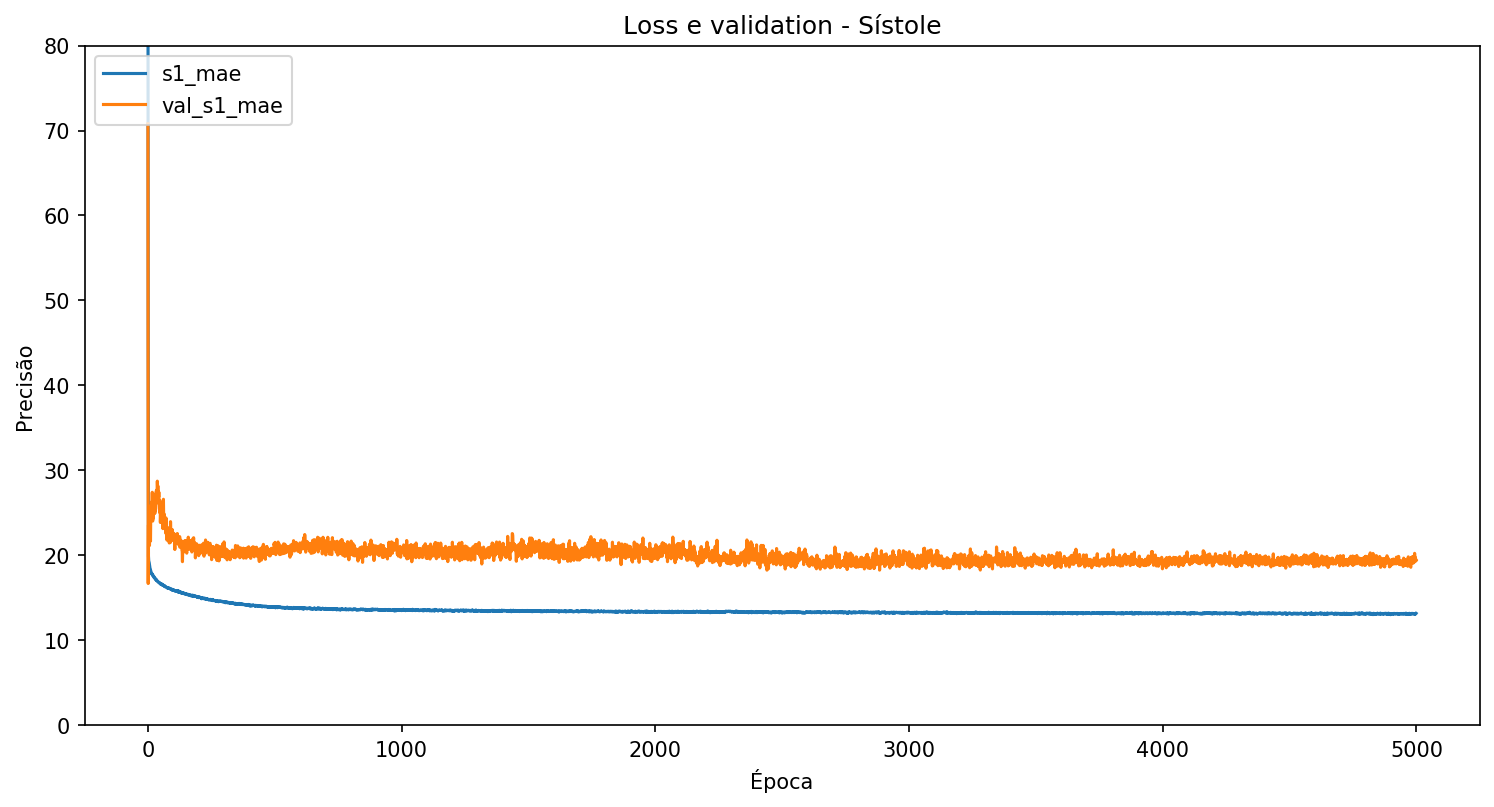

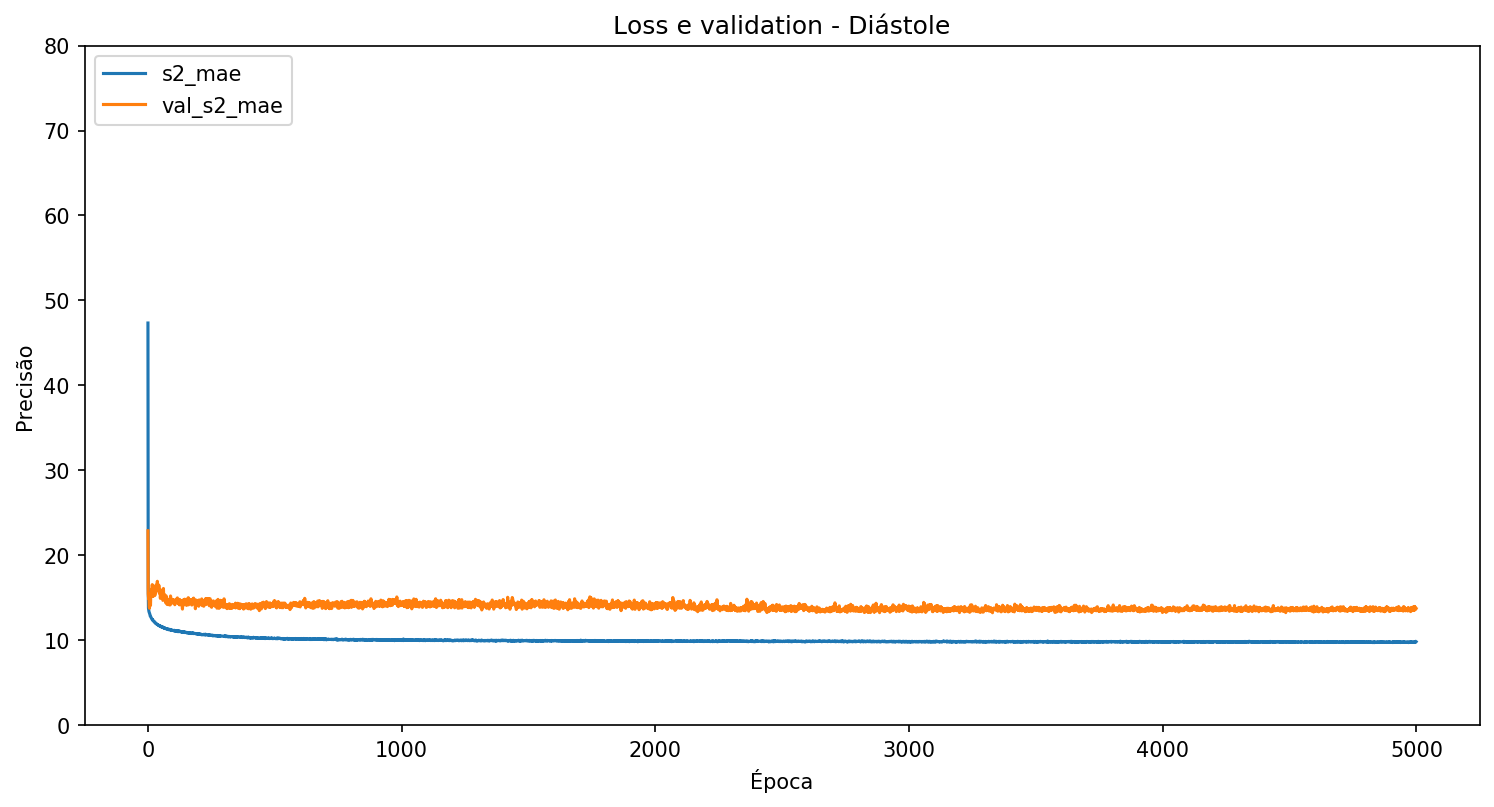

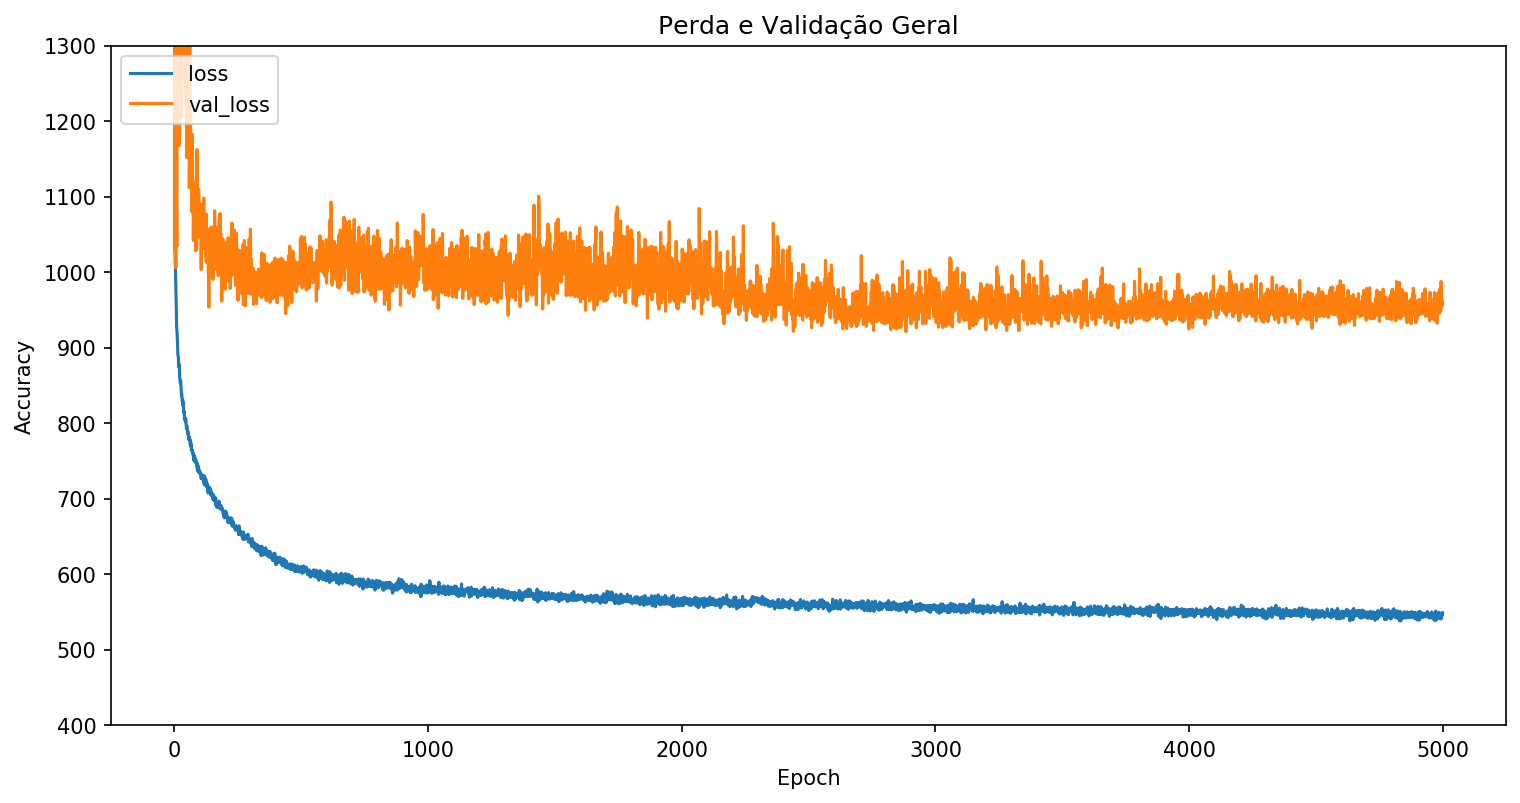

In [22]:
plots_loss_validation(hist)

In [68]:
modelo1 = load_model('modelo_dens_drop_2_segmento100.h5')

pred = np.asarray(modelo1.predict(X_test2))

prev_sis, prev_dias = pred[0][:], pred[1][:]
print_pred(pred[0][:], pred[1][:])

Sistole : Pred -> [111.44987], Real -> [88.] 
Diastole : Pred -> [62.497833], Real -> [50.]

Sistole : Pred -> [111.40032], Real -> [105.] 
Diastole : Pred -> [62.485588], Real -> [54.]

Sistole : Pred -> [111.53826], Real -> [99.] 
Diastole : Pred -> [62.56205], Real -> [60.]

Sistole : Pred -> [111.50672], Real -> [93.] 
Diastole : Pred -> [62.532303], Real -> [54.]

Sistole : Pred -> [111.476135], Real -> [84.] 
Diastole : Pred -> [62.51893], Real -> [48.]

Sistole : Pred -> [111.520615], Real -> [116.] 
Diastole : Pred -> [62.56346], Real -> [66.]

Sistole : Pred -> [111.39127], Real -> [104.] 
Diastole : Pred -> [62.469345], Real -> [63.]

Sistole : Pred -> [111.43652], Real -> [75.] 
Diastole : Pred -> [62.48215], Real -> [45.]

Sistole : Pred -> [111.496086], Real -> [118.] 
Diastole : Pred -> [62.554268], Real -> [62.]

Sistole : Pred -> [111.40614], Real -> [100.] 
Diastole : Pred -> [62.488308], Real -> [59.]



In [69]:
print("MAE de Sistole {0} - Diástole {1}".format(percent_mean_absolute_error(y_sis_test2, prev_sis), \
                                                  percent_mean_absolute_error(y_dias_test2, prev_dias)))

MAE de Sistole 14.946745055951988 - Diástole 20.230656449245018


### Modelo 2 - Camadas Convolutivas (Conv1D)

In [52]:
# reshape nos dados de treino
X_train = X_train.reshape(-1, seg, 1)
X_test = X_test.reshape(-1, seg, 1)
input_shape = (X_train.shape[1], X_train.shape[2])
input_shape

(100, 1)

In [78]:
def model_conv1d(input_shape):
    inp = Input(shape=input_shape, name = 'input_layer')
    conv = Conv1D(filters=32, kernel_size=3, dilation_rate=2, activation='relu', name = 'conv1')(inp)
    conv = Conv1D(filters=16, kernel_size=3, dilation_rate=2, activation='relu', name = 'conv2')(conv)
    max_pool = GlobalMaxPooling1D(name = 'global_max_pool')(conv)
    # We add a vanilla hidden layer
    h1 = Dense(50, name = 'h1')(max_pool)
    act1 = Activation('relu', name = 'act1')(h1)
    drop =  Dropout(0.2, name = 'drop')(act1)
    
    h2 = Dense(units=1,activation='linear', name = 's1')(drop)
    h3 = Dense(units=1,activation='linear', name = 's2')(drop)
    
    model = Model(inputs = inp, outputs = [h2,h3], name = 'Modelo_Conv1D')
    model.compile(optimizer='adam', loss = 'mae', metrics=['mae'])
    model.summary()
    return model

In [79]:
model = model_conv1d(input_shape)

Model: "Modelo_Conv1D"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 96, 32)       128         input_layer[0][0]                
__________________________________________________________________________________________________
conv2 (Conv1D)                  (None, 92, 16)       1552        conv1[0][0]                      
__________________________________________________________________________________________________
global_max_pool (GlobalMaxPooli (None, 16)           0           conv2[0][0]                      
______________________________________________________________________________________

In [80]:
nome_modelo = "modelo_conv1d_2_seg100.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=nome_modelo,
                                                 save_best_only=True,
                                                 verbose=1)
hist2 = model.fit(x = X_train, y = [y_sis_train, y_dias_train],
          epochs=1000, 
          batch_size=128,
          validation_data = (X_test, [y_sis_test, y_dias_test]),
          callbacks = [cp_callback],
          verbose = 1)

Train on 93732 samples, validate on 23433 samples
Epoch 1/1000
93440/93732 [============================>.] - ETA: 0s - loss: 64.3235 - s1_loss: 40.7027 - s2_loss: 23.6209 - s1_mae: 40.7027 - s2_mae: 23.6209
Epoch 00001: val_loss improved from inf to 29.46600, saving model to modelo_conv1d_2_seg100.h5
93732/93732 [==============================] - 5s 57us/sample - loss: 64.2272 - s1_loss: 40.6177 - s2_loss: 23.5797 - s1_mae: 40.6379 - s2_mae: 23.5893 - val_loss: 29.4660 - val_s1_loss: 16.5191 - val_s2_loss: 12.8886 - val_s1_mae: 16.5590 - val_s2_mae: 12.9070
Epoch 2/1000
92672/93732 [============================>.] - ETA: 0s - loss: 33.8516 - s1_loss: 19.8878 - s2_loss: 13.9638 - s1_mae: 19.8878 - s2_mae: 13.9638
Epoch 00002: val_loss improved from 29.46600 to 29.42670, saving model to modelo_conv1d_2_seg100.h5
93732/93732 [==============================] - 4s 43us/sample - loss: 33.8475 - s1_loss: 19.8851 - s2_loss: 13.9576 - s1_mae: 19.8873 - s2_mae: 13.9602 - val_loss: 29.4267 - val

93568/93732 [============================>.] - ETA: 0s - loss: 30.9343 - s1_loss: 18.0892 - s2_loss: 12.8452 - s1_mae: 18.0892 - s2_mae: 12.8452
Epoch 00017: val_loss improved from 28.08210 to 27.72382, saving model to modelo_conv1d_2_seg100.h5
93732/93732 [==============================] - 4s 41us/sample - loss: 30.9299 - s1_loss: 18.0809 - s2_loss: 12.8425 - s1_mae: 18.0860 - s2_mae: 12.8439 - val_loss: 27.7238 - val_s1_loss: 15.6649 - val_s2_loss: 11.9964 - val_s1_mae: 15.7030 - val_s2_mae: 12.0208
Epoch 18/1000
93568/93732 [============================>.] - ETA: 0s - loss: 30.5530 - s1_loss: 17.8726 - s2_loss: 12.6805 - s1_mae: 17.8726 - s2_mae: 12.6805
Epoch 00018: val_loss improved from 27.72382 to 27.16385, saving model to modelo_conv1d_2_seg100.h5
93732/93732 [==============================] - 4s 41us/sample - loss: 30.5524 - s1_loss: 17.8736 - s2_loss: 12.6806 - s1_mae: 17.8718 - s2_mae: 12.6806 - val_loss: 27.1638 - val_s1_loss: 15.4112 - val_s2_loss: 11.6978 - val_s1_mae: 15

Epoch 50/1000
92672/93732 [============================>.] - ETA: 0s - loss: 26.5294 - s1_loss: 15.9644 - s2_loss: 10.5649 - s1_mae: 15.9644 - s2_mae: 10.5649
Epoch 00050: val_loss improved from 24.24067 to 24.19888, saving model to modelo_conv1d_2_seg100.h5
93732/93732 [==============================] - 4s 41us/sample - loss: 26.5187 - s1_loss: 15.9612 - s2_loss: 10.5575 - s1_mae: 15.9605 - s2_mae: 10.5582 - val_loss: 24.1989 - val_s1_loss: 14.3736 - val_s2_loss: 9.8046 - val_s1_mae: 14.3842 - val_s2_mae: 9.8147
Epoch 51/1000
92416/93732 [============================>.] - ETA: 0s - loss: 26.5257 - s1_loss: 15.9669 - s2_loss: 10.5588 - s1_mae: 15.9669 - s2_mae: 10.5588
Epoch 00051: val_loss did not improve from 24.19888
93732/93732 [==============================] - 4s 40us/sample - loss: 26.5351 - s1_loss: 15.9782 - s2_loss: 10.5610 - s1_mae: 15.9747 - s2_mae: 10.5604 - val_loss: 24.2660 - val_s1_loss: 14.5069 - val_s2_loss: 9.7373 - val_s1_mae: 14.5198 - val_s2_mae: 9.7462
Epoch 52/1

Epoch 67/1000
93696/93732 [============================>.] - ETA: 0s - loss: 25.8355 - s1_loss: 15.6068 - s2_loss: 10.2287 - s1_mae: 15.6068 - s2_mae: 10.2287
Epoch 00067: val_loss did not improve from 23.69520
93732/93732 [==============================] - 4s 41us/sample - loss: 25.8321 - s1_loss: 15.5992 - s2_loss: 10.2242 - s1_mae: 15.6047 - s2_mae: 10.2274 - val_loss: 23.8935 - val_s1_loss: 14.1995 - val_s2_loss: 9.6696 - val_s1_mae: 14.2120 - val_s2_mae: 9.6815
Epoch 68/1000
92416/93732 [============================>.] - ETA: 0s - loss: 25.7774 - s1_loss: 15.5491 - s2_loss: 10.2283 - s1_mae: 15.5491 - s2_mae: 10.2283
Epoch 00068: val_loss improved from 23.69520 to 23.64049, saving model to modelo_conv1d_2_seg100.h5
93732/93732 [==============================] - 4s 40us/sample - loss: 25.7722 - s1_loss: 15.5486 - s2_loss: 10.2263 - s1_mae: 15.5472 - s2_mae: 10.2250 - val_loss: 23.6405 - val_s1_loss: 14.1448 - val_s2_loss: 9.4849 - val_s1_mae: 14.1518 - val_s2_mae: 9.4887
Epoch 69/1

Epoch 84/1000
93568/93732 [============================>.] - ETA: 0s - loss: 25.3052 - s1_loss: 15.3169 - s2_loss: 9.9883 - s1_mae: 15.3169 - s2_mae: 9.9883
Epoch 00084: val_loss did not improve from 23.41763
93732/93732 [==============================] - 4s 41us/sample - loss: 25.3036 - s1_loss: 15.3134 - s2_loss: 9.9872 - s1_mae: 15.3160 - s2_mae: 9.9877 - val_loss: 23.6545 - val_s1_loss: 14.1790 - val_s2_loss: 9.4484 - val_s1_mae: 14.1969 - val_s2_mae: 9.4575
Epoch 85/1000
93696/93732 [============================>.] - ETA: 0s - loss: 25.2615 - s1_loss: 15.2845 - s2_loss: 9.9770 - s1_mae: 15.2845 - s2_mae: 9.9770
Epoch 00085: val_loss did not improve from 23.41763
93732/93732 [==============================] - 4s 41us/sample - loss: 25.2624 - s1_loss: 15.2876 - s2_loss: 9.9771 - s1_mae: 15.2854 - s2_mae: 9.9770 - val_loss: 23.4924 - val_s1_loss: 14.0835 - val_s2_loss: 9.4011 - val_s1_mae: 14.0900 - val_s2_mae: 9.4024
Epoch 86/1000
93312/93732 [============================>.] - ETA: 

93312/93732 [============================>.] - ETA: 0s - loss: 24.4500 - s1_loss: 14.7939 - s2_loss: 9.6561 - s1_mae: 14.7939 - s2_mae: 9.6561
Epoch 00118: val_loss did not improve from 22.84441
93732/93732 [==============================] - 4s 41us/sample - loss: 24.4522 - s1_loss: 14.7987 - s2_loss: 9.6559 - s1_mae: 14.7965 - s2_mae: 9.6557 - val_loss: 22.9452 - val_s1_loss: 13.7368 - val_s2_loss: 9.1936 - val_s1_mae: 13.7430 - val_s2_mae: 9.2022
Epoch 119/1000
93184/93732 [============================>.] - ETA: 0s - loss: 24.4073 - s1_loss: 14.7522 - s2_loss: 9.6552 - s1_mae: 14.7522 - s2_mae: 9.6552
Epoch 00119: val_loss did not improve from 22.84441
93732/93732 [==============================] - 4s 41us/sample - loss: 24.4114 - s1_loss: 14.7529 - s2_loss: 9.6557 - s1_mae: 14.7545 - s2_mae: 9.6569 - val_loss: 22.9515 - val_s1_loss: 13.7590 - val_s2_loss: 9.1821 - val_s1_mae: 13.7613 - val_s2_mae: 9.1902
Epoch 120/1000
92928/93732 [============================>.] - ETA: 0s - loss: 2

Epoch 135/1000
93568/93732 [============================>.] - ETA: 0s - loss: 24.0794 - s1_loss: 14.5637 - s2_loss: 9.5156 - s1_mae: 14.5637 - s2_mae: 9.5156
Epoch 00135: val_loss did not improve from 22.50573
93732/93732 [==============================] - 4s 40us/sample - loss: 24.0797 - s1_loss: 14.5642 - s2_loss: 9.5178 - s1_mae: 14.5634 - s2_mae: 9.5162 - val_loss: 22.5098 - val_s1_loss: 13.5408 - val_s2_loss: 8.9626 - val_s1_mae: 13.5432 - val_s2_mae: 8.9665
Epoch 136/1000
93184/93732 [============================>.] - ETA: 0s - loss: 24.0657 - s1_loss: 14.5558 - s2_loss: 9.5098 - s1_mae: 14.5558 - s2_mae: 9.5098
Epoch 00136: val_loss did not improve from 22.50573
93732/93732 [==============================] - 4s 41us/sample - loss: 24.0674 - s1_loss: 14.5592 - s2_loss: 9.5089 - s1_mae: 14.5583 - s2_mae: 9.5091 - val_loss: 22.6356 - val_s1_loss: 13.6073 - val_s2_loss: 9.0141 - val_s1_mae: 13.6138 - val_s2_mae: 9.0219
Epoch 137/1000
93312/93732 [============================>.] - ET

93696/93732 [============================>.] - ETA: 0s - loss: 23.4347 - s1_loss: 14.1748 - s2_loss: 9.2599 - s1_mae: 14.1748 - s2_mae: 9.2599
Epoch 00169: val_loss did not improve from 22.04547
93732/93732 [==============================] - 4s 41us/sample - loss: 23.4348 - s1_loss: 14.1764 - s2_loss: 9.2587 - s1_mae: 14.1752 - s2_mae: 9.2596 - val_loss: 22.0525 - val_s1_loss: 13.3115 - val_s2_loss: 8.7426 - val_s1_mae: 13.3118 - val_s2_mae: 8.7408
Epoch 170/1000
93440/93732 [============================>.] - ETA: 0s - loss: 23.4417 - s1_loss: 14.1810 - s2_loss: 9.2607 - s1_mae: 14.1810 - s2_mae: 9.2607
Epoch 00170: val_loss did not improve from 22.04547
93732/93732 [==============================] - 4s 41us/sample - loss: 23.4398 - s1_loss: 14.1798 - s2_loss: 9.2601 - s1_mae: 14.1799 - s2_mae: 9.2599 - val_loss: 22.2052 - val_s1_loss: 13.4064 - val_s2_loss: 8.8111 - val_s1_mae: 13.4024 - val_s2_mae: 8.8028
Epoch 171/1000
93440/93732 [============================>.] - ETA: 0s - loss: 2

93184/93732 [============================>.] - ETA: 0s - loss: 22.8543 - s1_loss: 13.8341 - s2_loss: 9.0201 - s1_mae: 13.8341 - s2_mae: 9.0201
Epoch 00203: val_loss did not improve from 21.63887
93732/93732 [==============================] - 4s 41us/sample - loss: 22.8514 - s1_loss: 13.8277 - s2_loss: 9.0197 - s1_mae: 13.8309 - s2_mae: 9.0205 - val_loss: 21.9150 - val_s1_loss: 13.1806 - val_s2_loss: 8.7374 - val_s1_mae: 13.1796 - val_s2_mae: 8.7354
Epoch 204/1000
92672/93732 [============================>.] - ETA: 0s - loss: 22.8544 - s1_loss: 13.8425 - s2_loss: 9.0119 - s1_mae: 13.8425 - s2_mae: 9.0119
Epoch 00204: val_loss did not improve from 21.63887
93732/93732 [==============================] - 4s 40us/sample - loss: 22.8437 - s1_loss: 13.8341 - s2_loss: 9.0099 - s1_mae: 13.8344 - s2_mae: 9.0093 - val_loss: 21.6675 - val_s1_loss: 13.0770 - val_s2_loss: 8.5863 - val_s1_mae: 13.0811 - val_s2_mae: 8.5863
Epoch 205/1000
93312/93732 [============================>.] - ETA: 0s - loss: 2

92416/93732 [============================>.] - ETA: 0s - loss: 22.3469 - s1_loss: 13.5115 - s2_loss: 8.8354 - s1_mae: 13.5115 - s2_mae: 8.8354
Epoch 00237: val_loss did not improve from 21.34710
93732/93732 [==============================] - 4s 41us/sample - loss: 22.3368 - s1_loss: 13.5050 - s2_loss: 8.8309 - s1_mae: 13.5047 - s2_mae: 8.8321 - val_loss: 21.5697 - val_s1_loss: 13.0318 - val_s2_loss: 8.5275 - val_s1_mae: 13.0380 - val_s2_mae: 8.5316
Epoch 238/1000
93696/93732 [============================>.] - ETA: 0s - loss: 22.3074 - s1_loss: 13.4861 - s2_loss: 8.8213 - s1_mae: 13.4861 - s2_mae: 8.8213
Epoch 00238: val_loss improved from 21.34710 to 21.29042, saving model to modelo_conv1d_2_seg100.h5
93732/93732 [==============================] - 4s 41us/sample - loss: 22.3064 - s1_loss: 13.4836 - s2_loss: 8.8203 - s1_mae: 13.4854 - s2_mae: 8.8210 - val_loss: 21.2904 - val_s1_loss: 12.9254 - val_s2_loss: 8.3719 - val_s1_mae: 12.9225 - val_s2_mae: 8.3679
Epoch 239/1000
93312/93732 [===

92928/93732 [============================>.] - ETA: 0s - loss: 21.9273 - s1_loss: 13.2133 - s2_loss: 8.7140 - s1_mae: 13.2133 - s2_mae: 8.7140
Epoch 00271: val_loss did not improve from 20.98723
93732/93732 [==============================] - 4s 41us/sample - loss: 21.9090 - s1_loss: 13.2005 - s2_loss: 8.7067 - s1_mae: 13.2018 - s2_mae: 8.7072 - val_loss: 21.1198 - val_s1_loss: 12.7305 - val_s2_loss: 8.3837 - val_s1_mae: 12.7330 - val_s2_mae: 8.3868
Epoch 272/1000
93696/93732 [============================>.] - ETA: 0s - loss: 21.8682 - s1_loss: 13.1820 - s2_loss: 8.6862 - s1_mae: 13.1820 - s2_mae: 8.6862
Epoch 00272: val_loss did not improve from 20.98723
93732/93732 [==============================] - 4s 43us/sample - loss: 21.8670 - s1_loss: 13.1794 - s2_loss: 8.6844 - s1_mae: 13.1813 - s2_mae: 8.6857 - val_loss: 21.1461 - val_s1_loss: 12.7705 - val_s2_loss: 8.3817 - val_s1_mae: 12.7665 - val_s2_mae: 8.3796
Epoch 273/1000
92672/93732 [============================>.] - ETA: 0s - loss: 2

Epoch 289/1000
92800/93732 [============================>.] - ETA: 0s - loss: 21.7345 - s1_loss: 13.0900 - s2_loss: 8.6445 - s1_mae: 13.0900 - s2_mae: 8.6445
Epoch 00289: val_loss improved from 20.96969 to 20.93281, saving model to modelo_conv1d_2_seg100.h5
93732/93732 [==============================] - 4s 41us/sample - loss: 21.7357 - s1_loss: 13.0884 - s2_loss: 8.6446 - s1_mae: 13.0901 - s2_mae: 8.6456 - val_loss: 20.9328 - val_s1_loss: 12.6471 - val_s2_loss: 8.2907 - val_s1_mae: 12.6453 - val_s2_mae: 8.2875
Epoch 290/1000
93056/93732 [============================>.] - ETA: 0s - loss: 21.7397 - s1_loss: 13.1015 - s2_loss: 8.6382 - s1_mae: 13.1015 - s2_mae: 8.6382
Epoch 00290: val_loss did not improve from 20.93281
93732/93732 [==============================] - 4s 41us/sample - loss: 21.7395 - s1_loss: 13.1035 - s2_loss: 8.6392 - s1_mae: 13.1010 - s2_mae: 8.6385 - val_loss: 20.9922 - val_s1_loss: 12.6111 - val_s2_loss: 8.3703 - val_s1_mae: 12.6172 - val_s2_mae: 8.3750
Epoch 291/1000
9

93056/93732 [============================>.] - ETA: 0s - loss: 21.4257 - s1_loss: 12.8893 - s2_loss: 8.5364 - s1_mae: 12.8893 - s2_mae: 8.5364
Epoch 00323: val_loss did not improve from 20.74068
93732/93732 [==============================] - 4s 41us/sample - loss: 21.4240 - s1_loss: 12.8853 - s2_loss: 8.5317 - s1_mae: 12.8896 - s2_mae: 8.5344 - val_loss: 20.8327 - val_s1_loss: 12.5321 - val_s2_loss: 8.2987 - val_s1_mae: 12.5324 - val_s2_mae: 8.3003
Epoch 324/1000
93056/93732 [============================>.] - ETA: 0s - loss: 21.3768 - s1_loss: 12.8485 - s2_loss: 8.5283 - s1_mae: 12.8485 - s2_mae: 8.5283
Epoch 00324: val_loss did not improve from 20.74068
93732/93732 [==============================] - 4s 41us/sample - loss: 21.3719 - s1_loss: 12.8422 - s2_loss: 8.5231 - s1_mae: 12.8458 - s2_mae: 8.5260 - val_loss: 20.8478 - val_s1_loss: 12.5446 - val_s2_loss: 8.2962 - val_s1_mae: 12.5479 - val_s2_mae: 8.2998
Epoch 325/1000
92800/93732 [============================>.] - ETA: 0s - loss: 2

Epoch 341/1000
93696/93732 [============================>.] - ETA: 0s - loss: 21.2568 - s1_loss: 12.7835 - s2_loss: 8.4733 - s1_mae: 12.7835 - s2_mae: 8.4733
Epoch 00341: val_loss did not improve from 20.66023
93732/93732 [==============================] - 4s 41us/sample - loss: 21.2588 - s1_loss: 12.7894 - s2_loss: 8.4744 - s1_mae: 12.7852 - s2_mae: 8.4736 - val_loss: 20.6948 - val_s1_loss: 12.4662 - val_s2_loss: 8.2261 - val_s1_mae: 12.4682 - val_s2_mae: 8.2265
Epoch 342/1000
93440/93732 [============================>.] - ETA: 0s - loss: 21.2614 - s1_loss: 12.7927 - s2_loss: 8.4686 - s1_mae: 12.7927 - s2_mae: 8.4686
Epoch 00342: val_loss did not improve from 20.66023
93732/93732 [==============================] - 4s 41us/sample - loss: 21.2677 - s1_loss: 12.7975 - s2_loss: 8.4710 - s1_mae: 12.7966 - s2_mae: 8.4711 - val_loss: 20.6927 - val_s1_loss: 12.4230 - val_s2_loss: 8.2593 - val_s1_mae: 12.4270 - val_s2_mae: 8.2657
Epoch 343/1000
93184/93732 [============================>.] - ET

93056/93732 [============================>.] - ETA: 0s - loss: 21.0282 - s1_loss: 12.6072 - s2_loss: 8.4210 - s1_mae: 12.6072 - s2_mae: 8.4210
Epoch 00375: val_loss did not improve from 20.50448
93732/93732 [==============================] - 4s 41us/sample - loss: 21.0220 - s1_loss: 12.6049 - s2_loss: 8.4182 - s1_mae: 12.6050 - s2_mae: 8.4170 - val_loss: 20.6476 - val_s1_loss: 12.4424 - val_s2_loss: 8.2042 - val_s1_mae: 12.4416 - val_s2_mae: 8.2060
Epoch 376/1000
93056/93732 [============================>.] - ETA: 0s - loss: 21.0028 - s1_loss: 12.5964 - s2_loss: 8.4063 - s1_mae: 12.5964 - s2_mae: 8.4063
Epoch 00376: val_loss did not improve from 20.50448
93732/93732 [==============================] - 4s 41us/sample - loss: 20.9880 - s1_loss: 12.5842 - s2_loss: 8.4015 - s1_mae: 12.5852 - s2_mae: 8.4028 - val_loss: 20.6401 - val_s1_loss: 12.3759 - val_s2_loss: 8.2619 - val_s1_mae: 12.3760 - val_s2_mae: 8.2641
Epoch 377/1000
93056/93732 [============================>.] - ETA: 0s - loss: 2

Epoch 393/1000
93312/93732 [============================>.] - ETA: 0s - loss: 20.8462 - s1_loss: 12.4891 - s2_loss: 8.3571 - s1_mae: 12.4891 - s2_mae: 8.3571
Epoch 00393: val_loss did not improve from 20.45070
93732/93732 [==============================] - 4s 41us/sample - loss: 20.8472 - s1_loss: 12.4899 - s2_loss: 8.3595 - s1_mae: 12.4890 - s2_mae: 8.3582 - val_loss: 20.6846 - val_s1_loss: 12.3826 - val_s2_loss: 8.2958 - val_s1_mae: 12.3874 - val_s2_mae: 8.2972
Epoch 394/1000
93184/93732 [============================>.] - ETA: 0s - loss: 20.7760 - s1_loss: 12.4539 - s2_loss: 8.3222 - s1_mae: 12.4539 - s2_mae: 8.3222
Epoch 00394: val_loss did not improve from 20.45070
93732/93732 [==============================] - 4s 41us/sample - loss: 20.7776 - s1_loss: 12.4501 - s2_loss: 8.3249 - s1_mae: 12.4526 - s2_mae: 8.3250 - val_loss: 20.6463 - val_s1_loss: 12.3833 - val_s2_loss: 8.2515 - val_s1_mae: 12.3891 - val_s2_mae: 8.2572
Epoch 395/1000
92672/93732 [============================>.] - ET

Epoch 411/1000
93312/93732 [============================>.] - ETA: 0s - loss: 20.6303 - s1_loss: 12.3455 - s2_loss: 8.2848 - s1_mae: 12.3455 - s2_mae: 8.2848
Epoch 00411: val_loss did not improve from 20.39423
93732/93732 [==============================] - 4s 41us/sample - loss: 20.6276 - s1_loss: 12.3404 - s2_loss: 8.2828 - s1_mae: 12.3433 - s2_mae: 8.2843 - val_loss: 20.6573 - val_s1_loss: 12.3703 - val_s2_loss: 8.2745 - val_s1_mae: 12.3782 - val_s2_mae: 8.2791
Epoch 412/1000
93056/93732 [============================>.] - ETA: 0s - loss: 20.6741 - s1_loss: 12.3561 - s2_loss: 8.3180 - s1_mae: 12.3561 - s2_mae: 8.3180
Epoch 00412: val_loss did not improve from 20.39423
93732/93732 [==============================] - 4s 41us/sample - loss: 20.6775 - s1_loss: 12.3568 - s2_loss: 8.3186 - s1_mae: 12.3578 - s2_mae: 8.3197 - val_loss: 20.6321 - val_s1_loss: 12.3393 - val_s2_loss: 8.2916 - val_s1_mae: 12.3397 - val_s2_mae: 8.2924
Epoch 413/1000
92928/93732 [============================>.] - ET

Epoch 429/1000
92544/93732 [============================>.] - ETA: 0s - loss: 20.5290 - s1_loss: 12.2530 - s2_loss: 8.2760 - s1_mae: 12.2530 - s2_mae: 8.2760
Epoch 00429: val_loss did not improve from 20.39423
93732/93732 [==============================] - 4s 41us/sample - loss: 20.5322 - s1_loss: 12.2529 - s2_loss: 8.2823 - s1_mae: 12.2526 - s2_mae: 8.2796 - val_loss: 20.6419 - val_s1_loss: 12.2947 - val_s2_loss: 8.3437 - val_s1_mae: 12.2984 - val_s2_mae: 8.3435
Epoch 430/1000
93312/93732 [============================>.] - ETA: 0s - loss: 20.4998 - s1_loss: 12.2265 - s2_loss: 8.2733 - s1_mae: 12.2265 - s2_mae: 8.2733
Epoch 00430: val_loss improved from 20.39423 to 20.38520, saving model to modelo_conv1d_2_seg100.h5
93732/93732 [==============================] - 4s 41us/sample - loss: 20.5046 - s1_loss: 12.2307 - s2_loss: 8.2739 - s1_mae: 12.2297 - s2_mae: 8.2749 - val_loss: 20.3852 - val_s1_loss: 12.1779 - val_s2_loss: 8.2039 - val_s1_mae: 12.1784 - val_s2_mae: 8.2068
Epoch 431/1000
9

Epoch 446/1000
92800/93732 [============================>.] - ETA: 0s - loss: 20.3550 - s1_loss: 12.1311 - s2_loss: 8.2240 - s1_mae: 12.1311 - s2_mae: 8.2240
Epoch 00446: val_loss did not improve from 20.15539
93732/93732 [==============================] - 4s 41us/sample - loss: 20.3545 - s1_loss: 12.1316 - s2_loss: 8.2213 - s1_mae: 12.1308 - s2_mae: 8.2237 - val_loss: 20.3123 - val_s1_loss: 12.1239 - val_s2_loss: 8.1750 - val_s1_mae: 12.1328 - val_s2_mae: 8.1795
Epoch 447/1000
92928/93732 [============================>.] - ETA: 0s - loss: 20.3083 - s1_loss: 12.0921 - s2_loss: 8.2162 - s1_mae: 12.0921 - s2_mae: 8.2162
Epoch 00447: val_loss did not improve from 20.15539
93732/93732 [==============================] - 4s 41us/sample - loss: 20.3062 - s1_loss: 12.0910 - s2_loss: 8.2130 - s1_mae: 12.0924 - s2_mae: 8.2138 - val_loss: 20.2579 - val_s1_loss: 12.0746 - val_s2_loss: 8.1665 - val_s1_mae: 12.0836 - val_s2_mae: 8.1742
Epoch 448/1000
93184/93732 [============================>.] - ET

92672/93732 [============================>.] - ETA: 0s - loss: 20.1035 - s1_loss: 11.9670 - s2_loss: 8.1365 - s1_mae: 11.9670 - s2_mae: 8.1365
Epoch 00480: val_loss did not improve from 19.98520
93732/93732 [==============================] - 4s 41us/sample - loss: 20.0991 - s1_loss: 11.9695 - s2_loss: 8.1343 - s1_mae: 11.9653 - s2_mae: 8.1339 - val_loss: 20.2908 - val_s1_loss: 12.0423 - val_s2_loss: 8.2364 - val_s1_mae: 12.0493 - val_s2_mae: 8.2415
Epoch 481/1000
93056/93732 [============================>.] - ETA: 0s - loss: 20.1054 - s1_loss: 11.9635 - s2_loss: 8.1419 - s1_mae: 11.9635 - s2_mae: 8.1419
Epoch 00481: val_loss did not improve from 19.98520
93732/93732 [==============================] - 4s 41us/sample - loss: 20.0972 - s1_loss: 11.9596 - s2_loss: 8.1376 - s1_mae: 11.9595 - s2_mae: 8.1377 - val_loss: 20.2946 - val_s1_loss: 12.0686 - val_s2_loss: 8.2245 - val_s1_mae: 12.0682 - val_s2_mae: 8.2264
Epoch 482/1000
93056/93732 [============================>.] - ETA: 0s - loss: 2

92800/93732 [============================>.] - ETA: 0s - loss: 19.9158 - s1_loss: 11.8237 - s2_loss: 8.0921 - s1_mae: 11.8237 - s2_mae: 8.0921
Epoch 00514: val_loss improved from 19.94316 to 19.94029, saving model to modelo_conv1d_2_seg100.h5
93732/93732 [==============================] - 4s 41us/sample - loss: 19.9173 - s1_loss: 11.8267 - s2_loss: 8.0927 - s1_mae: 11.8258 - s2_mae: 8.0915 - val_loss: 19.9403 - val_s1_loss: 11.8397 - val_s2_loss: 8.0852 - val_s1_mae: 11.8536 - val_s2_mae: 8.0867
Epoch 515/1000
92800/93732 [============================>.] - ETA: 0s - loss: 19.8879 - s1_loss: 11.8075 - s2_loss: 8.0804 - s1_mae: 11.8075 - s2_mae: 8.0804
Epoch 00515: val_loss improved from 19.94029 to 19.90317, saving model to modelo_conv1d_2_seg100.h5
93732/93732 [==============================] - 4s 41us/sample - loss: 19.8812 - s1_loss: 11.8045 - s2_loss: 8.0743 - s1_mae: 11.8059 - s2_mae: 8.0753 - val_loss: 19.9032 - val_s1_loss: 11.8457 - val_s2_loss: 8.0537 - val_s1_mae: 11.8498 - va

93312/93732 [============================>.] - ETA: 0s - loss: 19.8087 - s1_loss: 11.7572 - s2_loss: 8.0515 - s1_mae: 11.7572 - s2_mae: 8.0515
Epoch 00531: val_loss did not improve from 19.71448
93732/93732 [==============================] - 4s 41us/sample - loss: 19.7991 - s1_loss: 11.7522 - s2_loss: 8.0485 - s1_mae: 11.7515 - s2_mae: 8.0476 - val_loss: 19.8307 - val_s1_loss: 11.7551 - val_s2_loss: 8.0637 - val_s1_mae: 11.7651 - val_s2_mae: 8.0656
Epoch 532/1000
92544/93732 [============================>.] - ETA: 0s - loss: 19.8074 - s1_loss: 11.7478 - s2_loss: 8.0595 - s1_mae: 11.7478 - s2_mae: 8.0595
Epoch 00532: val_loss did not improve from 19.71448
93732/93732 [==============================] - 4s 41us/sample - loss: 19.8046 - s1_loss: 11.7488 - s2_loss: 8.0609 - s1_mae: 11.7457 - s2_mae: 8.0588 - val_loss: 19.9591 - val_s1_loss: 11.8744 - val_s2_loss: 8.0760 - val_s1_mae: 11.8815 - val_s2_mae: 8.0776
Epoch 533/1000
92928/93732 [============================>.] - ETA: 0s - loss: 1

92416/93732 [============================>.] - ETA: 0s - loss: 19.6154 - s1_loss: 11.6280 - s2_loss: 7.9873 - s1_mae: 11.6280 - s2_mae: 7.9873
Epoch 00565: val_loss did not improve from 19.31980
93732/93732 [==============================] - 4s 41us/sample - loss: 19.6174 - s1_loss: 11.6282 - s2_loss: 7.9944 - s1_mae: 11.6241 - s2_mae: 7.9933 - val_loss: 19.3341 - val_s1_loss: 11.4381 - val_s2_loss: 7.8908 - val_s1_mae: 11.4415 - val_s2_mae: 7.8926
Epoch 566/1000
93184/93732 [============================>.] - ETA: 0s - loss: 19.6348 - s1_loss: 11.6366 - s2_loss: 7.9982 - s1_mae: 11.6366 - s2_mae: 7.9982
Epoch 00566: val_loss did not improve from 19.31980
93732/93732 [==============================] - 4s 41us/sample - loss: 19.6386 - s1_loss: 11.6382 - s2_loss: 7.9990 - s1_mae: 11.6389 - s2_mae: 7.9997 - val_loss: 19.9490 - val_s1_loss: 11.9112 - val_s2_loss: 8.0156 - val_s1_mae: 11.9275 - val_s2_mae: 8.0215
Epoch 567/1000
92672/93732 [============================>.] - ETA: 0s - loss: 1

Epoch 583/1000
92928/93732 [============================>.] - ETA: 0s - loss: 19.5463 - s1_loss: 11.5757 - s2_loss: 7.9705 - s1_mae: 11.5757 - s2_mae: 7.9705
Epoch 00583: val_loss improved from 19.29401 to 19.18221, saving model to modelo_conv1d_2_seg100.h5
93732/93732 [==============================] - 4s 41us/sample - loss: 19.5407 - s1_loss: 11.5717 - s2_loss: 7.9675 - s1_mae: 11.5722 - s2_mae: 7.9685 - val_loss: 19.1822 - val_s1_loss: 11.3404 - val_s2_loss: 7.8297 - val_s1_mae: 11.3500 - val_s2_mae: 7.8322
Epoch 584/1000
92672/93732 [============================>.] - ETA: 0s - loss: 19.5894 - s1_loss: 11.6176 - s2_loss: 7.9718 - s1_mae: 11.6176 - s2_mae: 7.9718
Epoch 00584: val_loss did not improve from 19.18221
93732/93732 [==============================] - 4s 41us/sample - loss: 19.5700 - s1_loss: 11.6035 - s2_loss: 7.9638 - s1_mae: 11.6053 - s2_mae: 7.9648 - val_loss: 19.4316 - val_s1_loss: 11.4922 - val_s2_loss: 7.9344 - val_s1_mae: 11.4996 - val_s2_mae: 7.9320
Epoch 585/1000
9

Epoch 601/1000
92672/93732 [============================>.] - ETA: 0s - loss: 19.5129 - s1_loss: 11.5686 - s2_loss: 7.9443 - s1_mae: 11.5686 - s2_mae: 7.9443
Epoch 00601: val_loss did not improve from 19.18221
93732/93732 [==============================] - 4s 41us/sample - loss: 19.4994 - s1_loss: 11.5545 - s2_loss: 7.9378 - s1_mae: 11.5600 - s2_mae: 7.9393 - val_loss: 19.2574 - val_s1_loss: 11.4203 - val_s2_loss: 7.8284 - val_s1_mae: 11.4306 - val_s2_mae: 7.8267
Epoch 602/1000
92928/93732 [============================>.] - ETA: 0s - loss: 19.5346 - s1_loss: 11.5806 - s2_loss: 7.9541 - s1_mae: 11.5806 - s2_mae: 7.9541
Epoch 00602: val_loss did not improve from 19.18221
93732/93732 [==============================] - 4s 41us/sample - loss: 19.5305 - s1_loss: 11.5853 - s2_loss: 7.9522 - s1_mae: 11.5795 - s2_mae: 7.9510 - val_loss: 19.3807 - val_s1_loss: 11.5295 - val_s2_loss: 7.8381 - val_s1_mae: 11.5376 - val_s2_mae: 7.8431
Epoch 603/1000
92672/93732 [============================>.] - ET

Epoch 636/1000
92544/93732 [============================>.] - ETA: 0s - loss: 19.4211 - s1_loss: 11.5079 - s2_loss: 7.9132 - s1_mae: 11.5079 - s2_mae: 7.9132
Epoch 00636: val_loss did not improve from 19.07041
93732/93732 [==============================] - 4s 41us/sample - loss: 19.4271 - s1_loss: 11.5122 - s2_loss: 7.9148 - s1_mae: 11.5121 - s2_mae: 7.9150 - val_loss: 19.2049 - val_s1_loss: 11.3670 - val_s2_loss: 7.8218 - val_s1_mae: 11.3784 - val_s2_mae: 7.8265
Epoch 637/1000
93056/93732 [============================>.] - ETA: 0s - loss: 19.4692 - s1_loss: 11.5459 - s2_loss: 7.9234 - s1_mae: 11.5459 - s2_mae: 7.9234
Epoch 00637: val_loss did not improve from 19.07041
93732/93732 [==============================] - 4s 41us/sample - loss: 19.4679 - s1_loss: 11.5435 - s2_loss: 7.9248 - s1_mae: 11.5440 - s2_mae: 7.9240 - val_loss: 19.2419 - val_s1_loss: 11.4157 - val_s2_loss: 7.8104 - val_s1_mae: 11.4295 - val_s2_mae: 7.8123
Epoch 638/1000
92800/93732 [============================>.] - ET

Epoch 654/1000
92800/93732 [============================>.] - ETA: 0s - loss: 19.3529 - s1_loss: 11.4669 - s2_loss: 7.8860 - s1_mae: 11.4669 - s2_mae: 7.8860
Epoch 00654: val_loss did not improve from 18.98116
93732/93732 [==============================] - 4s 41us/sample - loss: 19.3496 - s1_loss: 11.4610 - s2_loss: 7.8829 - s1_mae: 11.4639 - s2_mae: 7.8856 - val_loss: 19.2152 - val_s1_loss: 11.3279 - val_s2_loss: 7.8665 - val_s1_mae: 11.3417 - val_s2_mae: 7.8736
Epoch 655/1000
93184/93732 [============================>.] - ETA: 0s - loss: 19.3731 - s1_loss: 11.4836 - s2_loss: 7.8895 - s1_mae: 11.4836 - s2_mae: 7.8895
Epoch 00655: val_loss did not improve from 18.98116
93732/93732 [==============================] - 4s 41us/sample - loss: 19.3719 - s1_loss: 11.4817 - s2_loss: 7.8889 - s1_mae: 11.4824 - s2_mae: 7.8895 - val_loss: 19.1769 - val_s1_loss: 11.3582 - val_s2_loss: 7.7980 - val_s1_mae: 11.3702 - val_s2_mae: 7.8068
Epoch 656/1000
92800/93732 [============================>.] - ET

Epoch 672/1000
93056/93732 [============================>.] - ETA: 0s - loss: 19.3062 - s1_loss: 11.4621 - s2_loss: 7.8440 - s1_mae: 11.4621 - s2_mae: 7.8440
Epoch 00672: val_loss did not improve from 18.98116
93732/93732 [==============================] - 4s 41us/sample - loss: 19.3142 - s1_loss: 11.4699 - s2_loss: 7.8464 - s1_mae: 11.4682 - s2_mae: 7.8459 - val_loss: 19.0434 - val_s1_loss: 11.3113 - val_s2_loss: 7.7209 - val_s1_mae: 11.3191 - val_s2_mae: 7.7244
Epoch 673/1000
92544/93732 [============================>.] - ETA: 0s - loss: 19.3432 - s1_loss: 11.4761 - s2_loss: 7.8671 - s1_mae: 11.4761 - s2_mae: 7.8671
Epoch 00673: val_loss did not improve from 18.98116
93732/93732 [==============================] - 4s 41us/sample - loss: 19.3425 - s1_loss: 11.4795 - s2_loss: 7.8669 - s1_mae: 11.4750 - s2_mae: 7.8675 - val_loss: 19.0206 - val_s1_loss: 11.3169 - val_s2_loss: 7.6927 - val_s1_mae: 11.3262 - val_s2_mae: 7.6944
Epoch 674/1000
92928/93732 [============================>.] - ET

Epoch 690/1000
93056/93732 [============================>.] - ETA: 0s - loss: 19.2653 - s1_loss: 11.4261 - s2_loss: 7.8392 - s1_mae: 11.4261 - s2_mae: 7.8392
Epoch 00690: val_loss did not improve from 18.92635
93732/93732 [==============================] - 4s 41us/sample - loss: 19.2738 - s1_loss: 11.4303 - s2_loss: 7.8409 - s1_mae: 11.4315 - s2_mae: 7.8423 - val_loss: 19.0030 - val_s1_loss: 11.2649 - val_s2_loss: 7.7259 - val_s1_mae: 11.2749 - val_s2_mae: 7.7281
Epoch 691/1000
92928/93732 [============================>.] - ETA: 0s - loss: 19.2831 - s1_loss: 11.4167 - s2_loss: 7.8664 - s1_mae: 11.4167 - s2_mae: 7.8664
Epoch 00691: val_loss did not improve from 18.92635
93732/93732 [==============================] - 4s 41us/sample - loss: 19.2723 - s1_loss: 11.4118 - s2_loss: 7.8605 - s1_mae: 11.4100 - s2_mae: 7.8623 - val_loss: 19.0328 - val_s1_loss: 11.2732 - val_s2_loss: 7.7467 - val_s1_mae: 11.2843 - val_s2_mae: 7.7485
Epoch 692/1000
92928/93732 [============================>.] - ET

Epoch 708/1000
93184/93732 [============================>.] - ETA: 0s - loss: 19.2460 - s1_loss: 11.4045 - s2_loss: 7.8415 - s1_mae: 11.4045 - s2_mae: 7.8415
Epoch 00708: val_loss did not improve from 18.89024
93732/93732 [==============================] - 4s 41us/sample - loss: 19.2522 - s1_loss: 11.4070 - s2_loss: 7.8414 - s1_mae: 11.4099 - s2_mae: 7.8422 - val_loss: 19.1136 - val_s1_loss: 11.3651 - val_s2_loss: 7.7333 - val_s1_mae: 11.3762 - val_s2_mae: 7.7374
Epoch 709/1000
92928/93732 [============================>.] - ETA: 0s - loss: 19.2517 - s1_loss: 11.4211 - s2_loss: 7.8306 - s1_mae: 11.4211 - s2_mae: 7.8306
Epoch 00709: val_loss improved from 18.89024 to 18.87456, saving model to modelo_conv1d_2_seg100.h5
93732/93732 [==============================] - 4s 41us/sample - loss: 19.2398 - s1_loss: 11.4091 - s2_loss: 7.8246 - s1_mae: 11.4129 - s2_mae: 7.8269 - val_loss: 18.8746 - val_s1_loss: 11.2173 - val_s2_loss: 7.6479 - val_s1_mae: 11.2240 - val_s2_mae: 7.6505
Epoch 710/1000
9

Epoch 726/1000
92544/93732 [============================>.] - ETA: 0s - loss: 19.2267 - s1_loss: 11.4021 - s2_loss: 7.8246 - s1_mae: 11.4021 - s2_mae: 7.8246
Epoch 00726: val_loss did not improve from 18.87456
93732/93732 [==============================] - 4s 41us/sample - loss: 19.2138 - s1_loss: 11.3932 - s2_loss: 7.8181 - s1_mae: 11.3956 - s2_mae: 7.8182 - val_loss: 18.8807 - val_s1_loss: 11.2524 - val_s2_loss: 7.6162 - val_s1_mae: 11.2605 - val_s2_mae: 7.6201
Epoch 727/1000
92800/93732 [============================>.] - ETA: 0s - loss: 19.2135 - s1_loss: 11.3959 - s2_loss: 7.8176 - s1_mae: 11.3959 - s2_mae: 7.8176
Epoch 00727: val_loss did not improve from 18.87456
93732/93732 [==============================] - 4s 41us/sample - loss: 19.2120 - s1_loss: 11.3964 - s2_loss: 7.8128 - s1_mae: 11.3970 - s2_mae: 7.8151 - val_loss: 19.2668 - val_s1_loss: 11.4607 - val_s2_loss: 7.7791 - val_s1_mae: 11.4749 - val_s2_mae: 7.7919
Epoch 728/1000
92672/93732 [============================>.] - ET

Epoch 761/1000
92800/93732 [============================>.] - ETA: 0s - loss: 19.1459 - s1_loss: 11.3542 - s2_loss: 7.7917 - s1_mae: 11.3542 - s2_mae: 7.7917
Epoch 00761: val_loss did not improve from 18.72772
93732/93732 [==============================] - 4s 41us/sample - loss: 19.1413 - s1_loss: 11.3527 - s2_loss: 7.7891 - s1_mae: 11.3520 - s2_mae: 7.7892 - val_loss: 19.1050 - val_s1_loss: 11.3694 - val_s2_loss: 7.7234 - val_s1_mae: 11.3766 - val_s2_mae: 7.7284
Epoch 762/1000
92416/93732 [============================>.] - ETA: 0s - loss: 19.1253 - s1_loss: 11.3506 - s2_loss: 7.7747 - s1_mae: 11.3506 - s2_mae: 7.7747
Epoch 00762: val_loss did not improve from 18.72772
93732/93732 [==============================] - 4s 41us/sample - loss: 19.1244 - s1_loss: 11.3460 - s2_loss: 7.7765 - s1_mae: 11.3485 - s2_mae: 7.7758 - val_loss: 19.2115 - val_s1_loss: 11.4487 - val_s2_loss: 7.7450 - val_s1_mae: 11.4592 - val_s2_mae: 7.7522
Epoch 763/1000
92672/93732 [============================>.] - ET

Epoch 779/1000
92544/93732 [============================>.] - ETA: 0s - loss: 19.0994 - s1_loss: 11.3332 - s2_loss: 7.7662 - s1_mae: 11.3332 - s2_mae: 7.7662
Epoch 00779: val_loss did not improve from 18.72772
93732/93732 [==============================] - 4s 41us/sample - loss: 19.0976 - s1_loss: 11.3340 - s2_loss: 7.7630 - s1_mae: 11.3342 - s2_mae: 7.7635 - val_loss: 19.1143 - val_s1_loss: 11.3398 - val_s2_loss: 7.7492 - val_s1_mae: 11.3534 - val_s2_mae: 7.7609
Epoch 780/1000
92928/93732 [============================>.] - ETA: 0s - loss: 19.1250 - s1_loss: 11.3451 - s2_loss: 7.7799 - s1_mae: 11.3451 - s2_mae: 7.7799
Epoch 00780: val_loss did not improve from 18.72772
93732/93732 [==============================] - 4s 41us/sample - loss: 19.1249 - s1_loss: 11.3406 - s2_loss: 7.7796 - s1_mae: 11.3434 - s2_mae: 7.7815 - val_loss: 18.9301 - val_s1_loss: 11.2237 - val_s2_loss: 7.6806 - val_s1_mae: 11.2373 - val_s2_mae: 7.6929
Epoch 781/1000
92800/93732 [============================>.] - ET

Epoch 797/1000
93056/93732 [============================>.] - ETA: 0s - loss: 19.0610 - s1_loss: 11.3096 - s2_loss: 7.7515 - s1_mae: 11.3096 - s2_mae: 7.7515
Epoch 00797: val_loss did not improve from 18.72772
93732/93732 [==============================] - 4s 41us/sample - loss: 19.0596 - s1_loss: 11.3061 - s2_loss: 7.7505 - s1_mae: 11.3087 - s2_mae: 7.7510 - val_loss: 18.8690 - val_s1_loss: 11.1902 - val_s2_loss: 7.6694 - val_s1_mae: 11.1966 - val_s2_mae: 7.6724
Epoch 798/1000
92544/93732 [============================>.] - ETA: 0s - loss: 19.1028 - s1_loss: 11.3368 - s2_loss: 7.7660 - s1_mae: 11.3368 - s2_mae: 7.7660
Epoch 00798: val_loss did not improve from 18.72772
93732/93732 [==============================] - 4s 41us/sample - loss: 19.1041 - s1_loss: 11.3400 - s2_loss: 7.7707 - s1_mae: 11.3364 - s2_mae: 7.7677 - val_loss: 18.8309 - val_s1_loss: 11.2019 - val_s2_loss: 7.6204 - val_s1_mae: 11.2073 - val_s2_mae: 7.6236
Epoch 799/1000
92928/93732 [============================>.] - ET

Epoch 815/1000
92672/93732 [============================>.] - ETA: 0s - loss: 19.0355 - s1_loss: 11.2910 - s2_loss: 7.7445 - s1_mae: 11.2910 - s2_mae: 7.7445
Epoch 00815: val_loss did not improve from 18.68633
93732/93732 [==============================] - 4s 41us/sample - loss: 19.0210 - s1_loss: 11.2809 - s2_loss: 7.7411 - s1_mae: 11.2797 - s2_mae: 7.7413 - val_loss: 18.8544 - val_s1_loss: 11.2350 - val_s2_loss: 7.6109 - val_s1_mae: 11.2407 - val_s2_mae: 7.6137
Epoch 816/1000
92672/93732 [============================>.] - ETA: 0s - loss: 19.0223 - s1_loss: 11.2803 - s2_loss: 7.7420 - s1_mae: 11.2803 - s2_mae: 7.7420
Epoch 00816: val_loss did not improve from 18.68633
93732/93732 [==============================] - 4s 41us/sample - loss: 19.0101 - s1_loss: 11.2730 - s2_loss: 7.7364 - s1_mae: 11.2729 - s2_mae: 7.7372 - val_loss: 18.7698 - val_s1_loss: 11.1192 - val_s2_loss: 7.6252 - val_s1_mae: 11.1335 - val_s2_mae: 7.6363
Epoch 817/1000
93312/93732 [============================>.] - ET

Epoch 833/1000
92800/93732 [============================>.] - ETA: 0s - loss: 19.0113 - s1_loss: 11.2717 - s2_loss: 7.7396 - s1_mae: 11.2717 - s2_mae: 7.7396
Epoch 00833: val_loss did not improve from 18.67640
93732/93732 [==============================] - 4s 41us/sample - loss: 19.0139 - s1_loss: 11.2699 - s2_loss: 7.7409 - s1_mae: 11.2728 - s2_mae: 7.7411 - val_loss: 18.7356 - val_s1_loss: 11.1245 - val_s2_loss: 7.5908 - val_s1_mae: 11.1351 - val_s2_mae: 7.6005
Epoch 834/1000
92416/93732 [============================>.] - ETA: 0s - loss: 18.9762 - s1_loss: 11.2468 - s2_loss: 7.7295 - s1_mae: 11.2468 - s2_mae: 7.7295
Epoch 00834: val_loss did not improve from 18.67640
93732/93732 [==============================] - 4s 41us/sample - loss: 19.0031 - s1_loss: 11.2694 - s2_loss: 7.7384 - s1_mae: 11.2658 - s2_mae: 7.7373 - val_loss: 18.9305 - val_s1_loss: 11.2501 - val_s2_loss: 7.6661 - val_s1_mae: 11.2607 - val_s2_mae: 7.6699
Epoch 835/1000
93312/93732 [============================>.] - ET

Epoch 851/1000
92544/93732 [============================>.] - ETA: 0s - loss: 18.9713 - s1_loss: 11.2495 - s2_loss: 7.7217 - s1_mae: 11.2495 - s2_mae: 7.7217
Epoch 00851: val_loss did not improve from 18.63494
93732/93732 [==============================] - 4s 41us/sample - loss: 18.9686 - s1_loss: 11.2447 - s2_loss: 7.7240 - s1_mae: 11.2459 - s2_mae: 7.7228 - val_loss: 18.7011 - val_s1_loss: 11.1328 - val_s2_loss: 7.5432 - val_s1_mae: 11.1478 - val_s2_mae: 7.5532
Epoch 852/1000
93312/93732 [============================>.] - ETA: 0s - loss: 18.9505 - s1_loss: 11.2285 - s2_loss: 7.7220 - s1_mae: 11.2285 - s2_mae: 7.7220
Epoch 00852: val_loss did not improve from 18.63494
93732/93732 [==============================] - 4s 42us/sample - loss: 18.9545 - s1_loss: 11.2335 - s2_loss: 7.7246 - s1_mae: 11.2312 - s2_mae: 7.7233 - val_loss: 19.2089 - val_s1_loss: 11.4375 - val_s2_loss: 7.7463 - val_s1_mae: 11.4511 - val_s2_mae: 7.7579
Epoch 853/1000
92672/93732 [============================>.] - ET

Epoch 869/1000
93312/93732 [============================>.] - ETA: 0s - loss: 18.9207 - s1_loss: 11.2103 - s2_loss: 7.7104 - s1_mae: 11.2103 - s2_mae: 7.7104
Epoch 00869: val_loss did not improve from 18.63494
93732/93732 [==============================] - 4s 42us/sample - loss: 18.9180 - s1_loss: 11.2091 - s2_loss: 7.7108 - s1_mae: 11.2081 - s2_mae: 7.7099 - val_loss: 18.6762 - val_s1_loss: 11.1235 - val_s2_loss: 7.5412 - val_s1_mae: 11.1294 - val_s2_mae: 7.5469
Epoch 870/1000
92800/93732 [============================>.] - ETA: 0s - loss: 18.8931 - s1_loss: 11.1911 - s2_loss: 7.7020 - s1_mae: 11.1911 - s2_mae: 7.7020
Epoch 00870: val_loss did not improve from 18.63494
93732/93732 [==============================] - 4s 41us/sample - loss: 18.9054 - s1_loss: 11.2034 - s2_loss: 7.7053 - s1_mae: 11.2000 - s2_mae: 7.7054 - val_loss: 18.7064 - val_s1_loss: 11.0671 - val_s2_loss: 7.6162 - val_s1_mae: 11.0792 - val_s2_mae: 7.6272
Epoch 871/1000
92672/93732 [============================>.] - ET

Epoch 887/1000
93184/93732 [============================>.] - ETA: 0s - loss: 18.9051 - s1_loss: 11.1834 - s2_loss: 7.7217 - s1_mae: 11.1834 - s2_mae: 7.7217
Epoch 00887: val_loss did not improve from 18.60268
93732/93732 [==============================] - 4s 41us/sample - loss: 18.9040 - s1_loss: 11.1812 - s2_loss: 7.7225 - s1_mae: 11.1813 - s2_mae: 7.7227 - val_loss: 18.7804 - val_s1_loss: 11.1453 - val_s2_loss: 7.6156 - val_s1_mae: 11.1555 - val_s2_mae: 7.6249
Epoch 888/1000
93056/93732 [============================>.] - ETA: 0s - loss: 18.9140 - s1_loss: 11.1994 - s2_loss: 7.7147 - s1_mae: 11.1994 - s2_mae: 7.7147
Epoch 00888: val_loss did not improve from 18.60268
93732/93732 [==============================] - 4s 41us/sample - loss: 18.9032 - s1_loss: 11.1934 - s2_loss: 7.7093 - s1_mae: 11.1936 - s2_mae: 7.7095 - val_loss: 18.8684 - val_s1_loss: 11.1700 - val_s2_loss: 7.7108 - val_s1_mae: 11.1635 - val_s2_mae: 7.7049
Epoch 889/1000
92800/93732 [============================>.] - ET

Epoch 922/1000
92672/93732 [============================>.] - ETA: 0s - loss: 18.8387 - s1_loss: 11.1292 - s2_loss: 7.7095 - s1_mae: 11.1292 - s2_mae: 7.7095
Epoch 00922: val_loss did not improve from 18.51702
93732/93732 [==============================] - 4s 41us/sample - loss: 18.8402 - s1_loss: 11.1365 - s2_loss: 7.7090 - s1_mae: 11.1313 - s2_mae: 7.7089 - val_loss: 18.7496 - val_s1_loss: 11.1595 - val_s2_loss: 7.5773 - val_s1_mae: 11.1632 - val_s2_mae: 7.5864
Epoch 923/1000
92800/93732 [============================>.] - ETA: 0s - loss: 18.8029 - s1_loss: 11.1238 - s2_loss: 7.6792 - s1_mae: 11.1238 - s2_mae: 7.6792
Epoch 00923: val_loss did not improve from 18.51702
93732/93732 [==============================] - 4s 41us/sample - loss: 18.8065 - s1_loss: 11.1276 - s2_loss: 7.6799 - s1_mae: 11.1270 - s2_mae: 7.6795 - val_loss: 18.9123 - val_s1_loss: 11.1398 - val_s2_loss: 7.7686 - val_s1_mae: 11.1401 - val_s2_mae: 7.7722
Epoch 924/1000
92544/93732 [============================>.] - ET

Epoch 940/1000
92416/93732 [============================>.] - ETA: 0s - loss: 18.7935 - s1_loss: 11.1001 - s2_loss: 7.6933 - s1_mae: 11.1001 - s2_mae: 7.6933
Epoch 00940: val_loss did not improve from 18.51702
93732/93732 [==============================] - 4s 41us/sample - loss: 18.7915 - s1_loss: 11.1048 - s2_loss: 7.6869 - s1_mae: 11.1032 - s2_mae: 7.6884 - val_loss: 18.6714 - val_s1_loss: 11.1086 - val_s2_loss: 7.5513 - val_s1_mae: 11.1160 - val_s2_mae: 7.5555
Epoch 941/1000
93056/93732 [============================>.] - ETA: 0s - loss: 18.7774 - s1_loss: 11.0916 - s2_loss: 7.6858 - s1_mae: 11.0916 - s2_mae: 7.6858
Epoch 00941: val_loss did not improve from 18.51702
93732/93732 [==============================] - 4s 42us/sample - loss: 18.7762 - s1_loss: 11.0944 - s2_loss: 7.6864 - s1_mae: 11.0910 - s2_mae: 7.6853 - val_loss: 18.7173 - val_s1_loss: 11.1971 - val_s2_loss: 7.5222 - val_s1_mae: 11.1968 - val_s2_mae: 7.5205
Epoch 942/1000
93056/93732 [============================>.] - ET

Epoch 958/1000
92800/93732 [============================>.] - ETA: 0s - loss: 18.7473 - s1_loss: 11.0789 - s2_loss: 7.6685 - s1_mae: 11.0789 - s2_mae: 7.6685
Epoch 00958: val_loss did not improve from 18.51702
93732/93732 [==============================] - 4s 41us/sample - loss: 18.7539 - s1_loss: 11.0809 - s2_loss: 7.6708 - s1_mae: 11.0821 - s2_mae: 7.6718 - val_loss: 18.7790 - val_s1_loss: 11.1503 - val_s2_loss: 7.6006 - val_s1_mae: 11.1644 - val_s2_mae: 7.6146
Epoch 959/1000
93056/93732 [============================>.] - ETA: 0s - loss: 18.7871 - s1_loss: 11.1136 - s2_loss: 7.6735 - s1_mae: 11.1136 - s2_mae: 7.6735
Epoch 00959: val_loss did not improve from 18.51702
93732/93732 [==============================] - 4s 41us/sample - loss: 18.7792 - s1_loss: 11.1023 - s2_loss: 7.6736 - s1_mae: 11.1047 - s2_mae: 7.6745 - val_loss: 18.9238 - val_s1_loss: 11.2900 - val_s2_loss: 7.6219 - val_s1_mae: 11.2983 - val_s2_mae: 7.6254
Epoch 960/1000
93440/93732 [============================>.] - ET

Epoch 976/1000
92544/93732 [============================>.] - ETA: 0s - loss: 18.6971 - s1_loss: 11.0512 - s2_loss: 7.6459 - s1_mae: 11.0512 - s2_mae: 7.6459
Epoch 00976: val_loss did not improve from 18.51702
93732/93732 [==============================] - 4s 41us/sample - loss: 18.6987 - s1_loss: 11.0546 - s2_loss: 7.6455 - s1_mae: 11.0539 - s2_mae: 7.6448 - val_loss: 18.9035 - val_s1_loss: 11.2411 - val_s2_loss: 7.6415 - val_s1_mae: 11.2507 - val_s2_mae: 7.6527
Epoch 977/1000
92416/93732 [============================>.] - ETA: 0s - loss: 18.7038 - s1_loss: 11.0443 - s2_loss: 7.6595 - s1_mae: 11.0443 - s2_mae: 7.6595
Epoch 00977: val_loss did not improve from 18.51702
93732/93732 [==============================] - 4s 41us/sample - loss: 18.7119 - s1_loss: 11.0472 - s2_loss: 7.6636 - s1_mae: 11.0477 - s2_mae: 7.6641 - val_loss: 18.6512 - val_s1_loss: 11.1278 - val_s2_loss: 7.5069 - val_s1_mae: 11.1355 - val_s2_mae: 7.5157
Epoch 978/1000
93056/93732 [============================>.] - ET

Epoch 994/1000
92800/93732 [============================>.] - ETA: 0s - loss: 18.6916 - s1_loss: 11.0382 - s2_loss: 7.6533 - s1_mae: 11.0382 - s2_mae: 7.6533
Epoch 00994: val_loss did not improve from 18.51702
93732/93732 [==============================] - 4s 42us/sample - loss: 18.6920 - s1_loss: 11.0379 - s2_loss: 7.6544 - s1_mae: 11.0377 - s2_mae: 7.6543 - val_loss: 18.7133 - val_s1_loss: 11.1601 - val_s2_loss: 7.5364 - val_s1_mae: 11.1649 - val_s2_mae: 7.5484
Epoch 995/1000
92672/93732 [============================>.] - ETA: 0s - loss: 18.6511 - s1_loss: 11.0138 - s2_loss: 7.6373 - s1_mae: 11.0138 - s2_mae: 7.6373
Epoch 00995: val_loss did not improve from 18.51702
93732/93732 [==============================] - 4s 41us/sample - loss: 18.6495 - s1_loss: 11.0114 - s2_loss: 7.6347 - s1_mae: 11.0143 - s2_mae: 7.6352 - val_loss: 19.0738 - val_s1_loss: 11.4205 - val_s2_loss: 7.6389 - val_s1_mae: 11.4270 - val_s2_mae: 7.6468
Epoch 996/1000
92672/93732 [============================>.] - ET

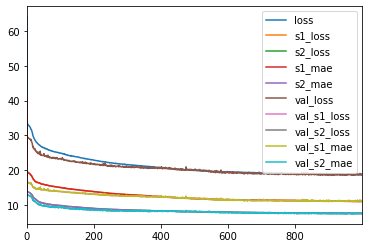

In [81]:
pd.DataFrame(hist2.history).plot()

In [82]:
salvar_historico_modelo('hist_net2_cnn', hist2)

In [28]:
hist2 = ler_historico_modelo('hist_net2_cnn')

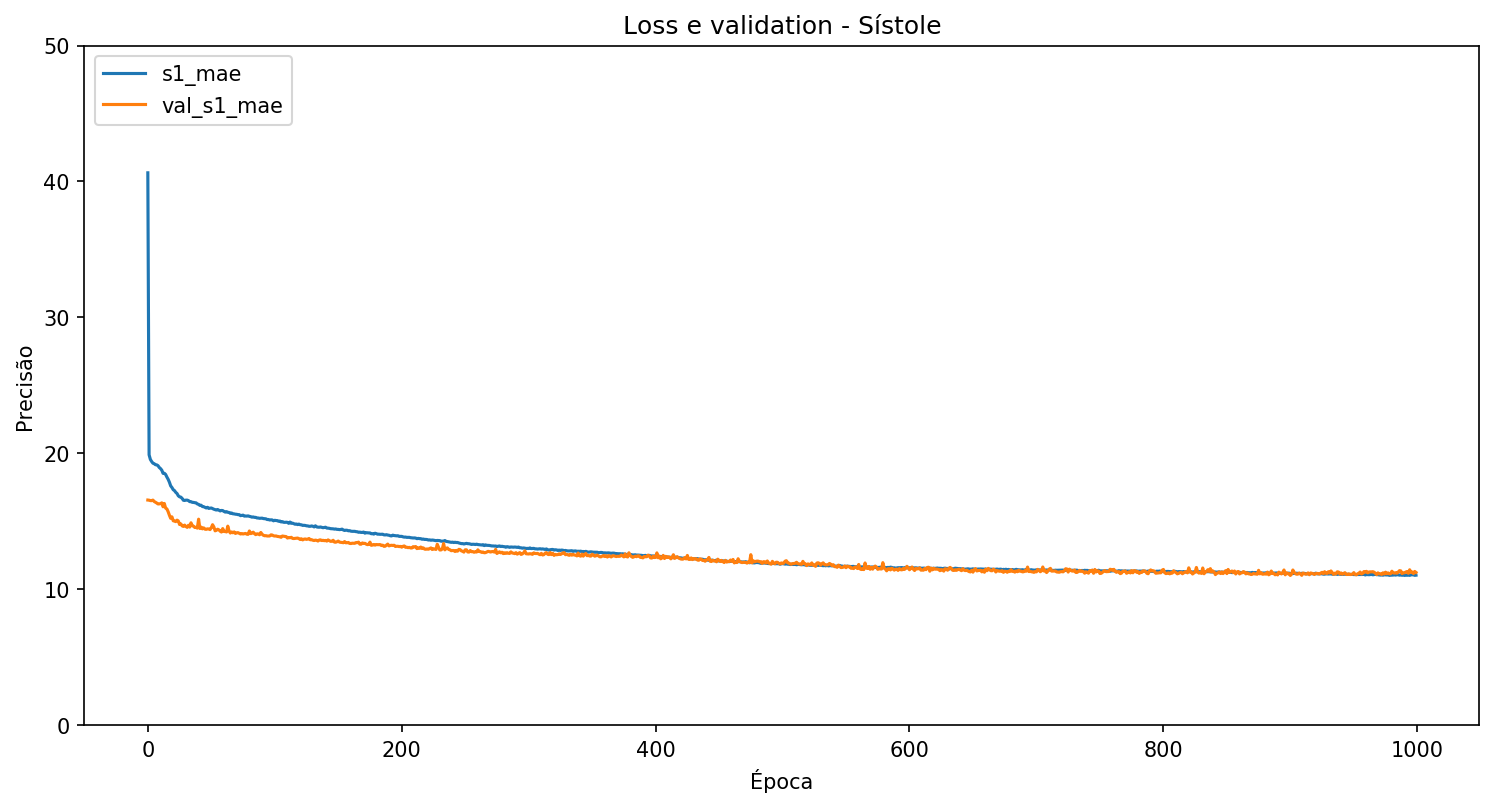

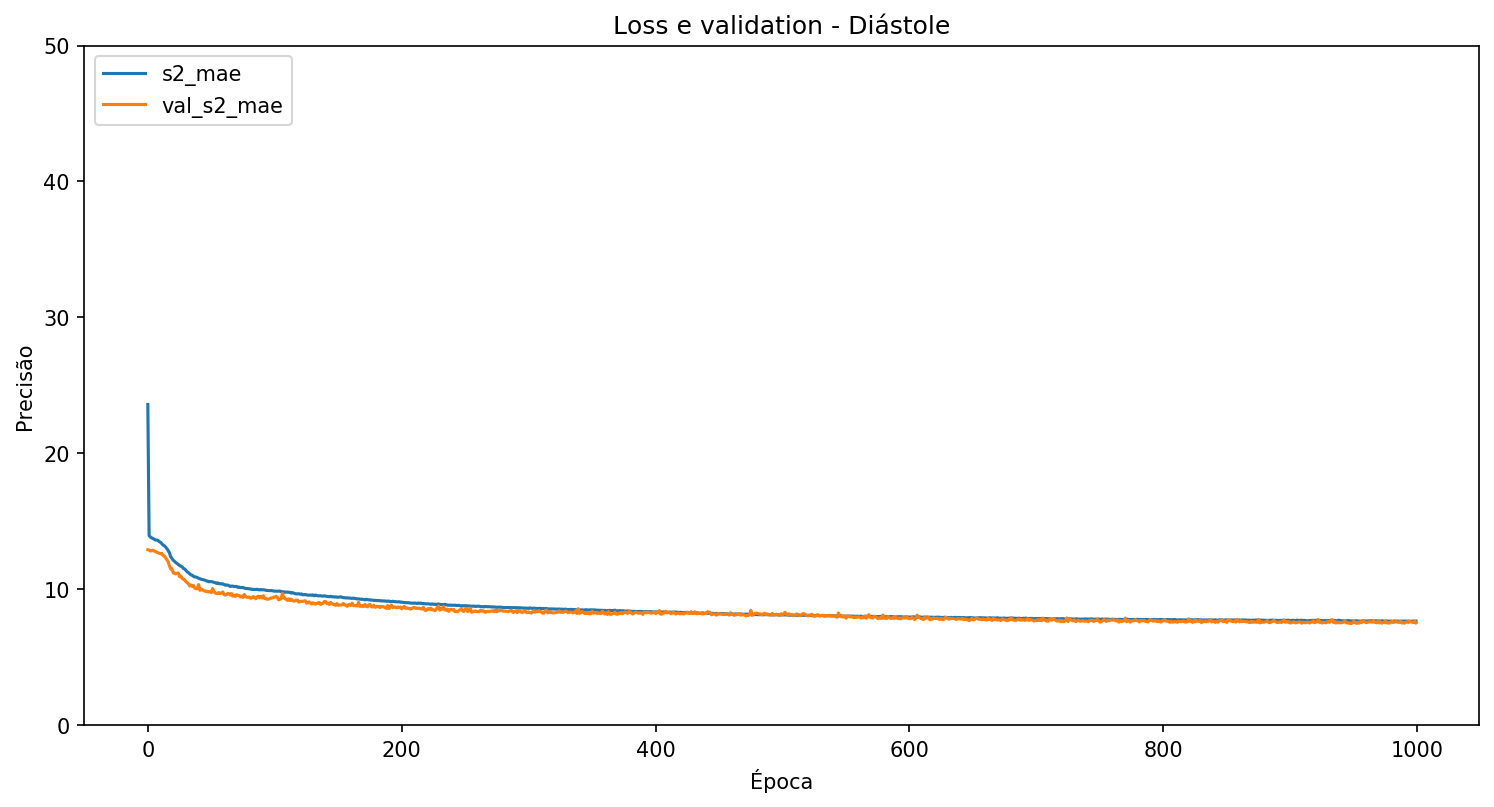

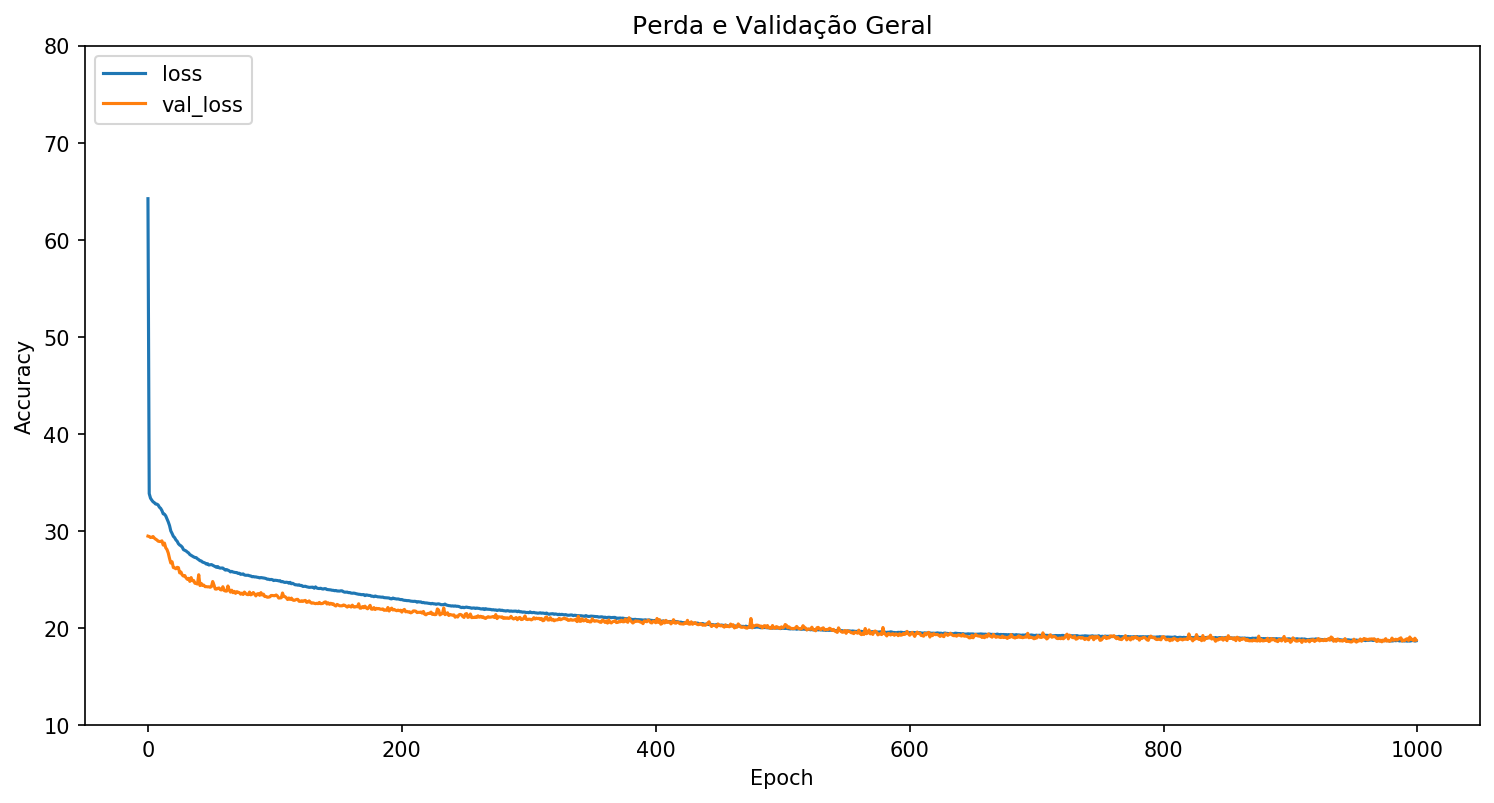

In [29]:
plots_loss_validation(hist2)

## Reshape nos dados de teste

In [66]:
X_test2 = X_test2.reshape(-1, seg, 1)

In [86]:
model2 = load_model("modelo_conv1d_2_seg100.h5")

pred = np.asarray(model2.predict(X_test2))
pred_sis, pred_dias = pred[0][:], pred[1][:]
print_pred(pred[0][:], pred[1][:])

Sistole : Pred -> [93.078766], Real -> [88.] 
Diastole : Pred -> [50.125114], Real -> [50.]

Sistole : Pred -> [99.77803], Real -> [105.] 
Diastole : Pred -> [56.02758], Real -> [54.]

Sistole : Pred -> [101.51929], Real -> [99.] 
Diastole : Pred -> [58.841095], Real -> [60.]

Sistole : Pred -> [92.632706], Real -> [93.] 
Diastole : Pred -> [50.47601], Real -> [54.]

Sistole : Pred -> [91.24244], Real -> [84.] 
Diastole : Pred -> [49.10724], Real -> [48.]

Sistole : Pred -> [97.089325], Real -> [116.] 
Diastole : Pred -> [53.70373], Real -> [66.]

Sistole : Pred -> [99.76786], Real -> [104.] 
Diastole : Pred -> [57.07691], Real -> [63.]

Sistole : Pred -> [92.86712], Real -> [75.] 
Diastole : Pred -> [50.703003], Real -> [45.]

Sistole : Pred -> [100.30173], Real -> [118.] 
Diastole : Pred -> [56.017483], Real -> [62.]

Sistole : Pred -> [90.31356], Real -> [100.] 
Diastole : Pred -> [48.922874], Real -> [59.]



In [88]:
print("MAE de Sistole {0} - Diástole {1}".format(percent_mean_absolute_error(y_sis_test2, pred_sis), \
                                                  percent_mean_absolute_error(y_dias_test2, pred_dias)))

MAE de Sistole 9.6349930572501 - Diástole 10.496611962974798


### Modelo 3 - CRNN

In [89]:
# # adaptade de https://github.com/kurapan/CRNN/blob/master/models.py
# def CRNN(input_shape):
#     inputs = Input(input_shape, name = 'input_layer')
#     c_1 = Conv1D(16, 3, activation='relu', padding='same', name='conv_1')(inputs)
#     c_2 = Conv1D(32, 3, activation='relu', padding='same', name='conv_2')(c_1)

#     bn_3 = BatchNormalization(name='bn_3')(c_2)
#     p_3 = MaxPooling1D(pool_size=2, name='maxpool_3')(bn_3)

#     c_4 = Conv1D(64, 3, activation='relu', padding='same', name='conv_4')(p_3)
#     bn_5 = BatchNormalization(name='bn_5')(c_4)
#     p_5 = MaxPooling1D(pool_size=2, name='maxpool_5')(bn_5)

#     bn_7_shape = p_5.get_shape()
    
#     reshape = Reshape(target_shape=(int(bn_7_shape[1]), int(bn_7_shape[2])), name='reshape')(p_5)

#     fc_9 = Dense(128, activation='relu', name='fc_9')(reshape)

#     lstm_10 = LSTM(100, kernel_initializer="he_normal", return_sequences=True, name='lstm_10')(fc_9)
                                                                                               
#     do_11 = Dropout(0.2, name='dropout')(lstm_10)
#     lstm_11 = LSTM(50, kernel_initializer="he_normal", return_sequences=True, name='lstm_11')(do_11)
    
#     flatten = Flatten(name = 'flatten')(lstm_11)  
#     fc_12 = Dense(1, kernel_initializer='he_normal', activation='linear', name='s1')(flatten)
#     fc_13 = Dense(1, kernel_initializer='he_normal', activation='linear', name='s2')(flatten)

#     prediction_model = Model(inputs=inputs, outputs=[fc_12, fc_13])
#     prediction_model.compile(optimizer='adam', loss = 'mse', metrics=['mse'])
#     prediction_model.summary()
#     return prediction_model

In [101]:
def CRNN2(input_shape):
    inputs = Input(input_shape, name = 'input_layer')
    c_1 = Conv1D(16, 3, activation='relu', padding='same', name='conv_1')(inputs)
    c_2 = Conv1D(32, 3, activation='relu', padding='same', name='conv_2')(c_1)
#     c_3 = Conv1D(64, 3, activation='relu', padding='same', name='conv_3')(c_2)
    bn_3 = BatchNormalization(name='bn_3')(c_2)
    p_3 = MaxPooling1D(pool_size=2, name='maxpool_3')(bn_3)

    c_4 = Conv1D(64, 3, activation='relu', padding='same', name='conv_4')(p_3)
    bn_5 = BatchNormalization(name='bn_5')(c_4)
    p_5 = MaxPooling1D(pool_size=2, name='maxpool_5')(bn_5)

    bn_7_shape = p_5.get_shape()
    reshape = Reshape(target_shape=(int(bn_7_shape[1]), int(bn_7_shape[2])), name='reshape')(p_5)

    fc_9 = Dense(128, activation='relu', name='fc_9')(reshape)

    lstm_10 = LSTM(128, kernel_initializer="he_normal", return_sequences=True, name='lstm_10')(fc_9)

    do_11 = Dropout(0.5, name='dropout')(lstm_10)
    lstm_11 = LSTM(64, kernel_initializer="he_normal", return_sequences=True, name='lstm_11')(do_11)

    do_12 = Dropout(0.5, name='dropout2')(lstm_11)
    lstm_12 = LSTM(32, kernel_initializer="he_normal", name='lstm_12')(do_12)
    flatten = Flatten(name = 'flatten')(lstm_12)  
    fc_12 = Dense(1, kernel_initializer='he_normal', activation='linear', name='s1')(flatten)
    fc_13 = Dense(1, kernel_initializer='he_normal', activation='linear', name='s2')(flatten)

    prediction_model = Model(inputs=inputs, outputs=[fc_12, fc_13])
    prediction_model.compile(optimizer='adam', loss = 'mae', metrics=['mae'])
    prediction_model.summary()
    return prediction_model

In [102]:
model = CRNN2(input_shape)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 100, 16)      64          input_layer[0][0]                
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 100, 32)      1568        conv_1[0][0]                     
__________________________________________________________________________________________________
bn_3 (BatchNormalization)       (None, 100, 32)      128         conv_2[0][0]                     
____________________________________________________________________________________________

In [103]:
nome_modelo = "modelo_CRNN2_3_seg100_500epoc_bs_512.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=nome_modelo,
                                                 save_best_only=True,
                                                 verbose=1)
hist3 = model.fit(x = X_train, y = [y_sis_train, y_dias_train],
          epochs=500, 
          batch_size=512,
          validation_data = (X_test, [y_sis_test, y_dias_test]),
          callbacks = [cp_callback],
          verbose = 1)

Train on 93732 samples, validate on 23433 samples
Epoch 1/500
93696/93732 [============================>.] - ETA: 0s - loss: 154.2094 - s1_loss: 101.9673 - s2_loss: 52.2420 - s1_mae: 101.9673 - s2_mae: 52.2420
Epoch 00001: val_loss improved from inf to 146.85839, saving model to modelo_CRNN2_3_seg100_500epoc_bs_512.h5
93732/93732 [==============================] - 14s 149us/sample - loss: 154.2063 - s1_loss: 101.9466 - s2_loss: 52.2192 - s1_mae: 101.9658 - s2_mae: 52.2404 - val_loss: 146.8584 - val_s1_loss: 98.3334 - val_s2_loss: 48.5198 - val_s1_mae: 98.3373 - val_s2_mae: 48.5211
Epoch 2/500
93696/93732 [============================>.] - ETA: 0s - loss: 140.2028 - s1_loss: 94.9402 - s2_loss: 45.2626 - s1_mae: 94.9402 - s2_mae: 45.2626
Epoch 00002: val_loss improved from 146.85839 to 134.09906, saving model to modelo_CRNN2_3_seg100_500epoc_bs_512.h5
93732/93732 [==============================] - 8s 85us/sample - loss: 140.2002 - s1_loss: 94.9260 - s2_loss: 45.2394 - s1_mae: 94.9392 - s

93696/93732 [============================>.] - ETA: 0s - loss: 29.1164 - s1_loss: 16.3888 - s2_loss: 12.7276 - s1_mae: 16.3888 - s2_mae: 12.7276
Epoch 00032: val_loss improved from 29.49541 to 29.43423, saving model to modelo_CRNN2_3_seg100_500epoc_bs_512.h5
93732/93732 [==============================] - 7s 80us/sample - loss: 29.1175 - s1_loss: 16.4087 - s2_loss: 12.7235 - s1_mae: 16.3902 - s2_mae: 12.7273 - val_loss: 29.4342 - val_s1_loss: 16.5270 - val_s2_loss: 12.9094 - val_s1_mae: 16.5256 - val_s2_mae: 12.9087
Epoch 33/500
93696/93732 [============================>.] - ETA: 0s - loss: 29.0698 - s1_loss: 16.3222 - s2_loss: 12.7475 - s1_mae: 16.3222 - s2_mae: 12.7475
Epoch 00033: val_loss did not improve from 29.43423
93732/93732 [==============================] - 8s 80us/sample - loss: 29.0741 - s1_loss: 16.3600 - s2_loss: 12.7705 - s1_mae: 16.3249 - s2_mae: 12.7492 - val_loss: 29.4345 - val_s1_loss: 16.5282 - val_s2_loss: 12.9086 - val_s1_mae: 16.5267 - val_s2_mae: 12.9078
Epoch 3

Epoch 49/500
93696/93732 [============================>.] - ETA: 0s - loss: 21.3129 - s1_loss: 12.7772 - s2_loss: 8.5358 - s1_mae: 12.7772 - s2_mae: 8.5358
Epoch 00049: val_loss did not improve from 29.42921
93732/93732 [==============================] - 7s 80us/sample - loss: 21.3122 - s1_loss: 12.7696 - s2_loss: 8.5335 - s1_mae: 12.7766 - s2_mae: 8.5356 - val_loss: 34.3657 - val_s1_loss: 19.2784 - val_s2_loss: 15.0908 - val_s1_mae: 19.2761 - val_s2_mae: 15.0896
Epoch 50/500
93696/93732 [============================>.] - ETA: 0s - loss: 20.7591 - s1_loss: 12.4786 - s2_loss: 8.2806 - s1_mae: 12.4786 - s2_mae: 8.2806
Epoch 00050: val_loss did not improve from 29.42921
93732/93732 [==============================] - 8s 80us/sample - loss: 20.7586 - s1_loss: 12.4788 - s2_loss: 8.2728 - s1_mae: 12.4786 - s2_mae: 8.2800 - val_loss: 32.9635 - val_s1_loss: 18.4252 - val_s2_loss: 14.5437 - val_s1_mae: 18.4223 - val_s2_mae: 14.5412
Epoch 51/500
93696/93732 [============================>.] - ETA:

93696/93732 [============================>.] - ETA: 0s - loss: 11.0465 - s1_loss: 6.5398 - s2_loss: 4.5067 - s1_mae: 6.5398 - s2_mae: 4.5067
Epoch 00083: val_loss did not improve from 17.19601
93732/93732 [==============================] - 8s 81us/sample - loss: 11.0457 - s1_loss: 6.5356 - s2_loss: 4.4995 - s1_mae: 6.5395 - s2_mae: 4.5062 - val_loss: 23.7624 - val_s1_loss: 14.2901 - val_s2_loss: 9.4786 - val_s1_mae: 14.2862 - val_s2_mae: 9.4761
Epoch 84/500
93696/93732 [============================>.] - ETA: 0s - loss: 10.9979 - s1_loss: 6.4985 - s2_loss: 4.4994 - s1_mae: 6.4985 - s2_mae: 4.4994
Epoch 00084: val_loss did not improve from 17.19601
93732/93732 [==============================] - 8s 82us/sample - loss: 11.0011 - s1_loss: 6.5284 - s2_loss: 4.5146 - s1_mae: 6.5006 - s2_mae: 4.5005 - val_loss: 24.0660 - val_s1_loss: 14.6669 - val_s2_loss: 9.4115 - val_s1_mae: 14.6566 - val_s2_mae: 9.4094
Epoch 85/500
93696/93732 [============================>.] - ETA: 0s - loss: 10.9409 - s1_

Epoch 101/500
93696/93732 [============================>.] - ETA: 0s - loss: 9.6957 - s1_loss: 5.5648 - s2_loss: 4.1309 - s1_mae: 5.5648 - s2_mae: 4.1309
Epoch 00101: val_loss improved from 13.48436 to 12.63662, saving model to modelo_CRNN2_3_seg100_500epoc_bs_512.h5
93732/93732 [==============================] - 7s 80us/sample - loss: 9.6967 - s1_loss: 5.5721 - s2_loss: 4.1372 - s1_mae: 5.5653 - s2_mae: 4.1313 - val_loss: 12.6366 - val_s1_loss: 7.4126 - val_s2_loss: 5.2277 - val_s1_mae: 7.4098 - val_s2_mae: 5.2268
Epoch 102/500
93696/93732 [============================>.] - ETA: 0s - loss: 9.6261 - s1_loss: 5.5207 - s2_loss: 4.1054 - s1_mae: 5.5207 - s2_mae: 4.1054
Epoch 00102: val_loss did not improve from 12.63662
93732/93732 [==============================] - 7s 79us/sample - loss: 9.6257 - s1_loss: 5.5158 - s2_loss: 4.1037 - s1_mae: 5.5203 - s2_mae: 4.1053 - val_loss: 20.7700 - val_s1_loss: 12.0813 - val_s2_loss: 8.6943 - val_s1_mae: 12.0774 - val_s2_mae: 8.6927
Epoch 103/500
9369

Epoch 136/500
93696/93732 [============================>.] - ETA: 0s - loss: 8.0258 - s1_loss: 4.4623 - s2_loss: 3.5634 - s1_mae: 4.4623 - s2_mae: 3.5634
Epoch 00136: val_loss did not improve from 10.01198
93732/93732 [==============================] - 7s 79us/sample - loss: 8.0262 - s1_loss: 4.4710 - s2_loss: 3.5610 - s1_mae: 4.4629 - s2_mae: 3.5633 - val_loss: 12.6716 - val_s1_loss: 7.4569 - val_s2_loss: 5.2155 - val_s1_mae: 7.4570 - val_s2_mae: 5.2146
Epoch 137/500
93696/93732 [============================>.] - ETA: 0s - loss: 7.9945 - s1_loss: 4.4467 - s2_loss: 3.5478 - s1_mae: 4.4467 - s2_mae: 3.5478
Epoch 00137: val_loss did not improve from 10.01198
93732/93732 [==============================] - 8s 80us/sample - loss: 7.9936 - s1_loss: 4.4378 - s2_loss: 3.5440 - s1_mae: 4.4461 - s2_mae: 3.5475 - val_loss: 18.3295 - val_s1_loss: 10.7615 - val_s2_loss: 7.5788 - val_s1_mae: 10.7543 - val_s2_mae: 7.5752
Epoch 138/500
93696/93732 [============================>.] - ETA: 0s - loss: 8.0

Epoch 154/500
93696/93732 [============================>.] - ETA: 0s - loss: 7.5176 - s1_loss: 4.1486 - s2_loss: 3.3691 - s1_mae: 4.1486 - s2_mae: 3.3691
Epoch 00154: val_loss did not improve from 9.45306
93732/93732 [==============================] - 8s 81us/sample - loss: 7.5176 - s1_loss: 4.1496 - s2_loss: 3.3681 - s1_mae: 4.1486 - s2_mae: 3.3690 - val_loss: 12.6784 - val_s1_loss: 7.3021 - val_s2_loss: 5.3797 - val_s1_mae: 7.3009 - val_s2_mae: 5.3776
Epoch 155/500
93696/93732 [============================>.] - ETA: 0s - loss: 7.5336 - s1_loss: 4.1542 - s2_loss: 3.3794 - s1_mae: 4.1542 - s2_mae: 3.3794
Epoch 00155: val_loss did not improve from 9.45306
93732/93732 [==============================] - 8s 81us/sample - loss: 7.5349 - s1_loss: 4.1694 - s2_loss: 3.3835 - s1_mae: 4.1552 - s2_mae: 3.3797 - val_loss: 10.9284 - val_s1_loss: 6.3266 - val_s2_loss: 4.6023 - val_s1_mae: 6.3255 - val_s2_mae: 4.6029
Epoch 156/500
93696/93732 [============================>.] - ETA: 0s - loss: 7.4695 

Epoch 172/500
93696/93732 [============================>.] - ETA: 0s - loss: 7.1465 - s1_loss: 3.9259 - s2_loss: 3.2206 - s1_mae: 3.9259 - s2_mae: 3.2206
Epoch 00172: val_loss did not improve from 9.16320
93732/93732 [==============================] - 7s 78us/sample - loss: 7.1475 - s1_loss: 3.9337 - s2_loss: 3.2263 - s1_mae: 3.9265 - s2_mae: 3.2210 - val_loss: 23.7618 - val_s1_loss: 13.9754 - val_s2_loss: 9.7956 - val_s1_mae: 13.9687 - val_s2_mae: 9.7931
Epoch 173/500
93696/93732 [============================>.] - ETA: 0s - loss: 7.1336 - s1_loss: 3.9225 - s2_loss: 3.2111 - s1_mae: 3.9225 - s2_mae: 3.2111
Epoch 00173: val_loss did not improve from 9.16320
93732/93732 [==============================] - 7s 78us/sample - loss: 7.1338 - s1_loss: 3.9225 - s2_loss: 3.2135 - s1_mae: 3.9225 - s2_mae: 3.2113 - val_loss: 12.5318 - val_s1_loss: 7.3078 - val_s2_loss: 5.2286 - val_s1_mae: 7.3045 - val_s2_mae: 5.2273
Epoch 174/500
93696/93732 [============================>.] - ETA: 0s - loss: 7.073

Epoch 190/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.7816 - s1_loss: 3.7199 - s2_loss: 3.0616 - s1_mae: 3.7199 - s2_mae: 3.0616
Epoch 00190: val_loss did not improve from 8.70158
93732/93732 [==============================] - 7s 77us/sample - loss: 6.7828 - s1_loss: 3.7286 - s2_loss: 3.0703 - s1_mae: 3.7205 - s2_mae: 3.0623 - val_loss: 11.1022 - val_s1_loss: 6.4675 - val_s2_loss: 4.6359 - val_s1_mae: 6.4670 - val_s2_mae: 4.6351
Epoch 191/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.8180 - s1_loss: 3.7399 - s2_loss: 3.0781 - s1_mae: 3.7399 - s2_mae: 3.0781
Epoch 00191: val_loss did not improve from 8.70158
93732/93732 [==============================] - 7s 78us/sample - loss: 6.8185 - s1_loss: 3.7433 - s2_loss: 3.0817 - s1_mae: 3.7402 - s2_mae: 3.0784 - val_loss: 12.4904 - val_s1_loss: 7.2608 - val_s2_loss: 5.2336 - val_s1_mae: 7.2582 - val_s2_mae: 5.2322
Epoch 192/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.7418 

Epoch 208/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.4664 - s1_loss: 3.5251 - s2_loss: 2.9413 - s1_mae: 3.5251 - s2_mae: 2.9413
Epoch 00208: val_loss did not improve from 8.55320
93732/93732 [==============================] - 7s 78us/sample - loss: 6.4665 - s1_loss: 3.5240 - s2_loss: 2.9441 - s1_mae: 3.5250 - s2_mae: 2.9415 - val_loss: 10.8308 - val_s1_loss: 6.2860 - val_s2_loss: 4.5428 - val_s1_mae: 6.2874 - val_s2_mae: 4.5433
Epoch 209/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.4071 - s1_loss: 3.4956 - s2_loss: 2.9115 - s1_mae: 3.4956 - s2_mae: 2.9115
Epoch 00209: val_loss did not improve from 8.55320
93732/93732 [==============================] - 7s 78us/sample - loss: 6.4069 - s1_loss: 3.4910 - s2_loss: 2.9143 - s1_mae: 3.4952 - s2_mae: 2.9117 - val_loss: 10.3607 - val_s1_loss: 6.0048 - val_s2_loss: 4.3621 - val_s1_mae: 6.0012 - val_s2_mae: 4.3595
Epoch 210/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.4355 

Epoch 226/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.3610 - s1_loss: 3.4755 - s2_loss: 2.8855 - s1_mae: 3.4755 - s2_mae: 2.8855
Epoch 00226: val_loss did not improve from 8.28750
93732/93732 [==============================] - 8s 80us/sample - loss: 6.3609 - s1_loss: 3.4728 - s2_loss: 2.8868 - s1_mae: 3.4753 - s2_mae: 2.8856 - val_loss: 15.7164 - val_s1_loss: 9.4392 - val_s2_loss: 6.2855 - val_s1_mae: 9.4333 - val_s2_mae: 6.2831
Epoch 227/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.2822 - s1_loss: 3.4306 - s2_loss: 2.8516 - s1_mae: 3.4306 - s2_mae: 2.8516
Epoch 00227: val_loss did not improve from 8.28750
93732/93732 [==============================] - 8s 80us/sample - loss: 6.2823 - s1_loss: 3.4325 - s2_loss: 2.8519 - s1_mae: 3.4307 - s2_mae: 2.8516 - val_loss: 9.5463 - val_s1_loss: 5.5500 - val_s2_loss: 4.0021 - val_s1_mae: 5.5462 - val_s2_mae: 4.0001
Epoch 228/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.2552 -

Epoch 244/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.0849 - s1_loss: 3.3186 - s2_loss: 2.7663 - s1_mae: 3.3186 - s2_mae: 2.7663
Epoch 00244: val_loss did not improve from 8.28750
93732/93732 [==============================] - 7s 80us/sample - loss: 6.0851 - s1_loss: 3.3223 - s2_loss: 2.7659 - s1_mae: 3.3189 - s2_mae: 2.7662 - val_loss: 10.2567 - val_s1_loss: 5.9534 - val_s2_loss: 4.3061 - val_s1_mae: 5.9512 - val_s2_mae: 4.3055
Epoch 245/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.9909 - s1_loss: 3.2582 - s2_loss: 2.7327 - s1_mae: 3.2582 - s2_mae: 2.7327
Epoch 00245: val_loss did not improve from 8.28750
93732/93732 [==============================] - 8s 81us/sample - loss: 5.9911 - s1_loss: 3.2624 - s2_loss: 2.7306 - s1_mae: 3.2585 - s2_mae: 2.7326 - val_loss: 8.7273 - val_s1_loss: 5.0106 - val_s2_loss: 3.7192 - val_s1_mae: 5.0096 - val_s2_mae: 3.7177
Epoch 246/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.0335 -

Epoch 262/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.3345 - s1_loss: 3.4792 - s2_loss: 2.8553 - s1_mae: 3.4792 - s2_mae: 2.8553
Epoch 00262: val_loss did not improve from 8.28750
93732/93732 [==============================] - 7s 79us/sample - loss: 6.3333 - s1_loss: 3.4709 - s2_loss: 2.8473 - s1_mae: 3.4786 - s2_mae: 2.8547 - val_loss: 14.4192 - val_s1_loss: 8.5083 - val_s2_loss: 5.9138 - val_s1_mae: 8.5065 - val_s2_mae: 5.9127
Epoch 263/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.0285 - s1_loss: 3.2848 - s2_loss: 2.7437 - s1_mae: 3.2848 - s2_mae: 2.7437
Epoch 00263: val_loss did not improve from 8.28750
93732/93732 [==============================] - 7s 79us/sample - loss: 6.0306 - s1_loss: 3.2971 - s2_loss: 2.7611 - s1_mae: 3.2856 - s2_mae: 2.7450 - val_loss: 17.4335 - val_s1_loss: 10.3531 - val_s2_loss: 7.0892 - val_s1_mae: 10.3459 - val_s2_mae: 7.0876
Epoch 264/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.998

Epoch 280/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.7651 - s1_loss: 3.1221 - s2_loss: 2.6430 - s1_mae: 3.1221 - s2_mae: 2.6430
Epoch 00280: val_loss did not improve from 8.28750
93732/93732 [==============================] - 7s 79us/sample - loss: 5.7647 - s1_loss: 3.1190 - s2_loss: 2.6411 - s1_mae: 3.1218 - s2_mae: 2.6429 - val_loss: 8.4305 - val_s1_loss: 4.8536 - val_s2_loss: 3.5817 - val_s1_mae: 4.8504 - val_s2_mae: 3.5800
Epoch 281/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.5918 - s1_loss: 3.0209 - s2_loss: 2.5709 - s1_mae: 3.0209 - s2_mae: 2.5709
Epoch 00281: val_loss did not improve from 8.28750
93732/93732 [==============================] - 7s 79us/sample - loss: 5.5919 - s1_loss: 3.0249 - s2_loss: 2.5684 - s1_mae: 3.0211 - s2_mae: 2.5707 - val_loss: 11.0401 - val_s1_loss: 6.4799 - val_s2_loss: 4.5621 - val_s1_mae: 6.4783 - val_s2_mae: 4.5619
Epoch 282/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.5893 -

Epoch 298/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.4818 - s1_loss: 2.9654 - s2_loss: 2.5163 - s1_mae: 2.9654 - s2_mae: 2.5163
Epoch 00298: val_loss did not improve from 8.28750
93732/93732 [==============================] - 8s 80us/sample - loss: 5.4812 - s1_loss: 2.9592 - s2_loss: 2.5150 - s1_mae: 2.9650 - s2_mae: 2.5162 - val_loss: 11.7086 - val_s1_loss: 6.8373 - val_s2_loss: 4.8738 - val_s1_mae: 6.8361 - val_s2_mae: 4.8726
Epoch 299/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.4371 - s1_loss: 2.9338 - s2_loss: 2.5033 - s1_mae: 2.9338 - s2_mae: 2.5033
Epoch 00299: val_loss did not improve from 8.28750
93732/93732 [==============================] - 8s 82us/sample - loss: 5.4366 - s1_loss: 2.9295 - s2_loss: 2.5009 - s1_mae: 2.9335 - s2_mae: 2.5031 - val_loss: 9.6099 - val_s1_loss: 5.5514 - val_s2_loss: 4.0620 - val_s1_mae: 5.5489 - val_s2_mae: 4.0610
Epoch 300/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.4438 -

Epoch 316/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.4951 - s1_loss: 2.9777 - s2_loss: 2.5174 - s1_mae: 2.9777 - s2_mae: 2.5174
Epoch 00316: val_loss did not improve from 8.01388
93732/93732 [==============================] - 7s 80us/sample - loss: 5.4944 - s1_loss: 2.9734 - s2_loss: 2.5115 - s1_mae: 2.9774 - s2_mae: 2.5170 - val_loss: 12.5431 - val_s1_loss: 7.3539 - val_s2_loss: 5.1880 - val_s1_mae: 7.3540 - val_s2_mae: 5.1891
Epoch 317/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.3577 - s1_loss: 2.8971 - s2_loss: 2.4606 - s1_mae: 2.8971 - s2_mae: 2.4606
Epoch 00317: val_loss did not improve from 8.01388
93732/93732 [==============================] - 7s 80us/sample - loss: 5.3579 - s1_loss: 2.8967 - s2_loss: 2.4640 - s1_mae: 2.8970 - s2_mae: 2.4608 - val_loss: 16.1293 - val_s1_loss: 9.5214 - val_s2_loss: 6.6075 - val_s1_mae: 9.5216 - val_s2_mae: 6.6077
Epoch 318/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.3610 

Epoch 334/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.2587 - s1_loss: 2.8471 - s2_loss: 2.4117 - s1_mae: 2.8471 - s2_mae: 2.4117
Epoch 00334: val_loss did not improve from 8.01388
93732/93732 [==============================] - 7s 80us/sample - loss: 5.2584 - s1_loss: 2.8426 - s2_loss: 2.4120 - s1_mae: 2.8467 - s2_mae: 2.4117 - val_loss: 14.8263 - val_s1_loss: 8.7983 - val_s2_loss: 6.0356 - val_s1_mae: 8.7926 - val_s2_mae: 6.0337
Epoch 335/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.2567 - s1_loss: 2.8432 - s2_loss: 2.4135 - s1_mae: 2.8432 - s2_mae: 2.4135
Epoch 00335: val_loss did not improve from 8.01388
93732/93732 [==============================] - 7s 80us/sample - loss: 5.2570 - s1_loss: 2.8446 - s2_loss: 2.4165 - s1_mae: 2.8433 - s2_mae: 2.4137 - val_loss: 8.8754 - val_s1_loss: 5.1400 - val_s2_loss: 3.7324 - val_s1_mae: 5.1420 - val_s2_mae: 3.7334
Epoch 336/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.2437 -

Epoch 352/500
93184/93732 [============================>.] - ETA: 0s - loss: 5.0717 - s1_loss: 2.7322 - s2_loss: 2.3396 - s1_mae: 2.7322 - s2_mae: 2.3396
Epoch 00352: val_loss did not improve from 8.01388
93732/93732 [==============================] - 8s 82us/sample - loss: 5.0724 - s1_loss: 2.7323 - s2_loss: 2.3373 - s1_mae: 2.7330 - s2_mae: 2.3394 - val_loss: 9.8202 - val_s1_loss: 5.6690 - val_s2_loss: 4.1552 - val_s1_mae: 5.6667 - val_s2_mae: 4.1534
Epoch 353/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.1416 - s1_loss: 2.7757 - s2_loss: 2.3659 - s1_mae: 2.7757 - s2_mae: 2.3659
Epoch 00353: val_loss did not improve from 8.01388
93732/93732 [==============================] - 8s 81us/sample - loss: 5.1418 - s1_loss: 2.7779 - s2_loss: 2.3669 - s1_mae: 2.7758 - s2_mae: 2.3660 - val_loss: 11.7690 - val_s1_loss: 6.8670 - val_s2_loss: 4.9059 - val_s1_mae: 6.8653 - val_s2_mae: 4.9037
Epoch 354/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.0757 -

Epoch 370/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.0252 - s1_loss: 2.7177 - s2_loss: 2.3075 - s1_mae: 2.7177 - s2_mae: 2.3075
Epoch 00370: val_loss did not improve from 8.01388
93732/93732 [==============================] - 7s 79us/sample - loss: 5.0252 - s1_loss: 2.7153 - s2_loss: 2.3091 - s1_mae: 2.7175 - s2_mae: 2.3077 - val_loss: 16.0371 - val_s1_loss: 9.4511 - val_s2_loss: 6.5895 - val_s1_mae: 9.4483 - val_s2_mae: 6.5888
Epoch 371/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.0201 - s1_loss: 2.7112 - s2_loss: 2.3089 - s1_mae: 2.7112 - s2_mae: 2.3089
Epoch 00371: val_loss did not improve from 8.01388
93732/93732 [==============================] - 7s 80us/sample - loss: 5.0207 - s1_loss: 2.7175 - s2_loss: 2.3109 - s1_mae: 2.7116 - s2_mae: 2.3091 - val_loss: 8.2203 - val_s1_loss: 4.7647 - val_s2_loss: 3.4570 - val_s1_mae: 4.7639 - val_s2_mae: 3.4564
Epoch 372/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.0541 -

Epoch 388/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.9009 - s1_loss: 2.6379 - s2_loss: 2.2629 - s1_mae: 2.6379 - s2_mae: 2.2629
Epoch 00388: val_loss did not improve from 7.99261
93732/93732 [==============================] - 7s 79us/sample - loss: 4.9019 - s1_loss: 2.6467 - s2_loss: 2.2690 - s1_mae: 2.6386 - s2_mae: 2.2634 - val_loss: 8.2486 - val_s1_loss: 4.7625 - val_s2_loss: 3.4876 - val_s1_mae: 4.7618 - val_s2_mae: 3.4868
Epoch 389/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.0037 - s1_loss: 2.7018 - s2_loss: 2.3020 - s1_mae: 2.7018 - s2_mae: 2.3020
Epoch 00389: val_loss did not improve from 7.99261
93732/93732 [==============================] - 7s 79us/sample - loss: 5.0034 - s1_loss: 2.6973 - s2_loss: 2.3017 - s1_mae: 2.7014 - s2_mae: 2.3019 - val_loss: 10.2291 - val_s1_loss: 6.0175 - val_s2_loss: 4.2123 - val_s1_mae: 6.0169 - val_s2_mae: 4.2122
Epoch 390/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.9425 -

Epoch 406/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.7908 - s1_loss: 2.5836 - s2_loss: 2.2071 - s1_mae: 2.5836 - s2_mae: 2.2071
Epoch 00406: val_loss did not improve from 7.85086
93732/93732 [==============================] - 7s 79us/sample - loss: 4.7911 - s1_loss: 2.5865 - s2_loss: 2.2088 - s1_mae: 2.5838 - s2_mae: 2.2072 - val_loss: 9.4736 - val_s1_loss: 5.5393 - val_s2_loss: 3.9427 - val_s1_mae: 5.5334 - val_s2_mae: 3.9401
Epoch 407/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.7955 - s1_loss: 2.5817 - s2_loss: 2.2138 - s1_mae: 2.5817 - s2_mae: 2.2138
Epoch 00407: val_loss did not improve from 7.85086
93732/93732 [==============================] - 7s 79us/sample - loss: 4.7965 - s1_loss: 2.5866 - s2_loss: 2.2231 - s1_mae: 2.5821 - s2_mae: 2.2144 - val_loss: 10.6408 - val_s1_loss: 6.2005 - val_s2_loss: 4.4452 - val_s1_mae: 6.1973 - val_s2_mae: 4.4435
Epoch 408/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.8546 -

Epoch 424/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.7781 - s1_loss: 2.5805 - s2_loss: 2.1976 - s1_mae: 2.5805 - s2_mae: 2.1976
Epoch 00424: val_loss did not improve from 7.85086
93732/93732 [==============================] - 7s 79us/sample - loss: 4.7782 - s1_loss: 2.5836 - s2_loss: 2.1955 - s1_mae: 2.5807 - s2_mae: 2.1975 - val_loss: 8.6619 - val_s1_loss: 4.9931 - val_s2_loss: 3.6712 - val_s1_mae: 4.9911 - val_s2_mae: 3.6708
Epoch 425/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.9025 - s1_loss: 2.6537 - s2_loss: 2.2488 - s1_mae: 2.6537 - s2_mae: 2.2488
Epoch 00425: val_loss did not improve from 7.85086
93732/93732 [==============================] - 7s 79us/sample - loss: 4.9022 - s1_loss: 2.6514 - s2_loss: 2.2462 - s1_mae: 2.6535 - s2_mae: 2.2486 - val_loss: 9.6724 - val_s1_loss: 5.6168 - val_s2_loss: 4.0588 - val_s1_mae: 5.6156 - val_s2_mae: 4.0568
Epoch 426/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.7321 - 

Epoch 442/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.6358 - s1_loss: 2.4942 - s2_loss: 2.1415 - s1_mae: 2.4942 - s2_mae: 2.1415
Epoch 00442: val_loss did not improve from 7.85086
93732/93732 [==============================] - 7s 79us/sample - loss: 4.6361 - s1_loss: 2.4957 - s2_loss: 2.1446 - s1_mae: 2.4943 - s2_mae: 2.1417 - val_loss: 9.0053 - val_s1_loss: 5.2041 - val_s2_loss: 3.8009 - val_s1_mae: 5.2040 - val_s2_mae: 3.8013
Epoch 443/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.7485 - s1_loss: 2.5647 - s2_loss: 2.1838 - s1_mae: 2.5647 - s2_mae: 2.1838
Epoch 00443: val_loss did not improve from 7.85086
93732/93732 [==============================] - 7s 79us/sample - loss: 4.7485 - s1_loss: 2.5656 - s2_loss: 2.1834 - s1_mae: 2.5648 - s2_mae: 2.1838 - val_loss: 12.0961 - val_s1_loss: 6.9993 - val_s2_loss: 5.1001 - val_s1_mae: 6.9975 - val_s2_mae: 5.0987
Epoch 444/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.6931 -

Epoch 460/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.6595 - s1_loss: 2.5221 - s2_loss: 2.1374 - s1_mae: 2.5221 - s2_mae: 2.1374
Epoch 00460: val_loss did not improve from 7.85086
93732/93732 [==============================] - 7s 79us/sample - loss: 4.6591 - s1_loss: 2.5193 - s2_loss: 2.1339 - s1_mae: 2.5219 - s2_mae: 2.1371 - val_loss: 7.9977 - val_s1_loss: 4.6228 - val_s2_loss: 3.3773 - val_s1_mae: 4.6214 - val_s2_mae: 3.3763
Epoch 461/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.5619 - s1_loss: 2.4560 - s2_loss: 2.1059 - s1_mae: 2.4560 - s2_mae: 2.1059
Epoch 00461: val_loss did not improve from 7.85086
93732/93732 [==============================] - 7s 79us/sample - loss: 4.5621 - s1_loss: 2.4585 - s2_loss: 2.1065 - s1_mae: 2.4561 - s2_mae: 2.1060 - val_loss: 11.1811 - val_s1_loss: 6.4429 - val_s2_loss: 4.7376 - val_s1_mae: 6.4439 - val_s2_mae: 4.7372
Epoch 462/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.5150 -

Epoch 478/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.5237 - s1_loss: 2.4381 - s2_loss: 2.0856 - s1_mae: 2.4381 - s2_mae: 2.0856
Epoch 00478: val_loss did not improve from 7.85086
93732/93732 [==============================] - 7s 80us/sample - loss: 4.5238 - s1_loss: 2.4395 - s2_loss: 2.0849 - s1_mae: 2.4382 - s2_mae: 2.0855 - val_loss: 9.2543 - val_s1_loss: 5.3612 - val_s2_loss: 3.8933 - val_s1_mae: 5.3605 - val_s2_mae: 3.8938
Epoch 479/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.5344 - s1_loss: 2.4402 - s2_loss: 2.0942 - s1_mae: 2.4402 - s2_mae: 2.0942
Epoch 00479: val_loss did not improve from 7.85086
93732/93732 [==============================] - 7s 79us/sample - loss: 4.5347 - s1_loss: 2.4407 - s2_loss: 2.0982 - s1_mae: 2.4402 - s2_mae: 2.0945 - val_loss: 8.3651 - val_s1_loss: 4.8177 - val_s2_loss: 3.5480 - val_s1_mae: 4.8173 - val_s2_mae: 3.5478
Epoch 480/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.4944 - 

Epoch 496/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.4144 - s1_loss: 2.3782 - s2_loss: 2.0362 - s1_mae: 2.3782 - s2_mae: 2.0362
Epoch 00496: val_loss did not improve from 7.74905
93732/93732 [==============================] - 7s 79us/sample - loss: 4.4143 - s1_loss: 2.3793 - s2_loss: 2.0334 - s1_mae: 2.3782 - s2_mae: 2.0360 - val_loss: 9.3806 - val_s1_loss: 5.4013 - val_s2_loss: 3.9809 - val_s1_mae: 5.4008 - val_s2_mae: 3.9798
Epoch 497/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.5910 - s1_loss: 2.4916 - s2_loss: 2.0994 - s1_mae: 2.4916 - s2_mae: 2.0994
Epoch 00497: val_loss did not improve from 7.74905
93732/93732 [==============================] - 7s 79us/sample - loss: 4.5911 - s1_loss: 2.4888 - s2_loss: 2.1032 - s1_mae: 2.4914 - s2_mae: 2.0997 - val_loss: 9.9372 - val_s1_loss: 5.8121 - val_s2_loss: 4.1287 - val_s1_mae: 5.8103 - val_s2_mae: 4.1269
Epoch 498/500
93696/93732 [============================>.] - ETA: 0s - loss: 4.5749 - 

In [105]:
salvar_historico_modelo('hist_net3_crnn', hist3)

In [31]:
hist3 = ler_historico_modelo('hist_net3_crnn')

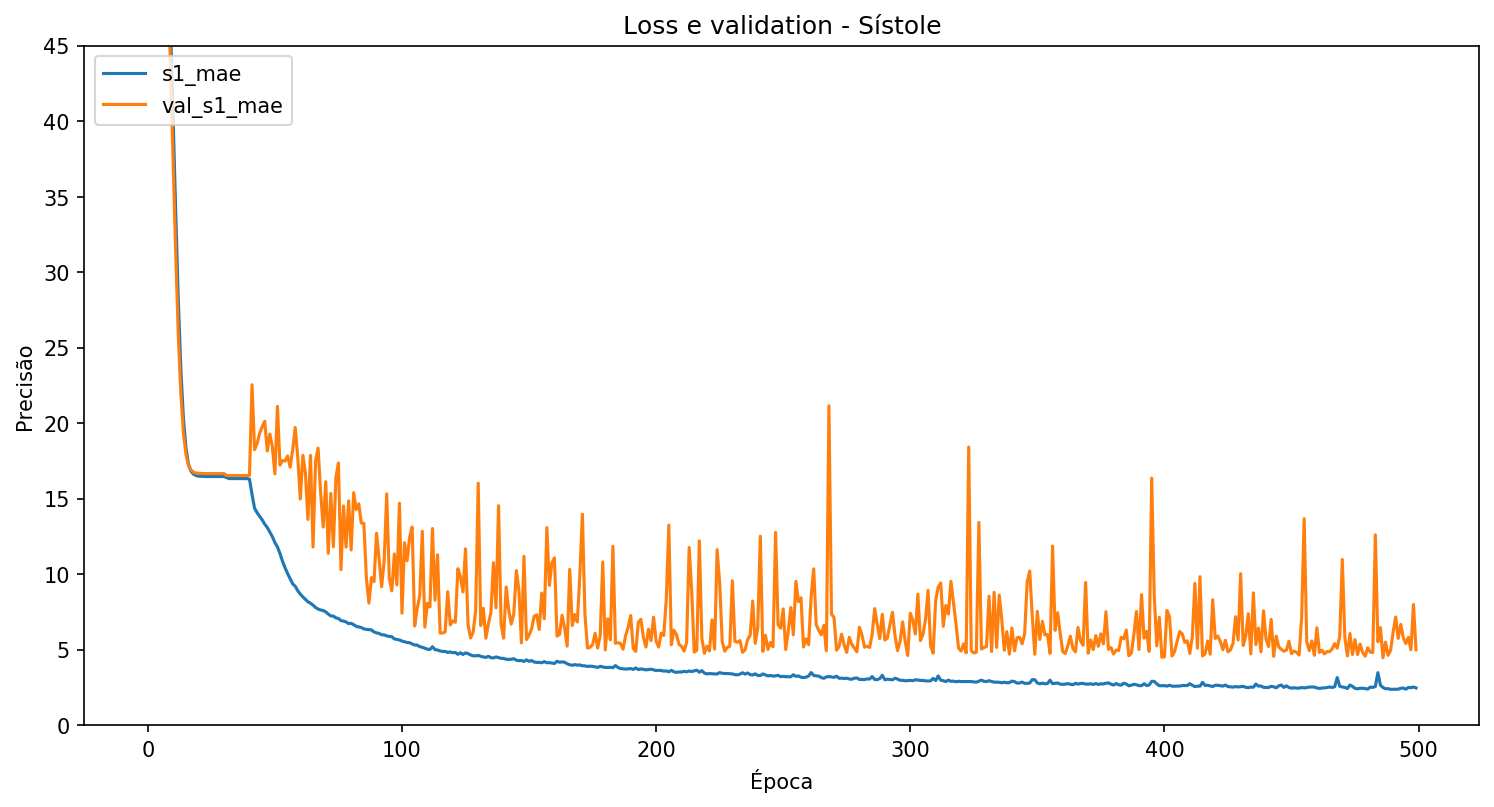

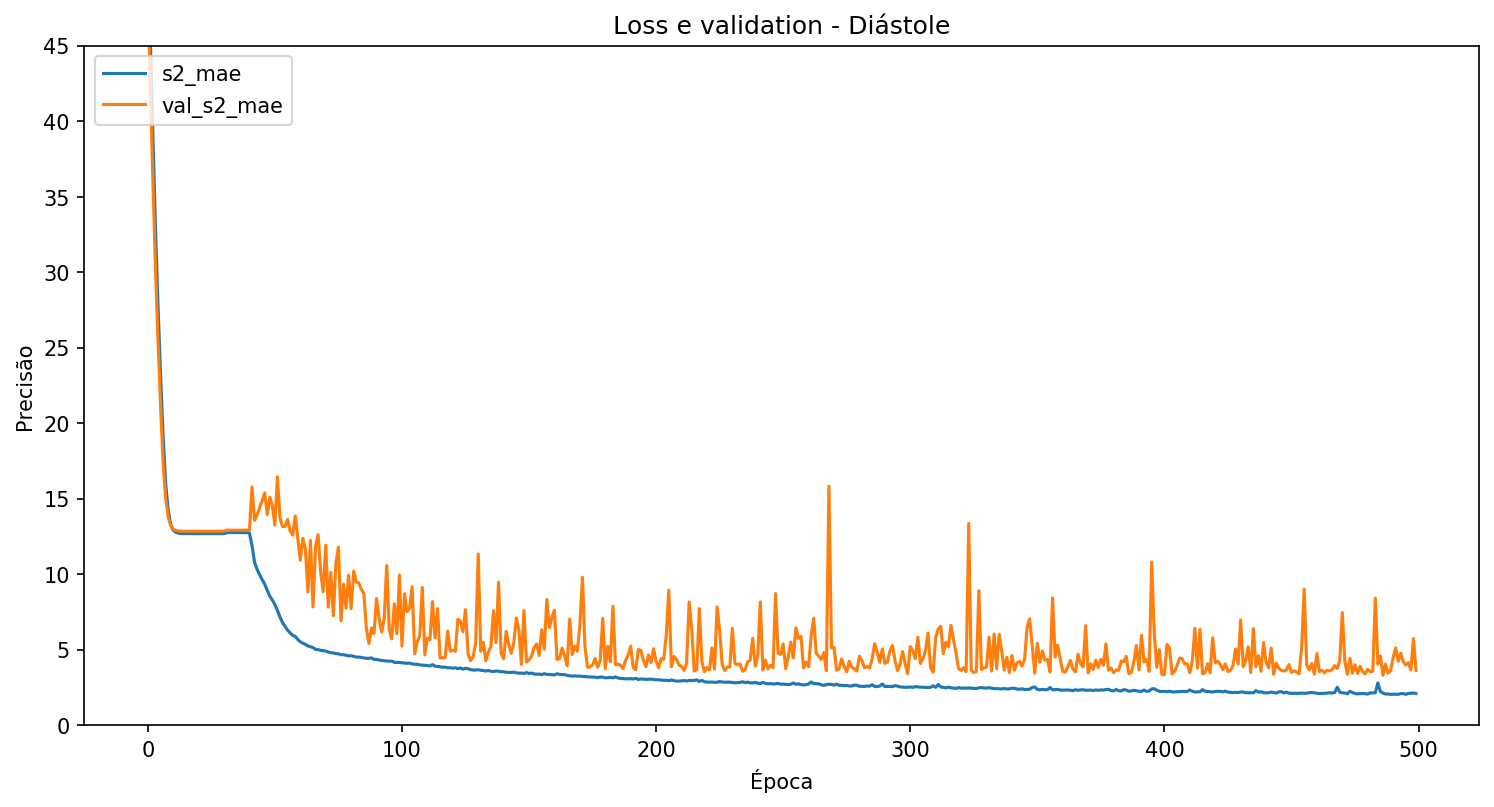

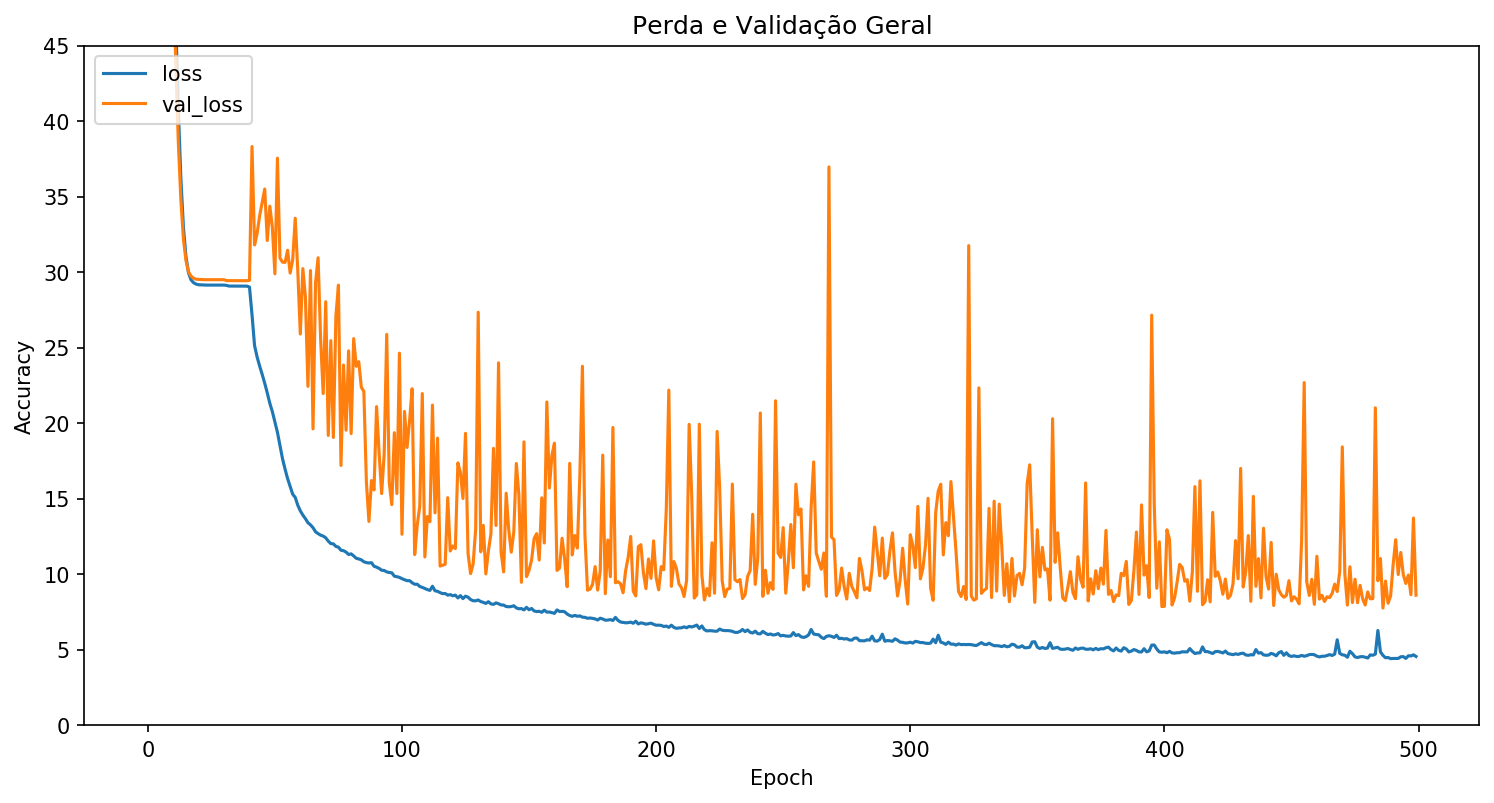

In [32]:
plots_loss_validation(hist3)

In [107]:
model3 = load_model(nome_modelo)

pred3 = np.asarray(model3.predict(X_test2))
pred_sis3, pred_dias3 = pred3[0][:], pred3[1][:]
print_pred(pred3[0][:], pred3[1][:])

Sistole : Pred -> [79.784294], Real -> [88.] 
Diastole : Pred -> [48.807003], Real -> [50.]

Sistole : Pred -> [96.53944], Real -> [105.] 
Diastole : Pred -> [45.77598], Real -> [54.]

Sistole : Pred -> [92.53321], Real -> [99.] 
Diastole : Pred -> [49.68767], Real -> [60.]

Sistole : Pred -> [92.59508], Real -> [93.] 
Diastole : Pred -> [48.428753], Real -> [54.]

Sistole : Pred -> [84.2057], Real -> [84.] 
Diastole : Pred -> [47.630188], Real -> [48.]

Sistole : Pred -> [97.88116], Real -> [116.] 
Diastole : Pred -> [47.65277], Real -> [66.]

Sistole : Pred -> [113.5159], Real -> [104.] 
Diastole : Pred -> [62.0945], Real -> [63.]

Sistole : Pred -> [88.68574], Real -> [75.] 
Diastole : Pred -> [49.637516], Real -> [45.]

Sistole : Pred -> [116.576096], Real -> [118.] 
Diastole : Pred -> [72.141914], Real -> [62.]

Sistole : Pred -> [96.064156], Real -> [100.] 
Diastole : Pred -> [50.273144], Real -> [59.]



In [108]:
print("MAE de Sistole {0} - Diástole {1}".format(percent_mean_absolute_error(y_sis_test2, pred_sis3), \
                                                  percent_mean_absolute_error(y_dias_test2, pred_dias3)))

MAE de Sistole 12.365944211721429 - Diástole 14.888729139015815


## Modelo 4 - Teste com poucas camadas (Não adicionado ao relatório)

In [53]:
def CRNN_DILATADA(input_shape):
    inputs = Input(input_shape, name = 'input_layer')
    c_1 = Conv1D(32, 3, activation='relu', dilation_rate=2, name='conv_1')(inputs)
    c_2 = Conv1D(64, 3, activation='relu', dilation_rate=2, name='conv_2')(c_1)
    bn_3 = BatchNormalization(name='bn_3')(c_2)
    p_3 = MaxPooling1D(pool_size=2, name='maxpool_3')(bn_3)

    bn_7_shape = p_3.get_shape()
    reshape = Reshape(target_shape=(int(bn_7_shape[1]), int(bn_7_shape[2])), name='reshape')(p_3)

    fc_9 = Dense(128, activation='relu', name='fc_9')(reshape)
    lstm_10 = LSTM(100, kernel_initializer="he_normal", return_sequences=True, name='lstm_10')(fc_9)
    do_11 = Dropout(0.5, name='dropout')(lstm_10)
    lstm_11 = LSTM(50, kernel_initializer="he_normal", return_sequences=True, name='lstm_11')(do_11)
    flatten = Flatten(name = 'flatten')(lstm_11)  
    fc_12 = Dense(1, kernel_initializer='he_normal', activation='linear', name='s1')(flatten)
    fc_13 = Dense(1, kernel_initializer='he_normal', activation='linear', name='s2')(flatten)

    prediction_model = Model(inputs=inputs, outputs=[fc_12, fc_13])
    prediction_model.compile(optimizer='adam', loss = 'mae', metrics=['mae'])
    prediction_model.summary()
    return prediction_model

In [56]:
model = CRNN_DILATADA(input_shape)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 96, 32)       128         input_layer[0][0]                
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 92, 64)       6208        conv_1[0][0]                     
__________________________________________________________________________________________________
bn_3 (BatchNormalization)       (None, 92, 64)       256         conv_2[0][0]                     
____________________________________________________________________________________________

In [57]:
nome_modelo = "modelo_CRNN_DILATADA_2_seg100_500epoc.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=nome_modelo,
                                                 save_best_only=True,
                                                 verbose=1)
hist4 = model.fit(x = X_train, y = [y_sis_train, y_dias_train],
          epochs=500, 
          batch_size=128,
          validation_data = (X_test, [y_sis_test, y_dias_test]),
          callbacks = [cp_callback],
          verbose = 1)

Train on 93732 samples, validate on 23433 samples
Epoch 1/500
93696/93732 [============================>.] - ETA: 0s - loss: 31.8390 - s1_loss: 18.7996 - s2_loss: 13.0394 - s1_mae: 18.7996 - s2_mae: 13.0394
Epoch 00001: val_loss improved from inf to 25.55485, saving model to modelo_CRNN_DILATADA_2_seg100_500epoc.h5
93732/93732 [==============================] - 20s 217us/sample - loss: 31.8347 - s1_loss: 18.7911 - s2_loss: 13.0326 - s1_mae: 18.7972 - s2_mae: 13.0375 - val_loss: 25.5548 - val_s1_loss: 14.6586 - val_s2_loss: 10.8416 - val_s1_mae: 14.6876 - val_s2_mae: 10.8673
Epoch 2/500
93568/93732 [============================>.] - ETA: 0s - loss: 23.0159 - s1_loss: 13.5838 - s2_loss: 9.4321 - s1_mae: 13.5838 - s2_mae: 9.4321
Epoch 00002: val_loss improved from 25.55485 to 23.33400, saving model to modelo_CRNN_DILATADA_2_seg100_500epoc.h5
93732/93732 [==============================] - 14s 154us/sample - loss: 23.0126 - s1_loss: 13.5857 - s2_loss: 9.4313 - s1_mae: 13.5817 - s2_mae: 9.43

Epoch 18/500
93696/93732 [============================>.] - ETA: 0s - loss: 11.6862 - s1_loss: 6.7177 - s2_loss: 4.9685 - s1_mae: 6.7177 - s2_mae: 4.9685
Epoch 00018: val_loss did not improve from 12.95094
93732/93732 [==============================] - 14s 147us/sample - loss: 11.6870 - s1_loss: 6.7195 - s2_loss: 4.9697 - s1_mae: 6.7182 - s2_mae: 4.9688 - val_loss: 14.2864 - val_s1_loss: 8.5988 - val_s2_loss: 5.6902 - val_s1_mae: 8.6032 - val_s2_mae: 5.6832
Epoch 19/500
93440/93732 [============================>.] - ETA: 0s - loss: 11.4632 - s1_loss: 6.5989 - s2_loss: 4.8642 - s1_mae: 6.5989 - s2_mae: 4.8642
Epoch 00019: val_loss did not improve from 12.95094
93732/93732 [==============================] - 14s 147us/sample - loss: 11.4610 - s1_loss: 6.5951 - s2_loss: 4.8622 - s1_mae: 6.5977 - s2_mae: 4.8633 - val_loss: 13.5392 - val_s1_loss: 7.8149 - val_s2_loss: 5.7153 - val_s1_mae: 7.8262 - val_s2_mae: 5.7130
Epoch 20/500
93440/93732 [============================>.] - ETA: 0s - loss: 

Epoch 36/500
93696/93732 [============================>.] - ETA: 0s - loss: 10.0654 - s1_loss: 5.7244 - s2_loss: 4.3410 - s1_mae: 5.7244 - s2_mae: 4.3410
Epoch 00036: val_loss did not improve from 11.19554
93732/93732 [==============================] - 14s 148us/sample - loss: 10.0649 - s1_loss: 5.7232 - s2_loss: 4.3405 - s1_mae: 5.7241 - s2_mae: 4.3409 - val_loss: 12.5309 - val_s1_loss: 7.1794 - val_s2_loss: 5.3653 - val_s1_mae: 7.1760 - val_s2_mae: 5.3549
Epoch 37/500
93568/93732 [============================>.] - ETA: 0s - loss: 10.1035 - s1_loss: 5.7434 - s2_loss: 4.3601 - s1_mae: 5.7434 - s2_mae: 4.3601
Epoch 00037: val_loss did not improve from 11.19554
93732/93732 [==============================] - 14s 148us/sample - loss: 10.1084 - s1_loss: 5.7484 - s2_loss: 4.3611 - s1_mae: 5.7465 - s2_mae: 4.3620 - val_loss: 16.8864 - val_s1_loss: 9.9367 - val_s2_loss: 6.9429 - val_s1_mae: 9.9606 - val_s2_mae: 6.9258
Epoch 38/500
93440/93732 [============================>.] - ETA: 0s - loss: 

Epoch 71/500
93440/93732 [============================>.] - ETA: 0s - loss: 8.6523 - s1_loss: 4.8575 - s2_loss: 3.7948 - s1_mae: 4.8575 - s2_mae: 3.7948
Epoch 00071: val_loss did not improve from 10.18786
93732/93732 [==============================] - 14s 148us/sample - loss: 8.6553 - s1_loss: 4.8618 - s2_loss: 3.7976 - s1_mae: 4.8600 - s2_mae: 3.7953 - val_loss: 10.4701 - val_s1_loss: 6.0350 - val_s2_loss: 4.4274 - val_s1_mae: 6.0447 - val_s2_mae: 4.4253
Epoch 72/500
93440/93732 [============================>.] - ETA: 0s - loss: 8.6606 - s1_loss: 4.8663 - s2_loss: 3.7942 - s1_mae: 4.8663 - s2_mae: 3.7942
Epoch 00072: val_loss did not improve from 10.18786
93732/93732 [==============================] - 14s 147us/sample - loss: 8.6557 - s1_loss: 4.8614 - s2_loss: 3.7917 - s1_mae: 4.8632 - s2_mae: 3.7925 - val_loss: 10.3215 - val_s1_loss: 5.9620 - val_s2_loss: 4.3515 - val_s1_mae: 5.9715 - val_s2_mae: 4.3499
Epoch 73/500
93440/93732 [============================>.] - ETA: 0s - loss: 8.85

Epoch 89/500
93696/93732 [============================>.] - ETA: 0s - loss: 8.1688 - s1_loss: 4.5619 - s2_loss: 3.6069 - s1_mae: 4.5619 - s2_mae: 3.6069
Epoch 00089: val_loss improved from 9.94465 to 9.79411, saving model to modelo_CRNN_DILATADA_2_seg100_500epoc.h5
93732/93732 [==============================] - 15s 159us/sample - loss: 8.1680 - s1_loss: 4.5604 - s2_loss: 3.6055 - s1_mae: 4.5614 - s2_mae: 3.6065 - val_loss: 9.7941 - val_s1_loss: 5.6077 - val_s2_loss: 4.1708 - val_s1_mae: 5.6225 - val_s2_mae: 4.1717
Epoch 90/500
93696/93732 [============================>.] - ETA: 0s - loss: 8.1736 - s1_loss: 4.5635 - s2_loss: 3.6101 - s1_mae: 4.5635 - s2_mae: 3.6101
Epoch 00090: val_loss did not improve from 9.79411
93732/93732 [==============================] - 14s 144us/sample - loss: 8.1731 - s1_loss: 4.5623 - s2_loss: 3.6094 - s1_mae: 4.5632 - s2_mae: 3.6099 - val_loss: 10.1192 - val_s1_loss: 5.7769 - val_s2_loss: 4.3486 - val_s1_mae: 5.7803 - val_s2_mae: 4.3389
Epoch 91/500
93568/93

Epoch 107/500
93312/93732 [============================>.] - ETA: 0s - loss: 7.9252 - s1_loss: 4.4198 - s2_loss: 3.5054 - s1_mae: 4.4198 - s2_mae: 3.5054
Epoch 00107: val_loss did not improve from 9.79411
93732/93732 [==============================] - 13s 140us/sample - loss: 7.9210 - s1_loss: 4.4190 - s2_loss: 3.5019 - s1_mae: 4.4187 - s2_mae: 3.5022 - val_loss: 10.5245 - val_s1_loss: 6.0577 - val_s2_loss: 4.4411 - val_s1_mae: 6.0762 - val_s2_mae: 4.4483
Epoch 108/500
93312/93732 [============================>.] - ETA: 0s - loss: 7.9130 - s1_loss: 4.4265 - s2_loss: 3.4865 - s1_mae: 4.4265 - s2_mae: 3.4865
Epoch 00108: val_loss did not improve from 9.79411
93732/93732 [==============================] - 13s 141us/sample - loss: 7.9169 - s1_loss: 4.4336 - s2_loss: 3.4888 - s1_mae: 4.4291 - s2_mae: 3.4878 - val_loss: 12.6688 - val_s1_loss: 7.4059 - val_s2_loss: 5.2662 - val_s1_mae: 7.4163 - val_s2_mae: 5.2525
Epoch 109/500
93696/93732 [============================>.] - ETA: 0s - loss: 7.8

Epoch 125/500
93312/93732 [============================>.] - ETA: 0s - loss: 7.6370 - s1_loss: 4.2541 - s2_loss: 3.3828 - s1_mae: 4.2541 - s2_mae: 3.3828
Epoch 00125: val_loss did not improve from 9.79411
93732/93732 [==============================] - 13s 141us/sample - loss: 7.6375 - s1_loss: 4.2558 - s2_loss: 3.3836 - s1_mae: 4.2544 - s2_mae: 3.3831 - val_loss: 11.2960 - val_s1_loss: 6.5239 - val_s2_loss: 4.7733 - val_s1_mae: 6.5339 - val_s2_mae: 4.7621
Epoch 126/500
93696/93732 [============================>.] - ETA: 0s - loss: 7.6185 - s1_loss: 4.2412 - s2_loss: 3.3773 - s1_mae: 4.2412 - s2_mae: 3.3773
Epoch 00126: val_loss improved from 9.79411 to 9.63914, saving model to modelo_CRNN_DILATADA_2_seg100_500epoc.h5
93732/93732 [==============================] - 13s 141us/sample - loss: 7.6178 - s1_loss: 4.2400 - s2_loss: 3.3758 - s1_mae: 4.2409 - s2_mae: 3.3769 - val_loss: 9.6391 - val_s1_loss: 5.5359 - val_s2_loss: 4.0940 - val_s1_mae: 5.5489 - val_s2_mae: 4.0902
Epoch 127/500
93568

Epoch 143/500
93312/93732 [============================>.] - ETA: 0s - loss: 7.2818 - s1_loss: 4.0356 - s2_loss: 3.2462 - s1_mae: 4.0356 - s2_mae: 3.2462
Epoch 00143: val_loss did not improve from 9.58417
93732/93732 [==============================] - 13s 140us/sample - loss: 7.2845 - s1_loss: 4.0385 - s2_loss: 3.2478 - s1_mae: 4.0379 - s2_mae: 3.2466 - val_loss: 9.7657 - val_s1_loss: 5.6074 - val_s2_loss: 4.1497 - val_s1_mae: 5.6166 - val_s2_mae: 4.1491
Epoch 144/500
93440/93732 [============================>.] - ETA: 0s - loss: 7.8657 - s1_loss: 4.3997 - s2_loss: 3.4660 - s1_mae: 4.3997 - s2_mae: 3.4660
Epoch 00144: val_loss did not improve from 9.58417
93732/93732 [==============================] - 13s 142us/sample - loss: 7.8642 - s1_loss: 4.3989 - s2_loss: 3.4658 - s1_mae: 4.3989 - s2_mae: 3.4653 - val_loss: 15.2820 - val_s1_loss: 8.5634 - val_s2_loss: 6.7123 - val_s1_mae: 8.5813 - val_s2_mae: 6.7006
Epoch 145/500
93440/93732 [============================>.] - ETA: 0s - loss: 7.52

Epoch 161/500
93312/93732 [============================>.] - ETA: 0s - loss: 7.4309 - s1_loss: 4.1384 - s2_loss: 3.2924 - s1_mae: 4.1384 - s2_mae: 3.2924
Epoch 00161: val_loss did not improve from 9.42299
93732/93732 [==============================] - 13s 140us/sample - loss: 7.4297 - s1_loss: 4.1372 - s2_loss: 3.2915 - s1_mae: 4.1377 - s2_mae: 3.2920 - val_loss: 9.8888 - val_s1_loss: 5.6998 - val_s2_loss: 4.1860 - val_s1_mae: 5.7098 - val_s2_mae: 4.1790
Epoch 162/500
93440/93732 [============================>.] - ETA: 0s - loss: 7.2712 - s1_loss: 4.0260 - s2_loss: 3.2452 - s1_mae: 4.0260 - s2_mae: 3.2452
Epoch 00162: val_loss did not improve from 9.42299
93732/93732 [==============================] - 13s 141us/sample - loss: 7.2717 - s1_loss: 4.0265 - s2_loss: 3.2460 - s1_mae: 4.0265 - s2_mae: 3.2452 - val_loss: 11.6297 - val_s1_loss: 6.5463 - val_s2_loss: 5.0896 - val_s1_mae: 6.5531 - val_s2_mae: 5.0766
Epoch 163/500
93696/93732 [============================>.] - ETA: 0s - loss: 7.22

Epoch 179/500
93440/93732 [============================>.] - ETA: 0s - loss: 7.0729 - s1_loss: 3.9193 - s2_loss: 3.1536 - s1_mae: 3.9193 - s2_mae: 3.1536
Epoch 00179: val_loss did not improve from 9.42299
93732/93732 [==============================] - 13s 139us/sample - loss: 7.0727 - s1_loss: 3.9185 - s2_loss: 3.1535 - s1_mae: 3.9194 - s2_mae: 3.1534 - val_loss: 15.2256 - val_s1_loss: 8.6441 - val_s2_loss: 6.5801 - val_s1_mae: 8.6540 - val_s2_mae: 6.5715
Epoch 180/500
93568/93732 [============================>.] - ETA: 0s - loss: 7.1014 - s1_loss: 3.9299 - s2_loss: 3.1715 - s1_mae: 3.9299 - s2_mae: 3.1715
Epoch 00180: val_loss did not improve from 9.42299
93732/93732 [==============================] - 13s 140us/sample - loss: 7.1010 - s1_loss: 3.9302 - s2_loss: 3.1701 - s1_mae: 3.9302 - s2_mae: 3.1708 - val_loss: 11.7682 - val_s1_loss: 6.7153 - val_s2_loss: 5.0554 - val_s1_mae: 6.7229 - val_s2_mae: 5.0453
Epoch 181/500
93440/93732 [============================>.] - ETA: 0s - loss: 6.9

Epoch 197/500
93696/93732 [============================>.] - ETA: 0s - loss: 7.0286 - s1_loss: 3.8949 - s2_loss: 3.1337 - s1_mae: 3.8949 - s2_mae: 3.1337
Epoch 00197: val_loss did not improve from 9.42299
93732/93732 [==============================] - 13s 140us/sample - loss: 7.0277 - s1_loss: 3.8933 - s2_loss: 3.1322 - s1_mae: 3.8944 - s2_mae: 3.1333 - val_loss: 13.6783 - val_s1_loss: 7.6761 - val_s2_loss: 5.9851 - val_s1_mae: 7.6944 - val_s2_mae: 5.9839
Epoch 198/500
93440/93732 [============================>.] - ETA: 0s - loss: 7.0249 - s1_loss: 3.8879 - s2_loss: 3.1370 - s1_mae: 3.8879 - s2_mae: 3.1370
Epoch 00198: val_loss did not improve from 9.42299
93732/93732 [==============================] - 13s 141us/sample - loss: 7.0245 - s1_loss: 3.8870 - s2_loss: 3.1374 - s1_mae: 3.8872 - s2_mae: 3.1373 - val_loss: 10.0515 - val_s1_loss: 5.7833 - val_s2_loss: 4.2557 - val_s1_mae: 5.7977 - val_s2_mae: 4.2538
Epoch 199/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.8

Epoch 215/500
93440/93732 [============================>.] - ETA: 0s - loss: 6.7527 - s1_loss: 3.7206 - s2_loss: 3.0322 - s1_mae: 3.7206 - s2_mae: 3.0322
Epoch 00215: val_loss did not improve from 9.42299
93732/93732 [==============================] - 13s 141us/sample - loss: 6.7529 - s1_loss: 3.7198 - s2_loss: 3.0314 - s1_mae: 3.7207 - s2_mae: 3.0322 - val_loss: 9.6349 - val_s1_loss: 5.5629 - val_s2_loss: 4.0670 - val_s1_mae: 5.5741 - val_s2_mae: 4.0608
Epoch 216/500
93312/93732 [============================>.] - ETA: 0s - loss: 6.8086 - s1_loss: 3.7486 - s2_loss: 3.0600 - s1_mae: 3.7486 - s2_mae: 3.0600
Epoch 00216: val_loss did not improve from 9.42299
93732/93732 [==============================] - 13s 140us/sample - loss: 6.8099 - s1_loss: 3.7483 - s2_loss: 3.0620 - s1_mae: 3.7486 - s2_mae: 3.0613 - val_loss: 15.6674 - val_s1_loss: 9.0560 - val_s2_loss: 6.6170 - val_s1_mae: 9.0657 - val_s2_mae: 6.6017
Epoch 217/500
93568/93732 [============================>.] - ETA: 0s - loss: 6.81

Epoch 233/500
93568/93732 [============================>.] - ETA: 0s - loss: 6.5741 - s1_loss: 3.6218 - s2_loss: 2.9524 - s1_mae: 3.6218 - s2_mae: 2.9524
Epoch 00233: val_loss did not improve from 9.42299
93732/93732 [==============================] - 13s 141us/sample - loss: 6.5754 - s1_loss: 3.6224 - s2_loss: 2.9516 - s1_mae: 3.6230 - s2_mae: 2.9524 - val_loss: 9.6712 - val_s1_loss: 5.5601 - val_s2_loss: 4.1224 - val_s1_mae: 5.5626 - val_s2_mae: 4.1086
Epoch 234/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.7152 - s1_loss: 3.6926 - s2_loss: 3.0226 - s1_mae: 3.6926 - s2_mae: 3.0226
Epoch 00234: val_loss did not improve from 9.42299
93732/93732 [==============================] - 13s 140us/sample - loss: 6.7145 - s1_loss: 3.6912 - s2_loss: 3.0215 - s1_mae: 3.6922 - s2_mae: 3.0223 - val_loss: 9.5522 - val_s1_loss: 5.5060 - val_s2_loss: 4.0420 - val_s1_mae: 5.5154 - val_s2_mae: 4.0368
Epoch 235/500
93568/93732 [============================>.] - ETA: 0s - loss: 6.703

Epoch 251/500
93440/93732 [============================>.] - ETA: 0s - loss: 6.5781 - s1_loss: 3.6237 - s2_loss: 2.9543 - s1_mae: 3.6237 - s2_mae: 2.9543
Epoch 00251: val_loss did not improve from 9.42299
93732/93732 [==============================] - 13s 140us/sample - loss: 6.5832 - s1_loss: 3.6261 - s2_loss: 2.9566 - s1_mae: 3.6265 - s2_mae: 2.9567 - val_loss: 11.6166 - val_s1_loss: 6.7358 - val_s2_loss: 4.8670 - val_s1_mae: 6.7520 - val_s2_mae: 4.8646
Epoch 252/500
93440/93732 [============================>.] - ETA: 0s - loss: 6.6621 - s1_loss: 3.6696 - s2_loss: 2.9925 - s1_mae: 3.6696 - s2_mae: 2.9925
Epoch 00252: val_loss did not improve from 9.42299
93732/93732 [==============================] - 13s 139us/sample - loss: 6.6612 - s1_loss: 3.6684 - s2_loss: 2.9915 - s1_mae: 3.6690 - s2_mae: 2.9923 - val_loss: 9.6585 - val_s1_loss: 5.5834 - val_s2_loss: 4.0927 - val_s1_mae: 5.5838 - val_s2_mae: 4.0747
Epoch 253/500
93440/93732 [============================>.] - ETA: 0s - loss: 6.51

Epoch 269/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.7532 - s1_loss: 3.7285 - s2_loss: 3.0247 - s1_mae: 3.7285 - s2_mae: 3.0247
Epoch 00269: val_loss did not improve from 9.21242
93732/93732 [==============================] - 13s 141us/sample - loss: 6.7531 - s1_loss: 3.7282 - s2_loss: 3.0245 - s1_mae: 3.7284 - s2_mae: 3.0247 - val_loss: 9.7454 - val_s1_loss: 5.6236 - val_s2_loss: 4.1075 - val_s1_mae: 5.6369 - val_s2_mae: 4.1085
Epoch 270/500
93312/93732 [============================>.] - ETA: 0s - loss: 6.6208 - s1_loss: 3.6525 - s2_loss: 2.9683 - s1_mae: 3.6525 - s2_mae: 2.9683
Epoch 00270: val_loss did not improve from 9.21242
93732/93732 [==============================] - 13s 140us/sample - loss: 6.6181 - s1_loss: 3.6498 - s2_loss: 2.9671 - s1_mae: 3.6502 - s2_mae: 2.9679 - val_loss: 9.8928 - val_s1_loss: 5.6492 - val_s2_loss: 4.2248 - val_s1_mae: 5.6667 - val_s2_mae: 4.2261
Epoch 271/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.910

Epoch 287/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.7398 - s1_loss: 3.7352 - s2_loss: 3.0046 - s1_mae: 3.7352 - s2_mae: 3.0046
Epoch 00287: val_loss did not improve from 9.07619
93732/93732 [==============================] - 13s 140us/sample - loss: 6.7402 - s1_loss: 3.7358 - s2_loss: 3.0056 - s1_mae: 3.7354 - s2_mae: 3.0048 - val_loss: 15.3756 - val_s1_loss: 9.0324 - val_s2_loss: 6.3338 - val_s1_mae: 9.0429 - val_s2_mae: 6.3327
Epoch 288/500
93568/93732 [============================>.] - ETA: 0s - loss: 6.6069 - s1_loss: 3.6516 - s2_loss: 2.9553 - s1_mae: 3.6516 - s2_mae: 2.9553
Epoch 00288: val_loss did not improve from 9.07619
93732/93732 [==============================] - 13s 140us/sample - loss: 6.6083 - s1_loss: 3.6550 - s2_loss: 2.9565 - s1_mae: 3.6528 - s2_mae: 2.9555 - val_loss: 11.2449 - val_s1_loss: 6.4196 - val_s2_loss: 4.8374 - val_s1_mae: 6.4206 - val_s2_mae: 4.8243
Epoch 289/500
93568/93732 [============================>.] - ETA: 0s - loss: 6.6

Epoch 305/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.5349 - s1_loss: 3.5891 - s2_loss: 2.9458 - s1_mae: 3.5891 - s2_mae: 2.9458
Epoch 00305: val_loss did not improve from 9.07619
93732/93732 [==============================] - 13s 142us/sample - loss: 6.5361 - s1_loss: 3.5919 - s2_loss: 2.9474 - s1_mae: 3.5899 - s2_mae: 2.9463 - val_loss: 9.8551 - val_s1_loss: 5.6839 - val_s2_loss: 4.1797 - val_s1_mae: 5.6864 - val_s2_mae: 4.1686
Epoch 306/500
93440/93732 [============================>.] - ETA: 0s - loss: 6.3878 - s1_loss: 3.5006 - s2_loss: 2.8872 - s1_mae: 3.5006 - s2_mae: 2.8872
Epoch 00306: val_loss did not improve from 9.07619
93732/93732 [==============================] - 13s 139us/sample - loss: 6.3901 - s1_loss: 3.5045 - s2_loss: 2.8868 - s1_mae: 3.5030 - s2_mae: 2.8871 - val_loss: 10.8308 - val_s1_loss: 6.2763 - val_s2_loss: 4.5456 - val_s1_mae: 6.2861 - val_s2_mae: 4.5447
Epoch 307/500
93312/93732 [============================>.] - ETA: 0s - loss: 6.34

Epoch 323/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.2433 - s1_loss: 3.4216 - s2_loss: 2.8217 - s1_mae: 3.4216 - s2_mae: 2.8217
Epoch 00323: val_loss did not improve from 9.07146
93732/93732 [==============================] - 13s 140us/sample - loss: 6.2431 - s1_loss: 3.4209 - s2_loss: 2.8218 - s1_mae: 3.4214 - s2_mae: 2.8217 - val_loss: 9.2647 - val_s1_loss: 5.3582 - val_s2_loss: 3.9052 - val_s1_mae: 5.3671 - val_s2_mae: 3.8975
Epoch 324/500
93440/93732 [============================>.] - ETA: 0s - loss: 6.2289 - s1_loss: 3.4057 - s2_loss: 2.8232 - s1_mae: 3.4057 - s2_mae: 2.8232
Epoch 00324: val_loss did not improve from 9.07146
93732/93732 [==============================] - 13s 139us/sample - loss: 6.2285 - s1_loss: 3.4063 - s2_loss: 2.8222 - s1_mae: 3.4056 - s2_mae: 2.8228 - val_loss: 9.2438 - val_s1_loss: 5.2946 - val_s2_loss: 3.9370 - val_s1_mae: 5.3082 - val_s2_mae: 3.9356
Epoch 325/500
93312/93732 [============================>.] - ETA: 0s - loss: 6.345

Epoch 341/500
93312/93732 [============================>.] - ETA: 0s - loss: 6.3098 - s1_loss: 3.4684 - s2_loss: 2.8413 - s1_mae: 3.4684 - s2_mae: 2.8413
Epoch 00341: val_loss did not improve from 9.07146
93732/93732 [==============================] - 13s 140us/sample - loss: 6.3086 - s1_loss: 3.4673 - s2_loss: 2.8401 - s1_mae: 3.4679 - s2_mae: 2.8407 - val_loss: 9.3349 - val_s1_loss: 5.3751 - val_s2_loss: 3.9415 - val_s1_mae: 5.3924 - val_s2_mae: 3.9426
Epoch 342/500
93312/93732 [============================>.] - ETA: 0s - loss: 6.1476 - s1_loss: 3.3645 - s2_loss: 2.7830 - s1_mae: 3.3645 - s2_mae: 2.7830
Epoch 00342: val_loss did not improve from 9.07146
93732/93732 [==============================] - 13s 142us/sample - loss: 6.1505 - s1_loss: 3.3693 - s2_loss: 2.7855 - s1_mae: 3.3668 - s2_mae: 2.7837 - val_loss: 9.5489 - val_s1_loss: 5.5075 - val_s2_loss: 4.0270 - val_s1_mae: 5.5200 - val_s2_mae: 4.0288
Epoch 343/500
93312/93732 [============================>.] - ETA: 0s - loss: 6.275

Epoch 359/500
93568/93732 [============================>.] - ETA: 0s - loss: 6.3713 - s1_loss: 3.4963 - s2_loss: 2.8751 - s1_mae: 3.4963 - s2_mae: 2.8751
Epoch 00359: val_loss did not improve from 9.07146
93732/93732 [==============================] - 13s 140us/sample - loss: 6.3711 - s1_loss: 3.4980 - s2_loss: 2.8744 - s1_mae: 3.4964 - s2_mae: 2.8747 - val_loss: 10.4650 - val_s1_loss: 6.0593 - val_s2_loss: 4.3988 - val_s1_mae: 6.0704 - val_s2_mae: 4.3946
Epoch 360/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.4577 - s1_loss: 3.5628 - s2_loss: 2.8949 - s1_mae: 3.5628 - s2_mae: 2.8949
Epoch 00360: val_loss did not improve from 9.07146
93732/93732 [==============================] - 13s 140us/sample - loss: 6.4571 - s1_loss: 3.5611 - s2_loss: 2.8944 - s1_mae: 3.5623 - s2_mae: 2.8948 - val_loss: 9.6073 - val_s1_loss: 5.5506 - val_s2_loss: 4.0674 - val_s1_mae: 5.5521 - val_s2_mae: 4.0552
Epoch 361/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.35

Epoch 377/500
93440/93732 [============================>.] - ETA: 0s - loss: 6.3761 - s1_loss: 3.5197 - s2_loss: 2.8564 - s1_mae: 3.5197 - s2_mae: 2.8564
Epoch 00377: val_loss did not improve from 9.07146
93732/93732 [==============================] - 13s 139us/sample - loss: 6.3745 - s1_loss: 3.5166 - s2_loss: 2.8564 - s1_mae: 3.5181 - s2_mae: 2.8564 - val_loss: 9.9343 - val_s1_loss: 5.7216 - val_s2_loss: 4.2034 - val_s1_mae: 5.7333 - val_s2_mae: 4.2010
Epoch 378/500
93568/93732 [============================>.] - ETA: 0s - loss: 6.4136 - s1_loss: 3.5305 - s2_loss: 2.8831 - s1_mae: 3.5305 - s2_mae: 2.8831
Epoch 00378: val_loss did not improve from 9.07146
93732/93732 [==============================] - 13s 139us/sample - loss: 6.4129 - s1_loss: 3.5278 - s2_loss: 2.8833 - s1_mae: 3.5295 - s2_mae: 2.8833 - val_loss: 10.3439 - val_s1_loss: 5.9964 - val_s2_loss: 4.3343 - val_s1_mae: 6.0104 - val_s2_mae: 4.3335
Epoch 379/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.22

Epoch 395/500
93312/93732 [============================>.] - ETA: 0s - loss: 6.5277 - s1_loss: 3.6034 - s2_loss: 2.9243 - s1_mae: 3.6034 - s2_mae: 2.9243
Epoch 00395: val_loss did not improve from 9.07146
93732/93732 [==============================] - 13s 140us/sample - loss: 6.5278 - s1_loss: 3.6030 - s2_loss: 2.9239 - s1_mae: 3.6035 - s2_mae: 2.9244 - val_loss: 10.0590 - val_s1_loss: 5.8287 - val_s2_loss: 4.2308 - val_s1_mae: 5.8368 - val_s2_mae: 4.2222
Epoch 396/500
93568/93732 [============================>.] - ETA: 0s - loss: 6.1751 - s1_loss: 3.3881 - s2_loss: 2.7870 - s1_mae: 3.3881 - s2_mae: 2.7870
Epoch 00396: val_loss did not improve from 9.07146
93732/93732 [==============================] - 13s 140us/sample - loss: 6.1752 - s1_loss: 3.3878 - s2_loss: 2.7864 - s1_mae: 3.3879 - s2_mae: 2.7872 - val_loss: 9.8211 - val_s1_loss: 5.6866 - val_s2_loss: 4.1204 - val_s1_mae: 5.7002 - val_s2_mae: 4.1209
Epoch 397/500
93440/93732 [============================>.] - ETA: 0s - loss: 6.15

Epoch 413/500
93312/93732 [============================>.] - ETA: 0s - loss: 6.4730 - s1_loss: 3.5839 - s2_loss: 2.8891 - s1_mae: 3.5839 - s2_mae: 2.8891
Epoch 00413: val_loss did not improve from 9.07146
93732/93732 [==============================] - 13s 141us/sample - loss: 6.4734 - s1_loss: 3.5820 - s2_loss: 2.8895 - s1_mae: 3.5834 - s2_mae: 2.8900 - val_loss: 9.4805 - val_s1_loss: 5.4898 - val_s2_loss: 3.9768 - val_s1_mae: 5.5031 - val_s2_mae: 3.9774
Epoch 414/500
93568/93732 [============================>.] - ETA: 0s - loss: 5.9993 - s1_loss: 3.2810 - s2_loss: 2.7183 - s1_mae: 3.2810 - s2_mae: 2.7183
Epoch 00414: val_loss did not improve from 9.07146
93732/93732 [==============================] - 13s 140us/sample - loss: 5.9987 - s1_loss: 3.2797 - s2_loss: 2.7172 - s1_mae: 3.2806 - s2_mae: 2.7182 - val_loss: 9.5395 - val_s1_loss: 5.4902 - val_s2_loss: 4.0681 - val_s1_mae: 5.4870 - val_s2_mae: 4.0525
Epoch 415/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.026

Epoch 431/500
93568/93732 [============================>.] - ETA: 0s - loss: 6.0834 - s1_loss: 3.3265 - s2_loss: 2.7569 - s1_mae: 3.3265 - s2_mae: 2.7569
Epoch 00431: val_loss did not improve from 9.04082
93732/93732 [==============================] - 13s 141us/sample - loss: 6.0838 - s1_loss: 3.3263 - s2_loss: 2.7576 - s1_mae: 3.3265 - s2_mae: 2.7573 - val_loss: 12.4738 - val_s1_loss: 7.3710 - val_s2_loss: 5.0897 - val_s1_mae: 7.3794 - val_s2_mae: 5.0945
Epoch 432/500
93312/93732 [============================>.] - ETA: 0s - loss: 6.0657 - s1_loss: 3.3232 - s2_loss: 2.7425 - s1_mae: 3.3232 - s2_mae: 2.7425
Epoch 00432: val_loss did not improve from 9.04082
93732/93732 [==============================] - 13s 140us/sample - loss: 6.0775 - s1_loss: 3.3298 - s2_loss: 2.7471 - s1_mae: 3.3299 - s2_mae: 2.7476 - val_loss: 29.2260 - val_s1_loss: 16.5792 - val_s2_loss: 12.6013 - val_s1_mae: 16.6063 - val_s2_mae: 12.6197
Epoch 433/500
93696/93732 [============================>.] - ETA: 0s - loss:

Epoch 449/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.0451 - s1_loss: 3.3086 - s2_loss: 2.7365 - s1_mae: 3.3086 - s2_mae: 2.7365
Epoch 00449: val_loss did not improve from 9.04082
93732/93732 [==============================] - 13s 140us/sample - loss: 6.0484 - s1_loss: 3.3154 - s2_loss: 2.7415 - s1_mae: 3.3105 - s2_mae: 2.7379 - val_loss: 10.0023 - val_s1_loss: 5.7974 - val_s2_loss: 4.2196 - val_s1_mae: 5.7966 - val_s2_mae: 4.2057
Epoch 450/500
93440/93732 [============================>.] - ETA: 0s - loss: 6.3267 - s1_loss: 3.4828 - s2_loss: 2.8438 - s1_mae: 3.4828 - s2_mae: 2.8438
Epoch 00450: val_loss did not improve from 9.04082
93732/93732 [==============================] - 13s 141us/sample - loss: 6.3265 - s1_loss: 3.4812 - s2_loss: 2.8428 - s1_mae: 3.4827 - s2_mae: 2.8439 - val_loss: 11.2096 - val_s1_loss: 6.5630 - val_s2_loss: 4.6494 - val_s1_mae: 6.5629 - val_s2_mae: 4.6466
Epoch 451/500
93696/93732 [============================>.] - ETA: 0s - loss: 6.0

Epoch 467/500
93440/93732 [============================>.] - ETA: 0s - loss: 6.2603 - s1_loss: 3.4351 - s2_loss: 2.8252 - s1_mae: 3.4351 - s2_mae: 2.8252
Epoch 00467: val_loss did not improve from 9.04082
93732/93732 [==============================] - 13s 140us/sample - loss: 6.2598 - s1_loss: 3.4361 - s2_loss: 2.8248 - s1_mae: 3.4354 - s2_mae: 2.8244 - val_loss: 9.0789 - val_s1_loss: 5.2283 - val_s2_loss: 3.8558 - val_s1_mae: 5.2303 - val_s2_mae: 3.8486
Epoch 468/500
93568/93732 [============================>.] - ETA: 0s - loss: 5.9721 - s1_loss: 3.2776 - s2_loss: 2.6945 - s1_mae: 3.2776 - s2_mae: 2.6945
Epoch 00468: val_loss did not improve from 9.04082
93732/93732 [==============================] - 13s 140us/sample - loss: 5.9704 - s1_loss: 3.2755 - s2_loss: 2.6933 - s1_mae: 3.2764 - s2_mae: 2.6939 - val_loss: 9.9025 - val_s1_loss: 5.7510 - val_s2_loss: 4.1492 - val_s1_mae: 5.7584 - val_s2_mae: 4.1441
Epoch 469/500
93440/93732 [============================>.] - ETA: 0s - loss: 5.962

Epoch 485/500
93312/93732 [============================>.] - ETA: 0s - loss: 6.0404 - s1_loss: 3.3066 - s2_loss: 2.7338 - s1_mae: 3.3066 - s2_mae: 2.7338
Epoch 00485: val_loss did not improve from 9.04082
93732/93732 [==============================] - 13s 140us/sample - loss: 6.0368 - s1_loss: 3.3033 - s2_loss: 2.7328 - s1_mae: 3.3038 - s2_mae: 2.7331 - val_loss: 9.2100 - val_s1_loss: 5.3544 - val_s2_loss: 3.8648 - val_s1_mae: 5.3545 - val_s2_mae: 3.8555
Epoch 486/500
93696/93732 [============================>.] - ETA: 0s - loss: 5.8779 - s1_loss: 3.2004 - s2_loss: 2.6775 - s1_mae: 3.2004 - s2_mae: 2.6775
Epoch 00486: val_loss did not improve from 9.04082
93732/93732 [==============================] - 13s 140us/sample - loss: 5.8786 - s1_loss: 3.2011 - s2_loss: 2.6791 - s1_mae: 3.2006 - s2_mae: 2.6780 - val_loss: 9.6033 - val_s1_loss: 5.5533 - val_s2_loss: 4.0489 - val_s1_mae: 5.5599 - val_s2_mae: 4.0434
Epoch 487/500
93440/93732 [============================>.] - ETA: 0s - loss: 5.977

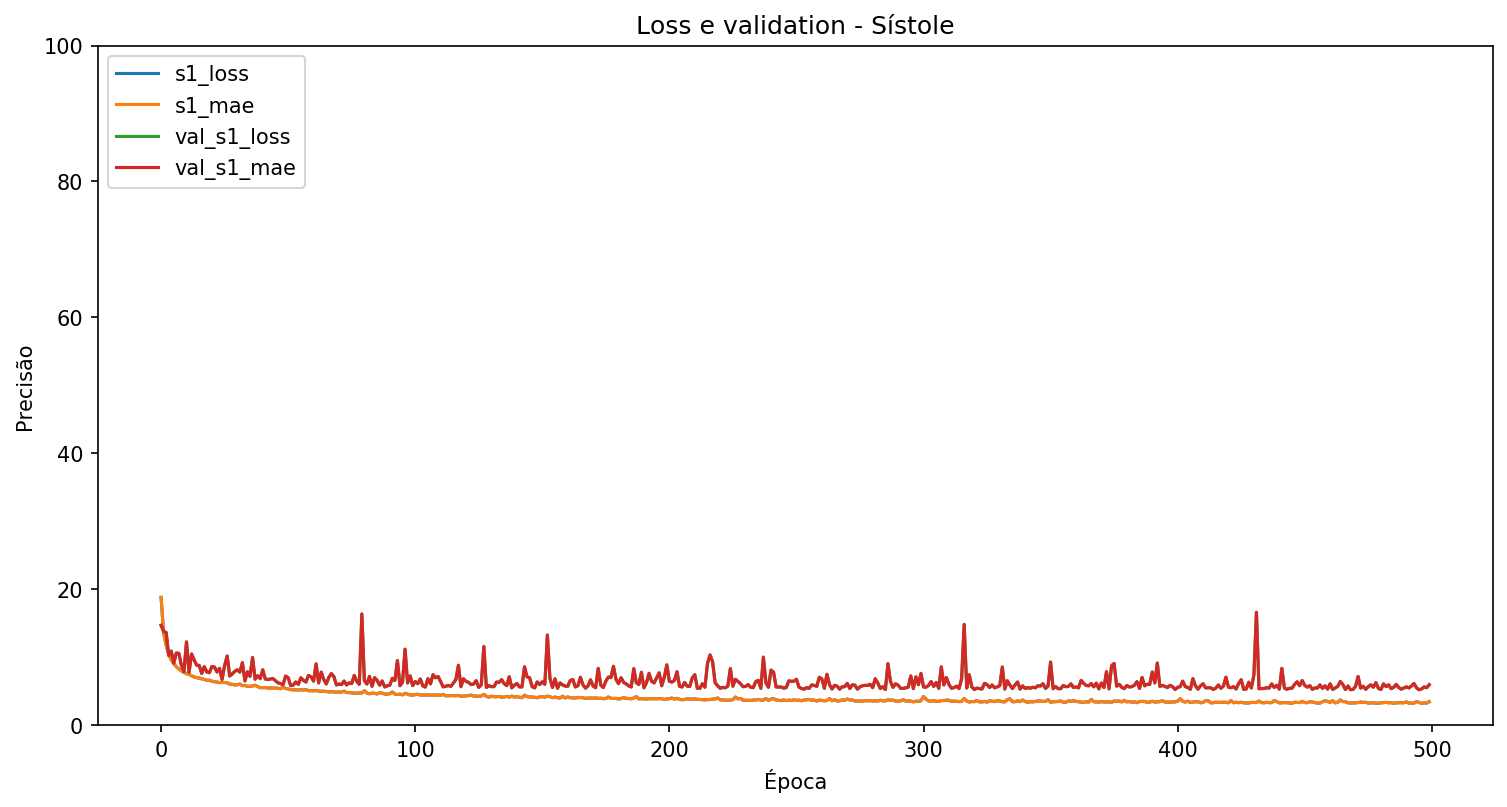

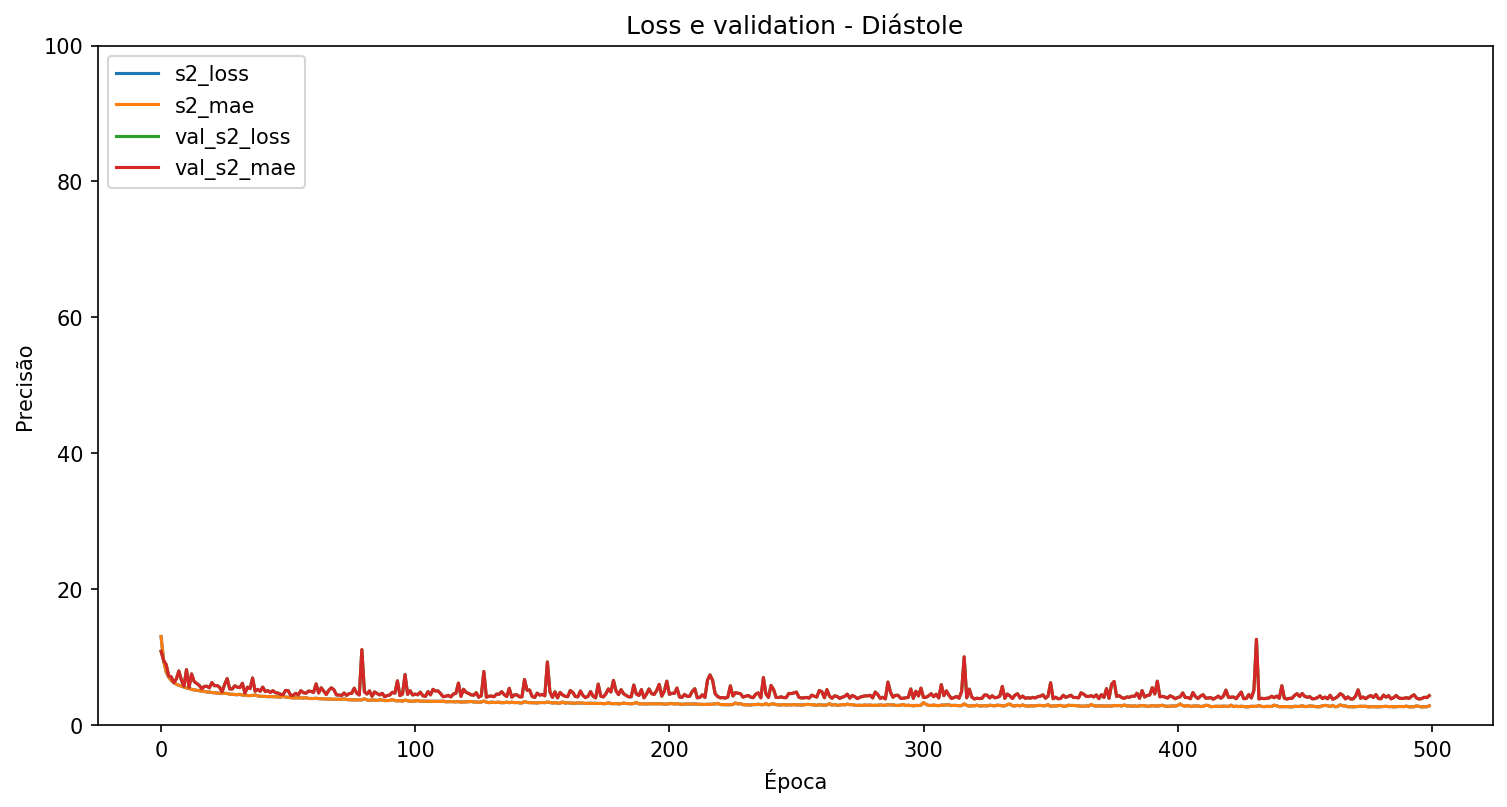

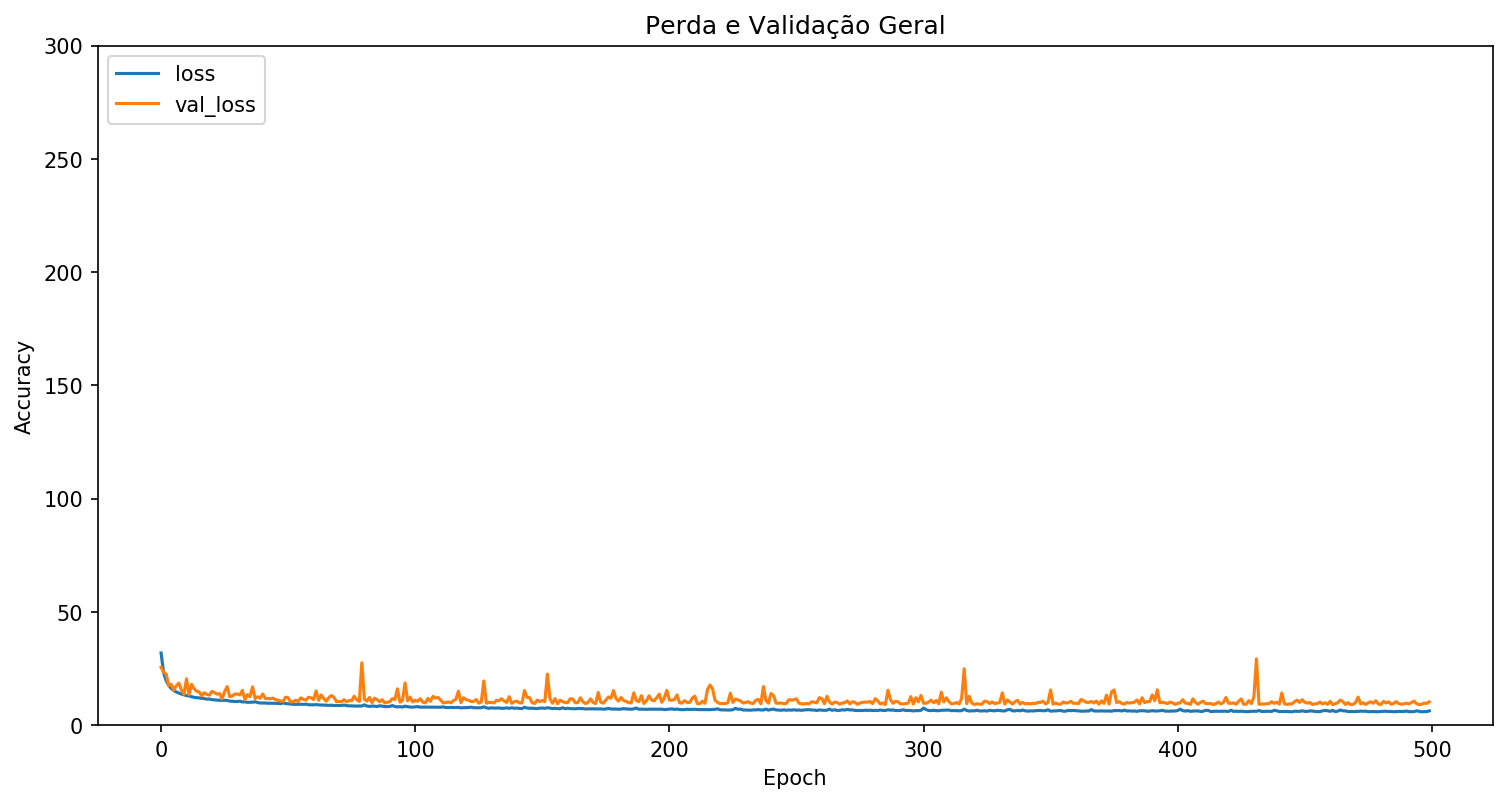

In [58]:
plots_loss_validation(hist4.history)

In [62]:
# salvar_historico_modelo('hist_net4_crnn_dilatada', hist4)

In [64]:
# hist4 = ler_historico_modelo('hist_net4_crnn_dilatada')

In [67]:
model4 = load_model(nome_modelo)

pred4 = np.asarray(model4.predict(X_test2))
pred_sis4, pred_dias4 = pred4[0][:], pred4[1][:]
print_pred(pred4[0][:], pred4[1][:])

Sistole : Pred -> [113.825874], Real -> [97.] 
Diastole : Pred -> [66.816536], Real -> [54.]

Sistole : Pred -> [96.6719], Real -> [99.] 
Diastole : Pred -> [47.50421], Real -> [56.]

Sistole : Pred -> [110.56458], Real -> [100.] 
Diastole : Pred -> [57.16965], Real -> [57.]

Sistole : Pred -> [88.94561], Real -> [85.] 
Diastole : Pred -> [49.880856], Real -> [51.]

Sistole : Pred -> [95.812546], Real -> [99.] 
Diastole : Pred -> [49.96946], Real -> [55.]

Sistole : Pred -> [84.69104], Real -> [94.] 
Diastole : Pred -> [39.296597], Real -> [36.]

Sistole : Pred -> [90.618576], Real -> [82.] 
Diastole : Pred -> [46.626743], Real -> [45.]

Sistole : Pred -> [89.04097], Real -> [85.] 
Diastole : Pred -> [44.62113], Real -> [51.]

Sistole : Pred -> [103.824585], Real -> [99.] 
Diastole : Pred -> [49.47109], Real -> [60.]

Sistole : Pred -> [81.66105], Real -> [77.] 
Diastole : Pred -> [48.51742], Real -> [45.]



In [68]:
print("MAE de Sistole {0} - Diástole {1}".format(percent_mean_absolute_error(y_sis_test2, pred_sis4), \
                                                  percent_mean_absolute_error(y_dias_test2, pred_dias4)))

MAE de Sistole 11.775715750901032 - Diástole 12.9487634083364


## Modelo 5 - ResNet

In [69]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [70]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    
    conv = Conv1D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
            x = tf.keras.layers.Dropout(0.2)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = tf.keras.layers.Activation(activation)(x)
            x = tf.keras.layers.Dropout(0.2)(x)
        x = conv(x)
    return x

In [71]:
def resnet_v1(input_shape, depth):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 3 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = (depth - 2) // 6

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = tf.keras.layers.Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = tf.keras.layers.AveragePooling1D(pool_size=8)(x)
    y = tf.keras.layers.Flatten()(x)
    s1 = tf.keras.layers.Dense(1,
                    activation='linear',
                    kernel_initializer='he_normal', name = 's1')(y)
    s2 = tf.keras.layers.Dense(1,
                    activation='linear',
                    kernel_initializer='he_normal', name = 's2')(y)
    
    # Instantiate model.
    model = tf.keras.models.Model(inputs=inputs, outputs=[s1, s2])
    model.summary()
    return model

In [74]:
modelo_res = resnet_v1(input_shape, 32)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 100, 16)      64          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 100, 16)      64          conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 100, 16)      0           batch_normalization_31[0][0]     
____________________________________________________________________________________________

In [75]:
nome_modelo = "modelo_resnetv1_seg100_100epoc_bs128.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=nome_modelo,
                                                 save_best_only=True,
                                                 verbose=1)
hist5 = model.fit(x = X_train, y = [y_sis_train, y_dias_train],
          epochs=100, 
          batch_size=128,
          validation_data = (X_test, [y_sis_test, y_dias_test]),
          callbacks = [cp_callback],
          verbose = 1)

Train on 93732 samples, validate on 23433 samples
Epoch 1/100
93696/93732 [============================>.] - ETA: 0s - loss: 6.7928 - s1_loss: 3.7842 - s2_loss: 3.0085 - s1_mae: 3.7842 - s2_mae: 3.0085
Epoch 00001: val_loss improved from inf to 10.03298, saving model to modelo_resnetv1_seg100_100epoc_bs128.h5
93732/93732 [==============================] - 14s 148us/sample - loss: 6.7923 - s1_loss: 3.7836 - s2_loss: 3.0073 - s1_mae: 3.7841 - s2_mae: 3.0082 - val_loss: 10.0330 - val_s1_loss: 5.8282 - val_s2_loss: 4.2147 - val_s1_mae: 5.8298 - val_s2_mae: 4.2032
Epoch 2/100
93440/93732 [============================>.] - ETA: 0s - loss: 5.9704 - s1_loss: 3.2607 - s2_loss: 2.7097 - s1_mae: 3.2607 - s2_mae: 2.7097
Epoch 00002: val_loss improved from 10.03298 to 9.06051, saving model to modelo_resnetv1_seg100_100epoc_bs128.h5
93732/93732 [==============================] - 14s 149us/sample - loss: 5.9760 - s1_loss: 3.2643 - s2_loss: 2.7124 - s1_mae: 3.2641 - s2_mae: 2.7119 - val_loss: 9.0605 -

Epoch 19/100
93440/93732 [============================>.] - ETA: 0s - loss: 6.1420 - s1_loss: 3.3750 - s2_loss: 2.7670 - s1_mae: 3.3750 - s2_mae: 2.7670- ETA: 2s - loss: 6.1669 - s1_loss: 3.386
Epoch 00019: val_loss did not improve from 9.02564
93732/93732 [==============================] - 14s 149us/sample - loss: 6.1428 - s1_loss: 3.3765 - s2_loss: 2.7681 - s1_mae: 3.3759 - s2_mae: 2.7669 - val_loss: 9.6788 - val_s1_loss: 5.5615 - val_s2_loss: 4.1159 - val_s1_mae: 5.5690 - val_s2_mae: 4.1098
Epoch 20/100
93696/93732 [============================>.] - ETA: 0s - loss: 5.9415 - s1_loss: 3.2565 - s2_loss: 2.6850 - s1_mae: 3.2565 - s2_mae: 2.6850
Epoch 00020: val_loss did not improve from 9.02564
93732/93732 [==============================] - 14s 148us/sample - loss: 5.9410 - s1_loss: 3.2548 - s2_loss: 2.6848 - s1_mae: 3.2561 - s2_mae: 2.6849 - val_loss: 10.2271 - val_s1_loss: 5.9374 - val_s2_loss: 4.2800 - val_s1_mae: 5.9494 - val_s2_mae: 4.2778
Epoch 21/100
93440/93732 [================

Epoch 37/100
93440/93732 [============================>.] - ETA: 0s - loss: 5.8270 - s1_loss: 3.1792 - s2_loss: 2.6479 - s1_mae: 3.1792 - s2_mae: 2.6479
Epoch 00037: val_loss did not improve from 9.02564
93732/93732 [==============================] - 14s 148us/sample - loss: 5.8258 - s1_loss: 3.1777 - s2_loss: 2.6459 - s1_mae: 3.1789 - s2_mae: 2.6469 - val_loss: 11.6365 - val_s1_loss: 6.7734 - val_s2_loss: 4.8450 - val_s1_mae: 6.7881 - val_s2_mae: 4.8484
Epoch 38/100
93696/93732 [============================>.] - ETA: 0s - loss: 5.8958 - s1_loss: 3.2119 - s2_loss: 2.6839 - s1_mae: 3.2119 - s2_mae: 2.6839
Epoch 00038: val_loss did not improve from 9.02564
93732/93732 [==============================] - 14s 150us/sample - loss: 5.8957 - s1_loss: 3.2119 - s2_loss: 2.6837 - s1_mae: 3.2119 - s2_mae: 2.6839 - val_loss: 9.5321 - val_s1_loss: 5.5459 - val_s2_loss: 3.9824 - val_s1_mae: 5.5534 - val_s2_mae: 3.9787
Epoch 39/100
93440/93732 [============================>.] - ETA: 0s - loss: 5.8170 

Epoch 55/100
93440/93732 [============================>.] - ETA: 0s - loss: 5.6941 - s1_loss: 3.1013 - s2_loss: 2.5928 - s1_mae: 3.1013 - s2_mae: 2.5928
Epoch 00055: val_loss improved from 9.02564 to 8.87412, saving model to modelo_resnetv1_seg100_100epoc_bs128.h5
93732/93732 [==============================] - 14s 153us/sample - loss: 5.6953 - s1_loss: 3.1009 - s2_loss: 2.5944 - s1_mae: 3.1016 - s2_mae: 2.5937 - val_loss: 8.8741 - val_s1_loss: 5.1096 - val_s2_loss: 3.7530 - val_s1_mae: 5.1219 - val_s2_mae: 3.7522
Epoch 56/100
93568/93732 [============================>.] - ETA: 0s - loss: 5.8261 - s1_loss: 3.1823 - s2_loss: 2.6438 - s1_mae: 3.1823 - s2_mae: 2.6438- ETA: 2s - loss: 5.8171 - s1_loss: 3.18
Epoch 00056: val_loss did not improve from 8.87412
93732/93732 [==============================] - 14s 149us/sample - loss: 5.8280 - s1_loss: 3.1839 - s2_loss: 2.6463 - s1_mae: 3.1828 - s2_mae: 2.6452 - val_loss: 10.4891 - val_s1_loss: 6.1090 - val_s2_loss: 4.3894 - val_s1_mae: 6.1099 - v

Epoch 73/100
93568/93732 [============================>.] - ETA: 0s - loss: 5.8445 - s1_loss: 3.1891 - s2_loss: 2.6554 - s1_mae: 3.1891 - s2_mae: 2.6554
Epoch 00073: val_loss did not improve from 8.87412
93732/93732 [==============================] - 14s 149us/sample - loss: 5.8444 - s1_loss: 3.1886 - s2_loss: 2.6556 - s1_mae: 3.1890 - s2_mae: 2.6554 - val_loss: 9.3964 - val_s1_loss: 5.3925 - val_s2_loss: 3.9981 - val_s1_mae: 5.4014 - val_s2_mae: 3.9950
Epoch 74/100
93440/93732 [============================>.] - ETA: 0s - loss: 6.5756 - s1_loss: 3.6452 - s2_loss: 2.9304 - s1_mae: 3.6452 - s2_mae: 2.9304
Epoch 00074: val_loss did not improve from 8.87412
93732/93732 [==============================] - 14s 152us/sample - loss: 6.5752 - s1_loss: 3.6445 - s2_loss: 2.9303 - s1_mae: 3.6448 - s2_mae: 2.9304 - val_loss: 9.4698 - val_s1_loss: 5.4715 - val_s2_loss: 3.9839 - val_s1_mae: 5.4838 - val_s2_mae: 3.9860
Epoch 75/100
93440/93732 [============================>.] - ETA: 0s - loss: 6.0188 -

Epoch 91/100
93440/93732 [============================>.] - ETA: 0s - loss: 5.7251 - s1_loss: 3.1174 - s2_loss: 2.6077 - s1_mae: 3.1174 - s2_mae: 2.6077
Epoch 00091: val_loss did not improve from 8.87412
93732/93732 [==============================] - 14s 151us/sample - loss: 5.7265 - s1_loss: 3.1204 - s2_loss: 2.6070 - s1_mae: 3.1192 - s2_mae: 2.6074 - val_loss: 9.9810 - val_s1_loss: 5.7518 - val_s2_loss: 4.2162 - val_s1_mae: 5.7658 - val_s2_mae: 4.2153
Epoch 92/100
93568/93732 [============================>.] - ETA: 0s - loss: 5.6955 - s1_loss: 3.1051 - s2_loss: 2.5903 - s1_mae: 3.1051 - s2_mae: 2.5903
Epoch 00092: val_loss did not improve from 8.87412
93732/93732 [==============================] - 14s 151us/sample - loss: 5.6966 - s1_loss: 3.1068 - s2_loss: 2.5927 - s1_mae: 3.1054 - s2_mae: 2.5912 - val_loss: 9.6497 - val_s1_loss: 5.5630 - val_s2_loss: 4.1006 - val_s1_mae: 5.5605 - val_s2_mae: 4.0891
Epoch 93/100
93568/93732 [============================>.] - ETA: 0s - loss: 5.9174 -

In [76]:
model5 = load_model(nome_modelo)

pred5 = np.asarray(model5.predict(X_test2))
pred_sis5, pred_dias5 = pred5[0][:], pred5[1][:]
print_pred(pred5[0][:], pred5[1][:])

Sistole : Pred -> [107.1917], Real -> [97.] 
Diastole : Pred -> [61.967247], Real -> [54.]

Sistole : Pred -> [97.40833], Real -> [99.] 
Diastole : Pred -> [47.59473], Real -> [56.]

Sistole : Pred -> [112.781975], Real -> [100.] 
Diastole : Pred -> [59.8452], Real -> [57.]

Sistole : Pred -> [91.64411], Real -> [85.] 
Diastole : Pred -> [47.300278], Real -> [51.]

Sistole : Pred -> [112.26978], Real -> [99.] 
Diastole : Pred -> [63.590622], Real -> [55.]

Sistole : Pred -> [86.591606], Real -> [94.] 
Diastole : Pred -> [40.71525], Real -> [36.]

Sistole : Pred -> [90.88333], Real -> [82.] 
Diastole : Pred -> [46.368126], Real -> [45.]

Sistole : Pred -> [88.59005], Real -> [85.] 
Diastole : Pred -> [43.67424], Real -> [51.]

Sistole : Pred -> [115.32556], Real -> [99.] 
Diastole : Pred -> [66.73168], Real -> [60.]

Sistole : Pred -> [90.450874], Real -> [77.] 
Diastole : Pred -> [48.862446], Real -> [45.]



In [80]:
print("MAE de Sistole {0} - Diástole {1}".format(percent_mean_absolute_error(y_sis_test2, pred_sis5), \
                                                  percent_mean_absolute_error(y_dias_test2, pred_dias5)))

MAE de Sistole 11.4529140039057 - Diástole 13.258324953986037


In [ ]:
# salvar_historico_modelo('hist_net5_resnet', hist5)

In [ ]:
# hist5 = ler_historico_modelo('hist_net5_resnet')

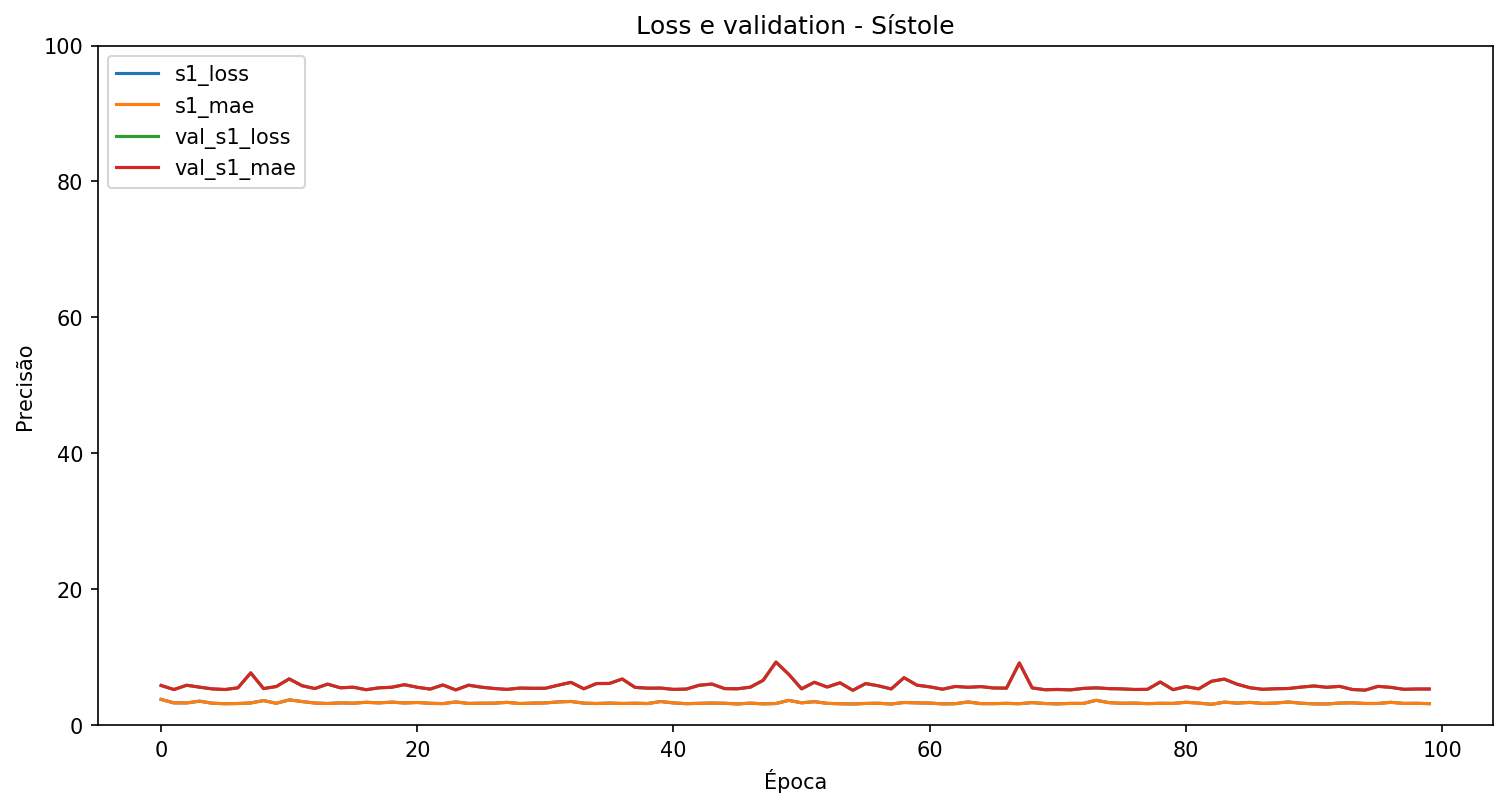

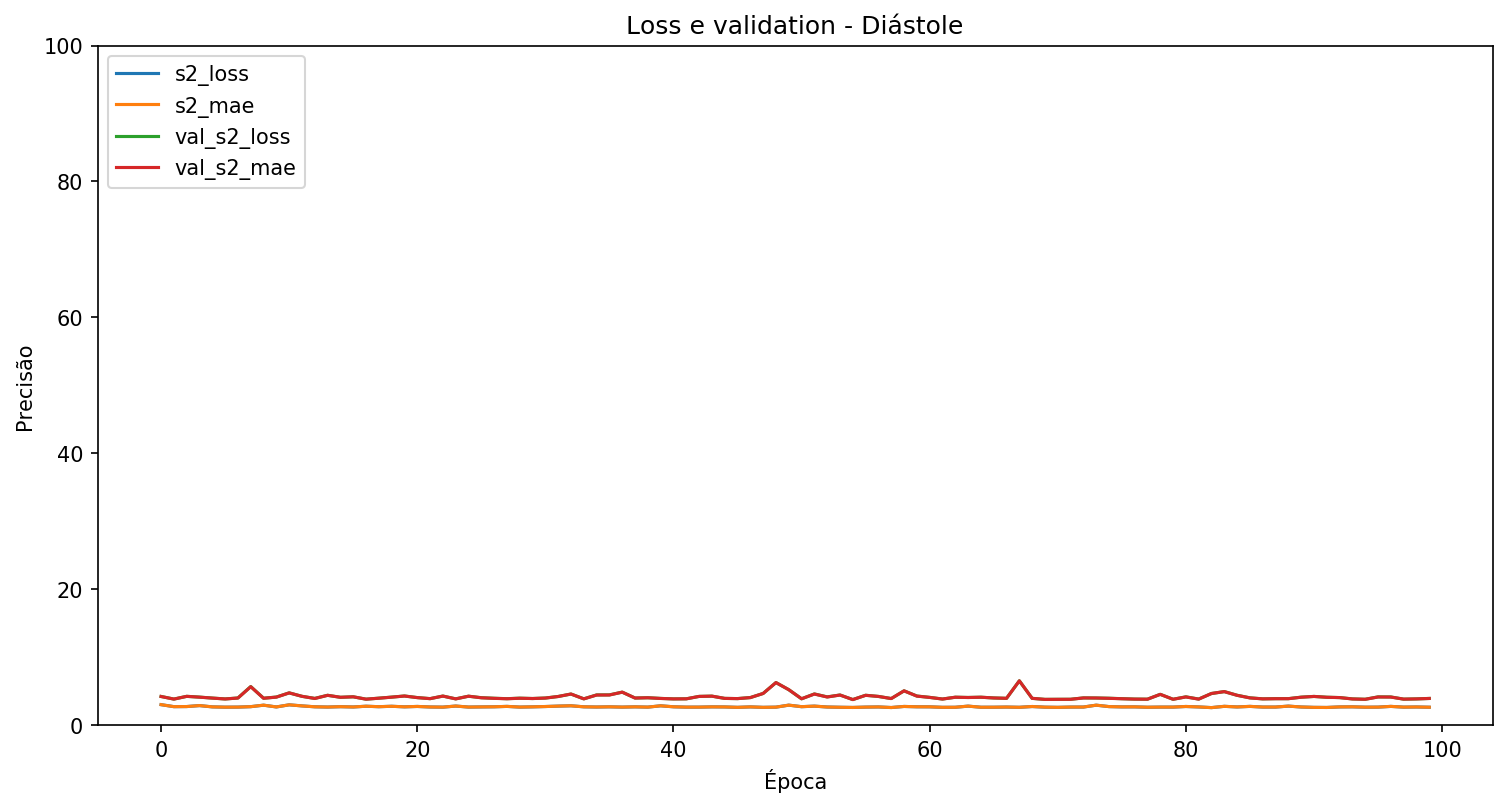

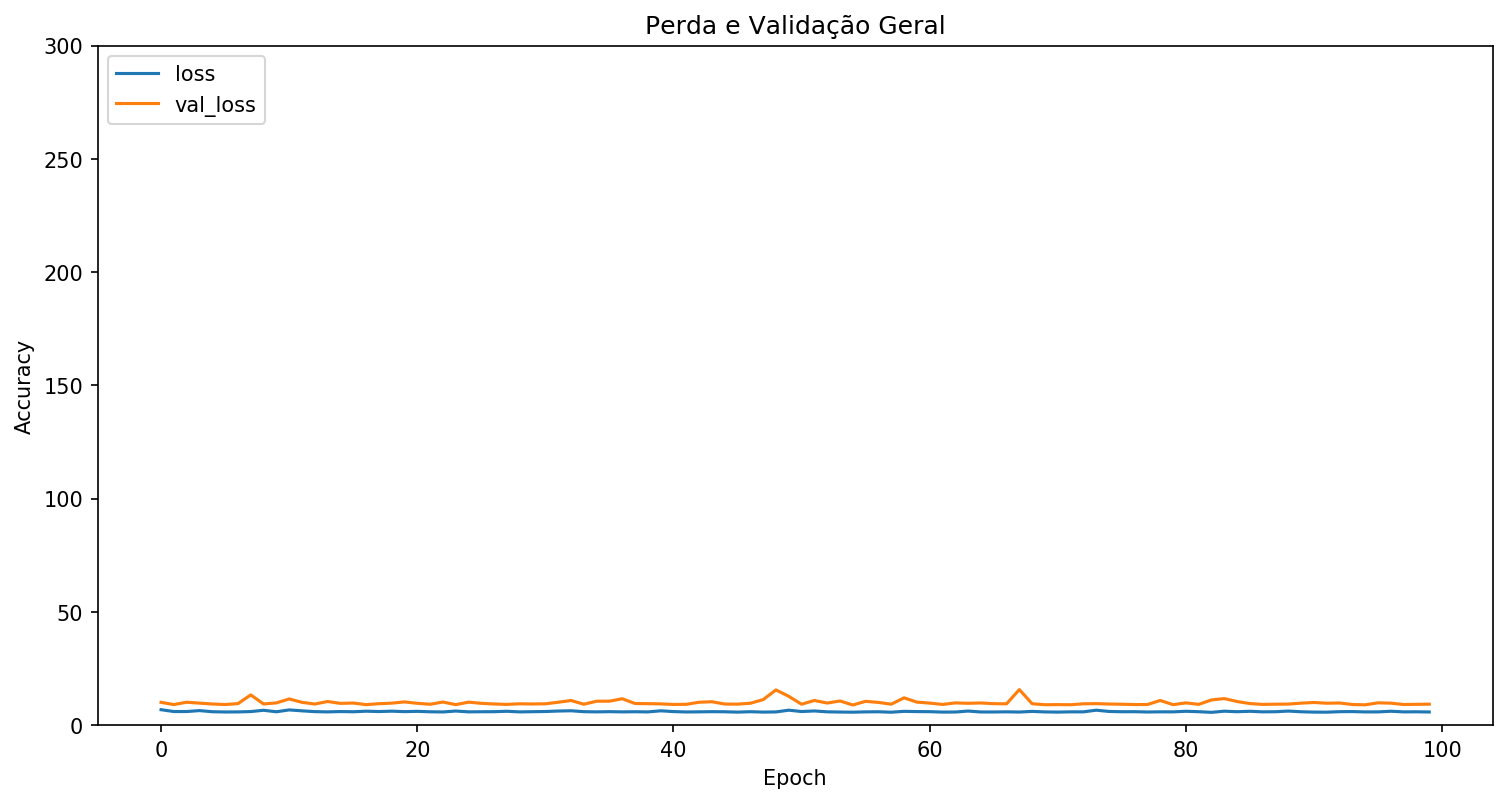

In [79]:
# plots_loss_validation(hist5.history)